# General formatting

In [1]:
knitr::opts_chunk$set(echo = TRUE, warning = FALSE, message = FALSE)

# Read in the dataset

In [2]:
# Read in the dataset
energy_data <- read.csv("Energy Consumption_r.csv")
gdp_data <- read.csv("GDP-1.csv")

# Install packages

In [4]:
library(data.table)
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)
library(corrplot)
library(mgcv)
library(zoo)
library(knitr)
library(tseries)
library(stringi)
library(TSA)
library(astsa)
library(forecast)
library(car)
library(vars)
library(fGarch)
library(aod)
library(ggpubr)
library(xts)
library(rugarch,warn.conflicts=FALSE)
library(ggfortify)
library(quantmod)
library(urca)
library(RColorBrewer)


## Data Preparation



In [5]:
# view energy data structure
str(energy_data)

'data.frame':	600 obs. of  16 variables:
 $ ï..Month                                                         : chr  "1973 enero" "1973 febrero" "1973 marzo" "1973 abril" ...
 $ Primary.Energy.Consumed.by.the.Residential.Sector                : num  1339 1175 983 715 536 ...
 $ Electricity.Sales.to.Ultimate.Customers.in.the.Residential.Sector: num  180 169 158 143 136 ...
 $ End.Use.Energy.Consumed.by.the.Residential.Sector                : num  1520 1344 1141 858 672 ...
 $ Residential.Sector.Electrical.System.Energy.Losses               : num  438 368 369 325 335 ...
 $ Total.Energy.Consumed.by.the.Residential.Sector                  : num  1958 1712 1510 1183 1006 ...
 $ Primary.Energy.Consumed.by.the.Commercial.Sector                 : num  658 624 492 363 289 ...
 $ Electricity.Sales.to.Ultimate.Customers.in.the.Commercial.Sector : num  123 120 118 114 118 ...
 $ End.Use.Energy.Consumed.by.the.Commercial.Sector                 : num  781 744 610 477 406 ...
 $ Commercial.Sector.Ele

In [6]:
names(energy_data) <- c("Month","Primary_RS","ElecSales_RS","EndUse_RS",
"Loss_RS","Total_RS","Primary_CS","ElecSales_CS",
"EndUse_CS","Loss_CS","Total_CS","Primary_IS",
"ElecSales_IS","EndUse_IS","Loss_IS","Total_IS")

In [7]:
# split month column into year and month
energy_data <- separate(energy_data, Month, into = c("Year", "Month"), sep = " ")

In [8]:
colnames(energy_data)

[1] "Year"         "Month"        "Primary_RS"   "ElecSales_RS" "EndUse_RS"   
 [6] "Loss_RS"      "Total_RS"     "Primary_CS"   "ElecSales_CS" "EndUse_CS"   
[11] "Loss_CS"      "Total_CS"     "Primary_IS"   "ElecSales_IS" "EndUse_IS"   
[16] "Loss_IS"      "Total_IS"

In [9]:
# view gdp data structure
str(energy_data)
str(gdp_data)

'data.frame':	600 obs. of  17 variables:
 $ Year        : chr  "1973" "1973" "1973" "1973" ...
 $ Month       : chr  "enero" "febrero" "marzo" "abril" ...
 $ Primary_RS  : num  1339 1175 983 715 536 ...
 $ ElecSales_RS: num  180 169 158 143 136 ...
 $ EndUse_RS   : num  1520 1344 1141 858 672 ...
 $ Loss_RS     : num  438 368 369 325 335 ...
 $ Total_RS    : num  1958 1712 1510 1183 1006 ...
 $ Primary_CS  : num  658 624 492 363 289 ...
 $ ElecSales_CS: num  123 120 118 114 118 ...
 $ EndUse_CS   : num  781 744 610 477 406 ...
 $ Loss_CS     : num  299 260 276 260 289 ...
 $ Total_CS    : num  1081 1004 886 737 696 ...
 $ Primary_IS  : num  2027 1841 1926 1914 2076 ...
 $ ElecSales_IS: num  189 186 191 191 194 ...
 $ EndUse_IS   : num  2216 2028 2117 2105 2270 ...
 $ Loss_IS     : num  458 405 445 435 477 ...
 $ Total_IS    : num  2674 2433 2562 2540 2748 ...
'data.frame':	200 obs. of  2 variables:
 $ DATE: chr  "1973Q1" "1973Q2" "1973Q3" "1973Q4" ...
 $ GDP : num  5646 5708 5678 5732 

In [10]:
# Replace Spanish month names
energy_data$Month <- stri_replace_all_regex(energy_data$Month,
                                  pattern=c("enero", "febrero", "marzo","abril", "mayo", "junio","julio", "agosto", "septiembre","octubre", "noviembre", "diciembre"),
                                  replacement=c(1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11,12),
                                  vectorize=FALSE)


In [11]:
## Process Dates
year = energy_data$Year
month = energy_data$Month
day = 1

# we pull the three date columns into one matrix
datemat = cbind(as.character(day),as.character(month),as.character(year))

# define a function paste.dates that takes as input a vector of 3 variables: day, month and year
paste.dates = function(date){
  day = date[1]; month=date[2]; year = date[3]
  return(paste(day,month,year,sep="/"))
}

# apply the function to each row in datemat
dates = apply(datemat,1,paste.dates)

# convert the dates into dates that R can identify
dates = as.Date(dates, format="%d/%m/%Y")

# add the dates to the dataframe
energy_data = cbind(dates,energy_data[,3:17])



#### Create time series - no transformation



In [12]:
# create time series for energy and GDP data - no transformation
energy_data.ts_std = ts(energy_data[,2:16],start=1973,frequency=12)
gdp_data.ts_std = ts(gdp_data[,2],start=1973,frequency=4)

# create time series for energy data separately
Total_RS_std.ts = ts(energy_data.ts_std[,5],start=1973,frequency=12)



#### Create time series - log transformed



In [13]:
# create time series for energy and GDP data - log transformed
energy_data.ts = log(energy_data.ts_std)
gdp_data.ts = log(gdp_data.ts_std)

# create time series for energy data separately
Primary_RS.ts = ts(energy_data.ts[,1],start=1973,frequency=12)
ElecSales_RS.ts = ts(energy_data.ts[,2],start=1973,frequency=12)
EndUse_RS.ts = ts(energy_data.ts[,3],start=1973,frequency=12)
Loss_RS.ts = ts(energy_data.ts[,4],start=1973,frequency=12)
Total_RS.ts = ts(energy_data.ts[,5],start=1973,frequency=12)

Primary_CS.ts = ts(energy_data.ts[,6],start=1973,frequency=12)
ElecSales_CS.ts = ts(energy_data.ts[,7],start=1973,frequency=12)
EndUse_CS.ts = ts(energy_data.ts[,8],start=1973,frequency=12)
Loss_CS.ts = ts(energy_data.ts[,9],start=1973,frequency=12)
Total_CS.ts = ts(energy_data.ts[,10],start=1973,frequency=12)

Primary_IS.ts = ts(energy_data.ts[,11],start=1973,frequency=12)
ElecSales_IS.ts = ts(energy_data.ts[,12],start=1973,frequency=12)
EndUse_IS.ts = ts(energy_data.ts[,13],start=1973,frequency=12)
Loss_IS.ts = ts(energy_data.ts[,14],start=1973,frequency=12)
Total_IS.ts = ts(energy_data.ts[,15],start=1973,frequency=12)



#### Create aggregated time series



In [14]:
# aggregate enegry data time series into quarterly
energy_data.ag.ts <- aggregate.ts(energy_data.ts, nfrequency = 4)
energy_data_std.ag.ts <- aggregate.ts(energy_data.ts_std, nfrequency = 4)

# create time series for energy data separately
Primary_RS.ag.ts = ts(energy_data.ag.ts[,1],start=1973,frequency=4)
ElecSales_RS.ag.ts = ts(energy_data.ag.ts[,2],start=1973,frequency=4)
EndUse_RS.ag.ts = ts(energy_data.ag.ts[,3],start=1973,frequency=4)
Loss_RS.ag.ts = ts(energy_data.ag.ts[,4],start=1973,frequency=4)
Total_RS.ag.ts = ts(log(energy_data_std.ag.ts[,5]),start=1973,frequency=4)
Total_RS_std.ag.ts = ts(energy_data_std.ag.ts[,5],start=1973,frequency=4)

Primary_CS.ag.ts = ts(energy_data.ag.ts[,6],start=1973,frequency=4)
ElecSales_CS.ag.ts = ts(energy_data.ag.ts[,7],start=1973,frequency=4)
EndUse_CS.ag.ts = ts(energy_data.ag.ts[,8],start=1973,frequency=4)
Loss_CS.ag.ts = ts(energy_data.ag.ts[,9],start=1973,frequency=4)
Total_CS.ag.ts = ts(log(energy_data_std.ag.ts[,10]),start=1973,frequency=4)

Primary_IS.ag.ts = ts(energy_data.ag.ts[,11],start=1973,frequency=4)
ElecSales_IS.ag.ts = ts(energy_data.ag.ts[,12],start=1973,frequency=4)
EndUse_IS.ag.ts = ts(energy_data.ag.ts[,13],start=1973,frequency=4)
Loss_IS.ag.ts = ts(energy_data.ag.ts[,14],start=1973,frequency=4)
Total_IS.ag.ts = ts(log(energy_data_std.ag.ts[,15]),start=1973,frequency=4)



## Exploratory Data Analysis

#### Histograms



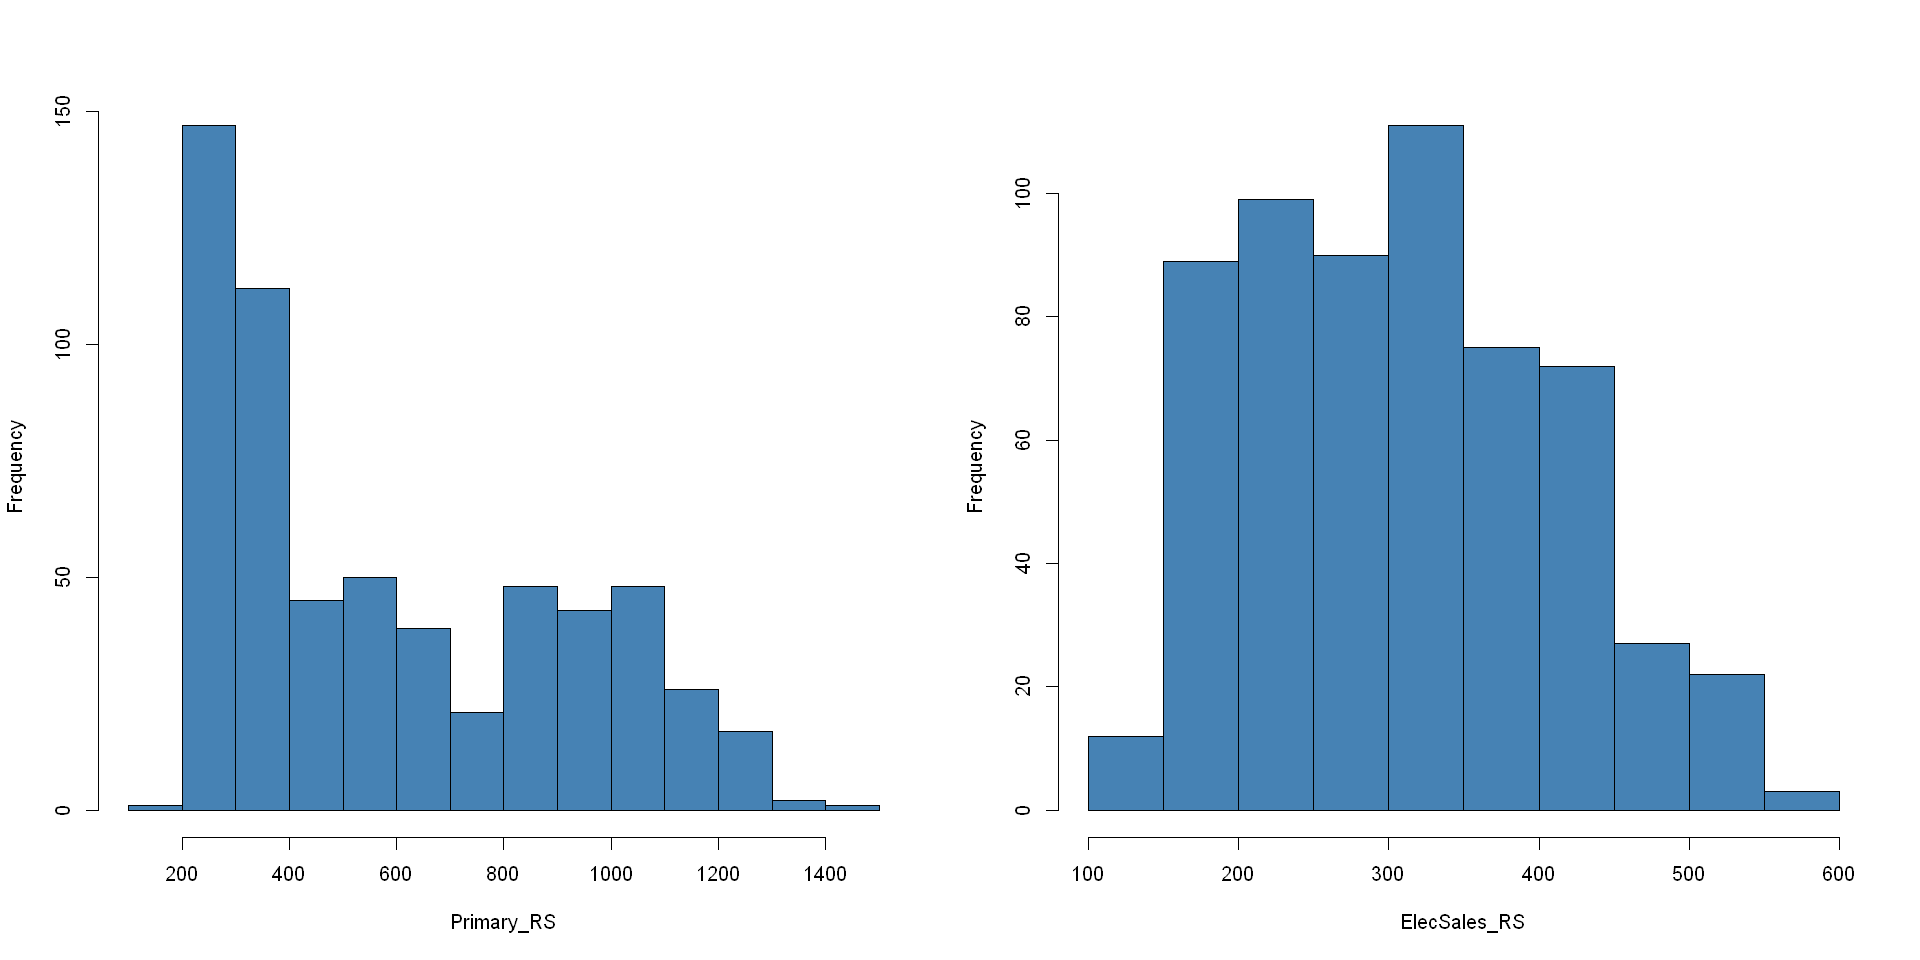

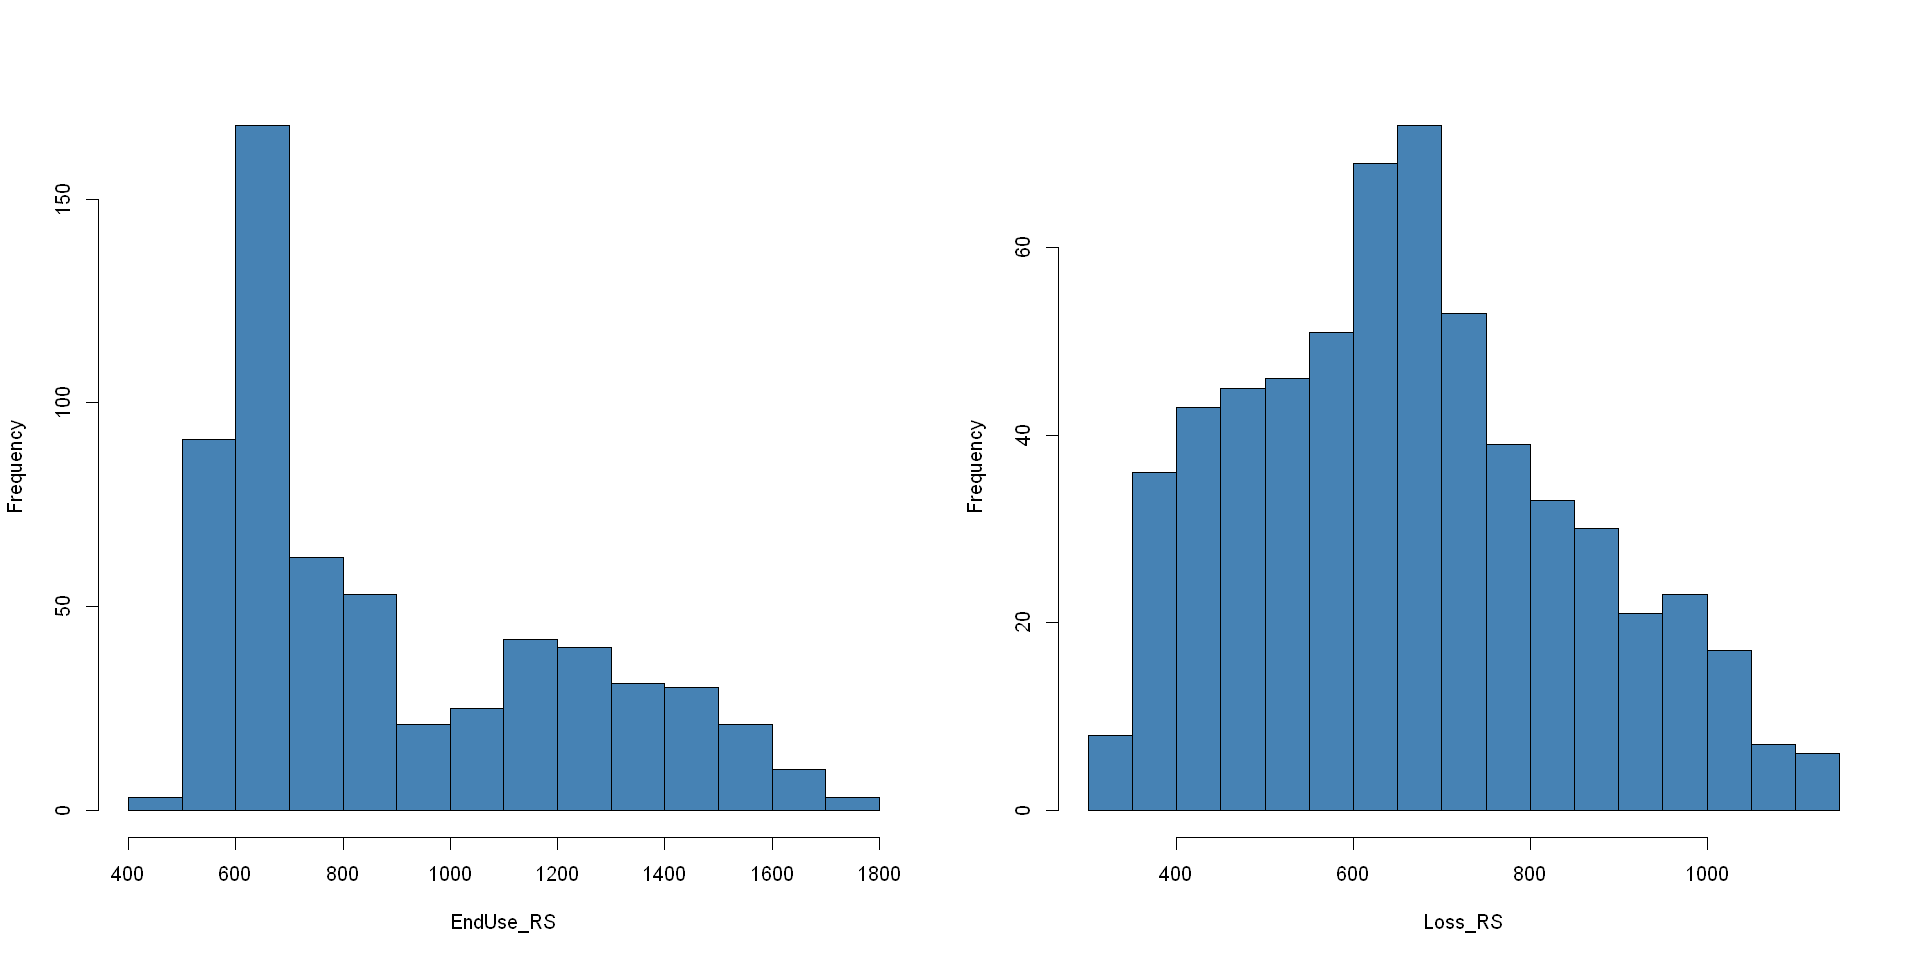

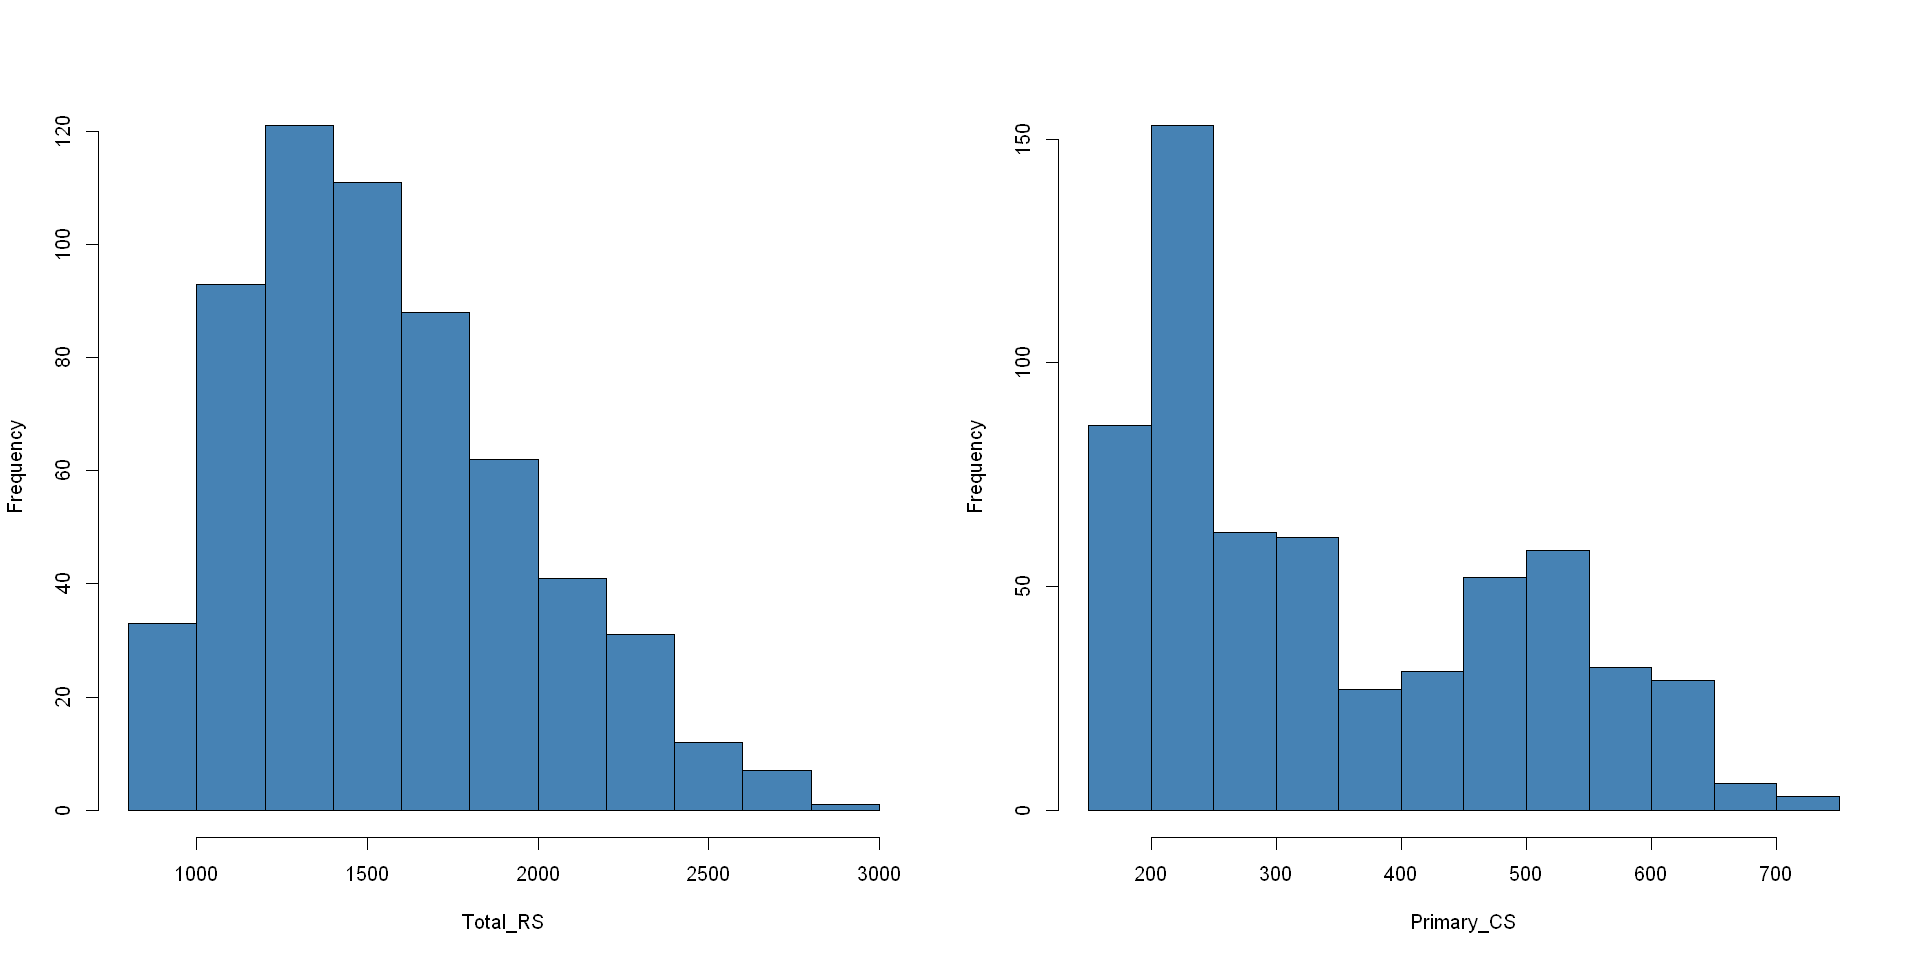

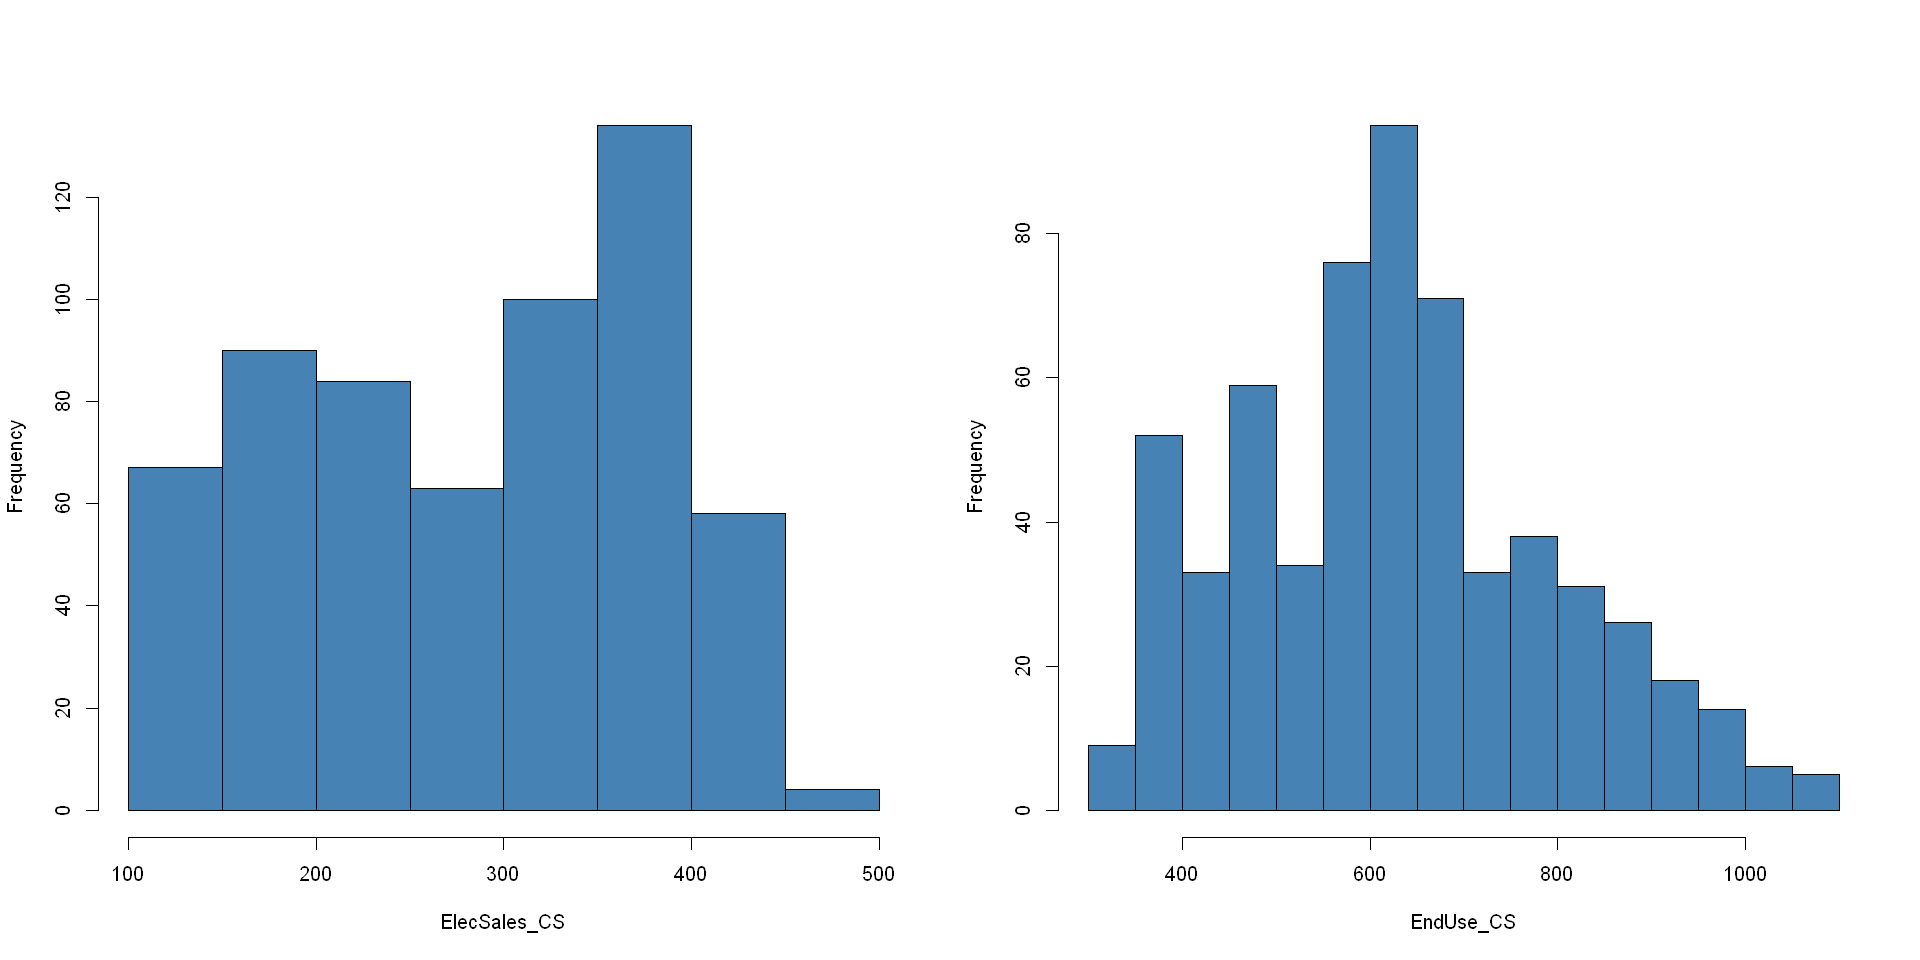

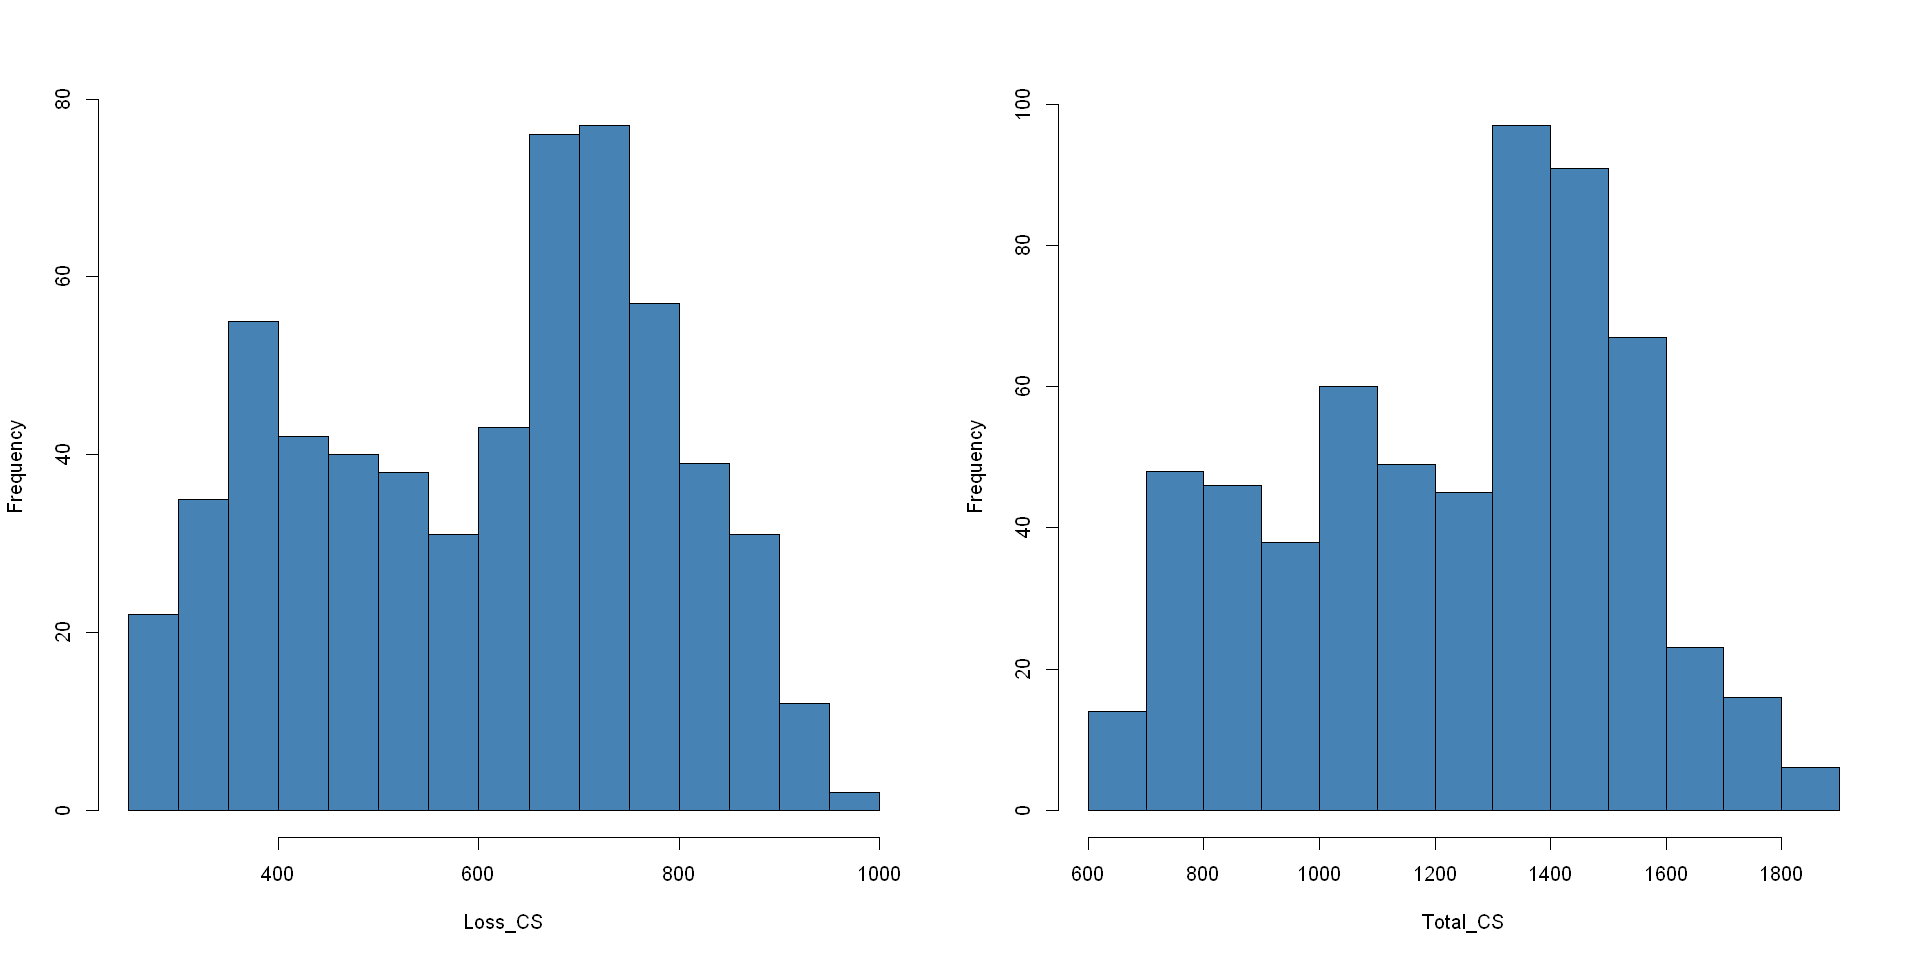

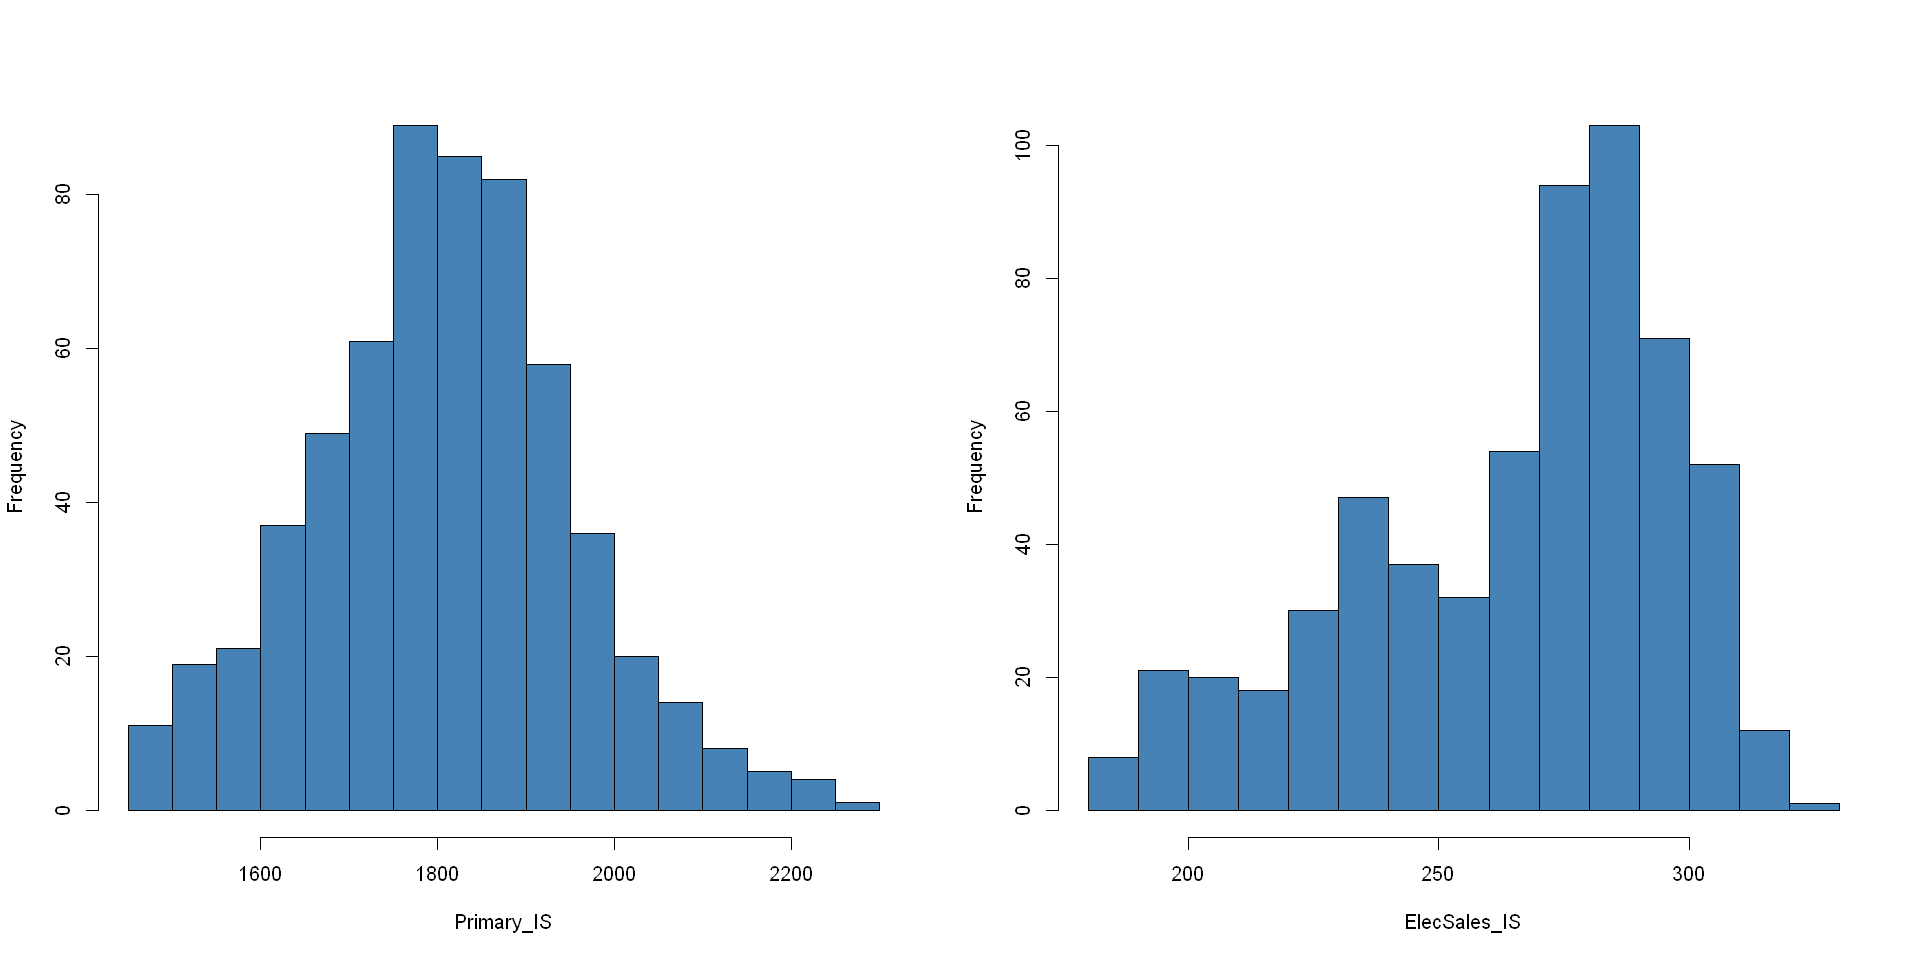

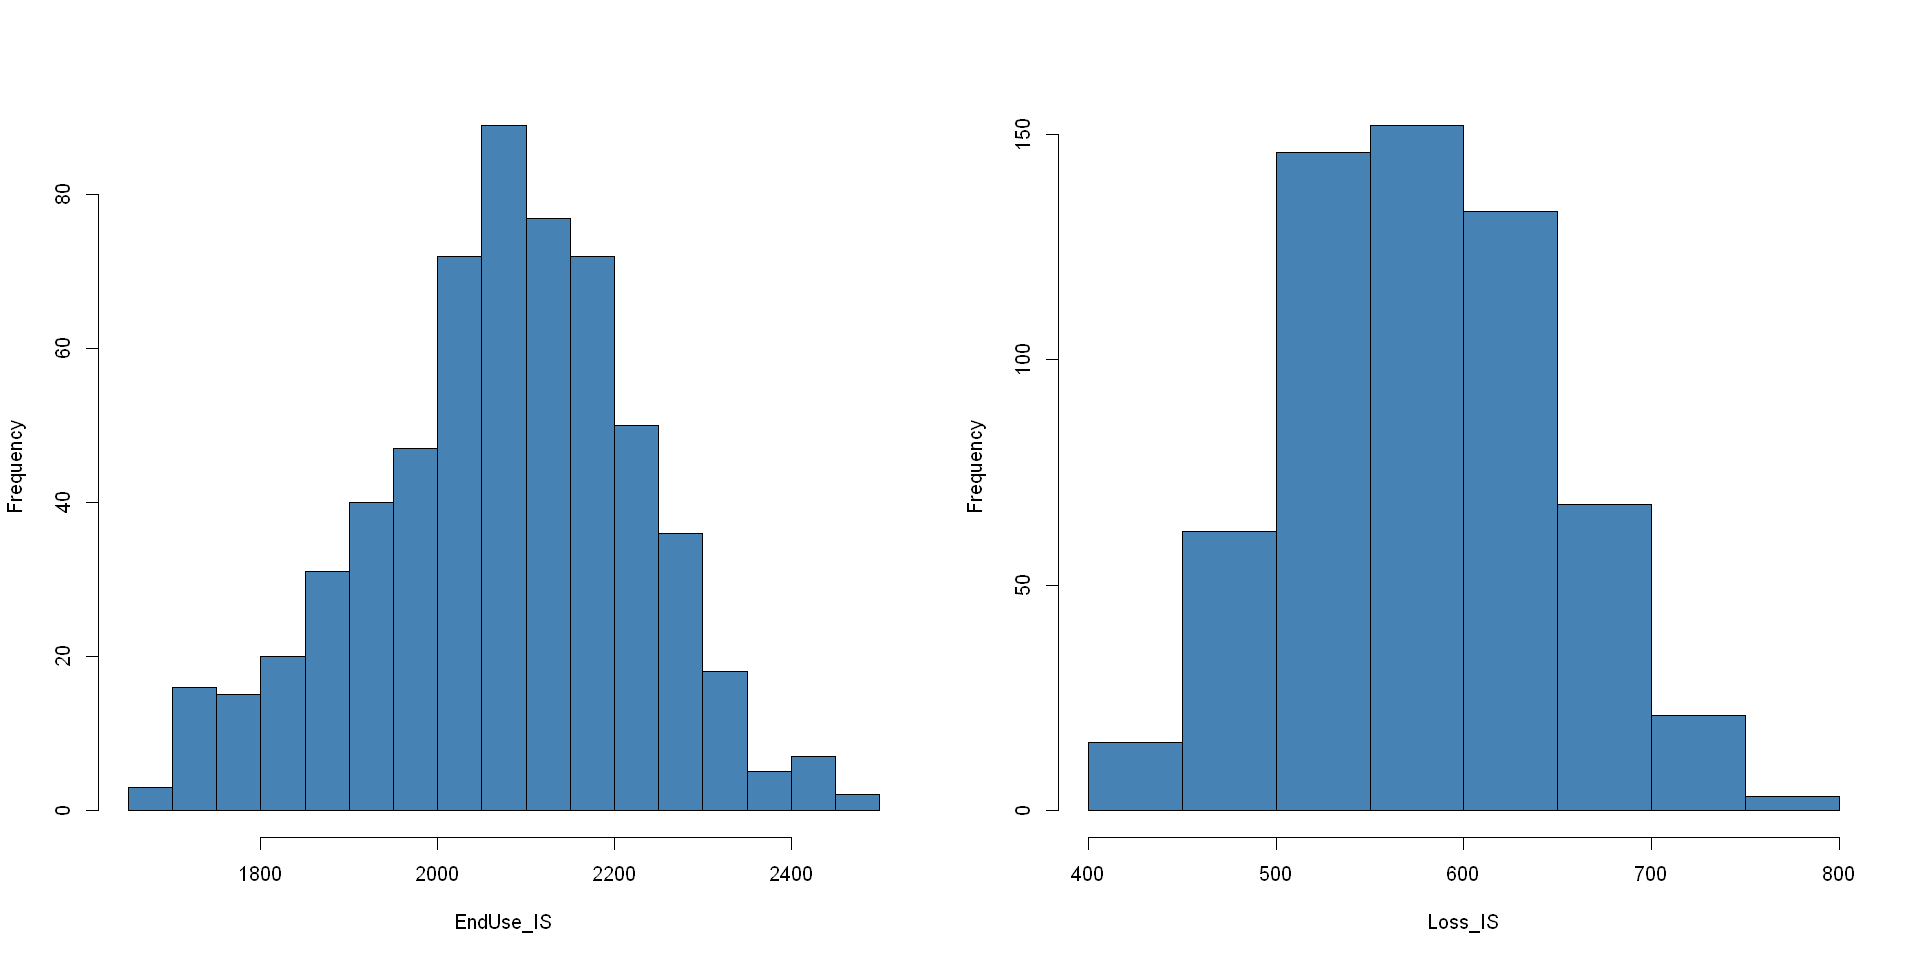

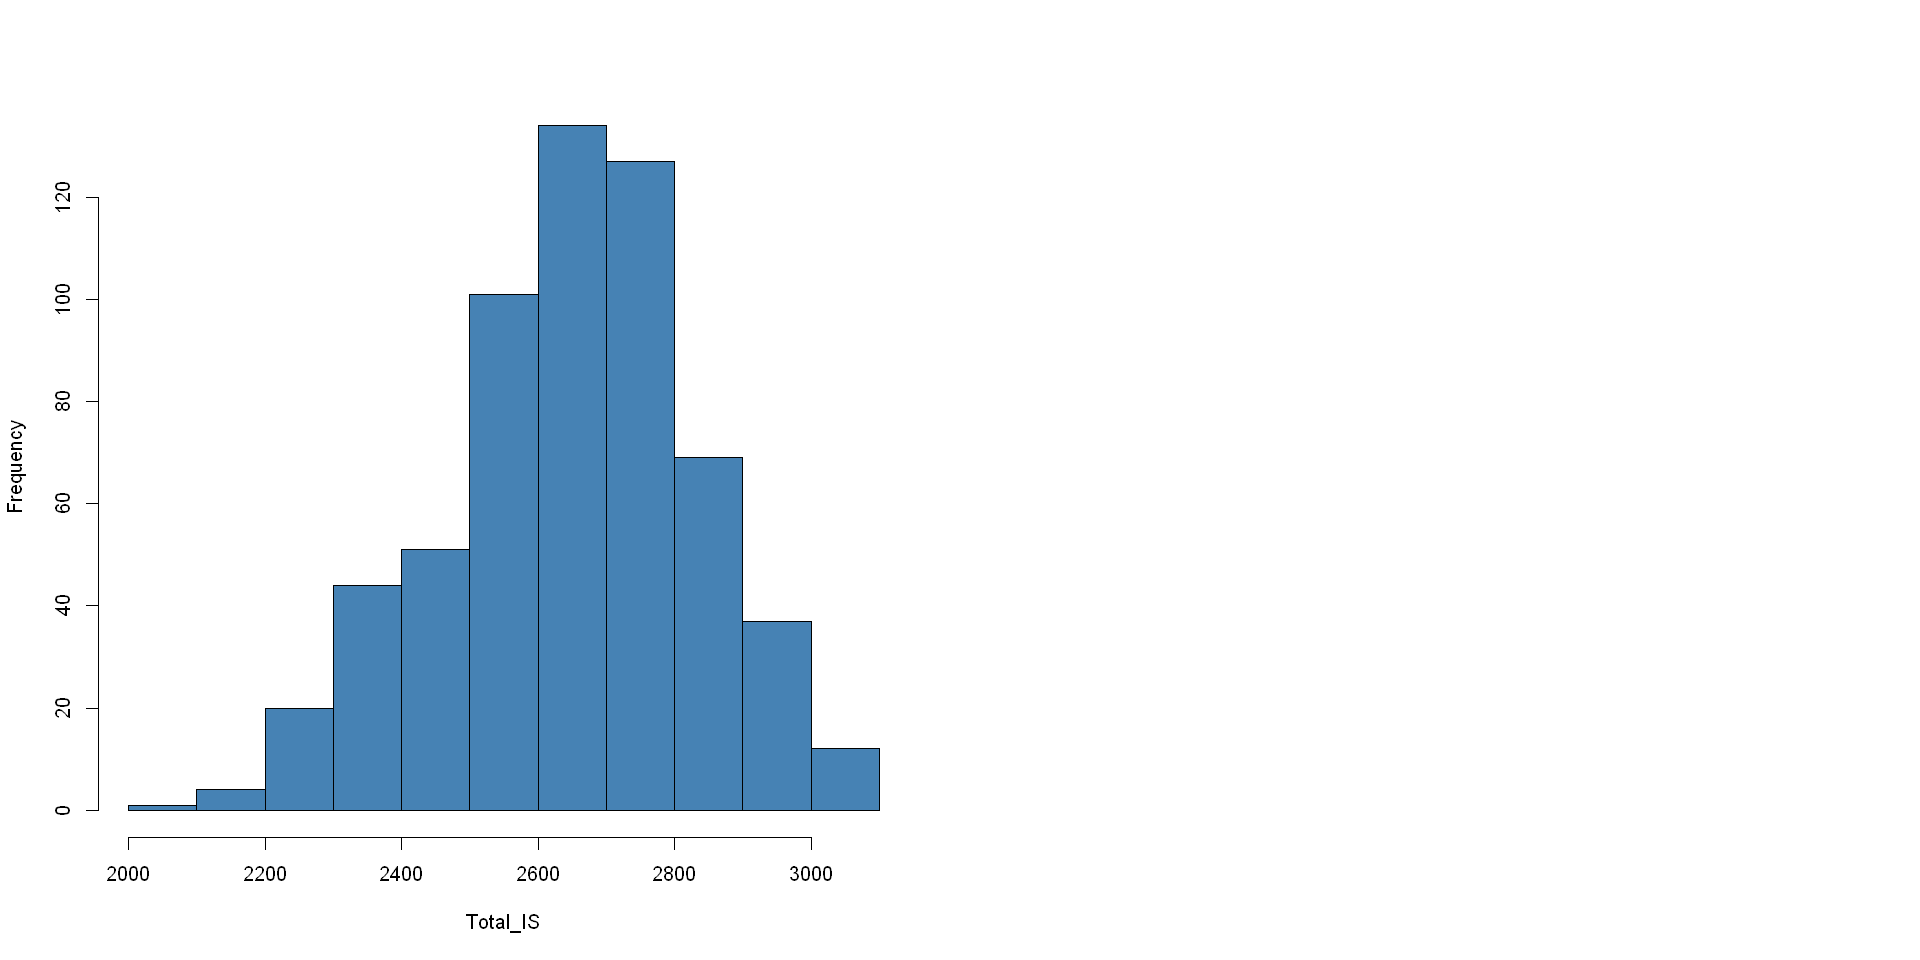

In [15]:
# create histograms
options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(1,2))
for (i in c(2:16)){
  name_i = names(energy_data[i])
  hist(energy_data[,i], xlab= name_i, col='steelblue', breaks=12,main=NULL)
}



#### Box plots



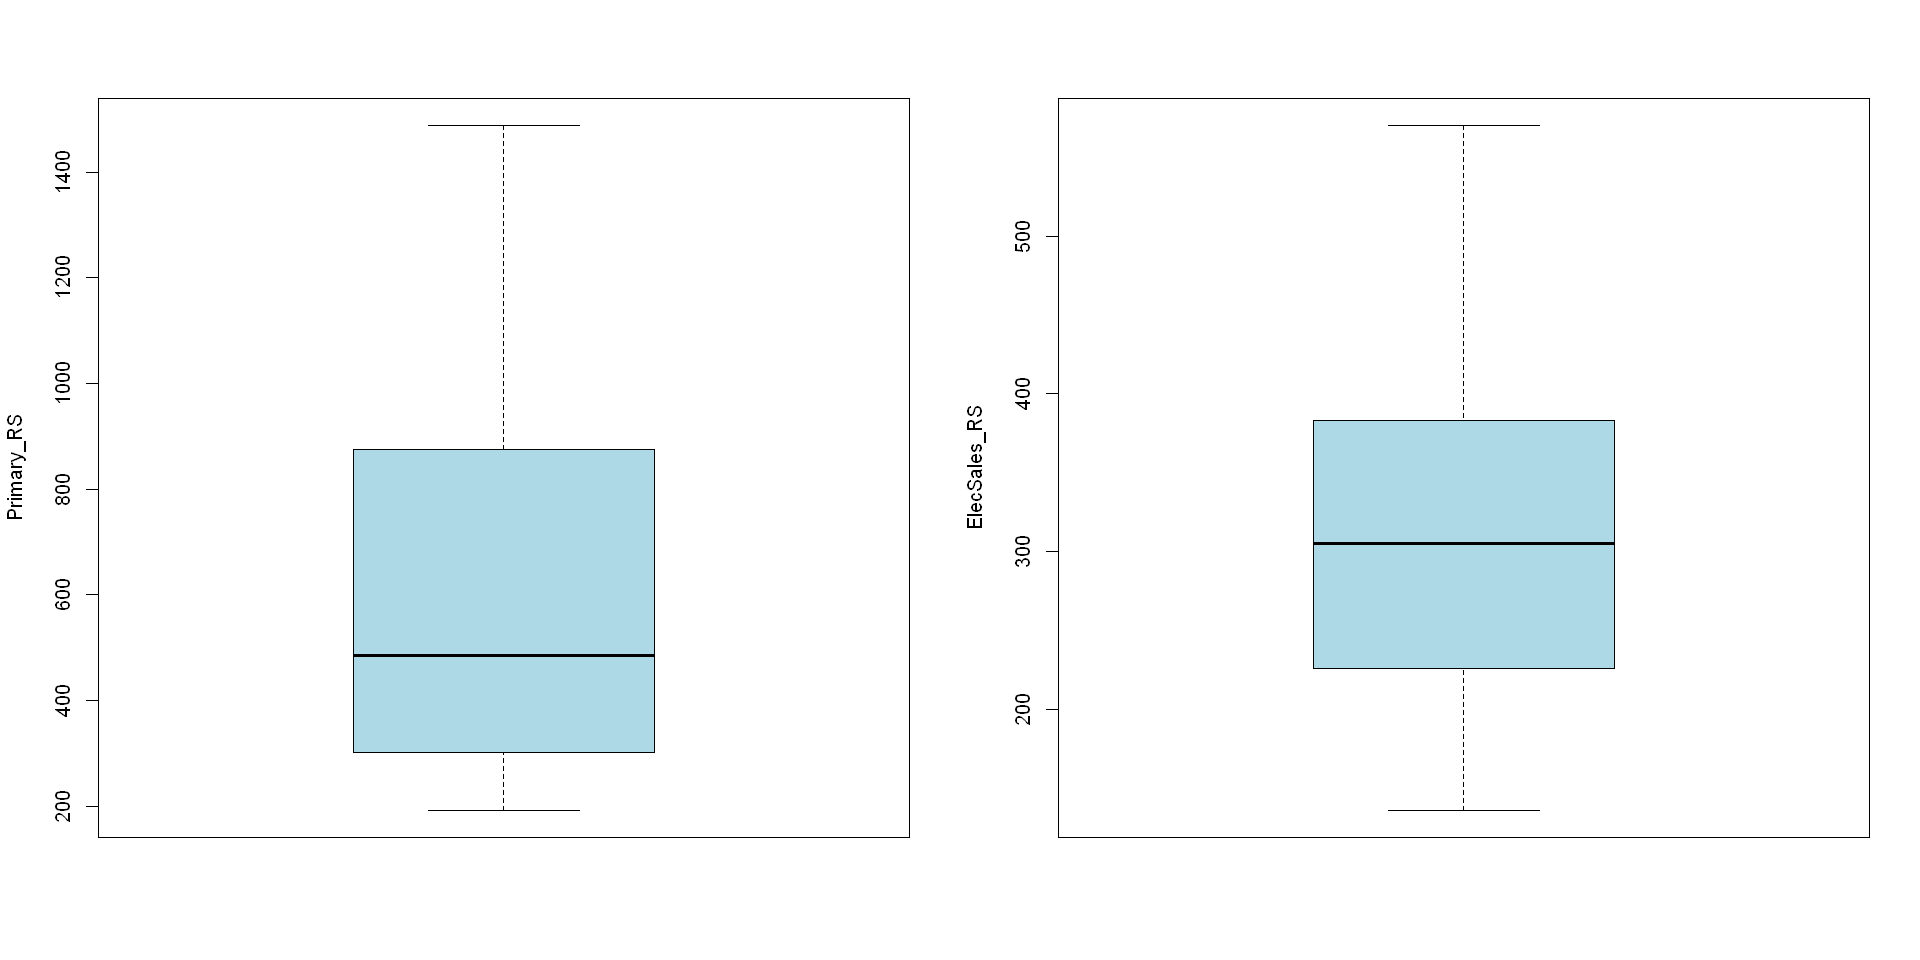

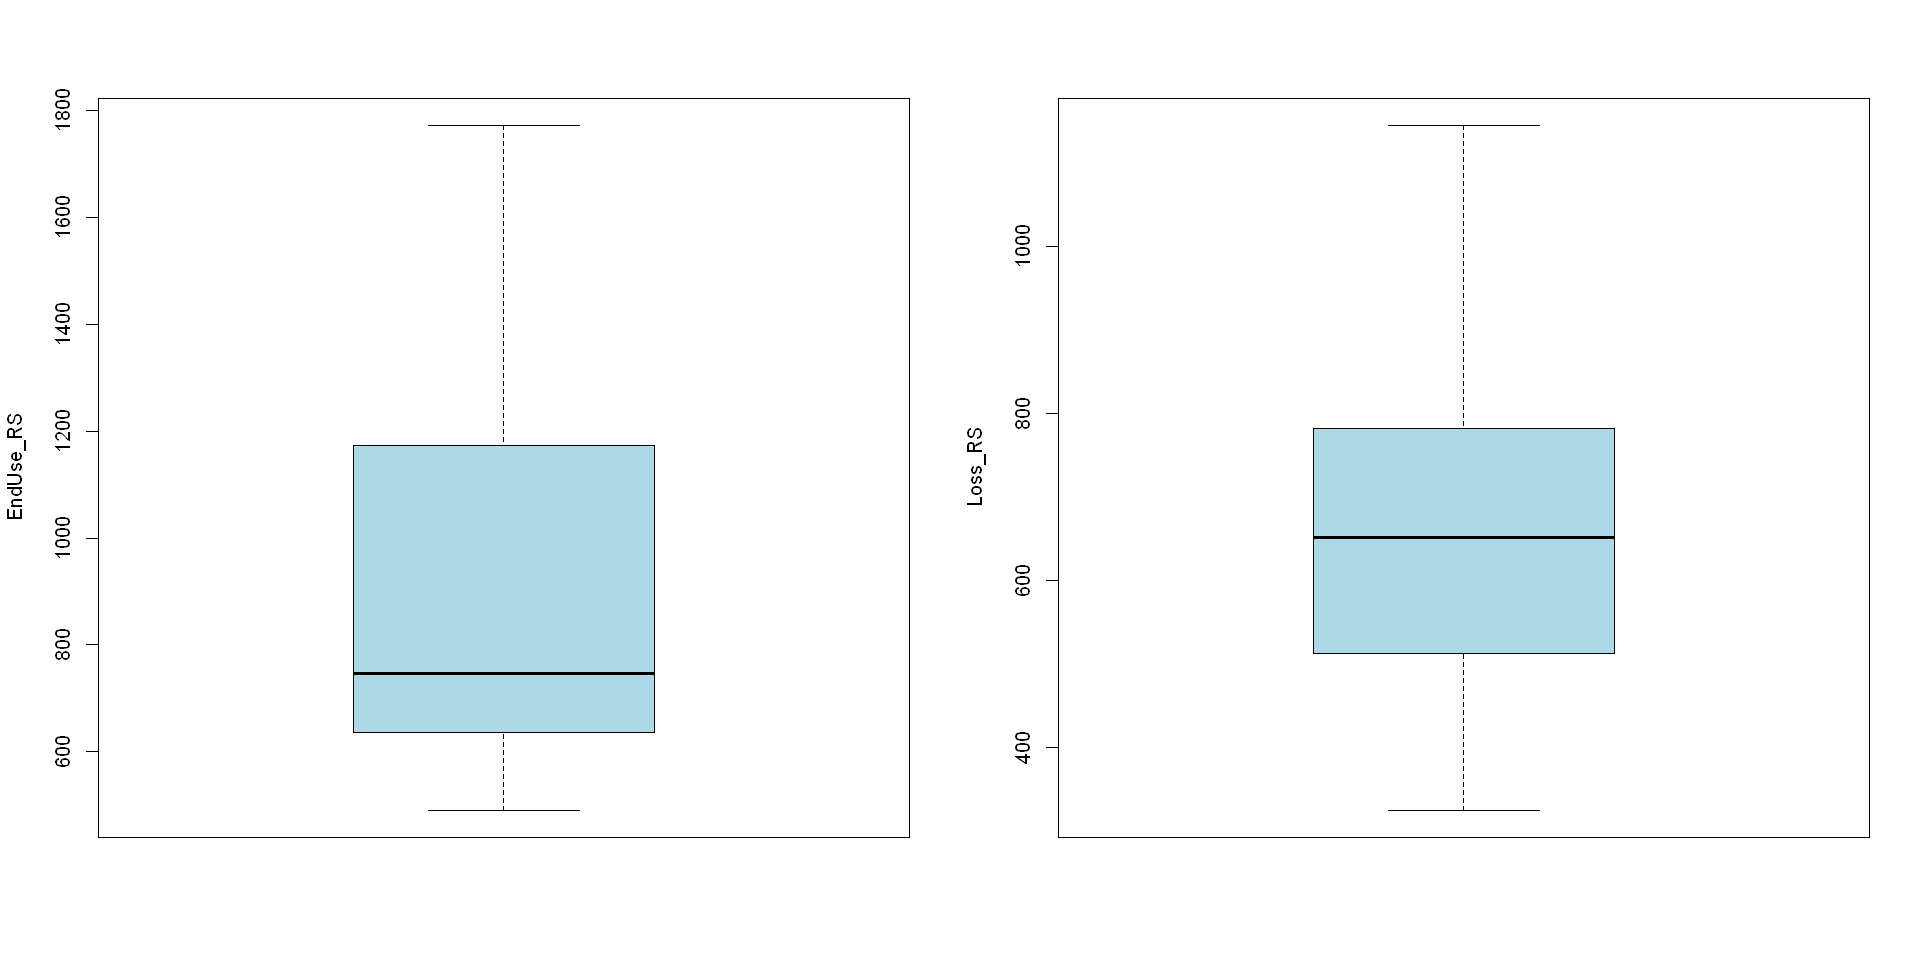

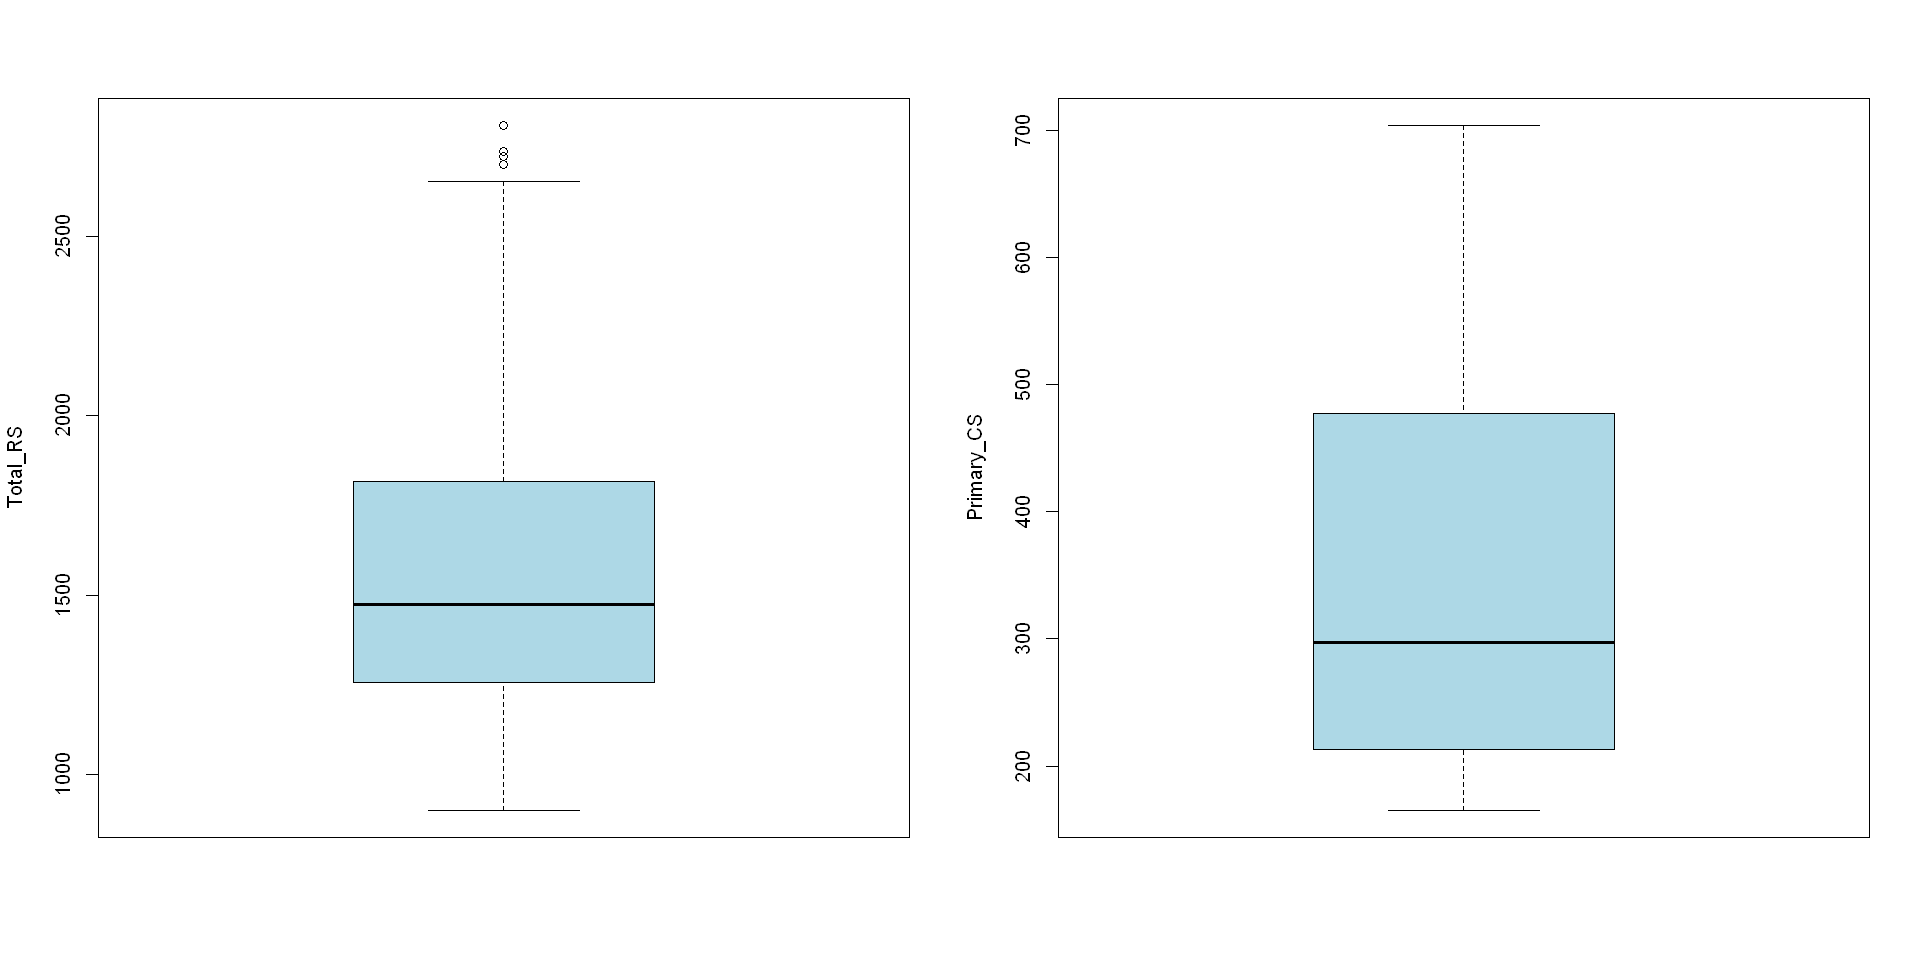

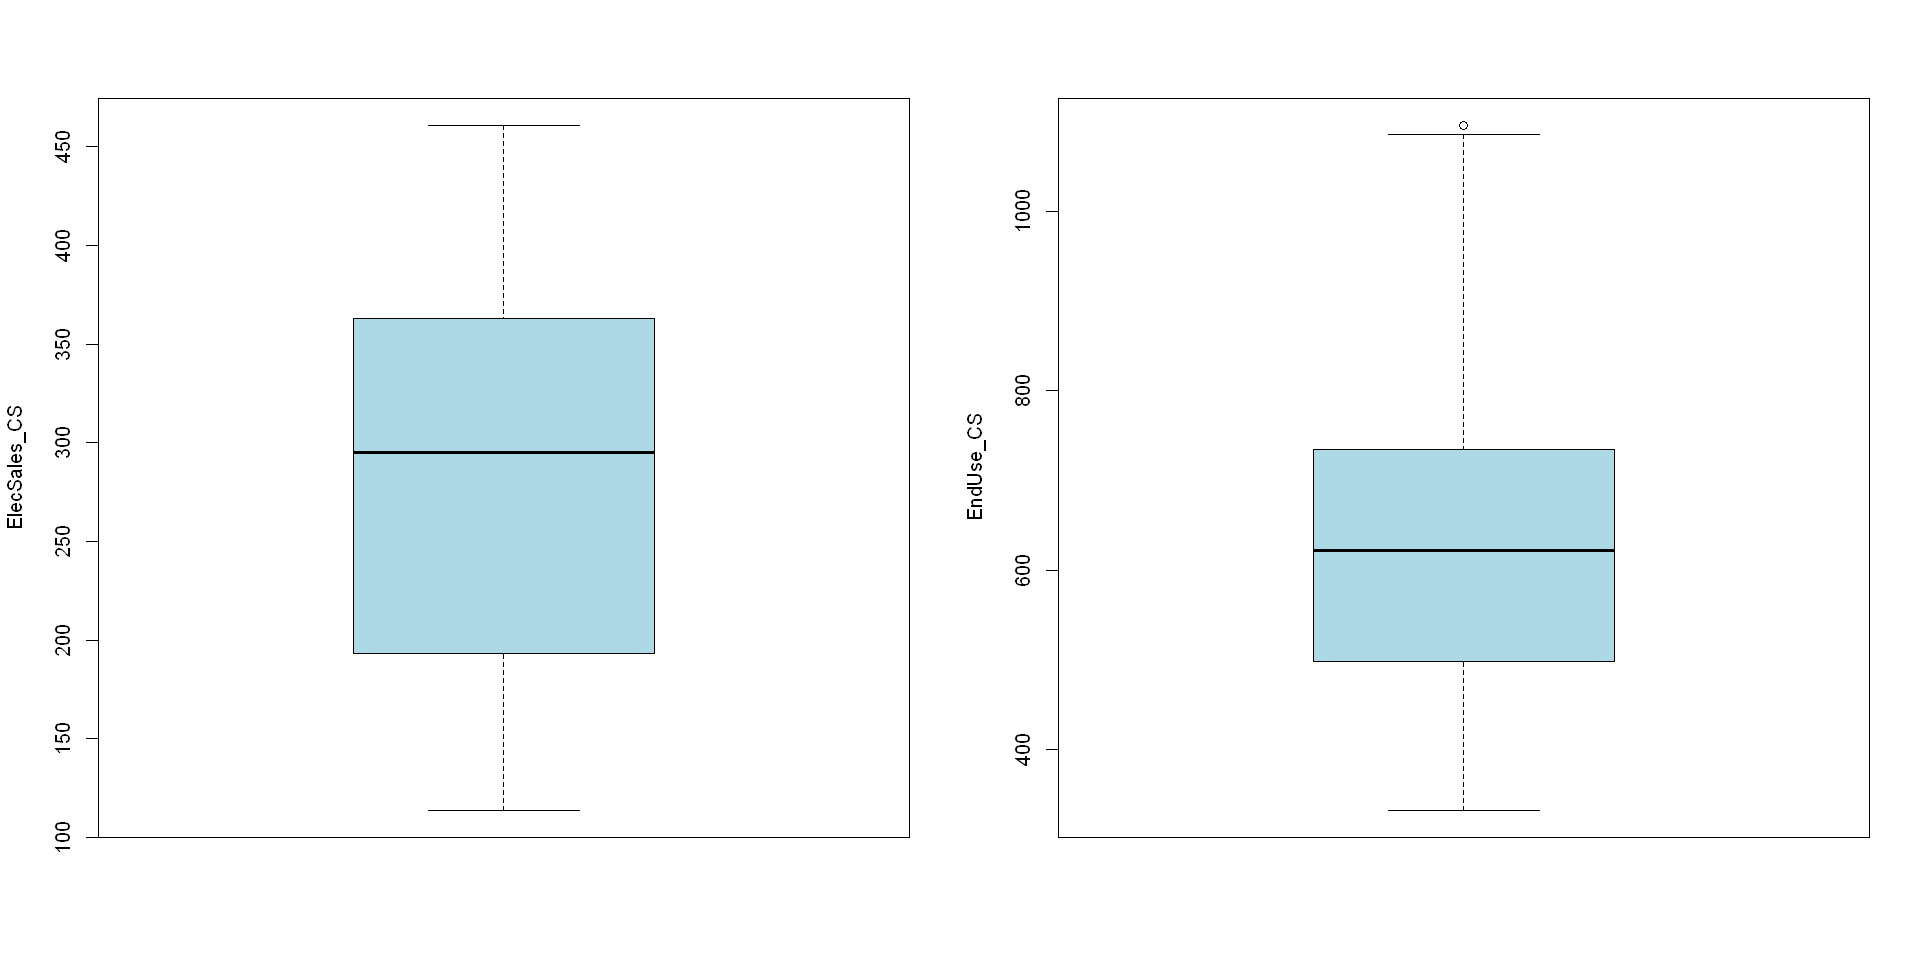

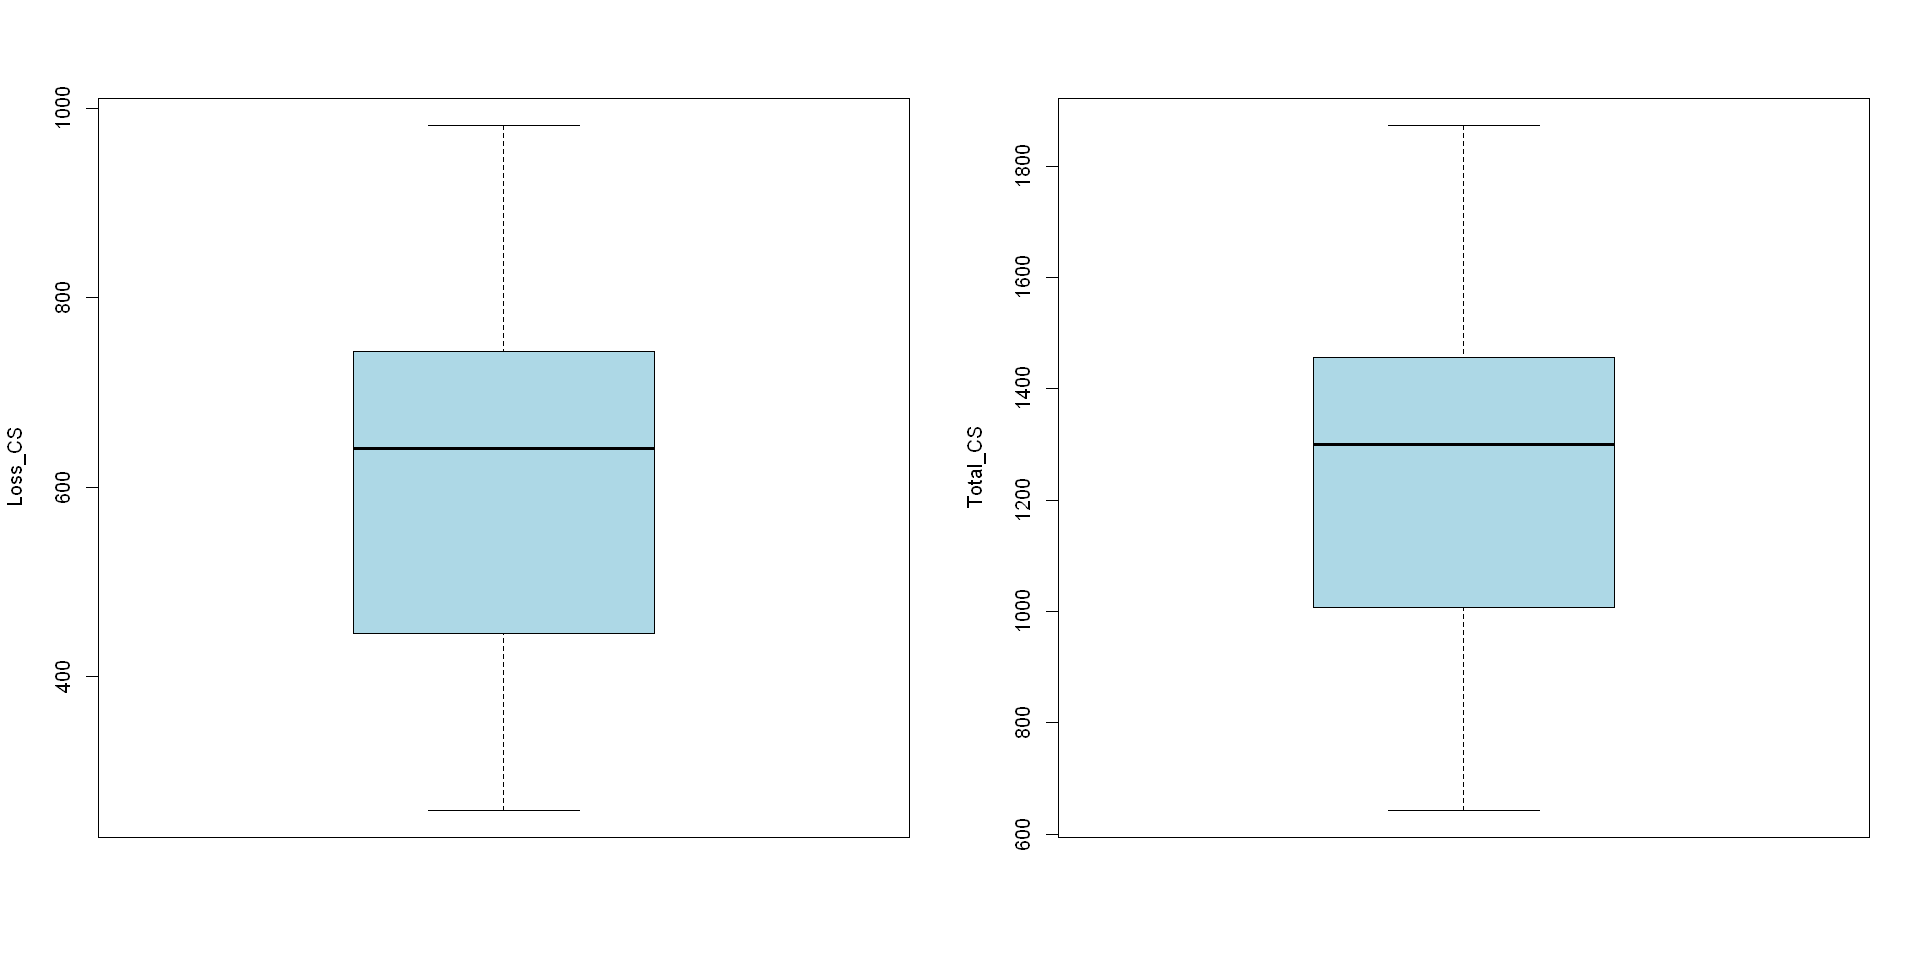

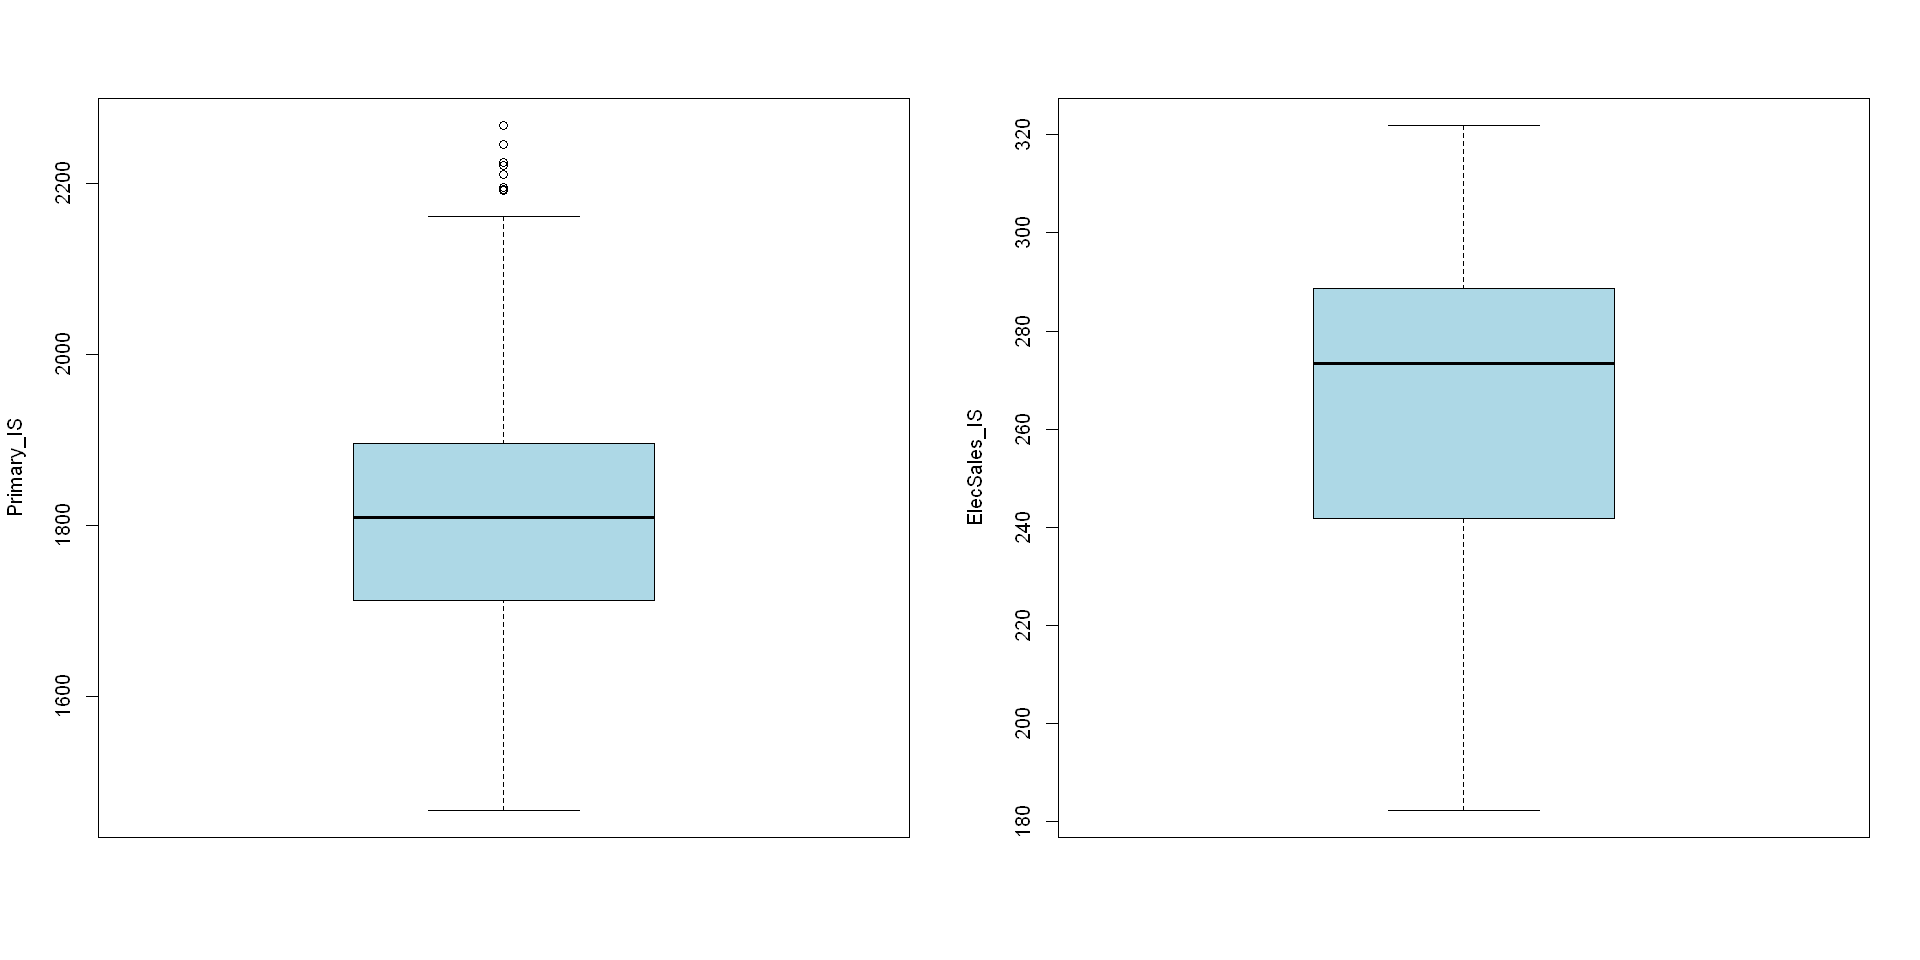

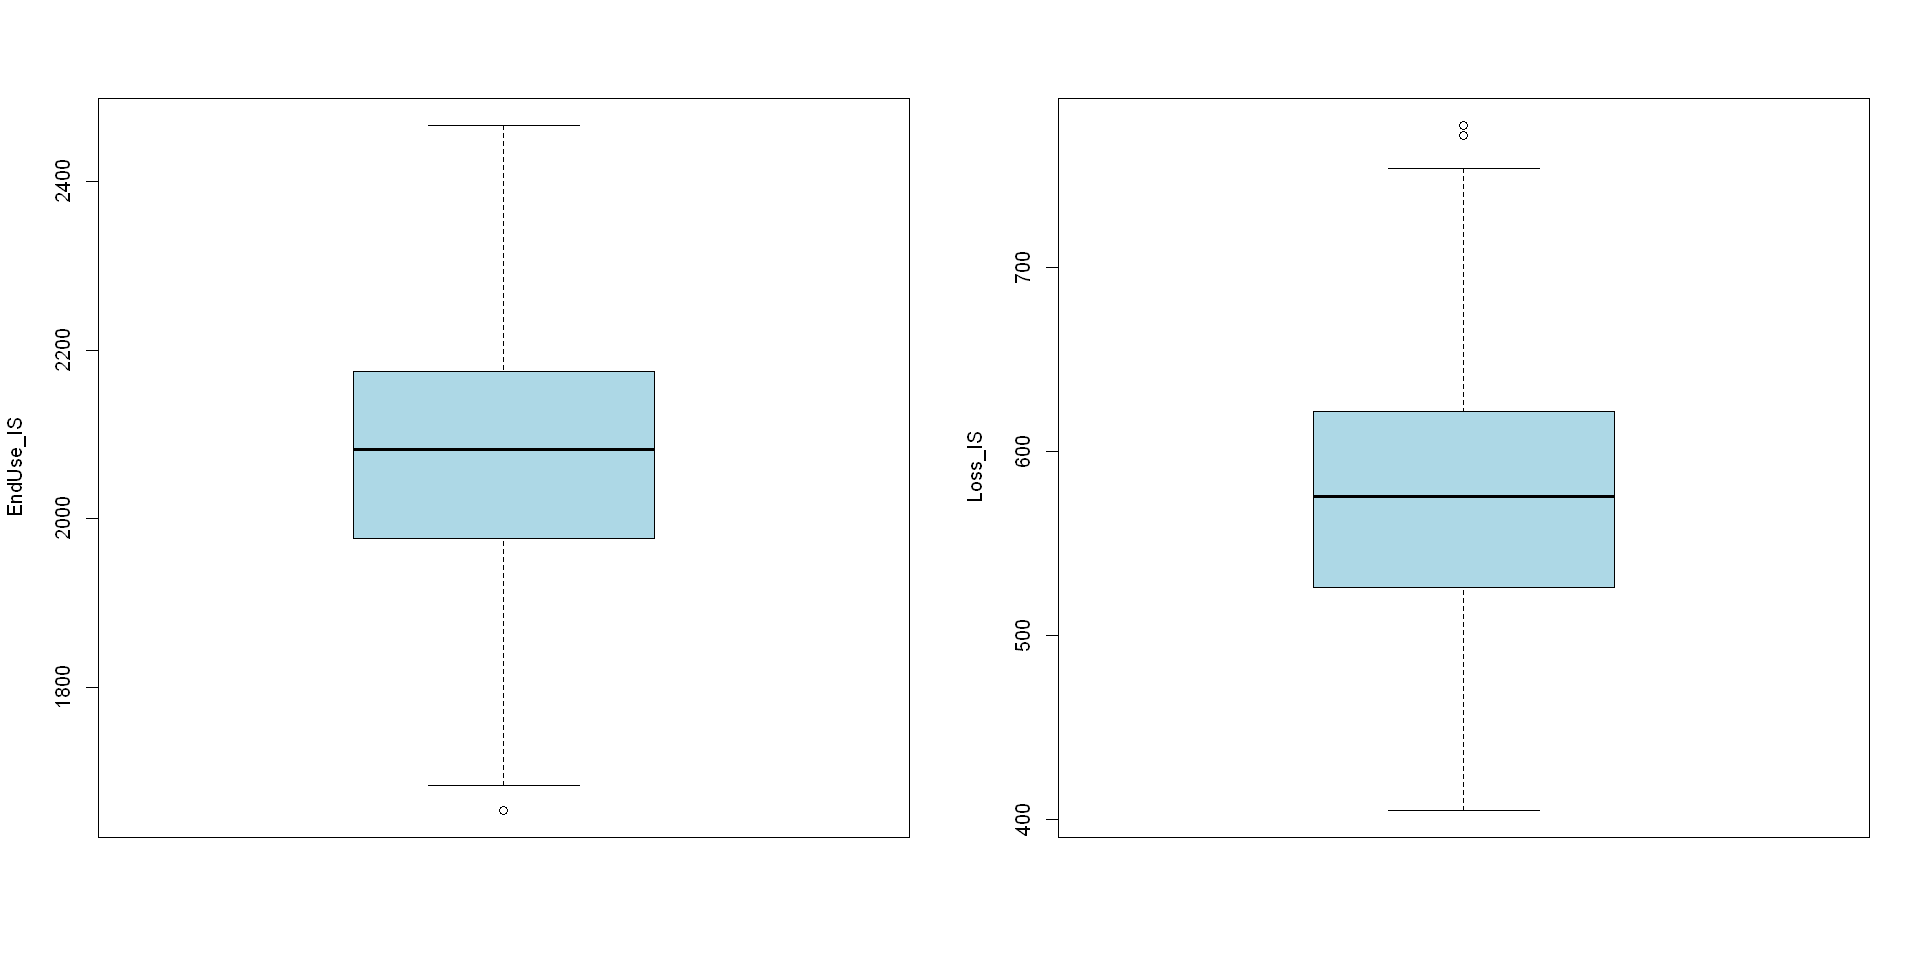

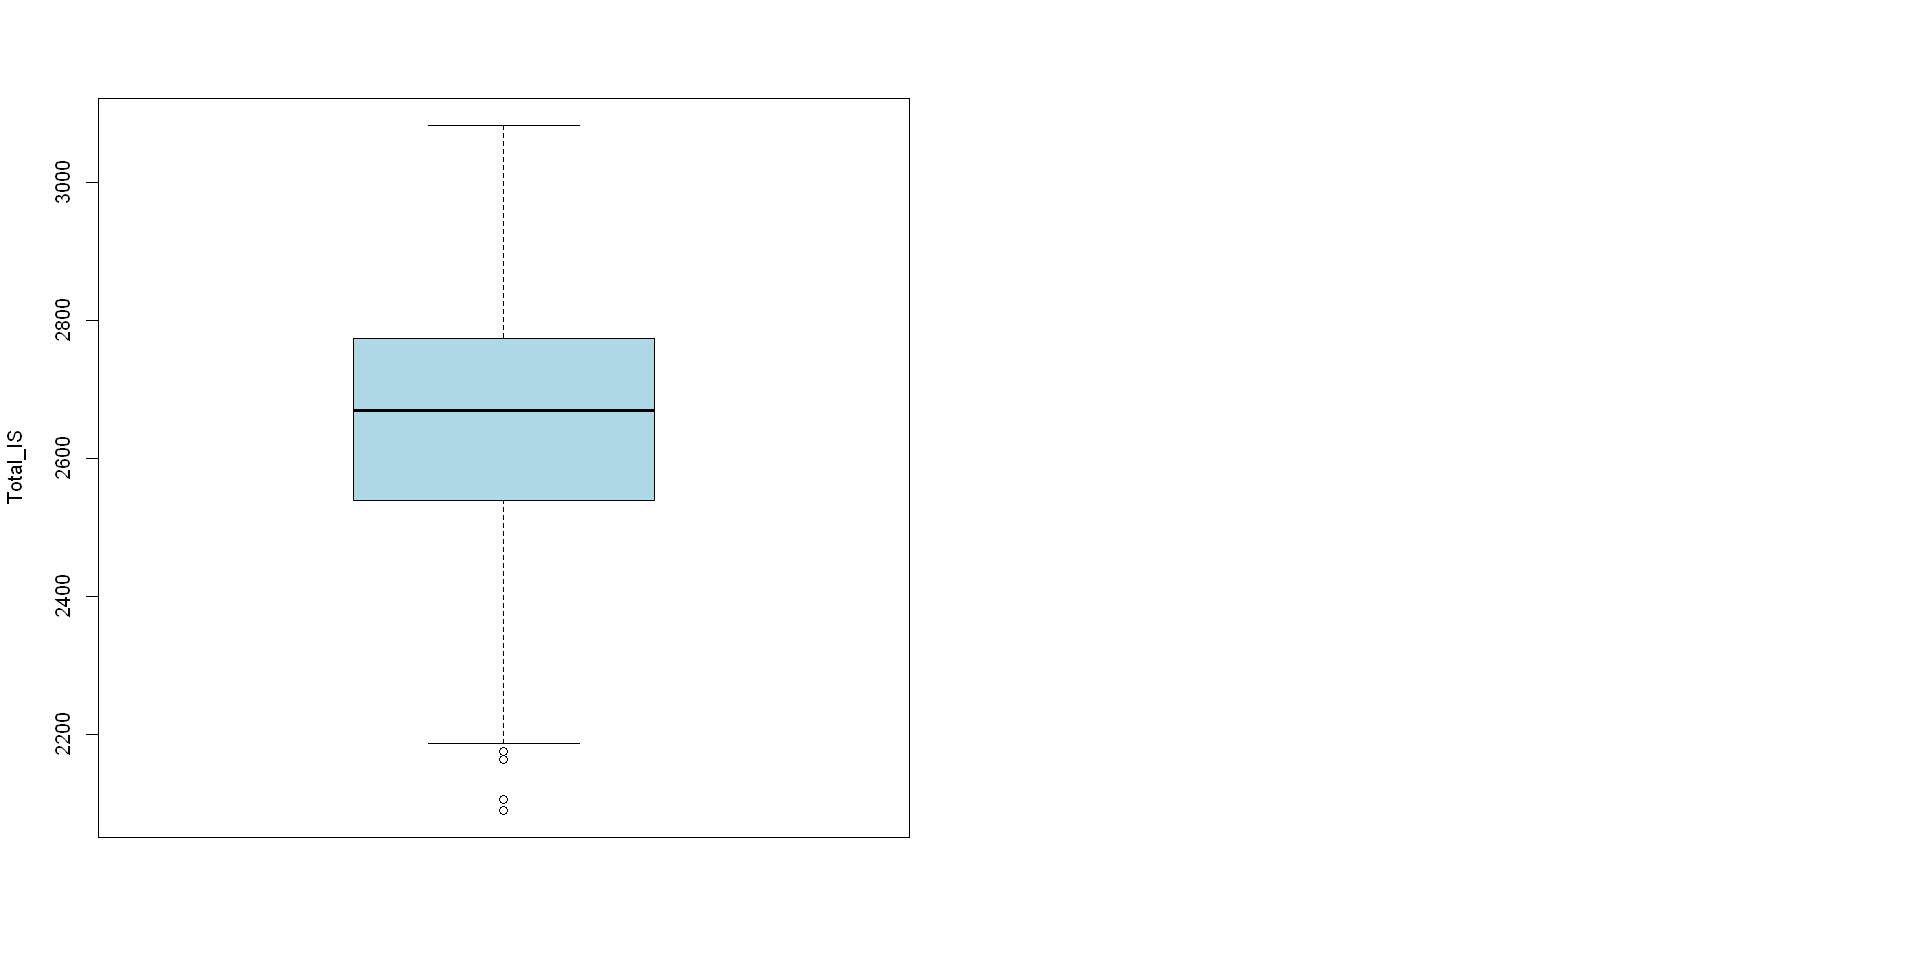

In [16]:
## Create boxplots
par(mfrow=c(1,2))
for (i in c(2:16)){
  name_i = names(energy_data[i])
  boxplot(energy_data[,i], xlab="",ylab= name_i,col='lightblue' )
}



#### Heatmap



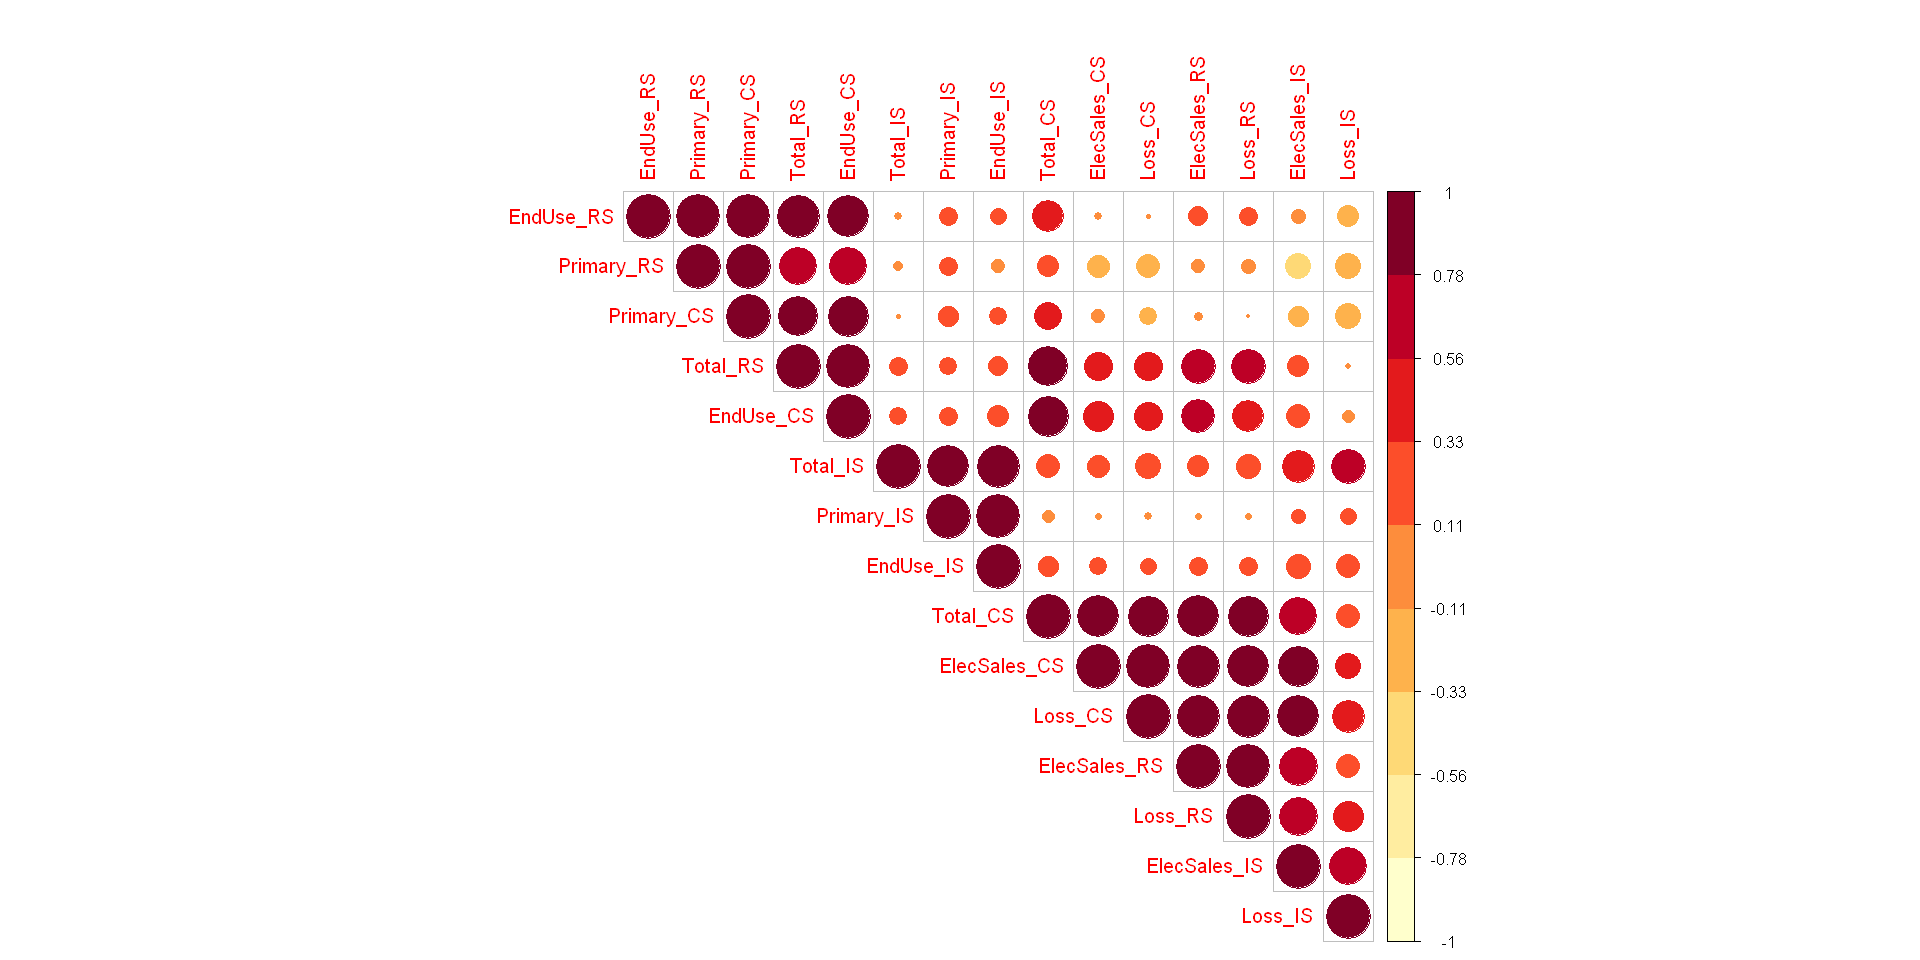

In [17]:
#round(cor(energy_data[,3:17]),2)
#ggcorrplot(cor(energy_data[,3:17]),lab_size = 1.5, lab = TRUE,tl.cex=5)
corrplot(cor(energy_data[,2:16]), type="upper", order="hclust", col=brewer.pal(n=9, name="YlOrRd"))



#### Histogram and Box plot of GDP



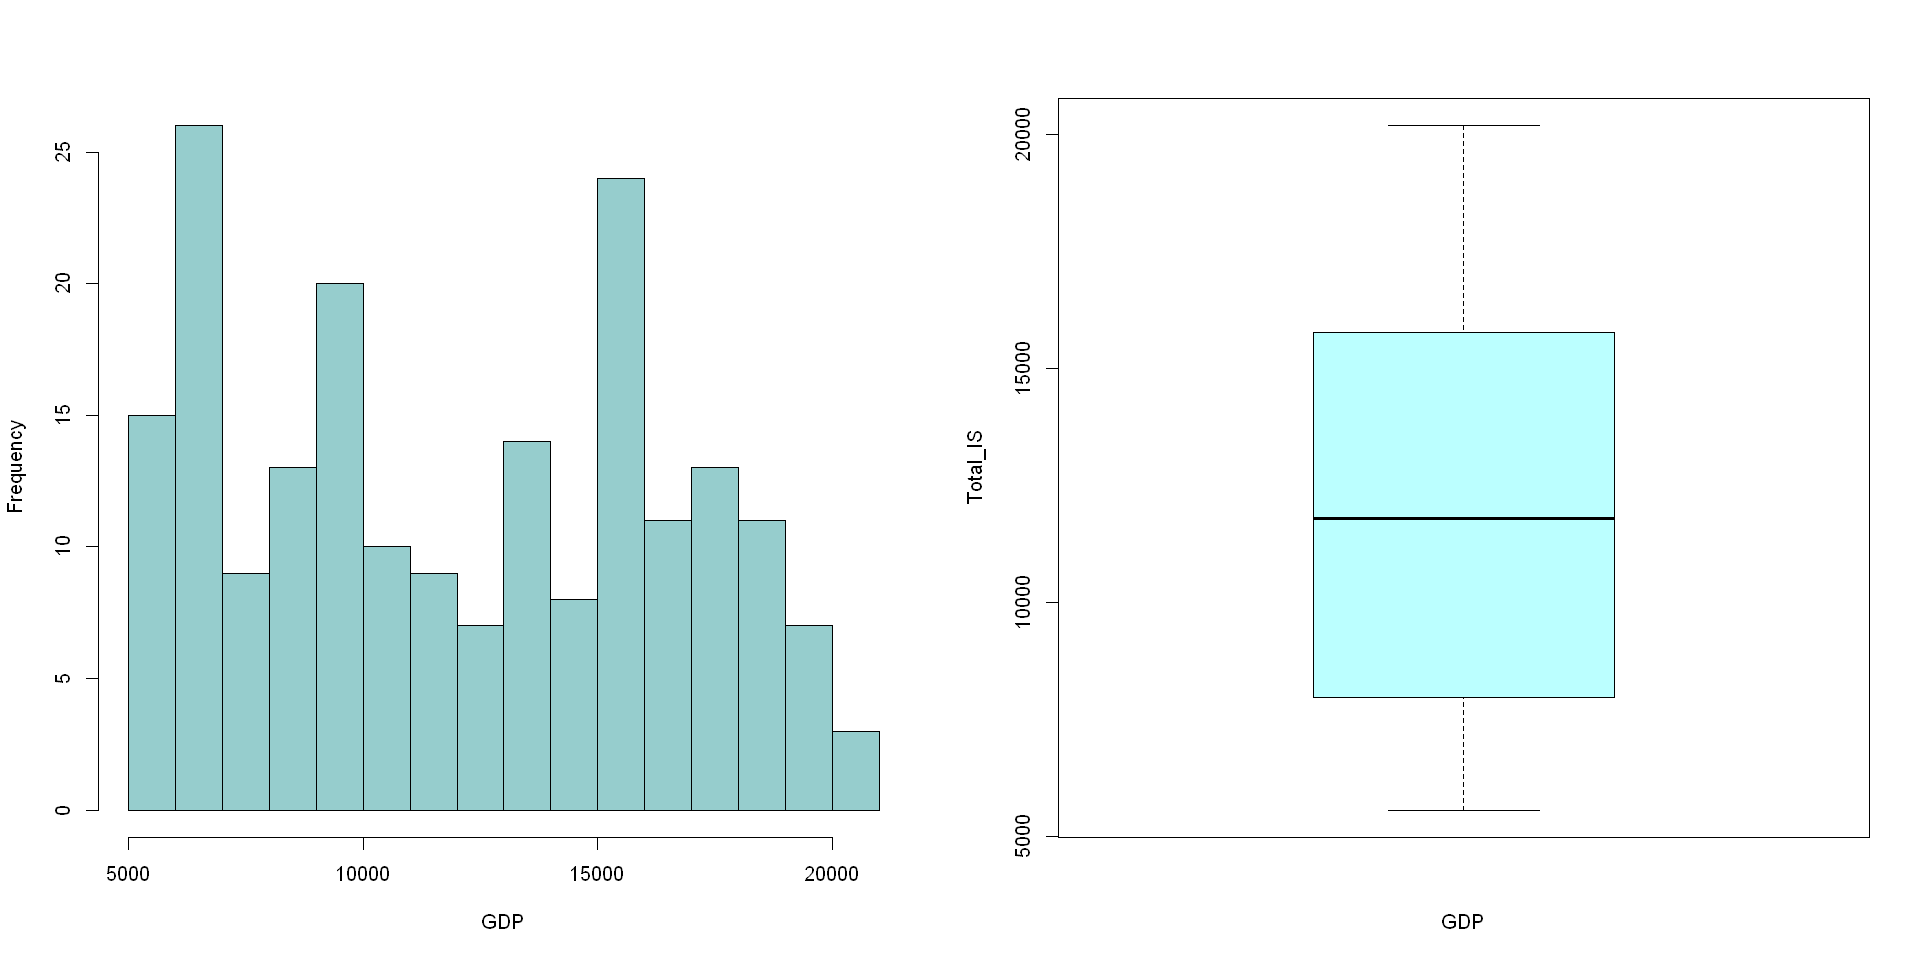

In [18]:
# histogram and boxplot of GDP data
par(mfrow=c(1,2))
hist(gdp_data[,2], xlab= "GDP", col='paleturquoise3', breaks=12,main=NULL)
boxplot(gdp_data[,2], xlab= "GDP",ylab= name_i,col='paleturquoise1' )



#### Set colors



In [19]:
col1= "springgreen4"
col2= "slateblue3"
col3= "tomato1"
col4= 'paleturquoise3'



### Plots

#### Plots - log transformed

##### Primary



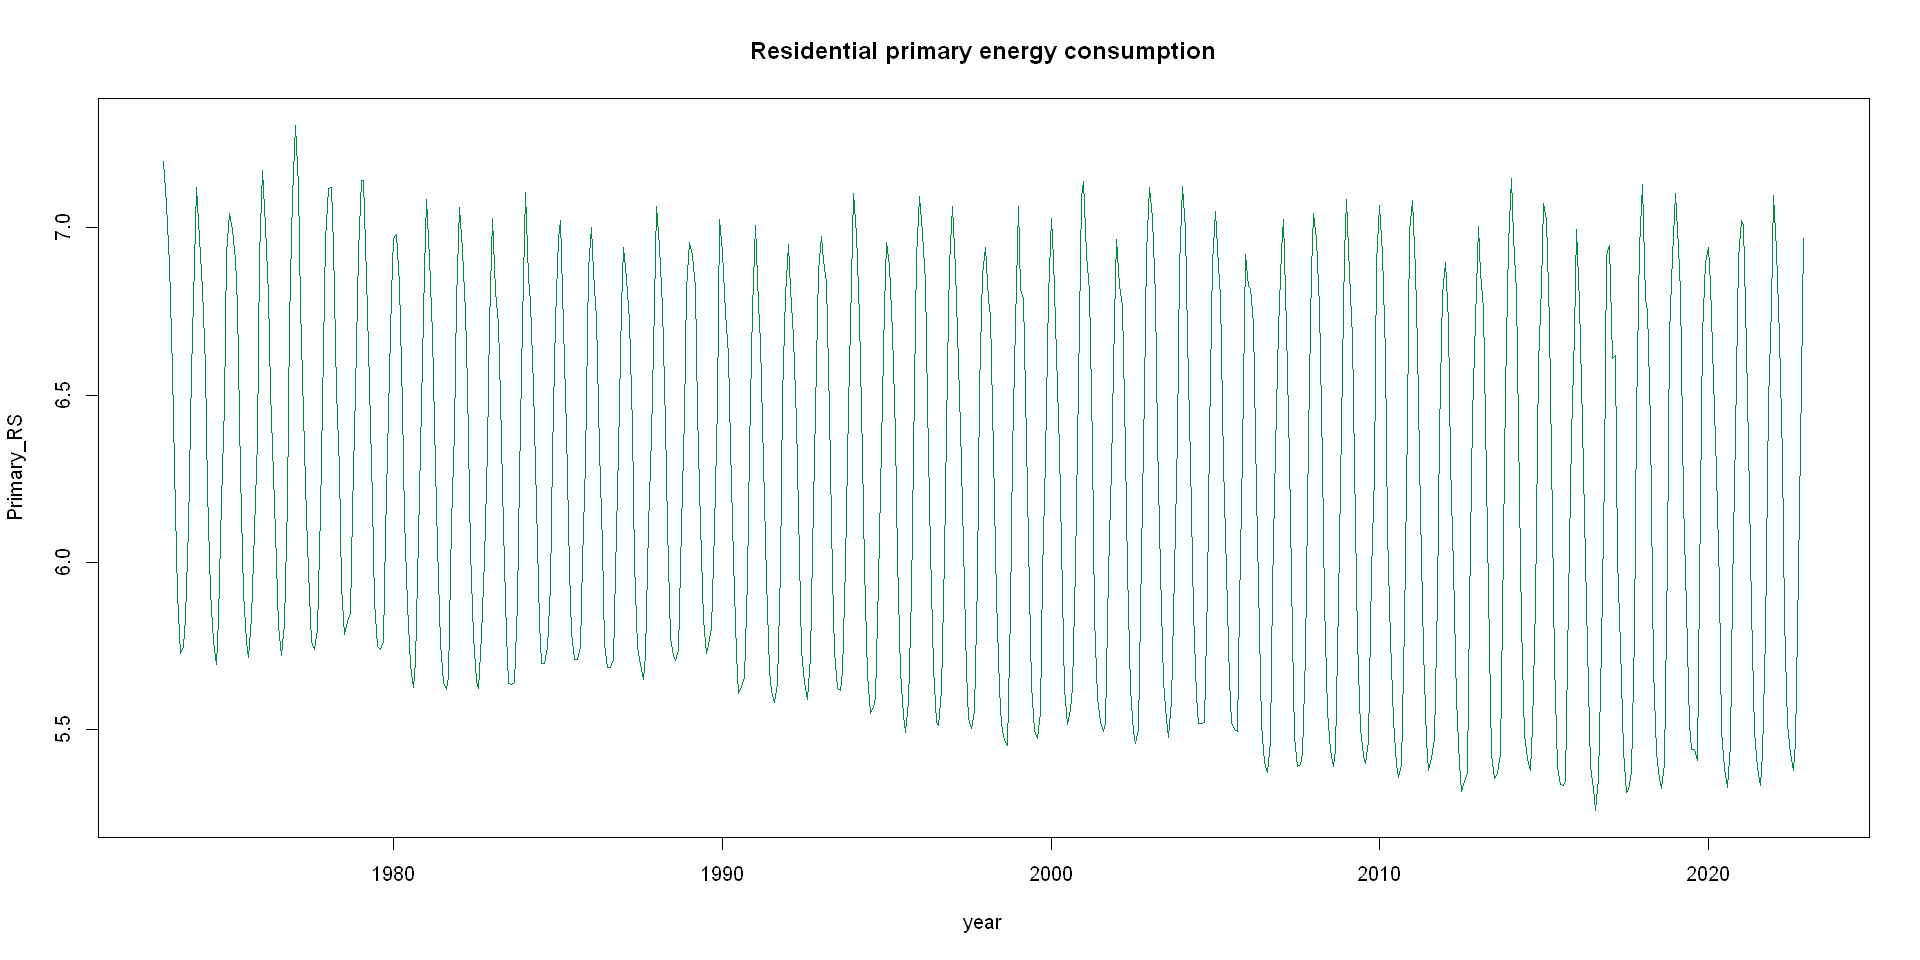

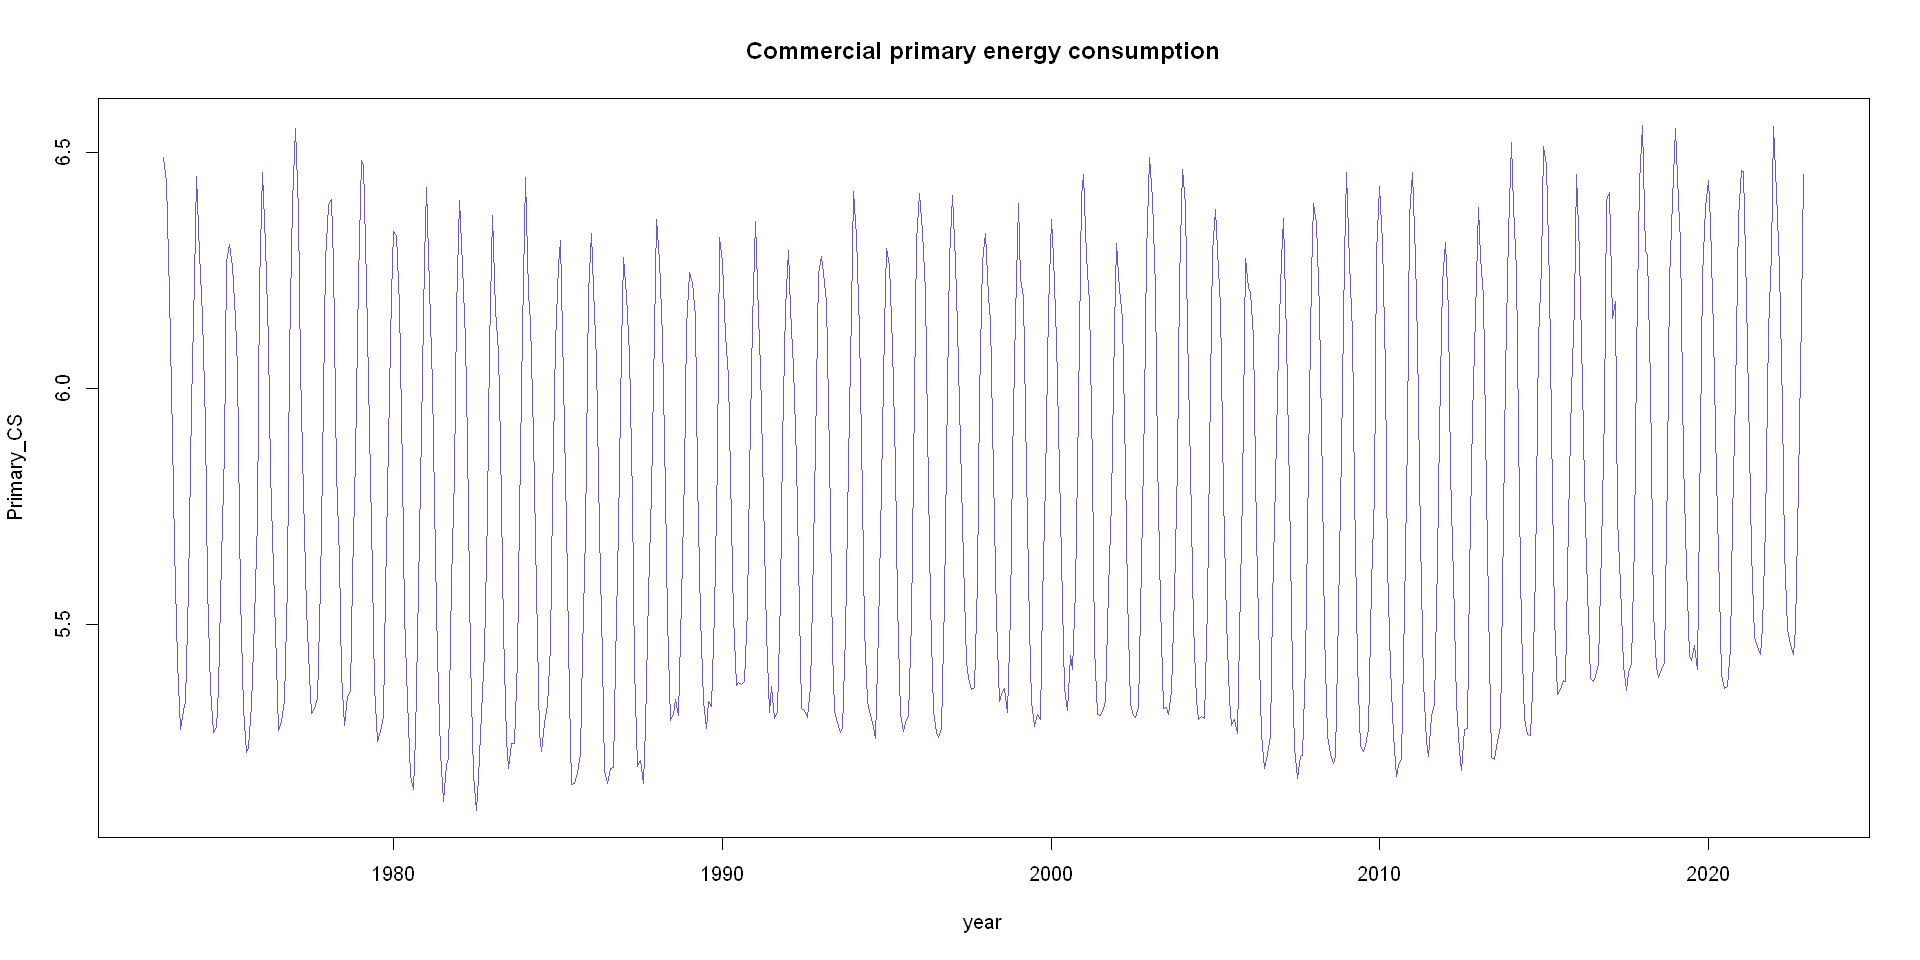

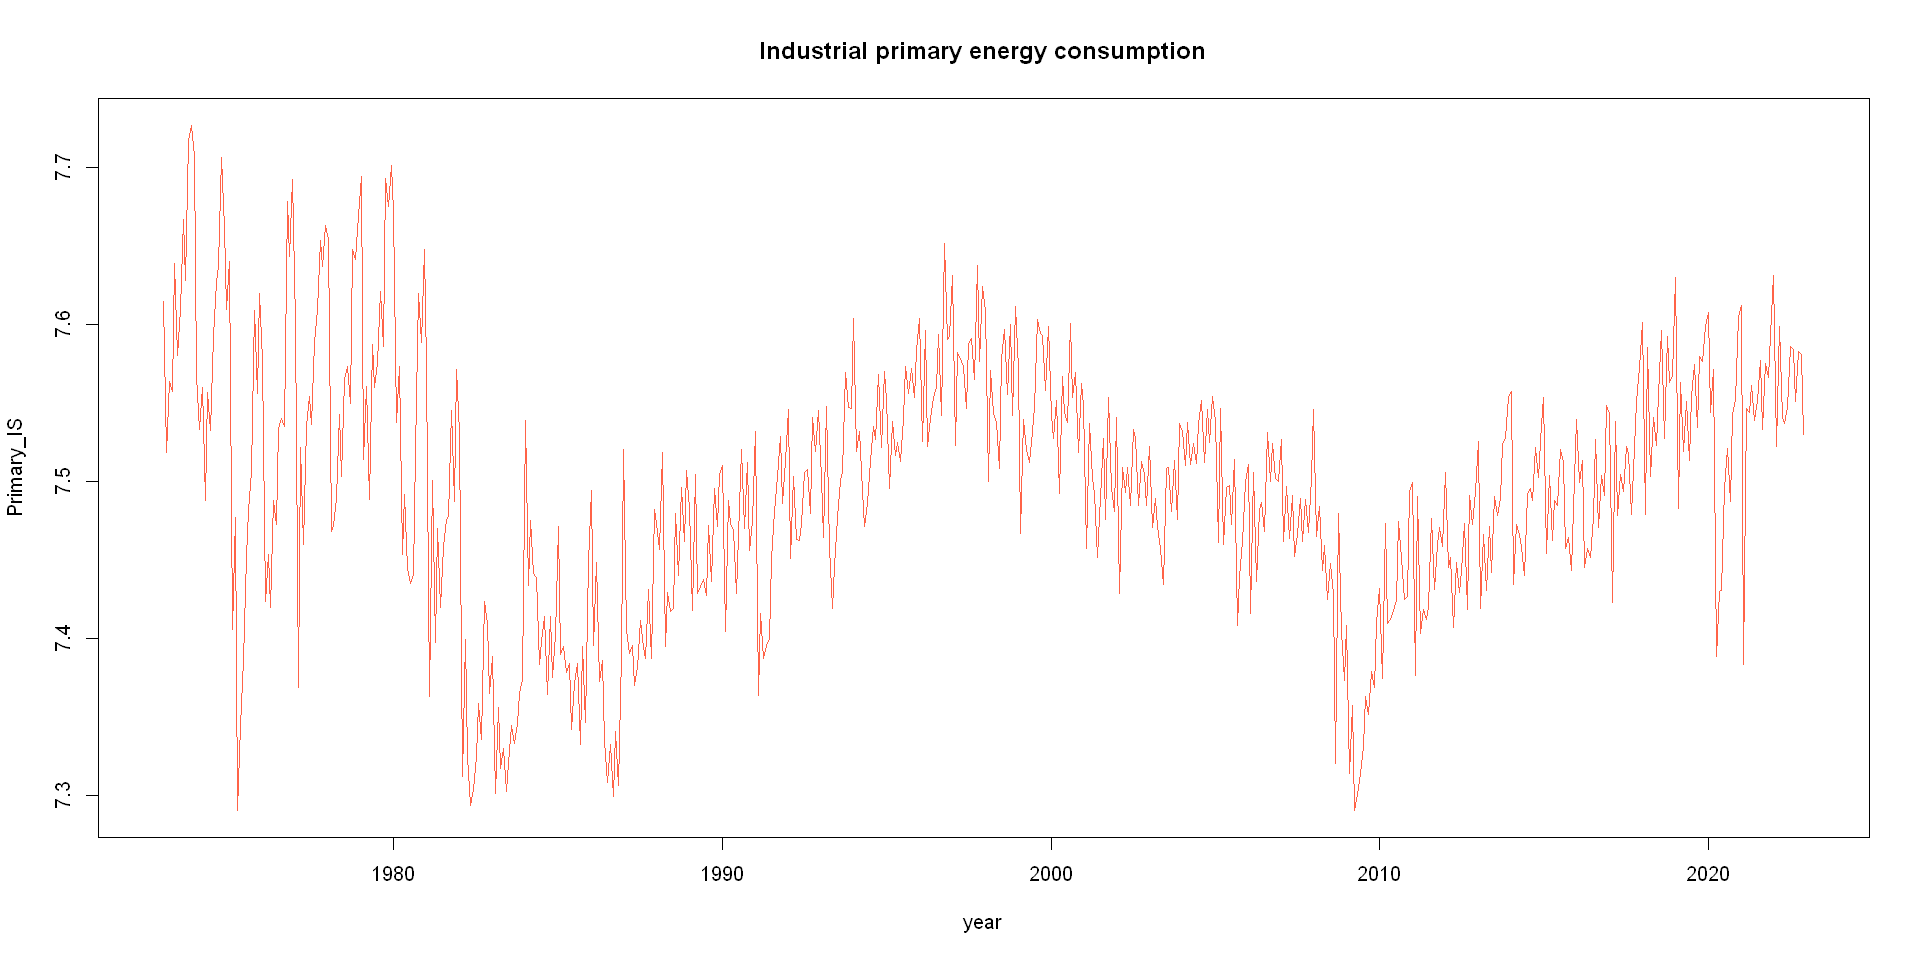

In [20]:
# plot primary energy time series
ts.plot(Primary_RS.ts,xlab="year",ylab="Primary_RS", main="Residential primary energy consumption",col=col1)
ts.plot(Primary_CS.ts,xlab="year",ylab="Primary_CS",main="Commercial primary energy consumption", col=col2)
ts.plot(Primary_IS.ts,xlab="year",ylab="Primary_IS", main="Industrial primary energy consumption", col=col3)



##### Sales



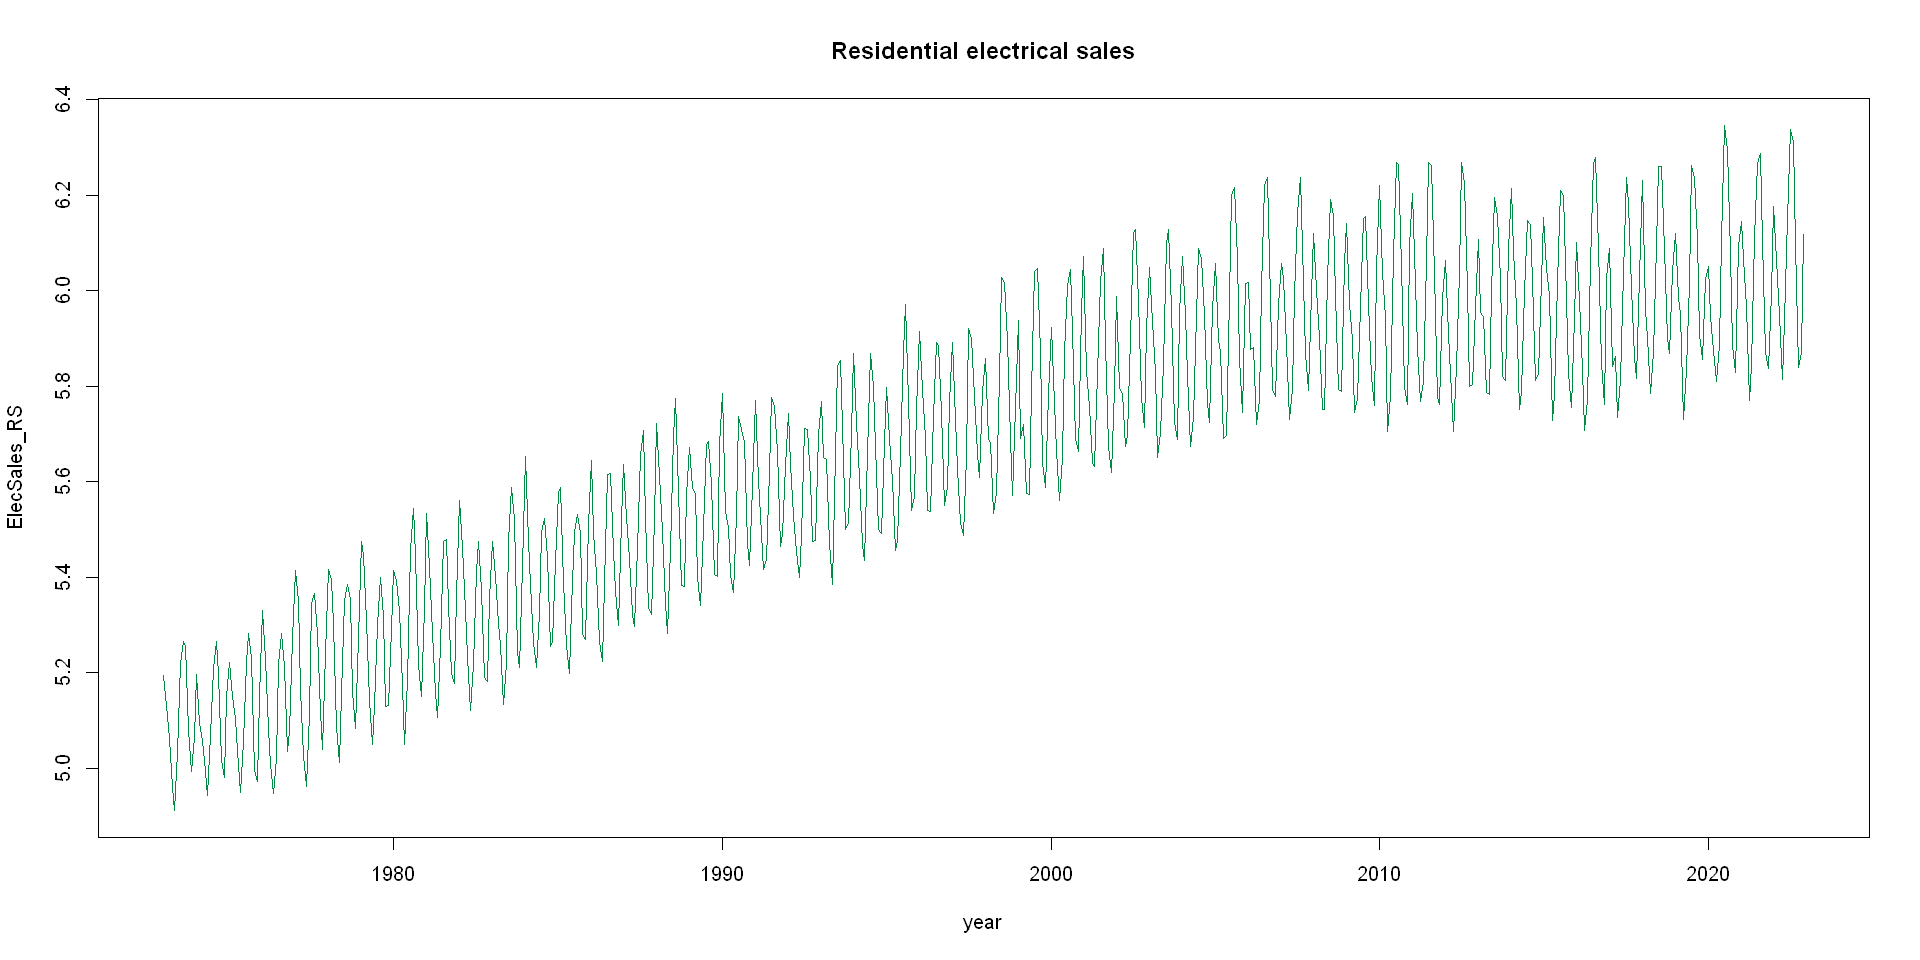

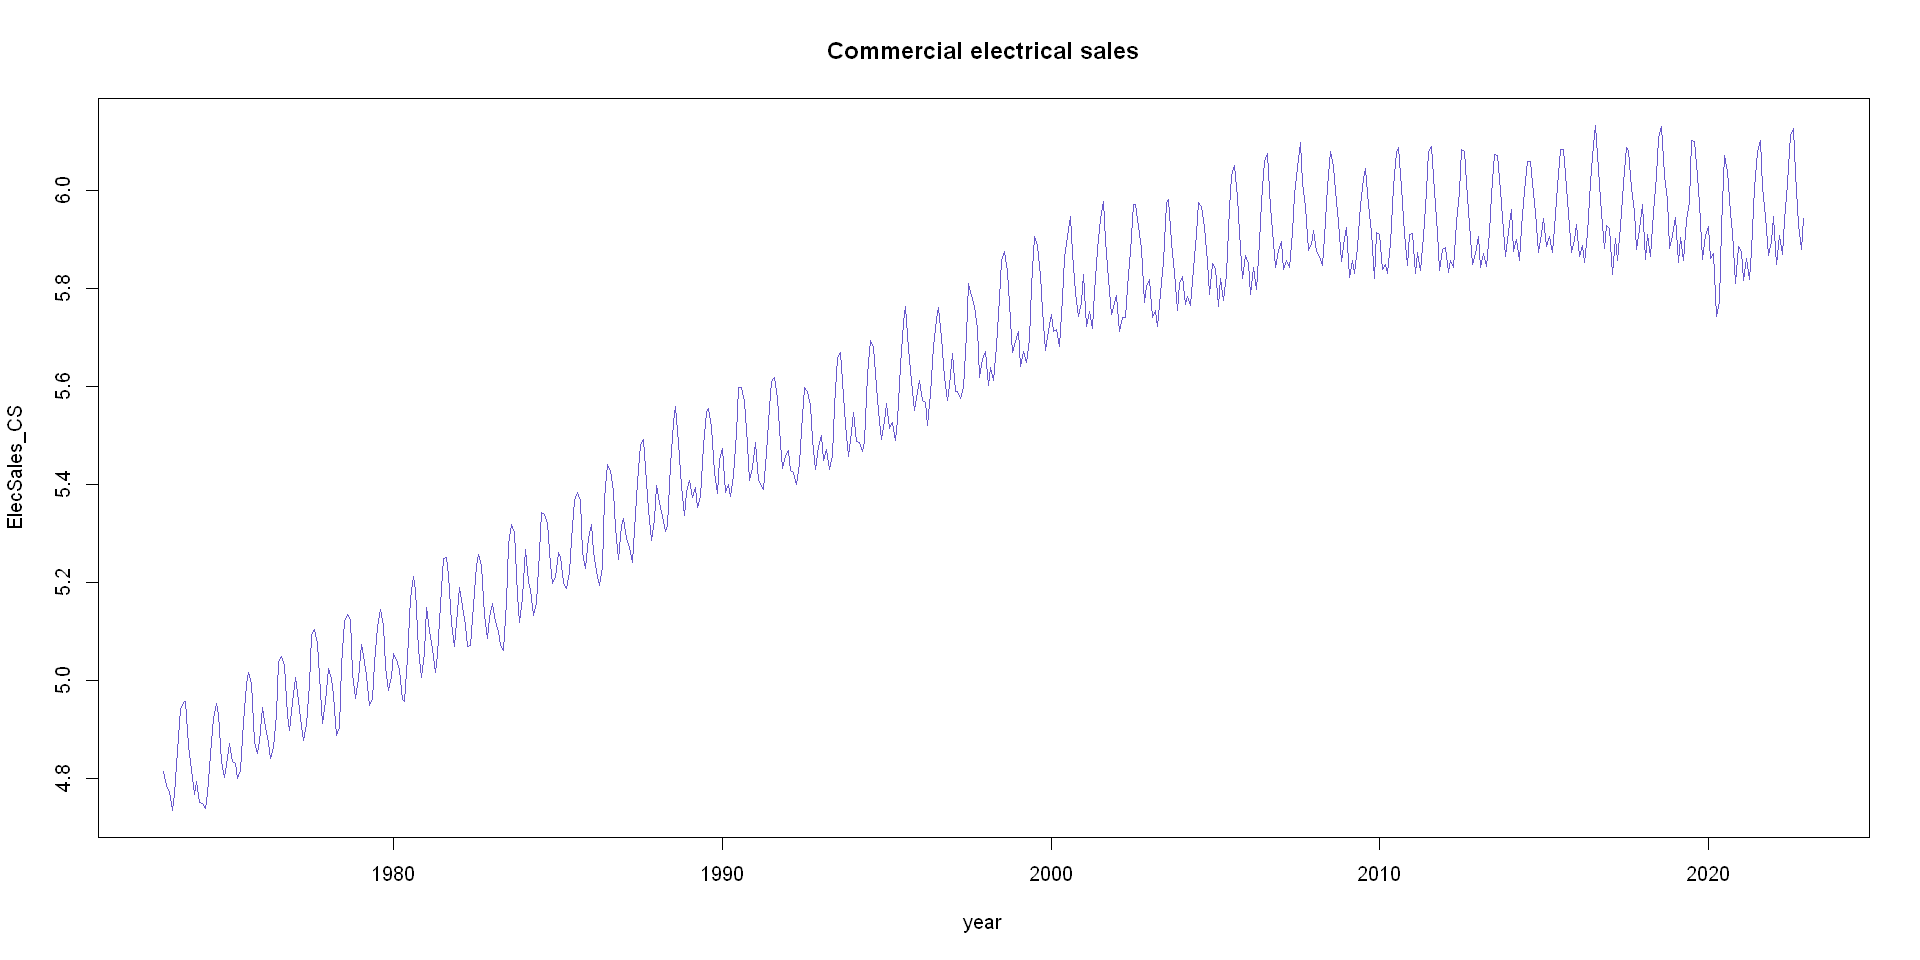

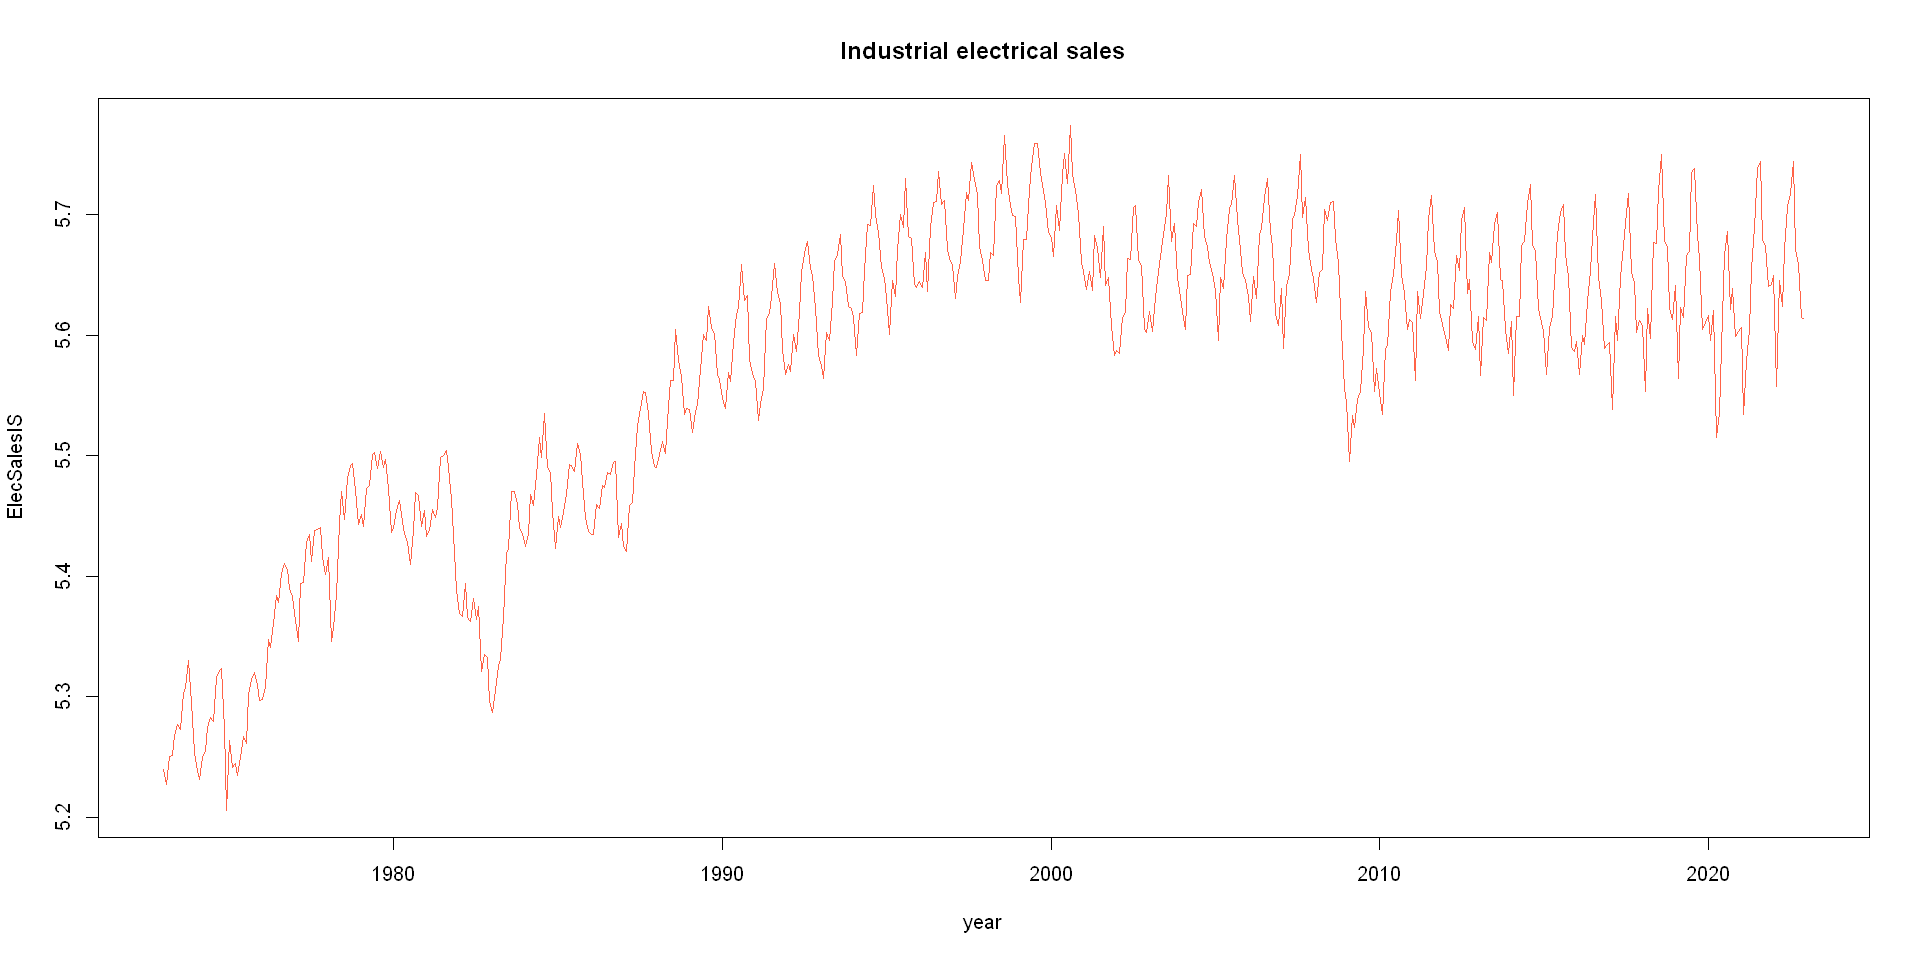

In [21]:
# plot electrical sales time series
ts.plot(ElecSales_RS.ts, xlab="year", ylab="ElecSales_RS", main="Residential electrical sales",col=col1)
ts.plot(ElecSales_CS.ts,xlab="year",ylab="ElecSales_CS" , main="Commercial electrical sales", col=col2)
ts.plot(ElecSales_IS.ts,xlab="year",ylab="ElecSalesIS", main="Industrial electrical sales", col=col3)



##### End use



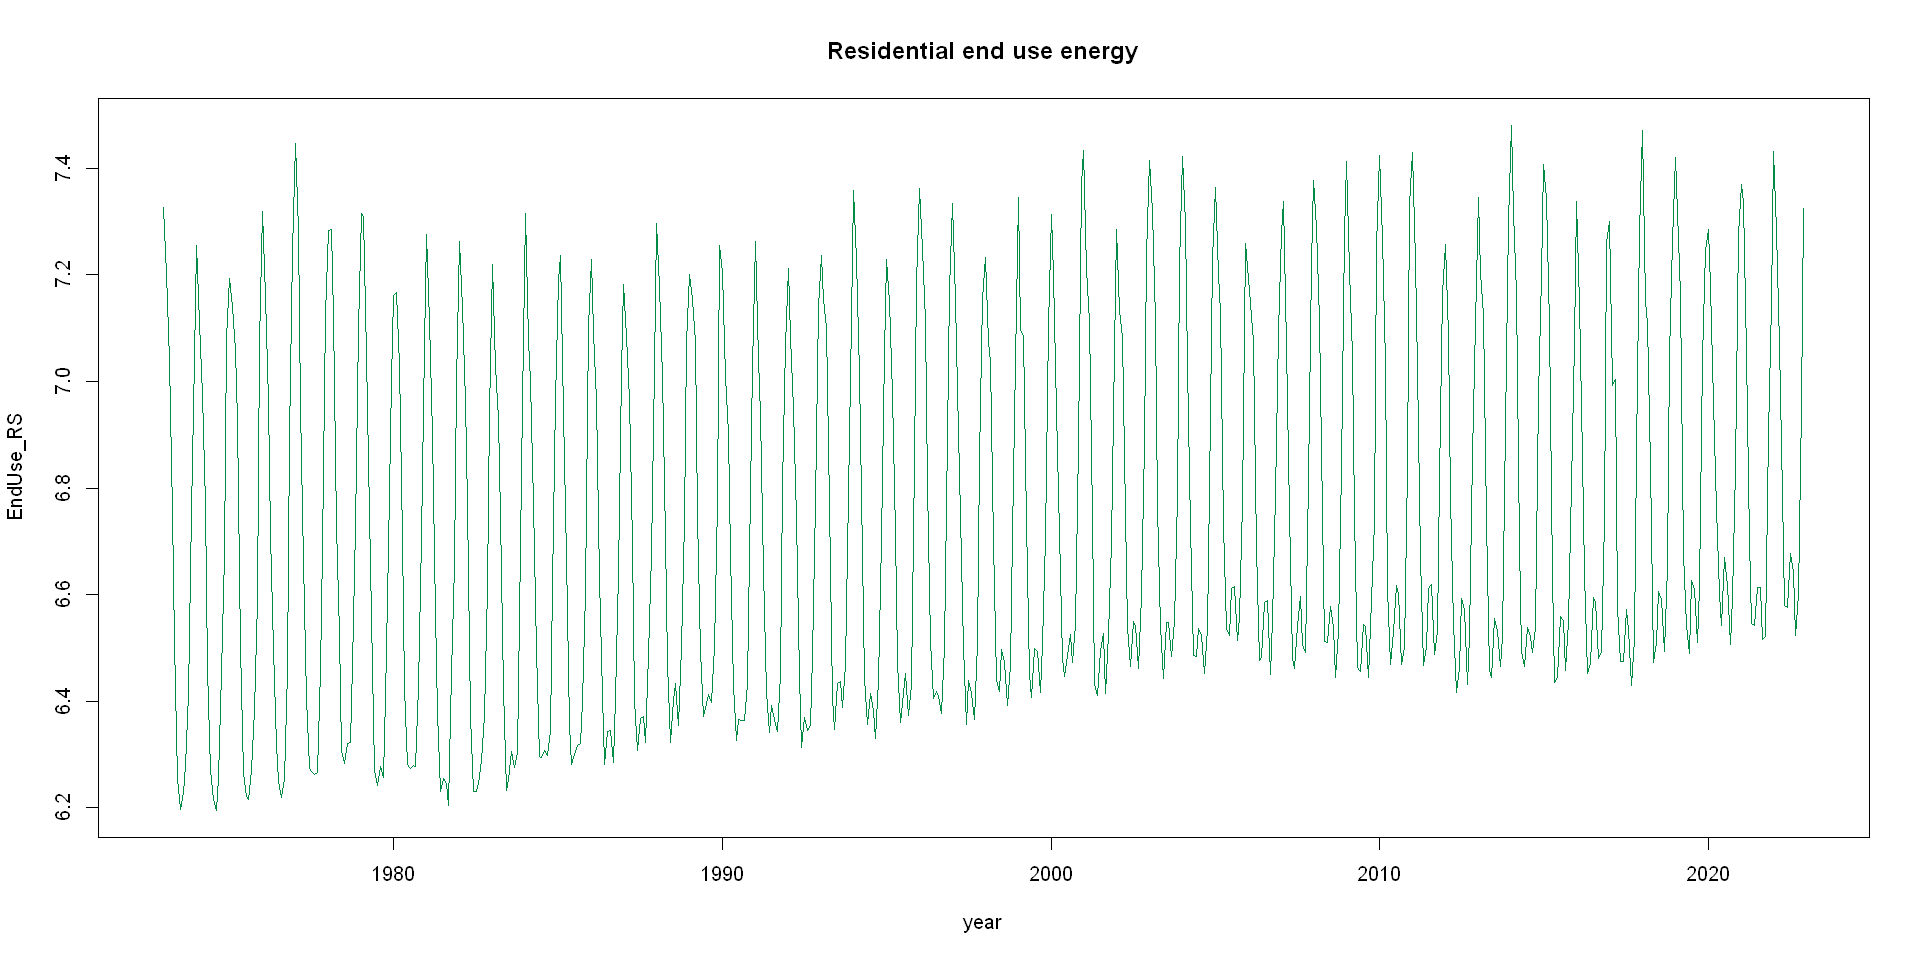

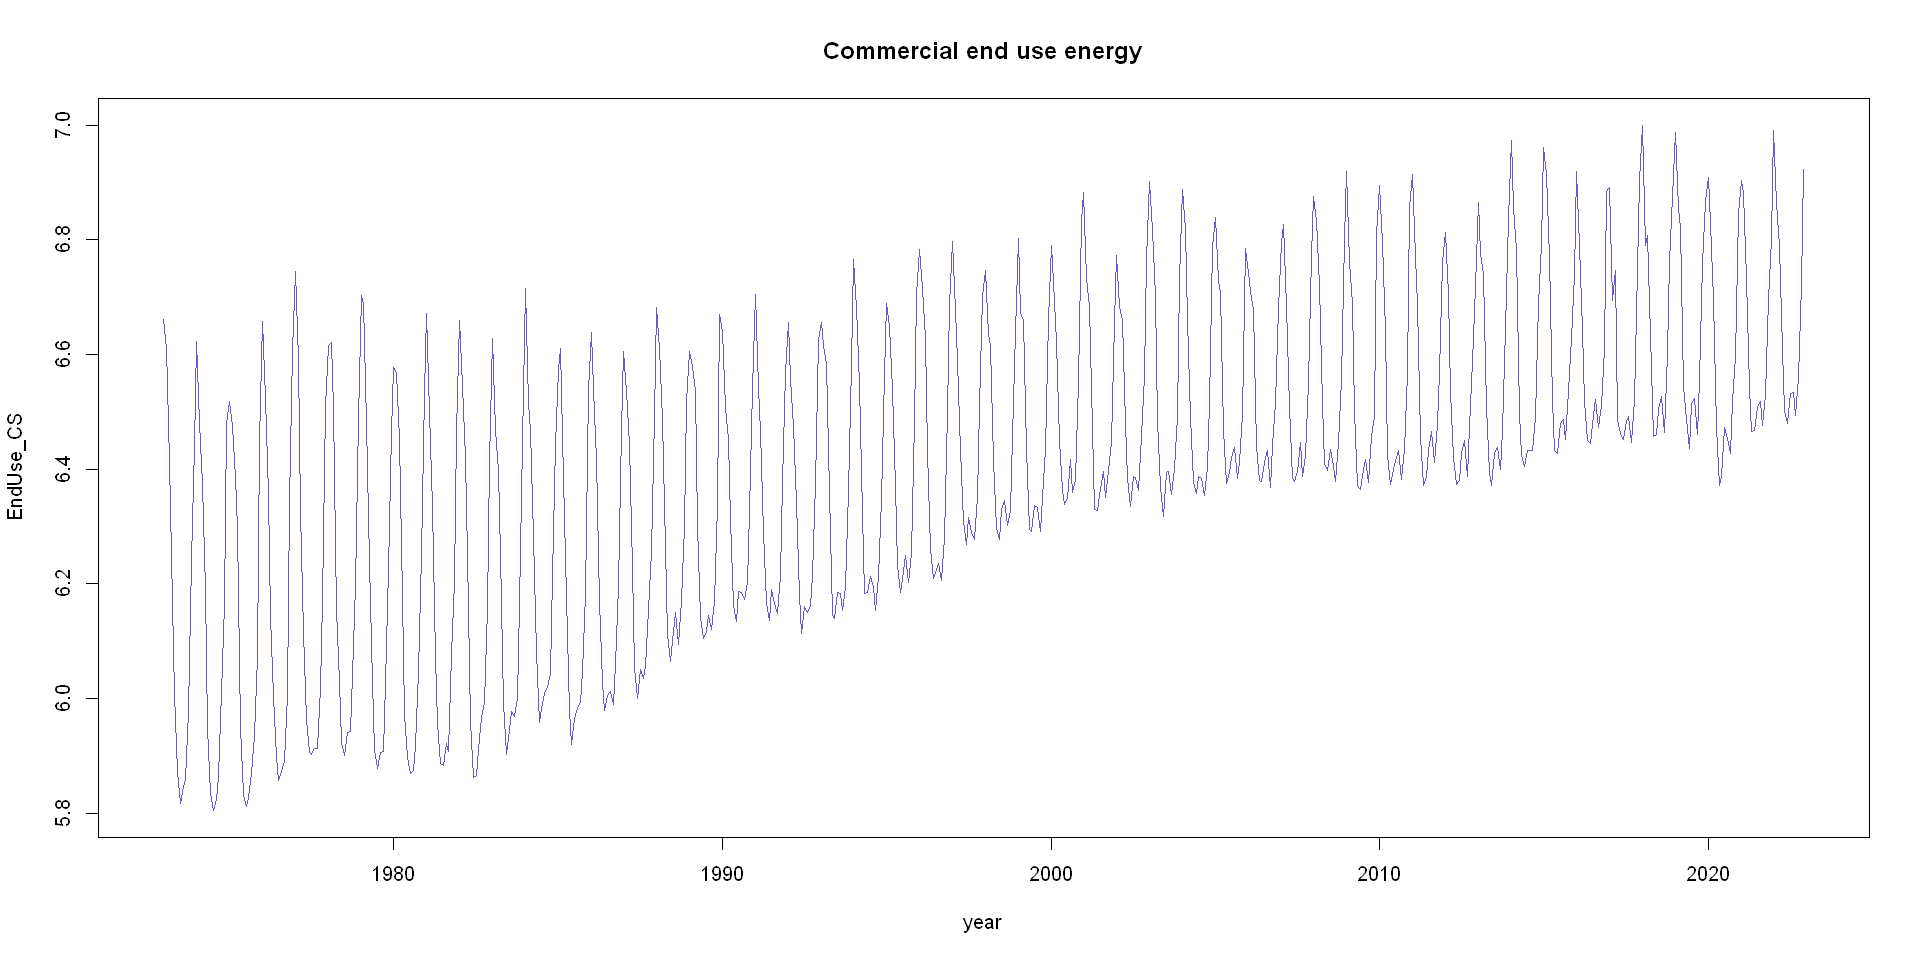

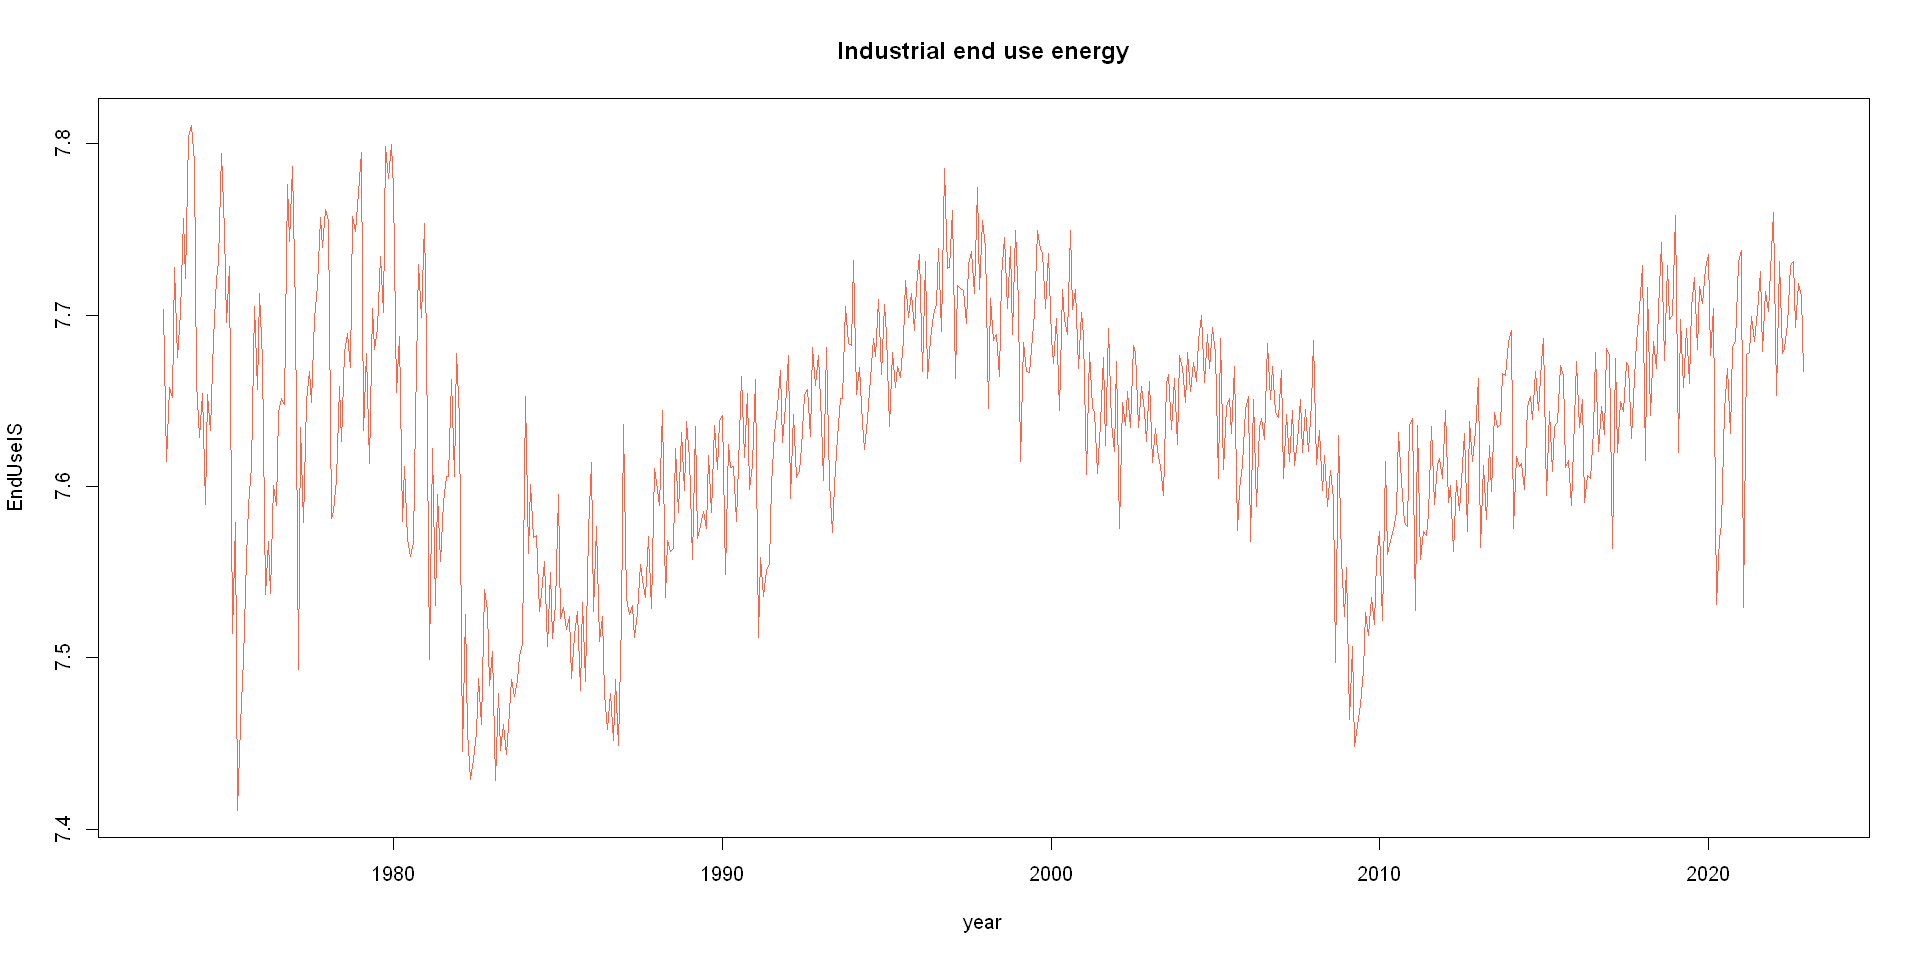

In [22]:
# plot end use energy time series

ts.plot(EndUse_RS.ts, xlab="year", ylab="EndUse_RS", main="Residential end use energy",col=col1)
ts.plot(EndUse_CS.ts,xlab="year",ylab="EndUse_CS" , main="Commercial end use energy", col=col2)
ts.plot(EndUse_IS.ts,xlab="year",ylab="EndUseIS", main="Industrial end use energy", col=col3)



##### Energy Loss



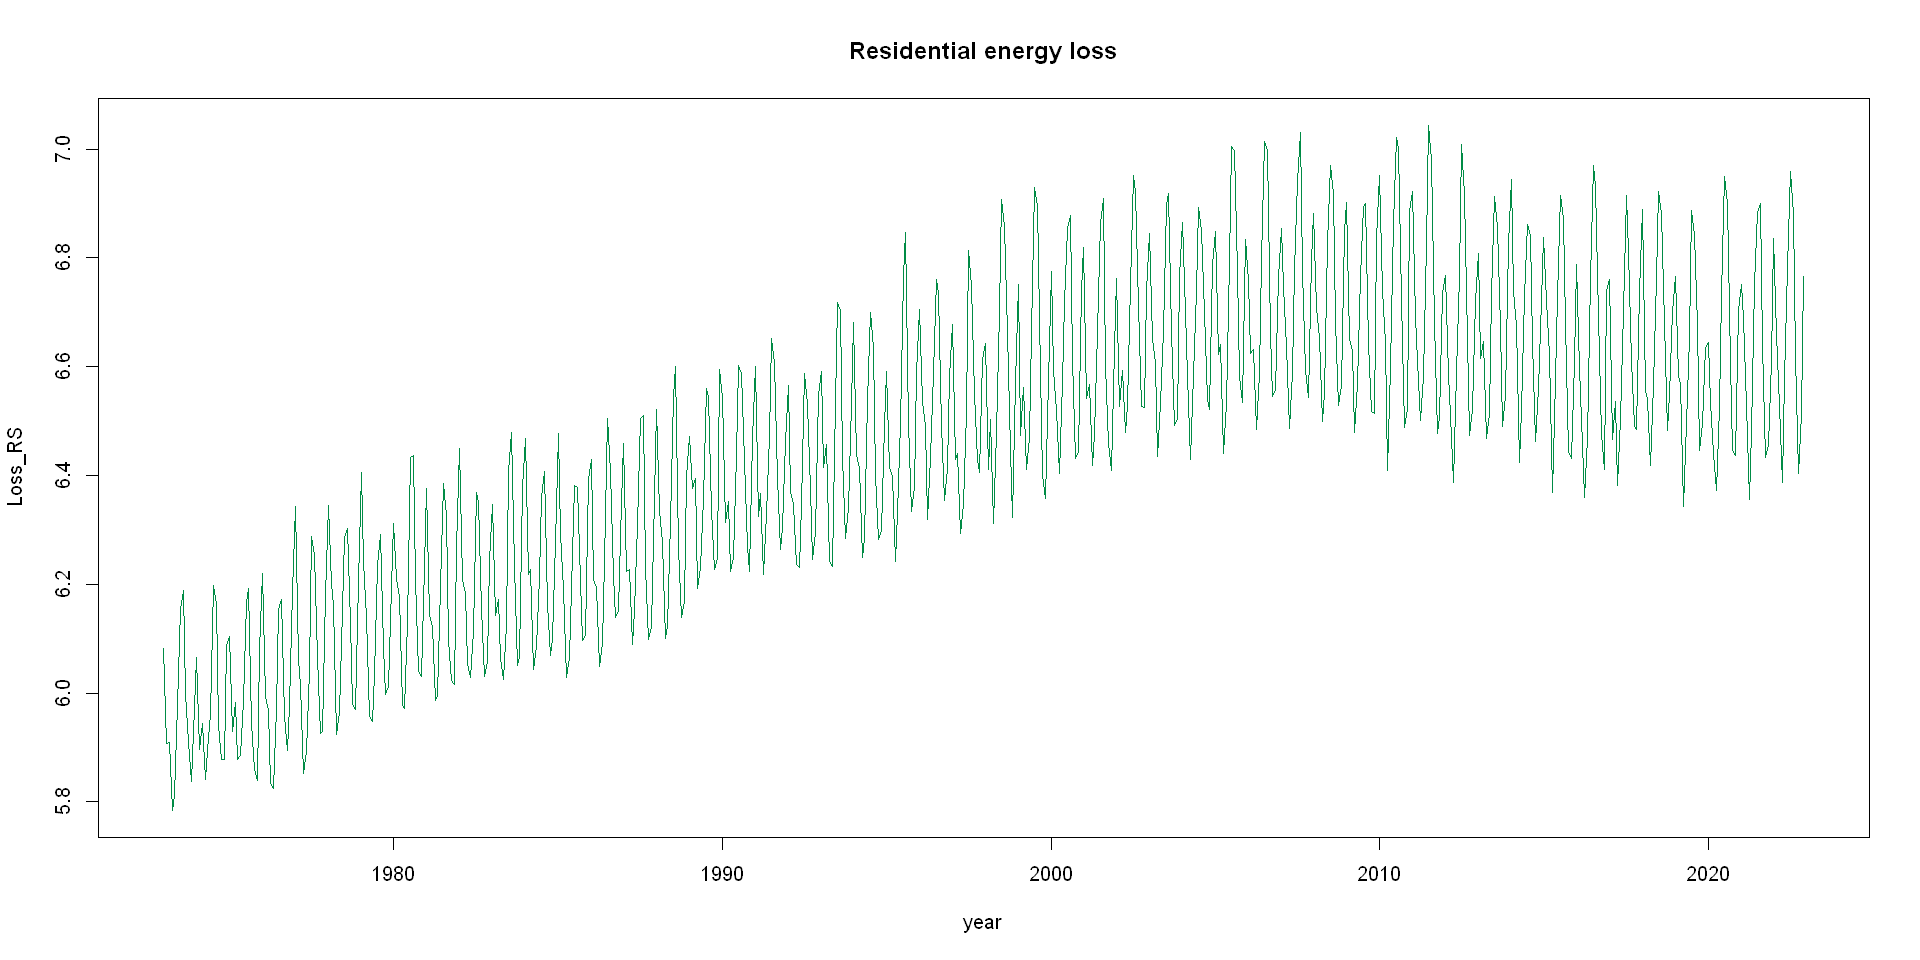

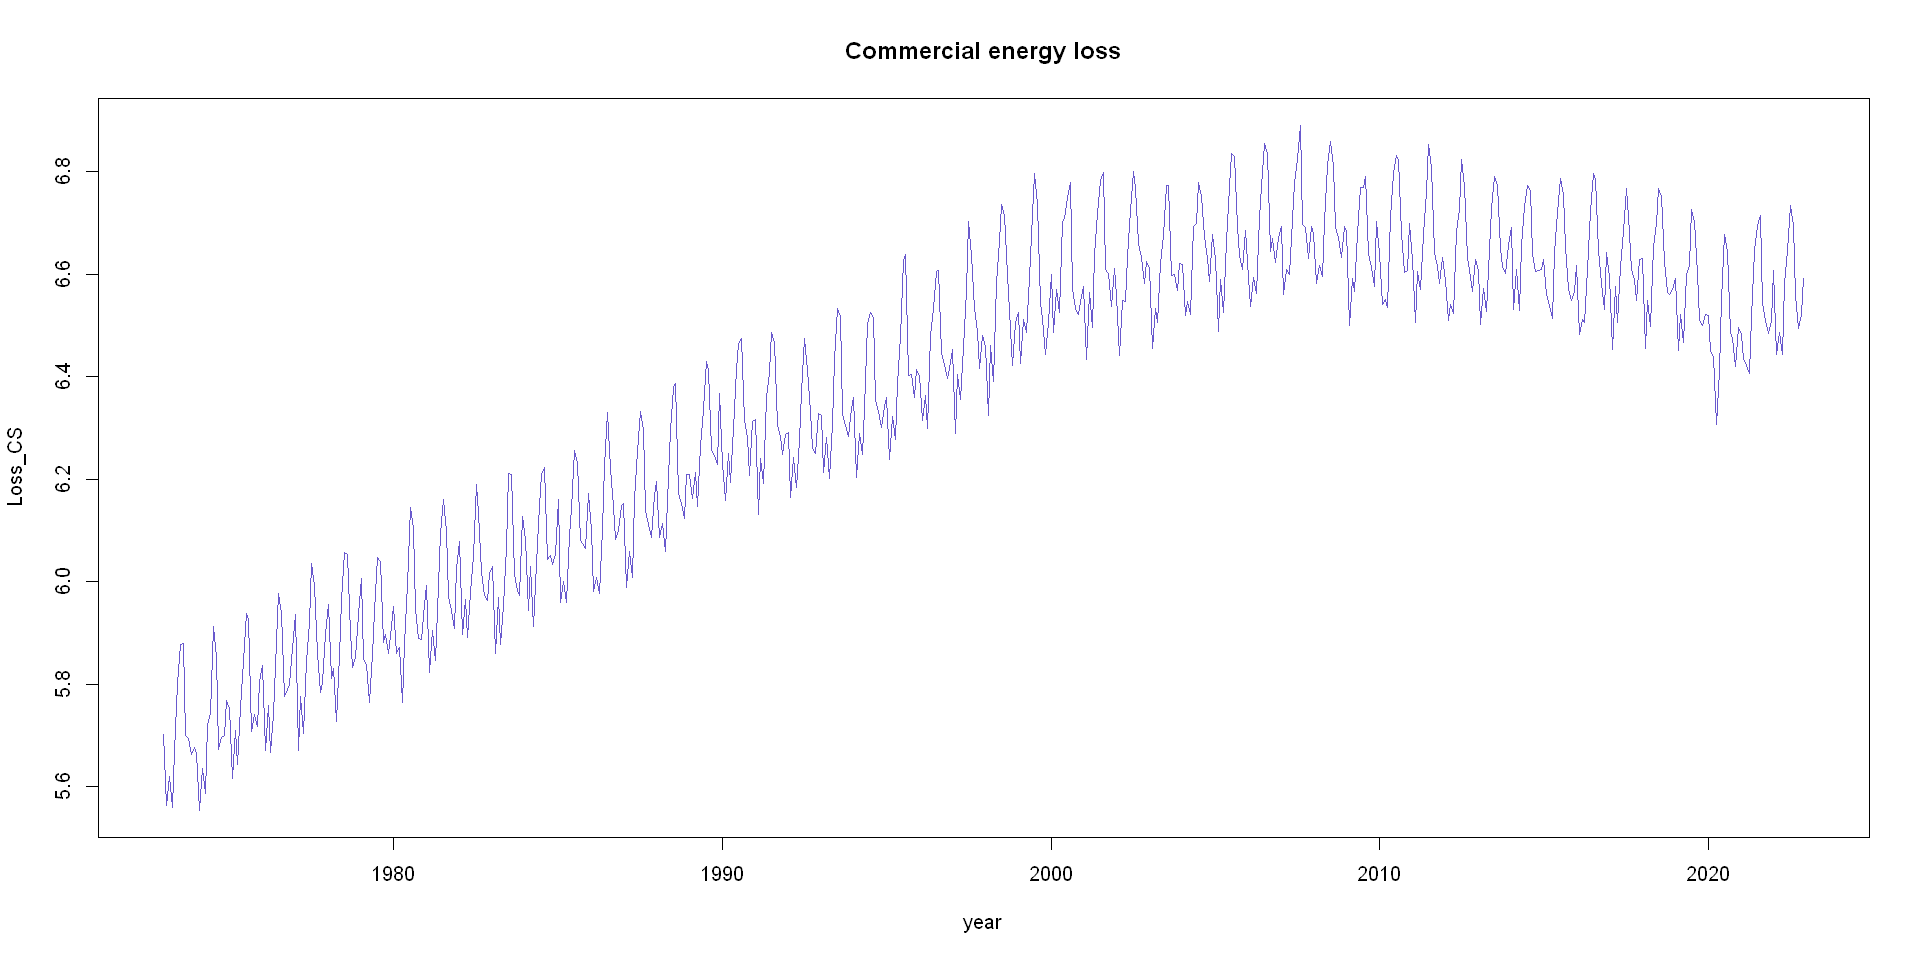

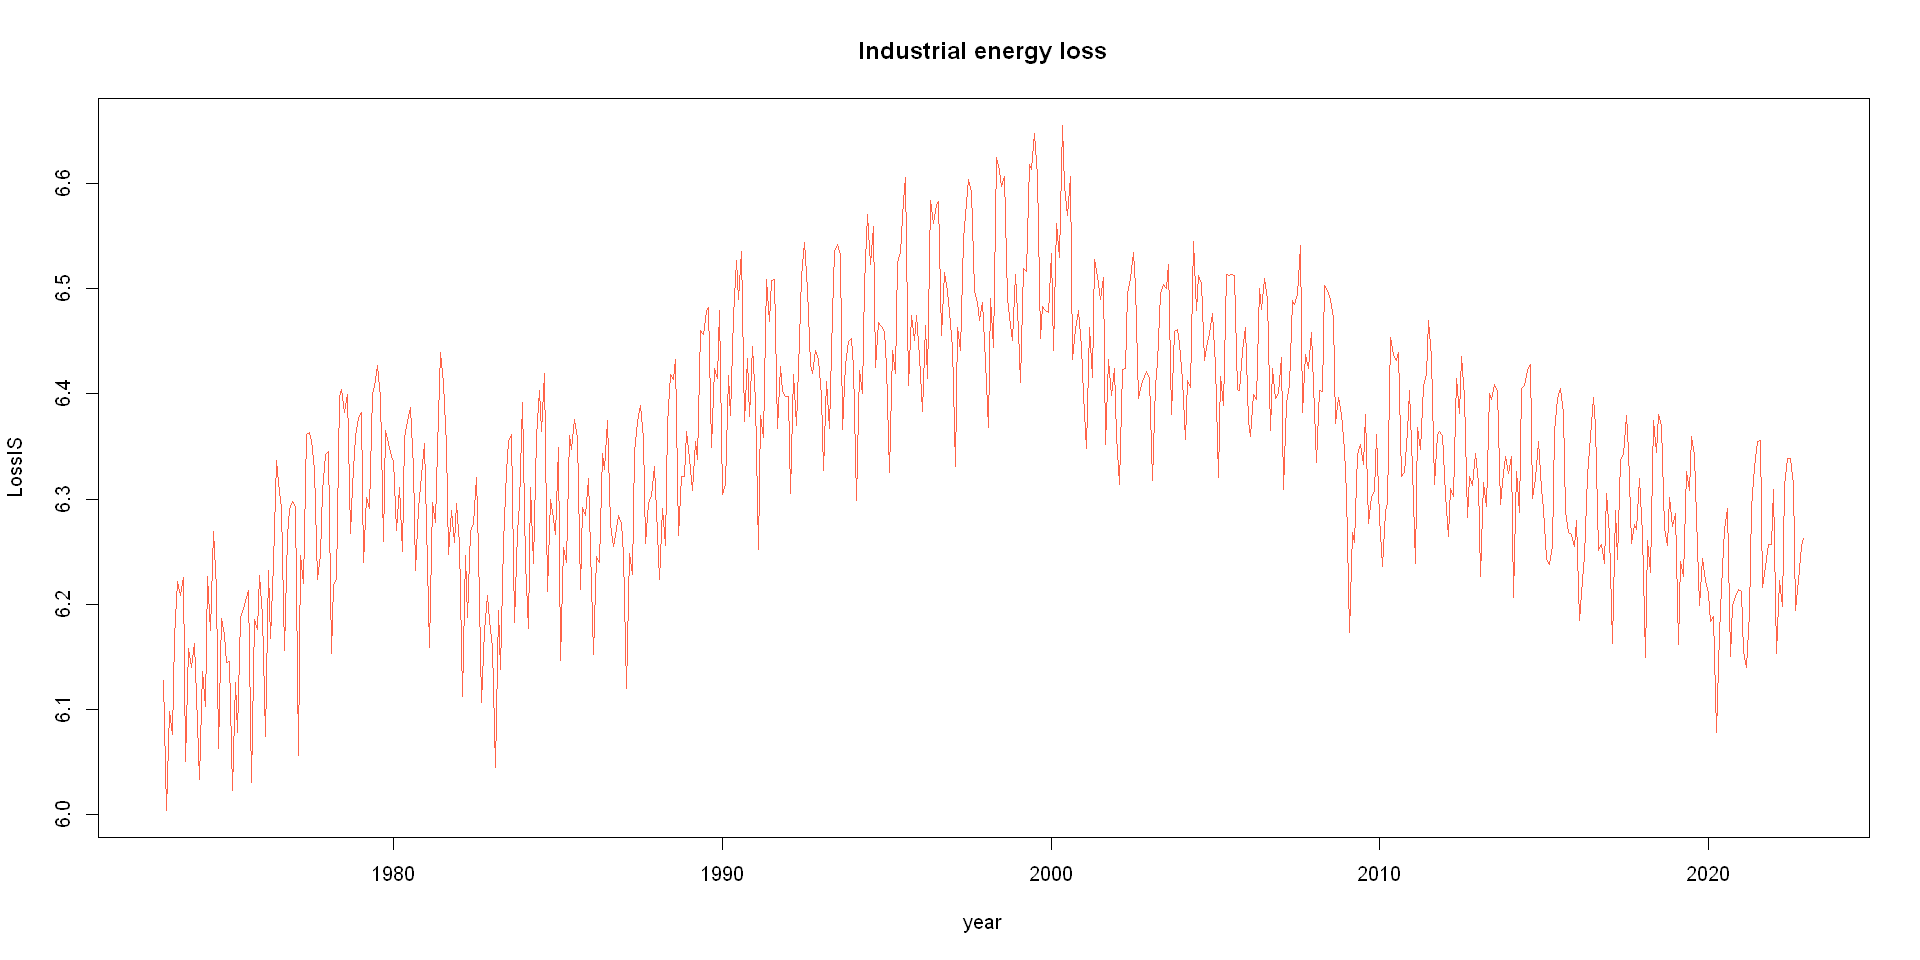

In [23]:
# plot energy loss time series

ts.plot(Loss_RS.ts, xlab="year", ylab="Loss_RS", main="Residential energy loss",col=col1)
ts.plot(Loss_CS.ts,xlab="year",ylab="Loss_CS" , main="Commercial energy loss", col=col2)
ts.plot(Loss_IS.ts,xlab="year",ylab="LossIS", main="Industrial energy loss", col=col3)



##### Total Energy



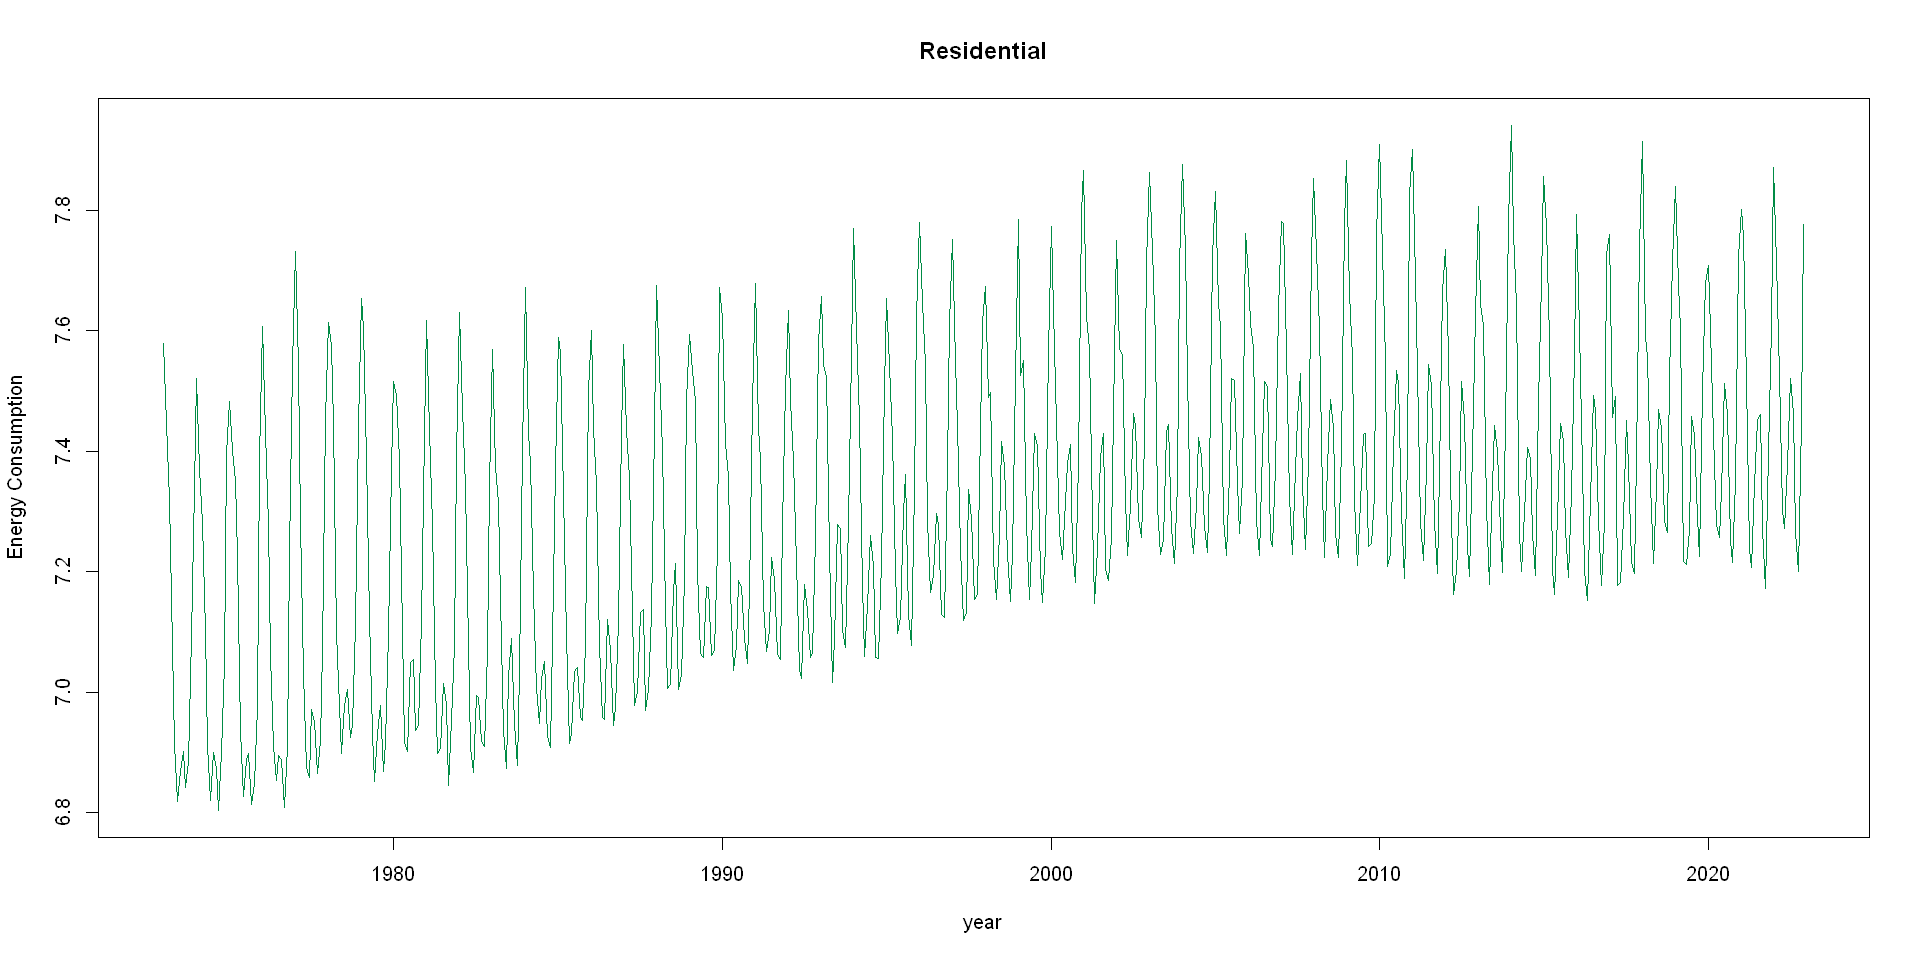

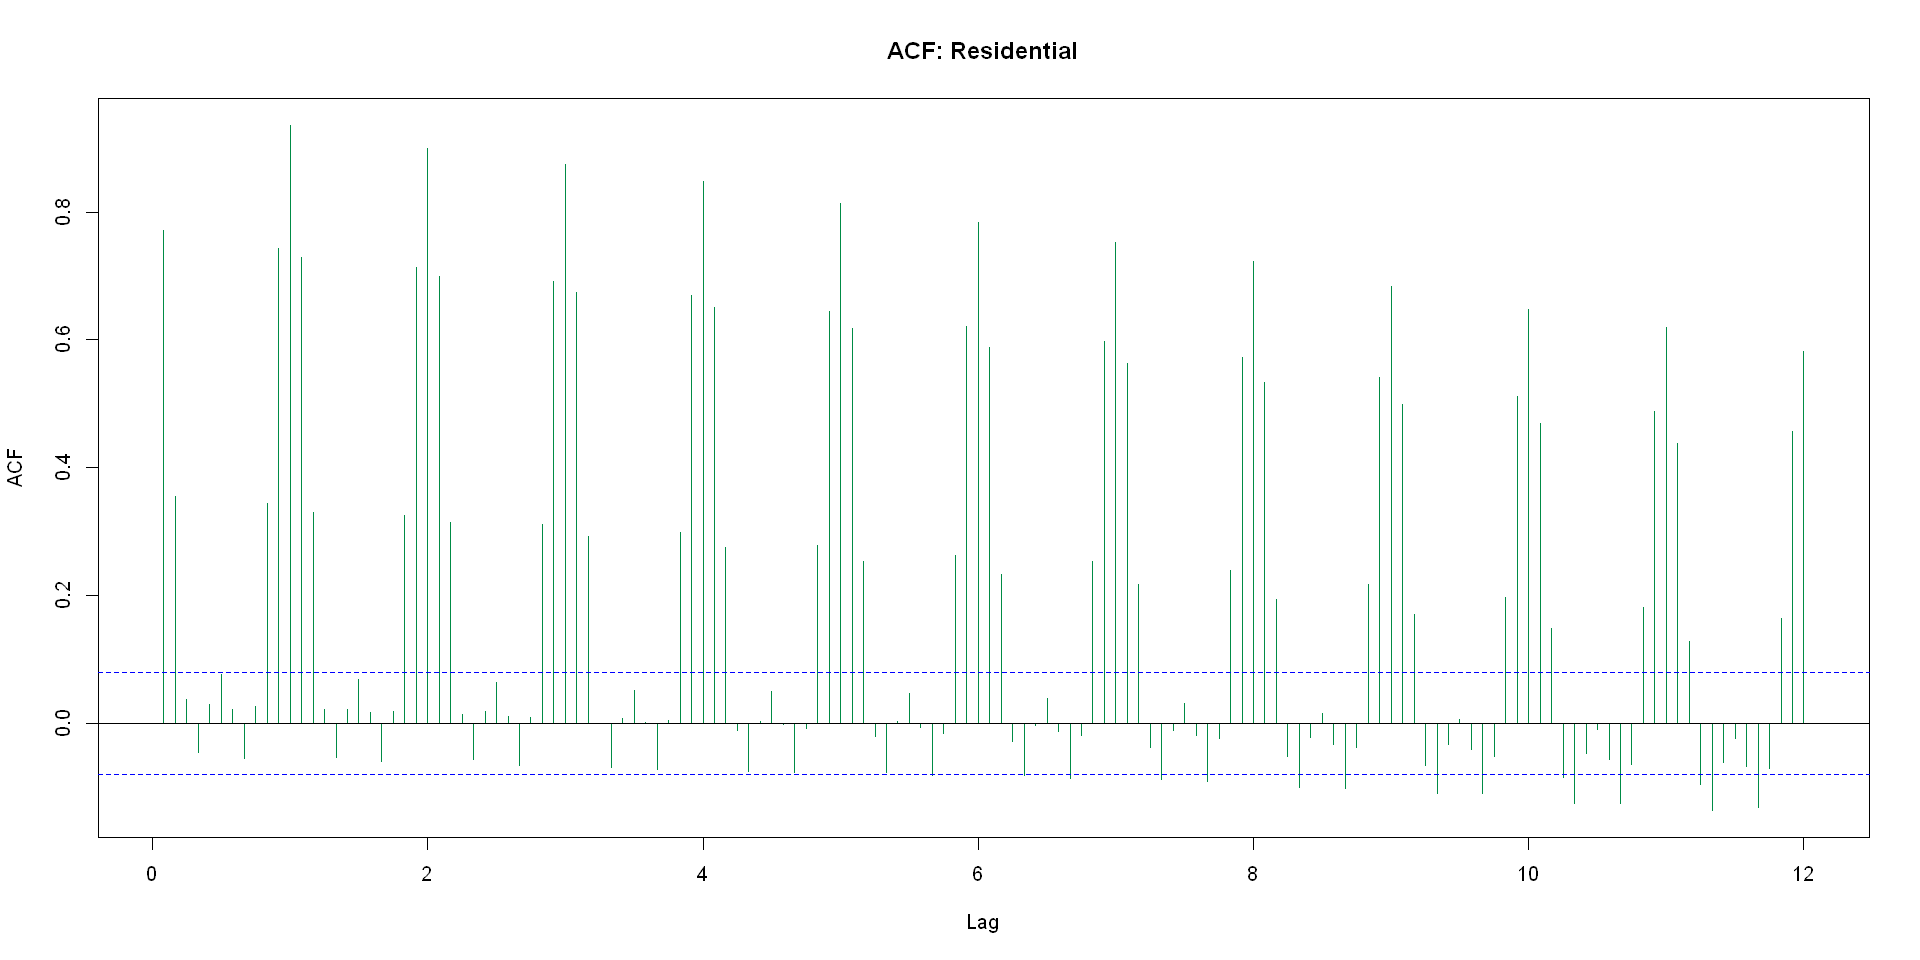

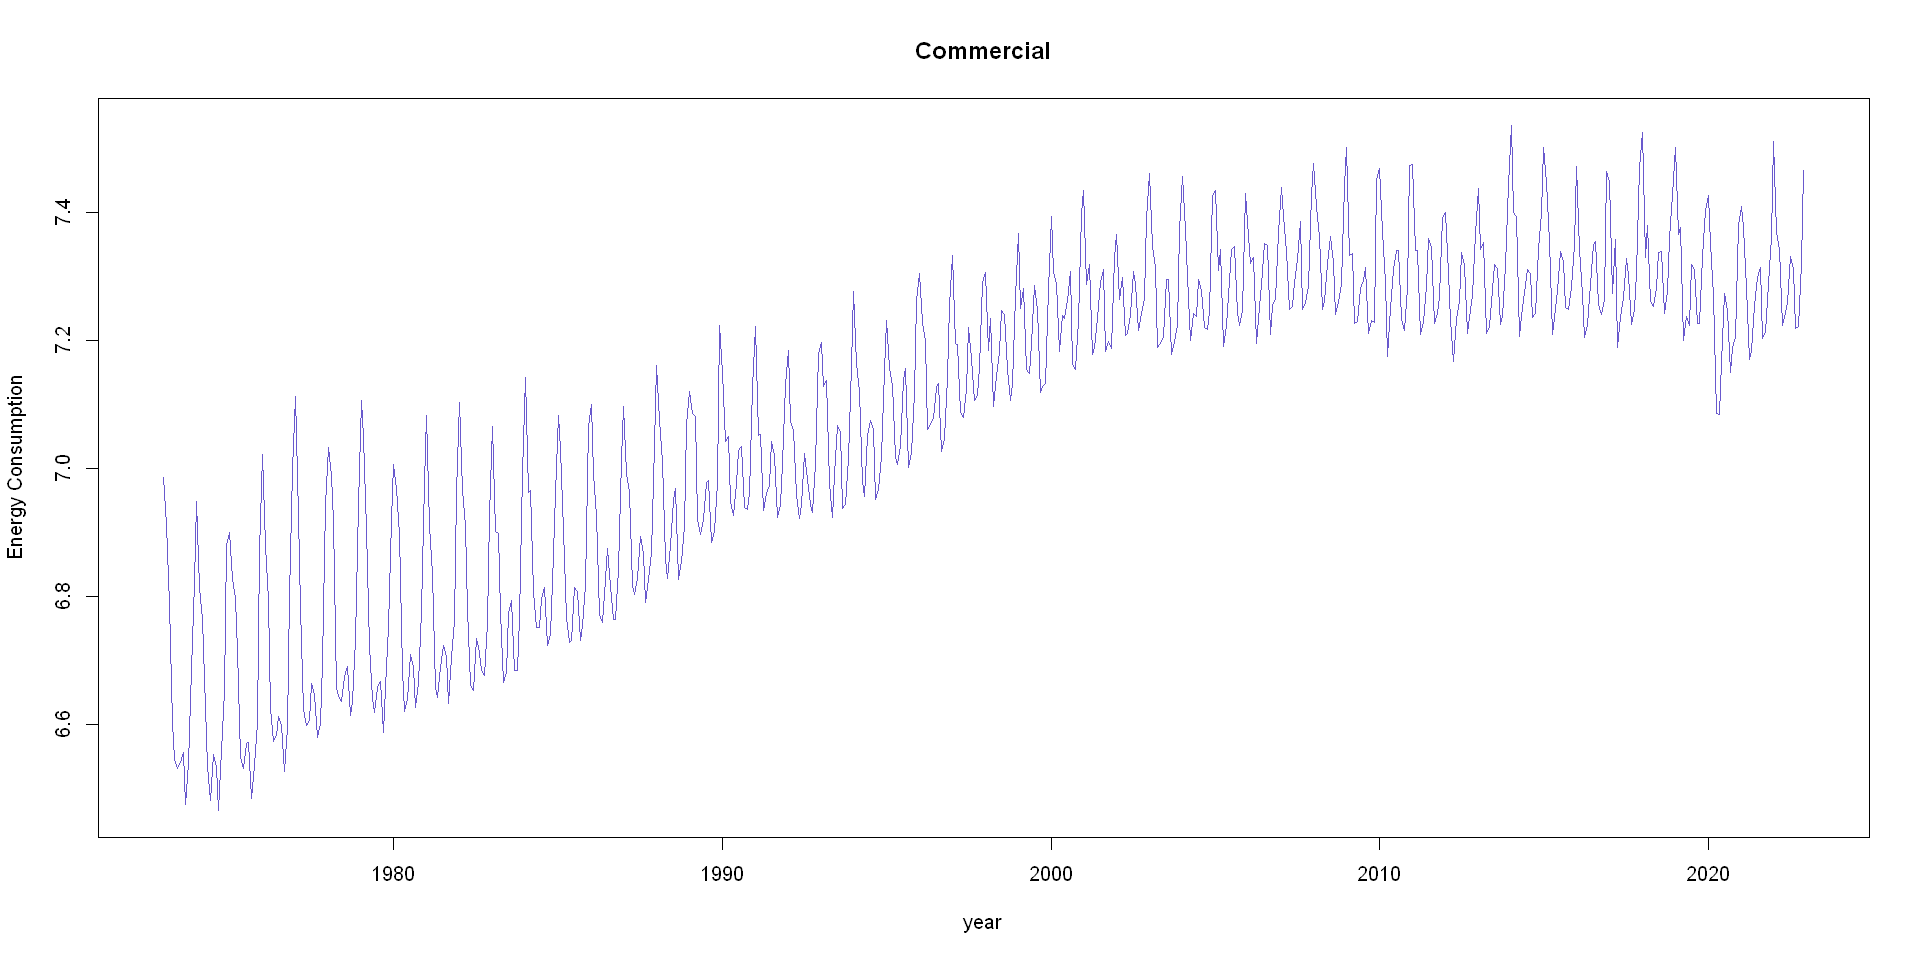

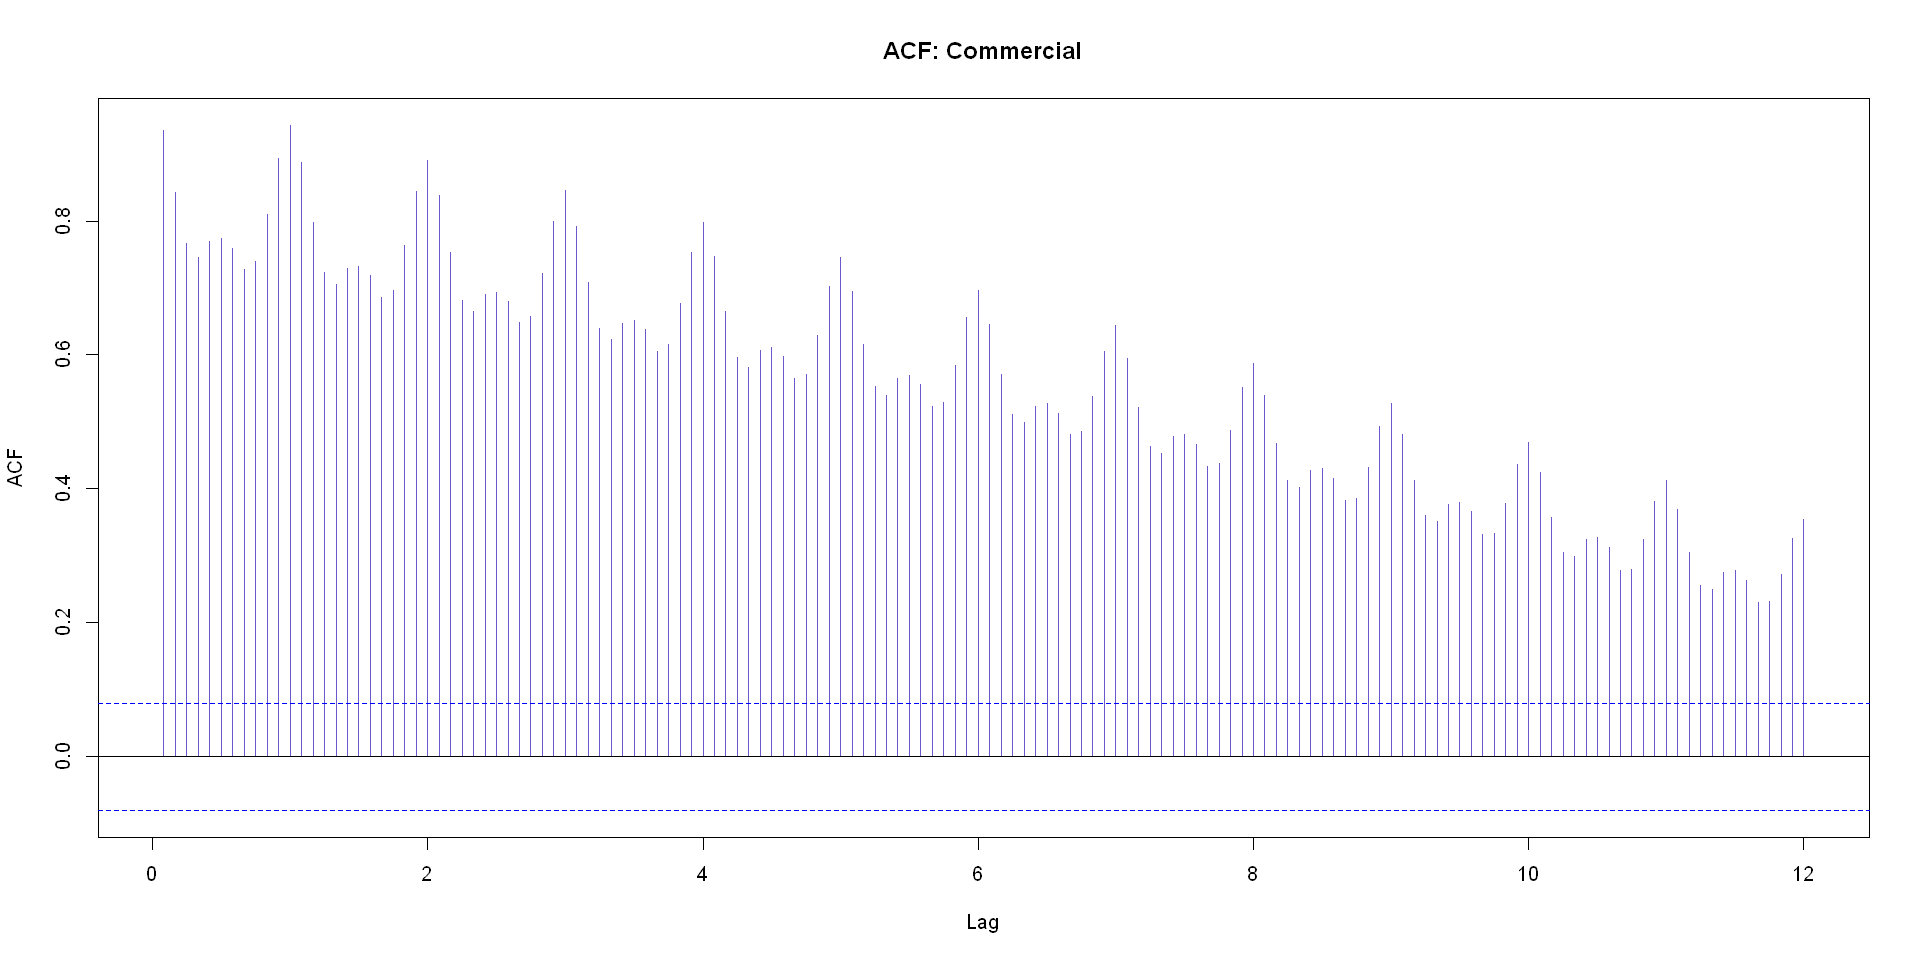

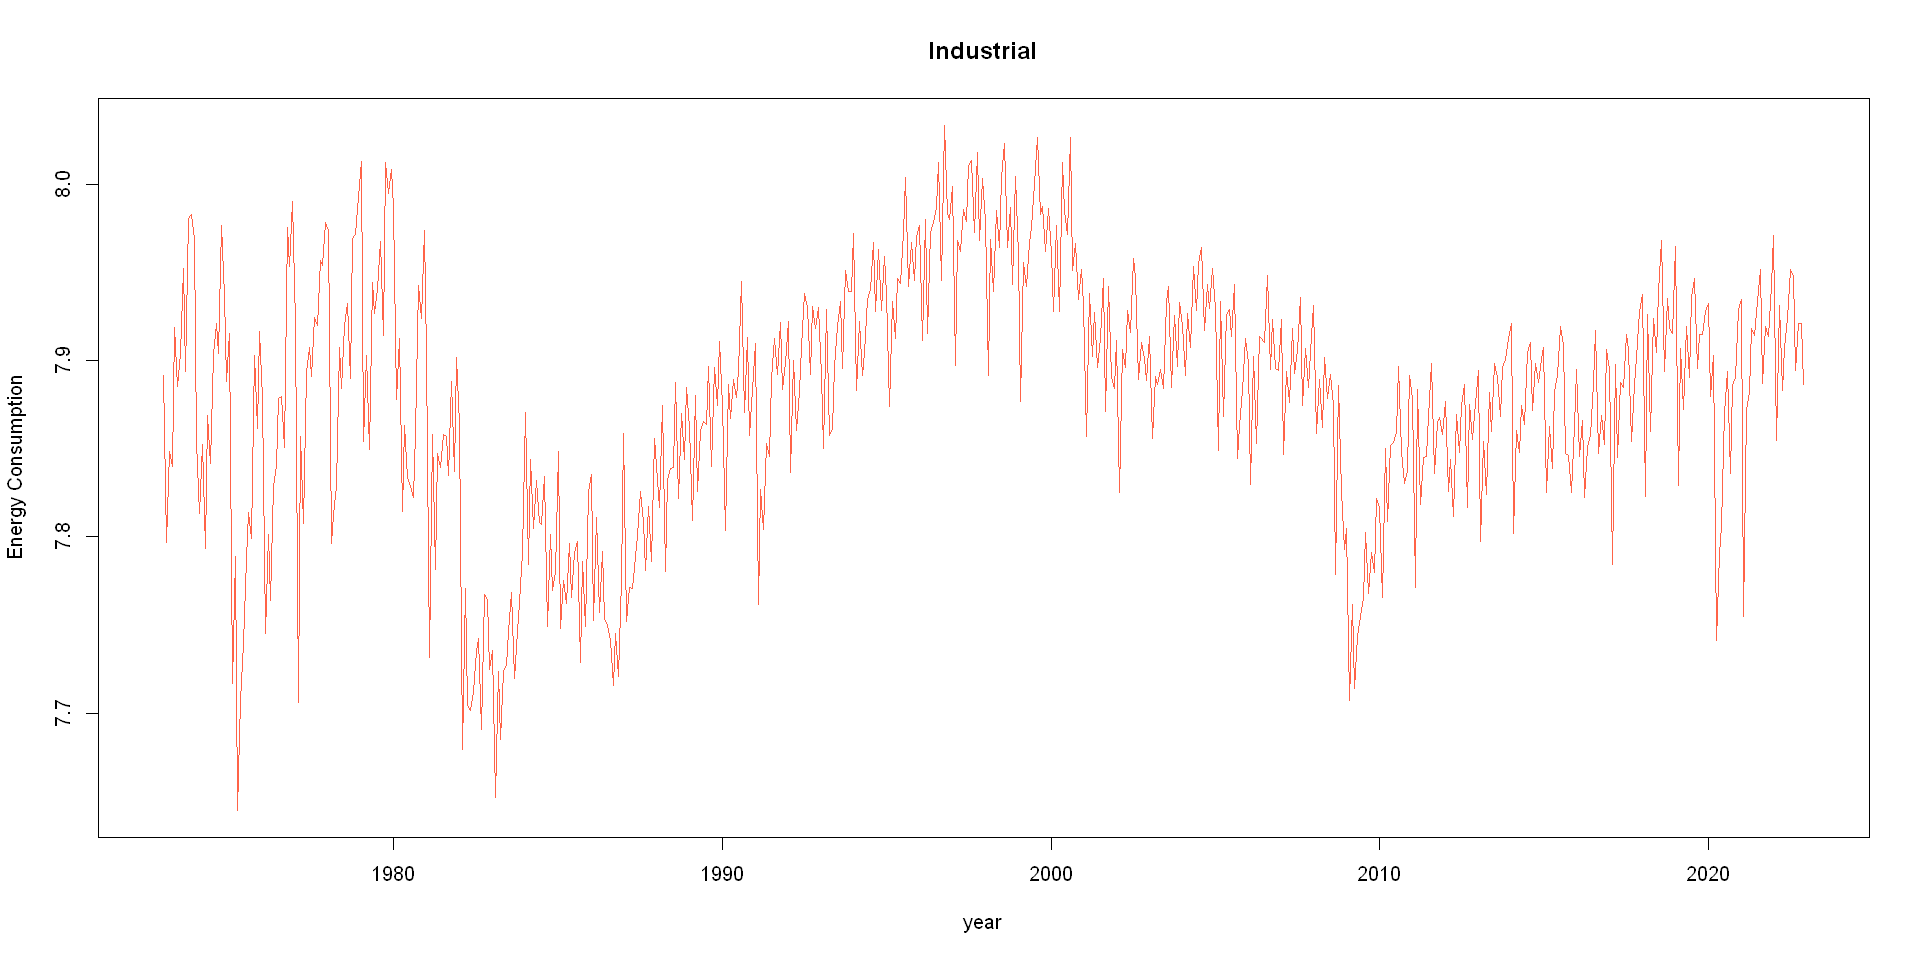

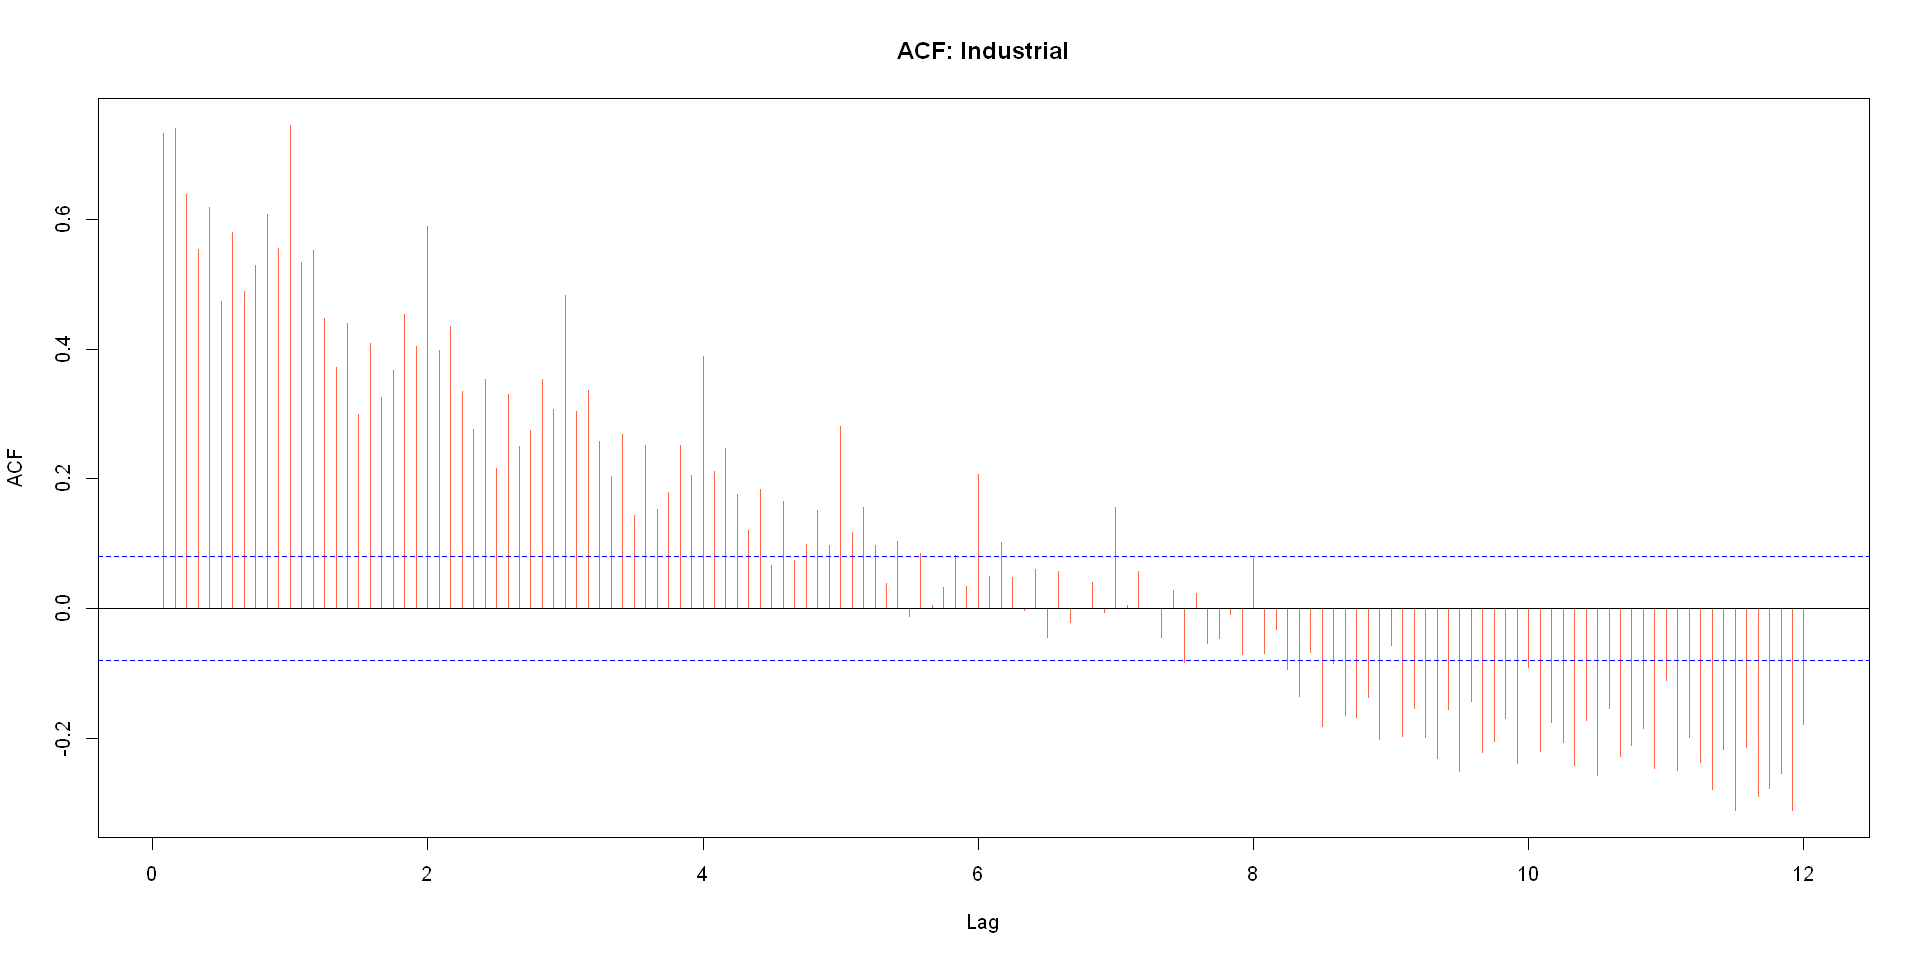

In [24]:
# plot total energy time series
# Residential
ts.plot(Total_RS.ts,xlab="year",ylab="Energy Consumption", main="Residential",col=col1)
acf(Total_RS.ts,lag.max=12*12,main="ACF: Residential",col=col1)

# Commercial
ts.plot(Total_CS.ts,xlab="year",ylab="Energy Consumption", main="Commercial",col=col2)
acf(Total_CS.ts,lag.max=12*12,main="ACF: Commercial",col=col2)

# Industrial
ts.plot(Total_IS.ts,xlab="year",ylab="Energy Consumption", main="Industrial",col=col3)
acf(Total_IS.ts,lag.max=12*12,main="ACF: Industrial",col=col3)




# Modeling Total Energy Consumption

### Residential

### Spline Trend estimation plus Monthly Seasonality using ANOVA



In [25]:
####TREND and SEASONALITY ESTIMATION FOR TOTAL RESIDENTIAL ENERGY CONSUMPTION #####
mon = as.factor(month(as.Date(Total_RS.ts)))

## X-axis points converted to 0-1 scale, common in nonparametric regression
time.pts = c(1:length(Total_RS.ts))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

## Splines Trend Estimation and monthly seasonality
gam.mon.RS = gam(Total_RS.ts~s(time.pts)+mon-1)
gam.mon.RS.ts = ts(fitted(gam.mon.RS),start=1973,frequency=12)
summary(gam.mon.RS)



Family: gaussian 
Link function: identity 

Formula:
Total_RS.ts ~ s(time.pts) + mon - 1

Parametric coefficients:
      Estimate Std. Error t value Pr(>|t|)    
mon1  7.728476   0.009654   800.5   <2e-16 ***
mon2  7.574965   0.009654   784.7   <2e-16 ***
mon3  7.459887   0.009653   772.8   <2e-16 ***
mon4  7.207902   0.009653   746.7   <2e-16 ***
mon5  7.097216   0.009652   735.3   <2e-16 ***
mon6  7.143116   0.009652   740.0   <2e-16 ***
mon7  7.275926   0.009652   753.8   <2e-16 ***
mon8  7.265356   0.009652   752.7   <2e-16 ***
mon9  7.115889   0.009653   737.2   <2e-16 ***
mon10 7.094133   0.009653   734.9   <2e-16 ***
mon11 7.264647   0.009654   752.5   <2e-16 ***
mon12 7.581580   0.009654   785.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 7.633  8.529 271.9  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj


##### Plot fitted values against Original data



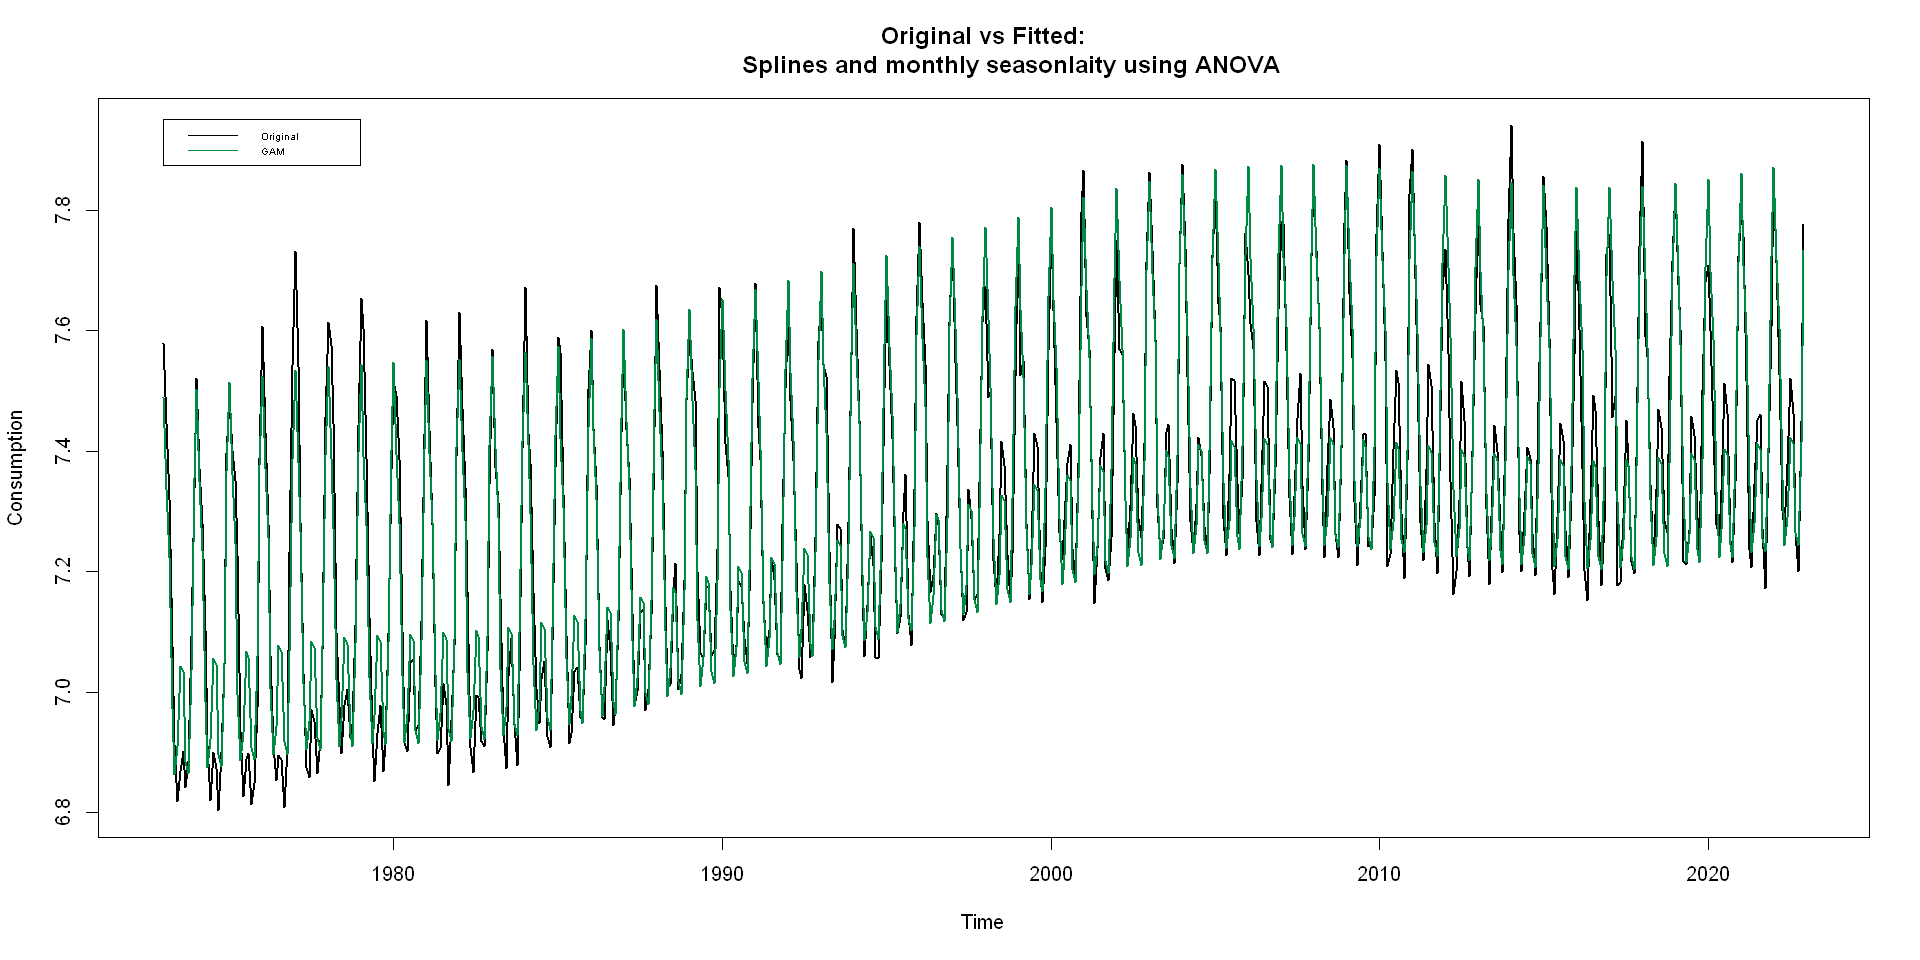

In [26]:
## Compare against fitted values
all.val = c(Total_RS.ts, gam.mon.RS.ts)
ylimRange= c(min(all.val),max(all.val))

ts.plot(Total_RS.ts,lwd=2,ylim=ylimRange,ylab="Consumption",main="Original vs Fitted:
        Splines and monthly seasonlaity using ANOVA")
lines(gam.mon.RS.ts,lwd=2,col=col1)
legend(x=1973,y=7.95,legend=c("Original","GAM"),lty = 1, col=c("black",col1),cex=0.5)



##### Evaluate Residuals



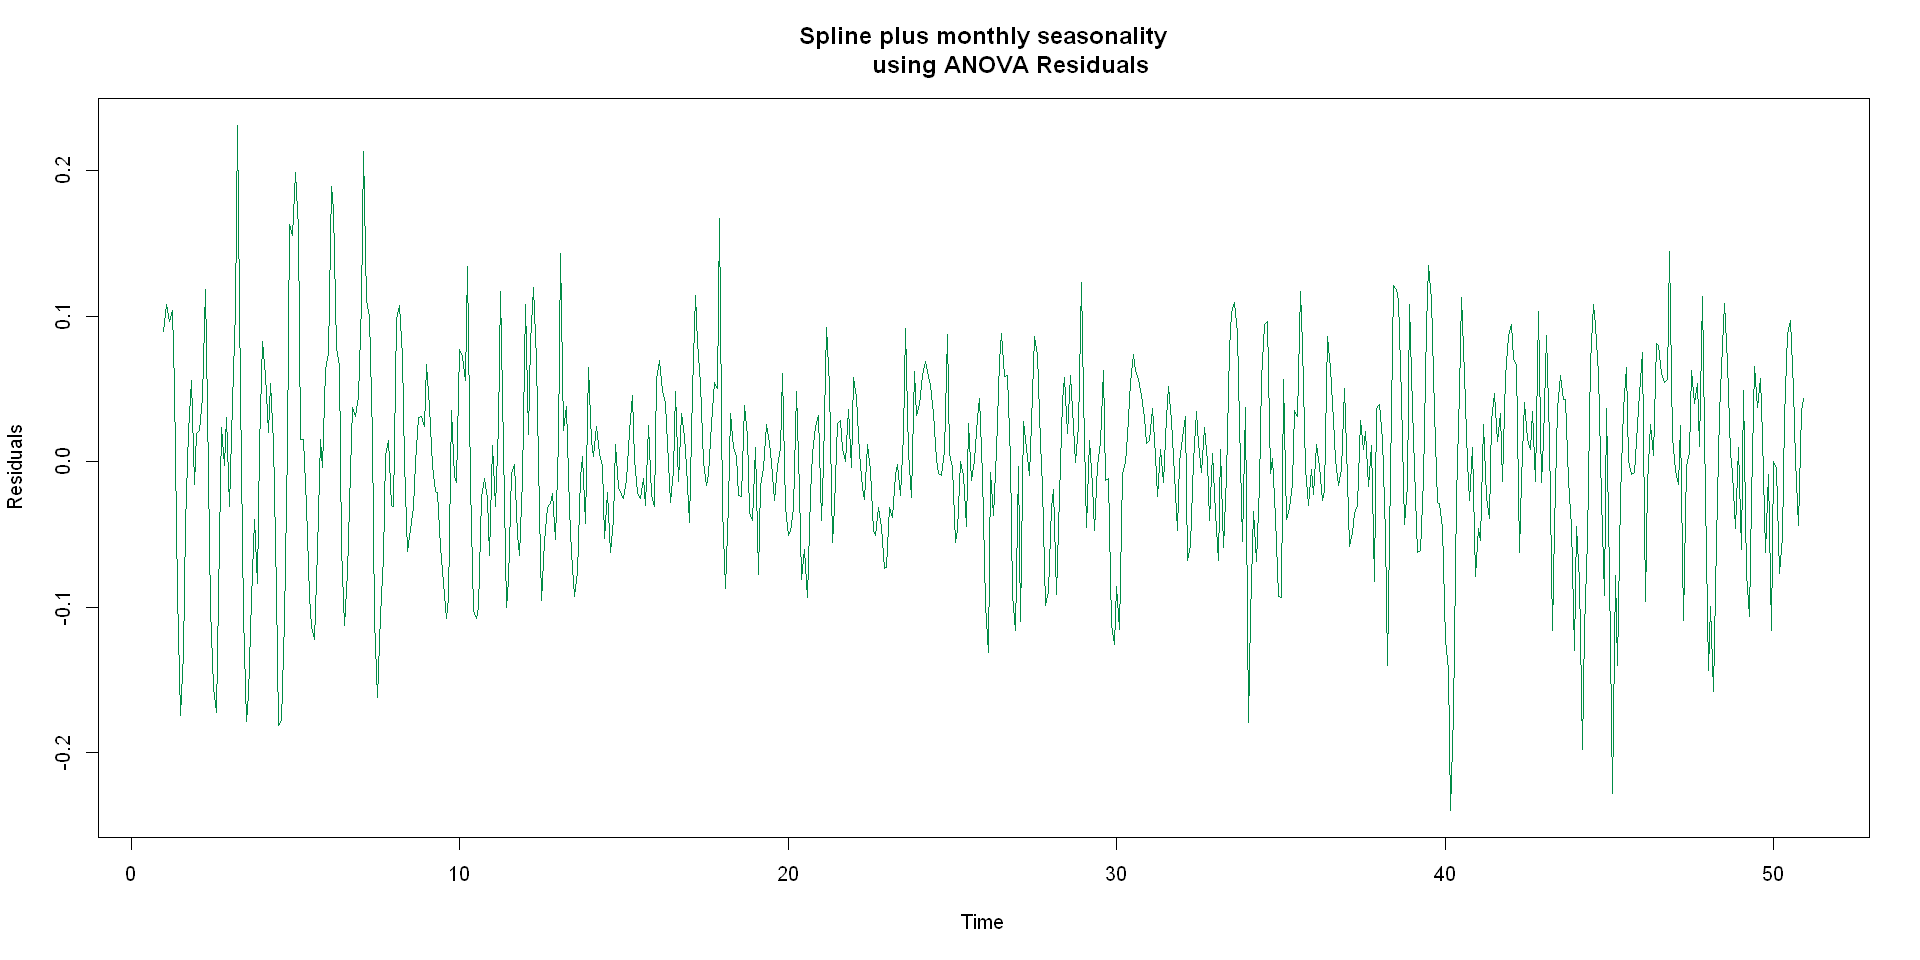

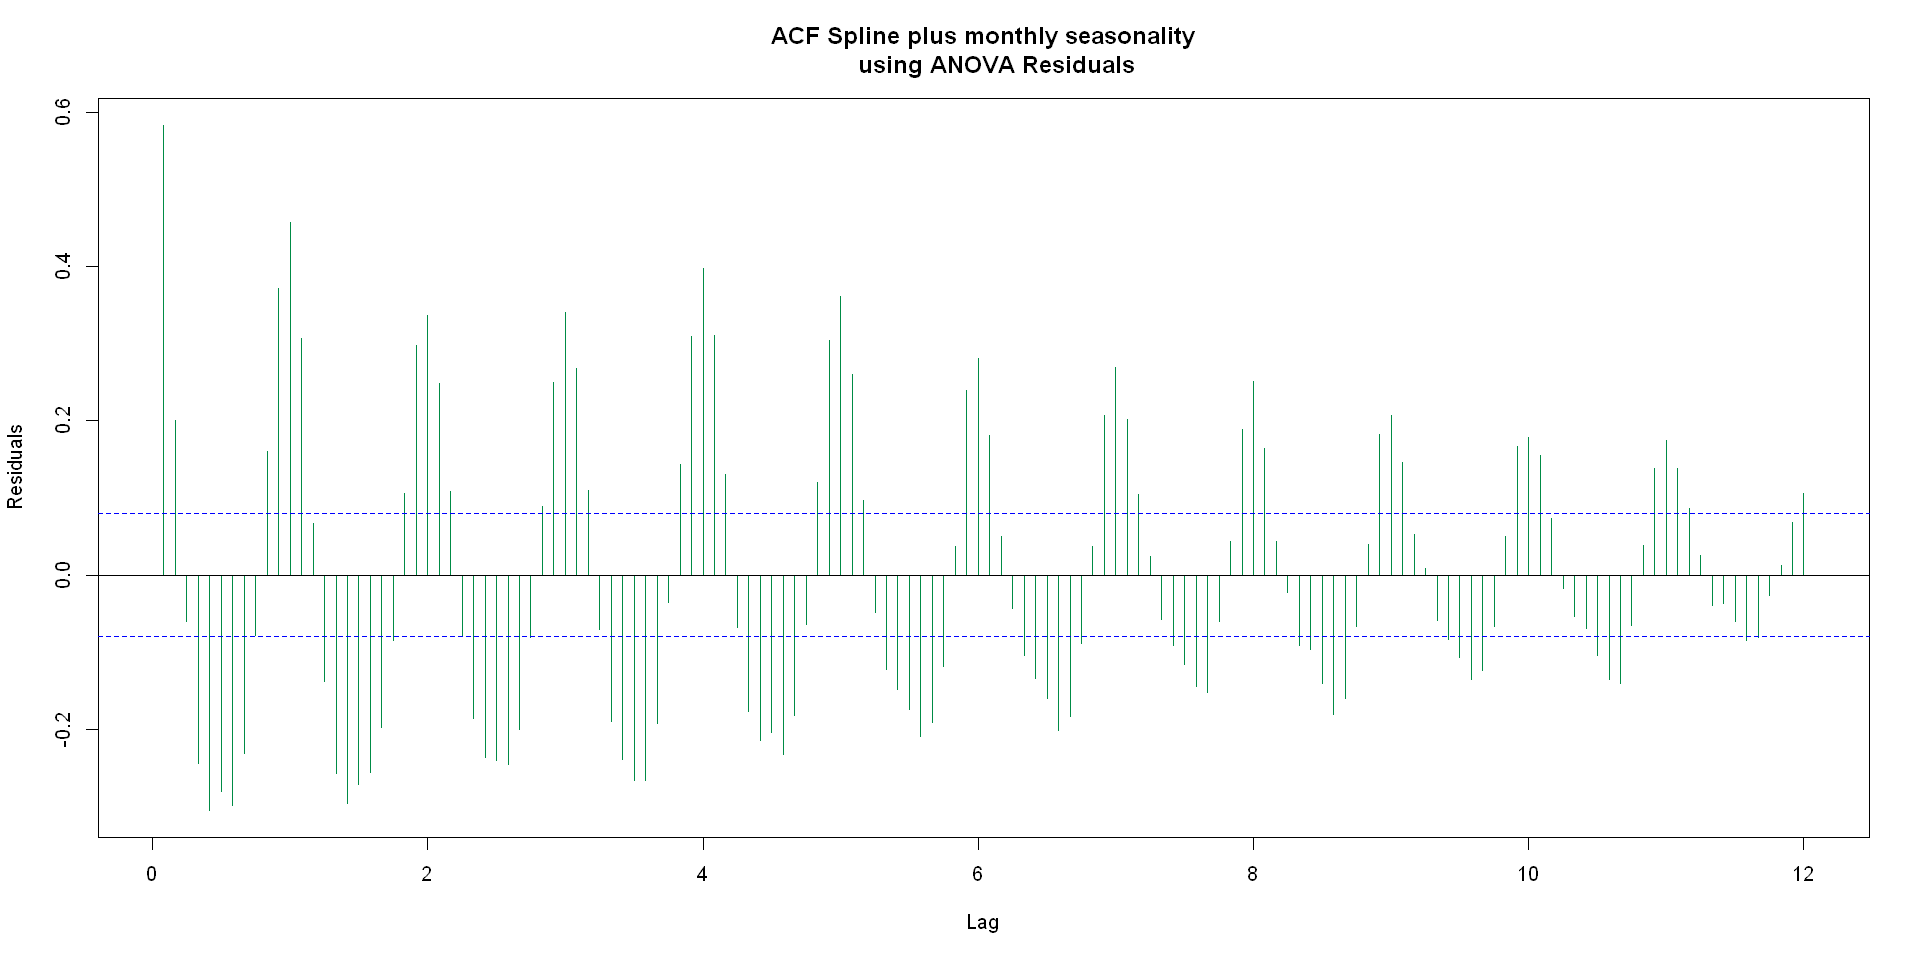

Warning message in adf.test(gam.mon.resid):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  gam.mon.resid
Dickey-Fuller = -10.957, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


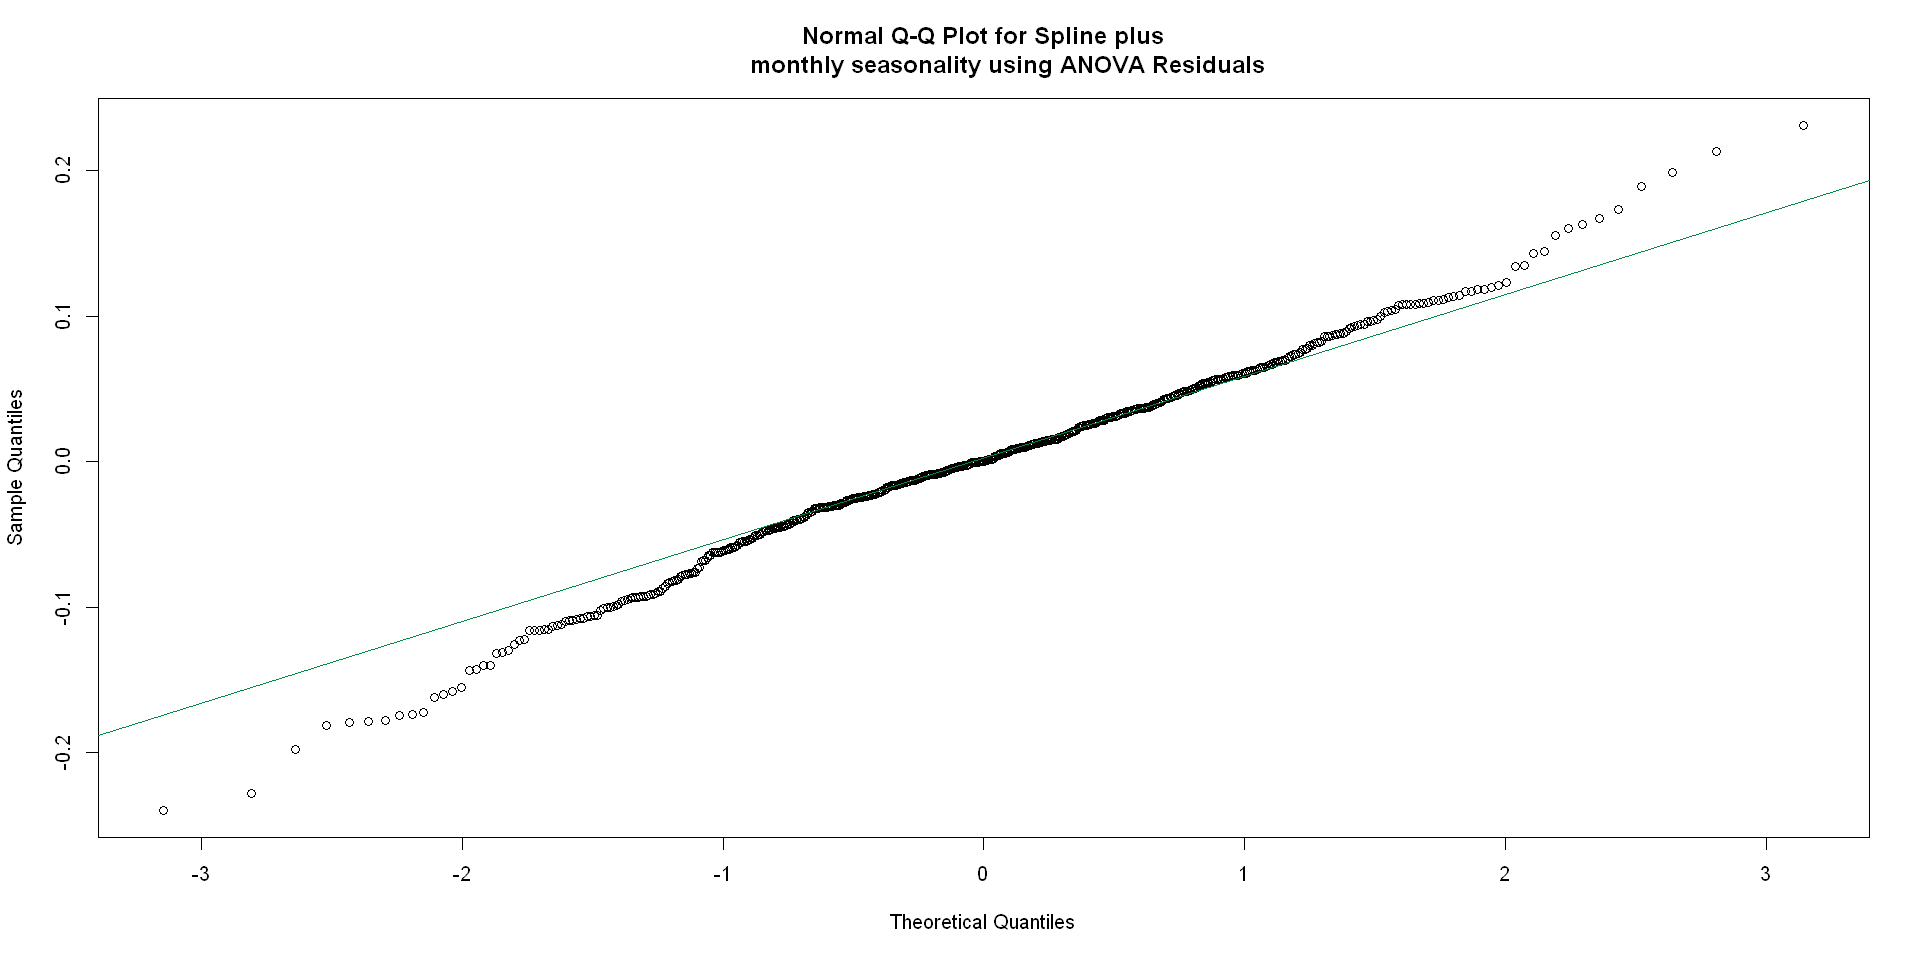

In [27]:
#plot the residuals introduced removing the trend and seasonality
gam.mon.resid = Total_RS.ts - fitted(gam.mon.RS)
ts.plot(ts(gam.mon.resid,frequency=12),col=col1,ylab="Residuals", main="Spline plus monthly seasonality
        using ANOVA Residuals")

acf(gam.mon.resid,lag.max = 12*12,col=col1,ylab="Residuals", main="ACF Spline plus monthly seasonality
    using ANOVA Residuals")

qqnorm(gam.mon.resid,main = "Normal Q-Q Plot for Spline plus
       monthly seasonality using ANOVA Residuals")
qqline(gam.mon.resid,col=col1)

adf.test(gam.mon.resid)



### Spline Trend estimation plus Quarterly Seasonality using ANOVA



In [28]:
############### TREND and SEASONALITY ESTIMATION ###################
qtr = as.factor(quarter(as.Date(Total_RS.ts)))

## Splines Trend Estimation
gam.qtr.RS = gam(Total_RS.ts~s(time.pts)+qtr-1)
gam.qtr.RS.ts = ts(fitted(gam.qtr.RS),start=1973,frequency=12)
summary(gam.qtr.RS)



Family: gaussian 
Link function: identity 

Formula:
Total_RS.ts ~ s(time.pts) + qtr - 1

Parametric coefficients:
     Estimate Std. Error t value Pr(>|t|)    
qtr1  7.58756    0.01154   657.4   <2e-16 ***
qtr2  7.14934    0.01154   619.5   <2e-16 ***
qtr3  7.21913    0.01154   625.6   <2e-16 ***
qtr4  7.31367    0.01154   633.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 4.587  5.627 95.06  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.693   Deviance explained =  100%
GCV = 0.020264  Scale est. = 0.019974  n = 600


##### Plot fitted values against Original data



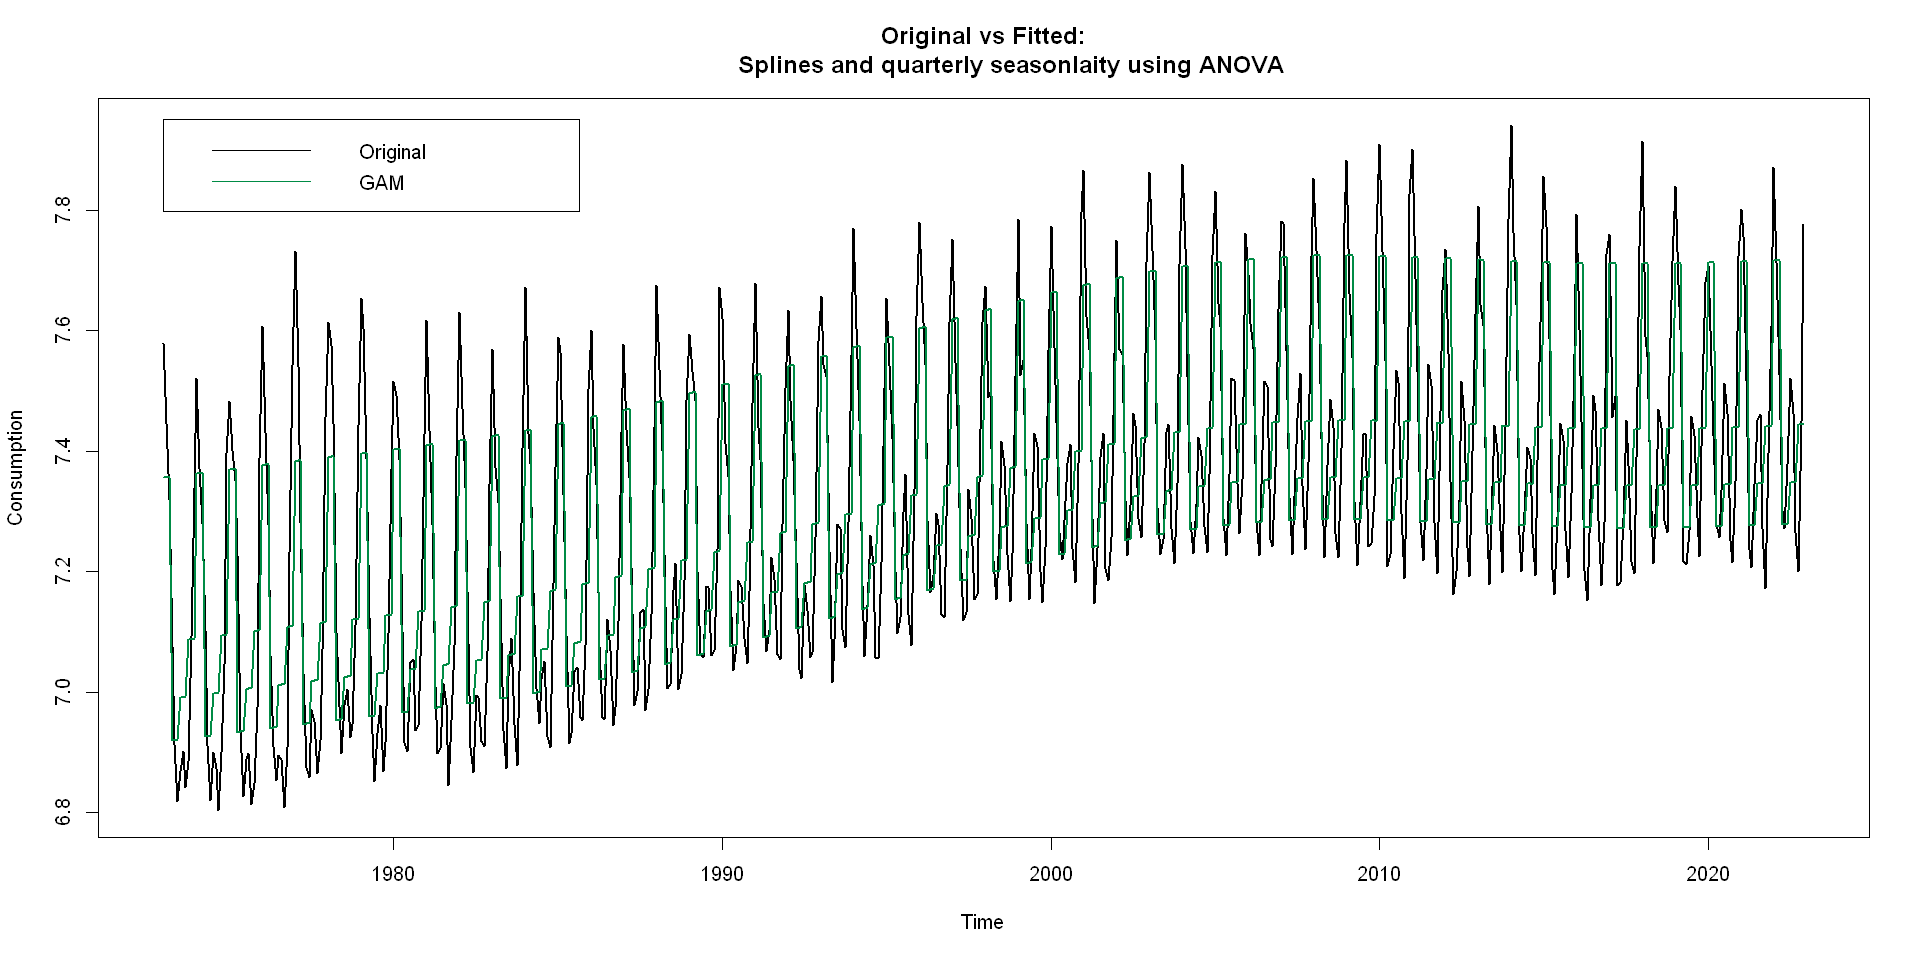

In [29]:
all.val.qtr = c(Total_RS.ts, gam.qtr.RS.ts)
ylimRange.qtr= c(min(all.val.qtr),max(all.val.qtr))

ts.plot(Total_RS.ts,lwd=2,ylim = ylimRange.qtr,ylab="Consumption",main="Original vs Fitted:
        Splines and quarterly seasonlaity using ANOVA")
lines(gam.qtr.RS.ts,lwd=2,col=col1)
legend(x=1973,y=7.95,legend=c("Original","GAM"),lty = 1, col=c("black",col1))



##### Evaluate Residuals



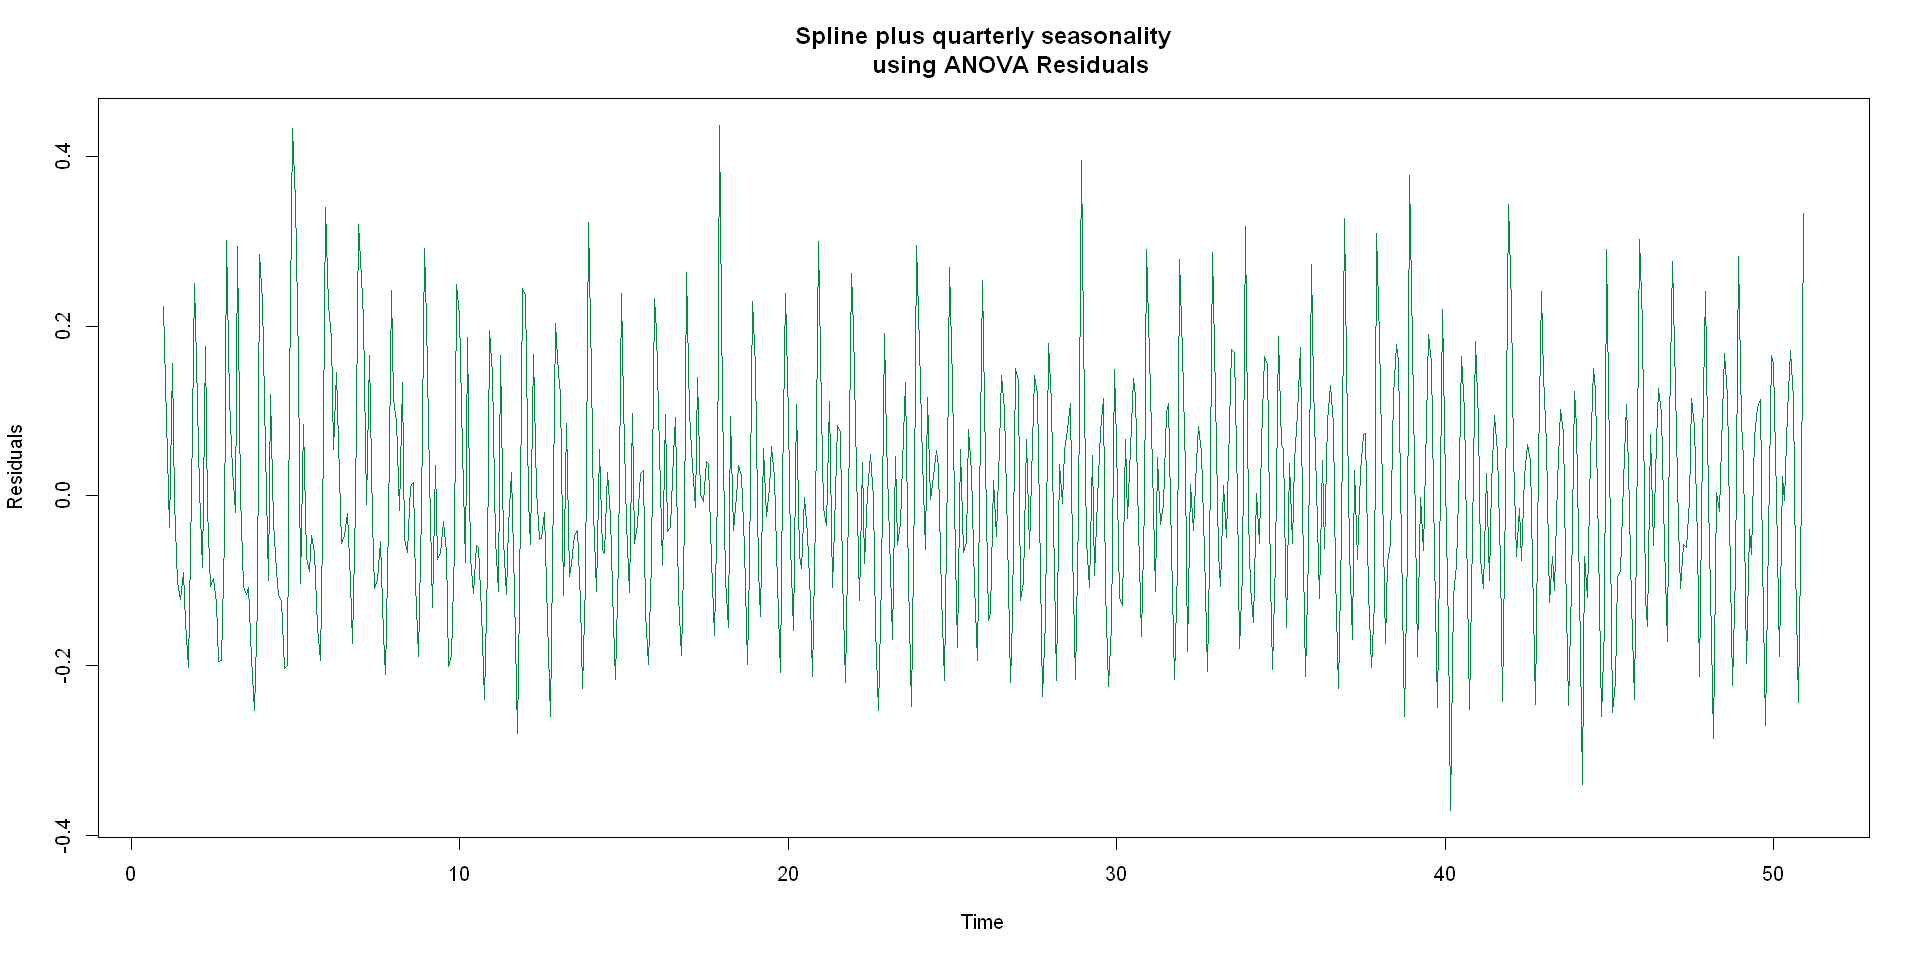

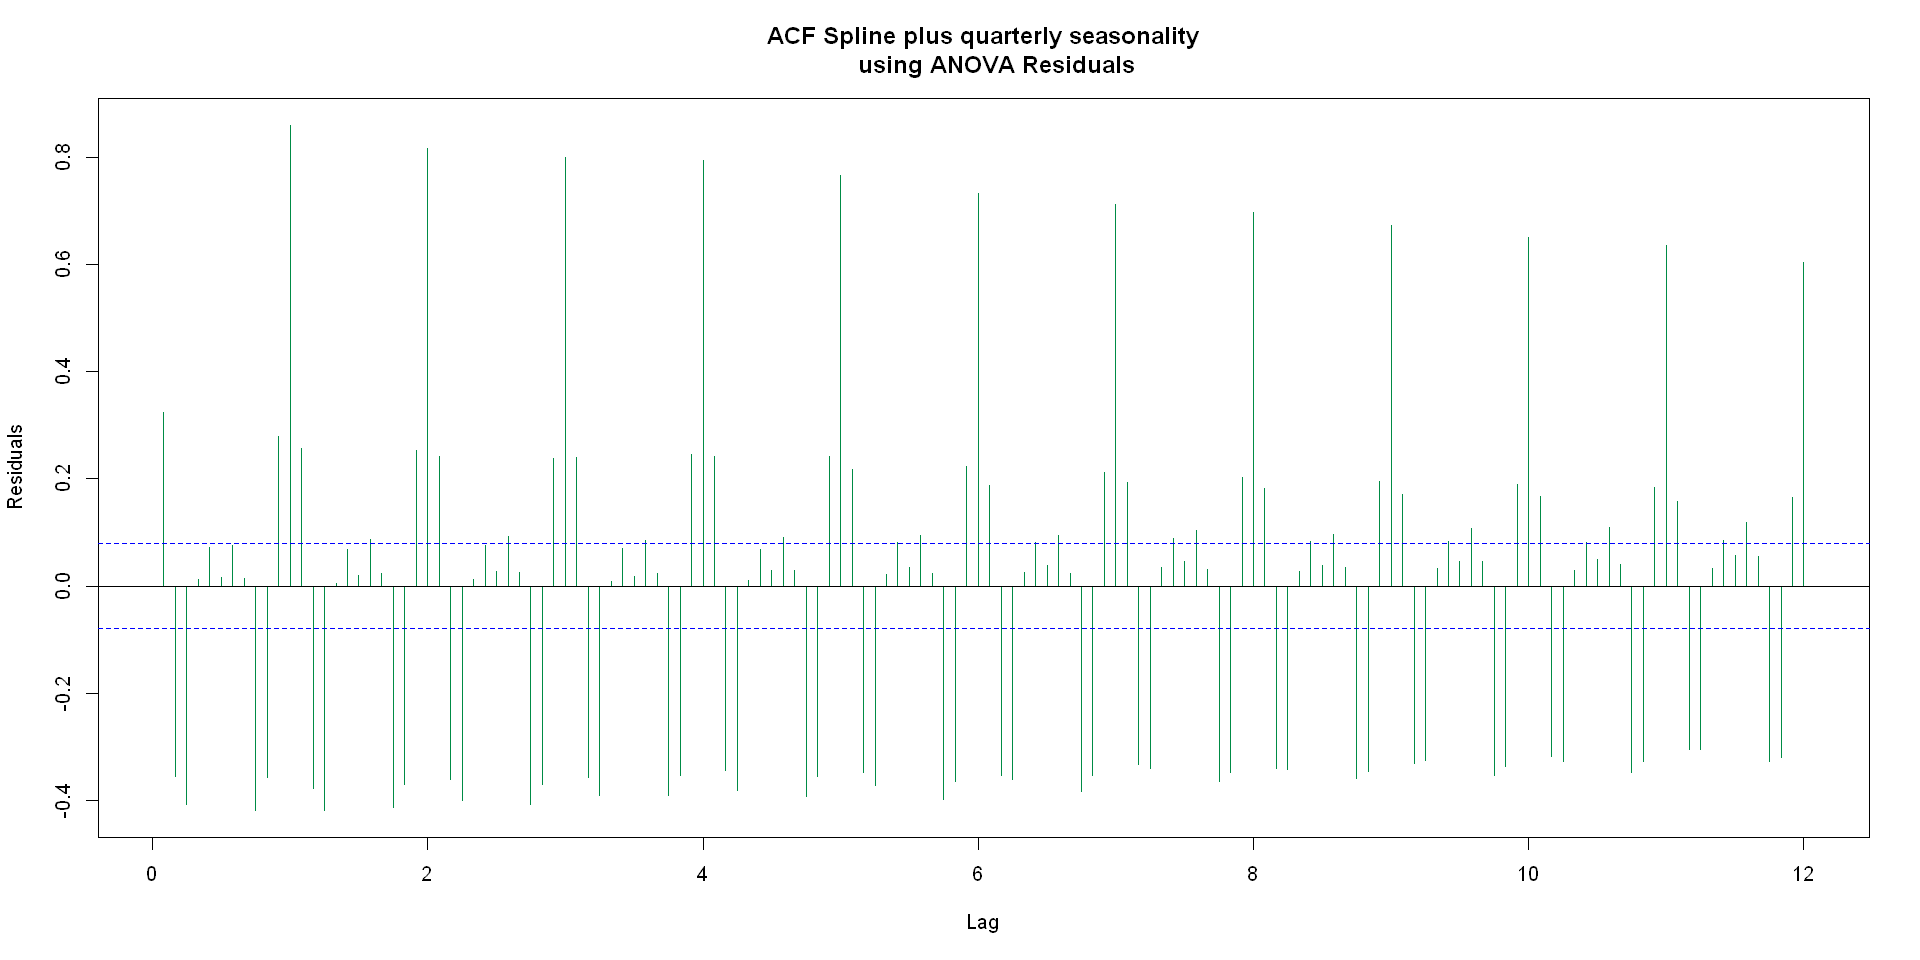

Warning message in adf.test(gam.qtr.resid):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  gam.qtr.resid
Dickey-Fuller = -18.543, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


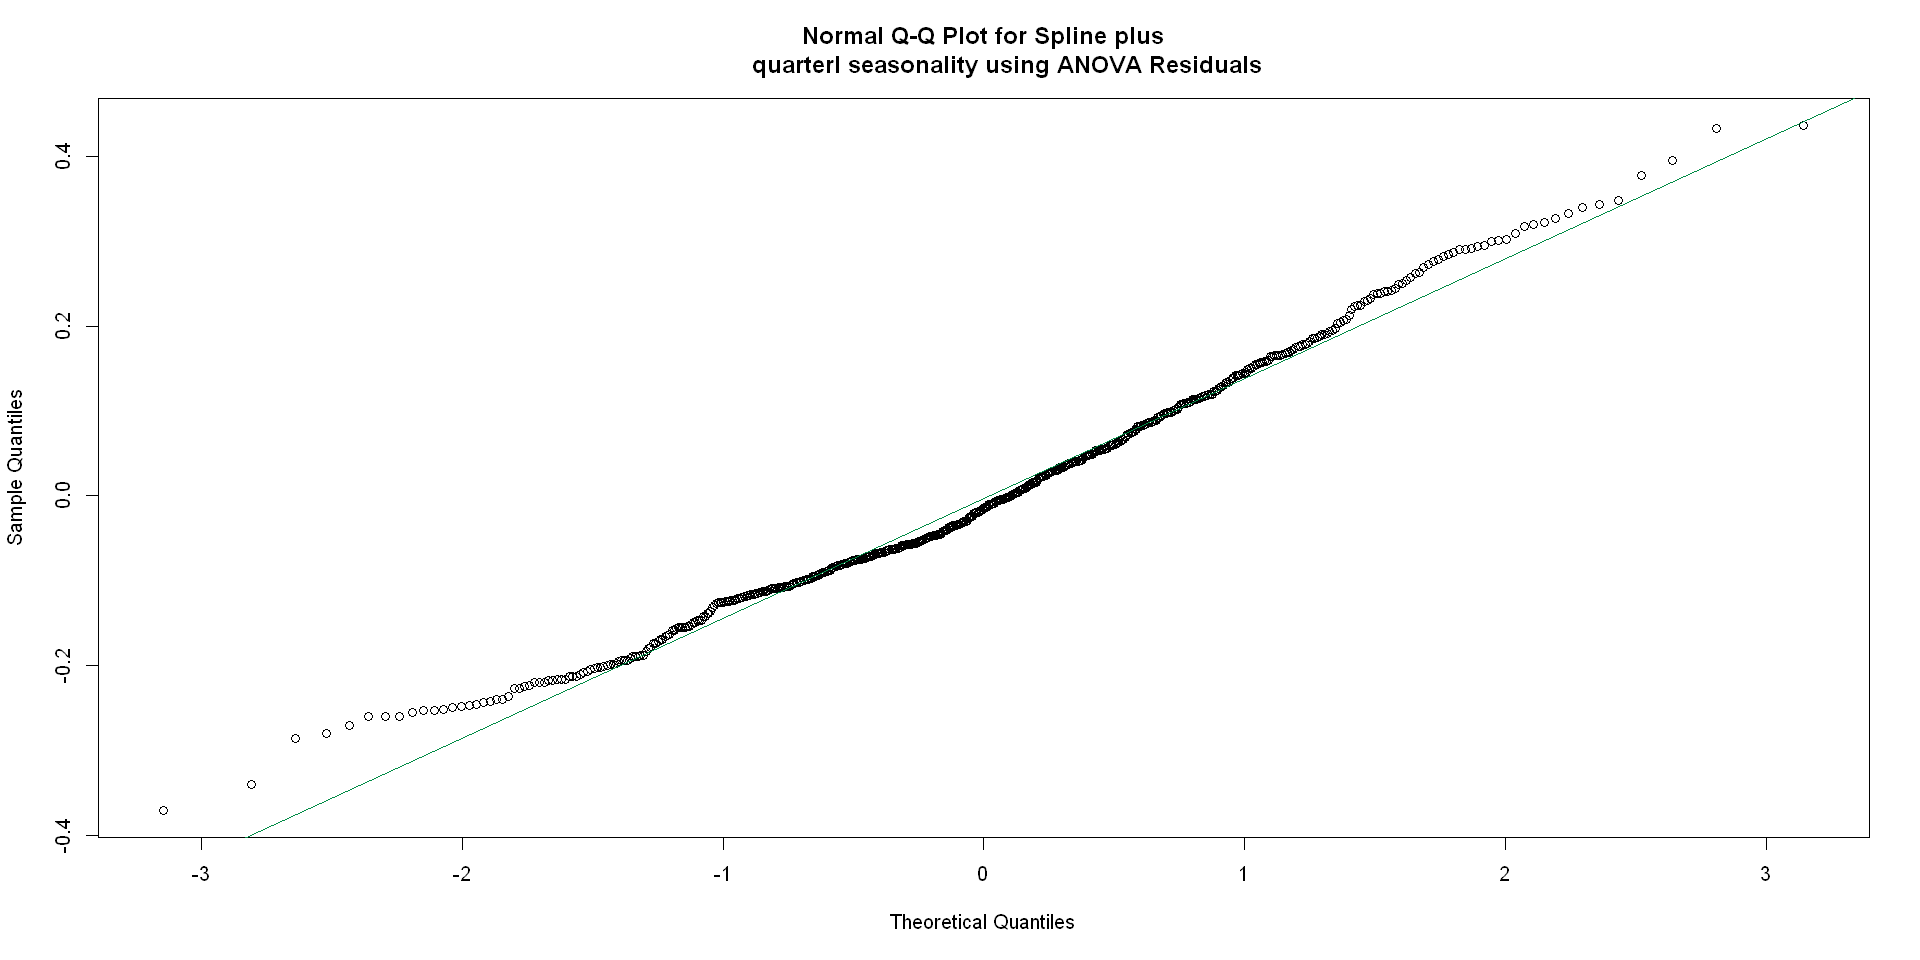

In [30]:
#plot the residuals introduced removing the trend and seasonality
gam.qtr.resid = Total_RS.ts - fitted(gam.qtr.RS)
ts.plot(ts(gam.qtr.resid,frequency=12),col=col1,ylab="Residuals", main="Spline plus quarterly seasonality
        using ANOVA Residuals")

acf(gam.qtr.resid,lag.max = 12*12,col=col1,ylab="Residuals", main="ACF Spline plus quarterly seasonality
    using ANOVA Residuals")

qqnorm(gam.qtr.resid,main = "Normal Q-Q Plot for Spline plus
       quarterl seasonality using ANOVA Residuals")
qqline(gam.qtr.resid,col=col1)

adf.test(gam.qtr.resid)



## Split data into training and testing sets



In [31]:
n.tot = length(Total_RS.ts)
nfit.tot=n.tot-12
Total_RS.train = Total_RS.ts[1:nfit.tot]
Total_RS.train.ts=ts(Total_RS.train,start=1973,frequency=12)


## Fit and evaluate a SARIMA Model

##### Find the best orders for SARIMA RS



In [32]:
# Function to fit a seasonal ARIMA model
find_best_arima <- function(data, porder = 3, dorder = 1, qorder = 3, Porder=2, Dorder=1, Qorder=2) {
  # Loop through different parametes
  best_aic <- Inf
  best_sarima <- NULL
  for (p in 0:porder) {
    for (d in 0:dorder) {
      for (q in 0:qorder) {
        for (P in 0:Porder) {
          for (D in 0:Dorder) {
            for (Q in 0:Qorder) {
        tryCatch({
          # Fit the model and capture AIC
          model_RS <- Arima(data, order = c(p, d, q), seasonal = list(order = c(P, D, Q)))
          aic <- AIC(model_RS)

          # Update best model if AIC is lower
          if (aic < best_aic) {
            best_aic <- aic
            best_sarima <- model_RS
          }
        }, error = function(e) {
        })
      }}
    }}
  }}
  return(best_sarima)
}

# fit model
SARIMA_RS <- find_best_arima(Total_RS.train.ts)
SARIMA_RS

Series: data 
ARIMA(3,1,3)(2,0,2)[12] 

Coefficients:
          ar1      ar2     ar3     ma1      ma2      ma3    sar1    sar2
      -1.1853  -0.1658  0.4337  0.7449  -0.6710  -0.9725  0.4807  0.5157
s.e.   0.0401   0.0660  0.0408  0.0192   0.0172   0.0203  0.3327  0.3319
         sma1     sma2
      -0.1842  -0.4662
s.e.   0.3148   0.2344

sigma^2 = 0.002452:  log likelihood = 914.04
AIC=-1806.08   AICc=-1805.62   BIC=-1757.95


##### Diagnostic plot for SARIMA Residuals



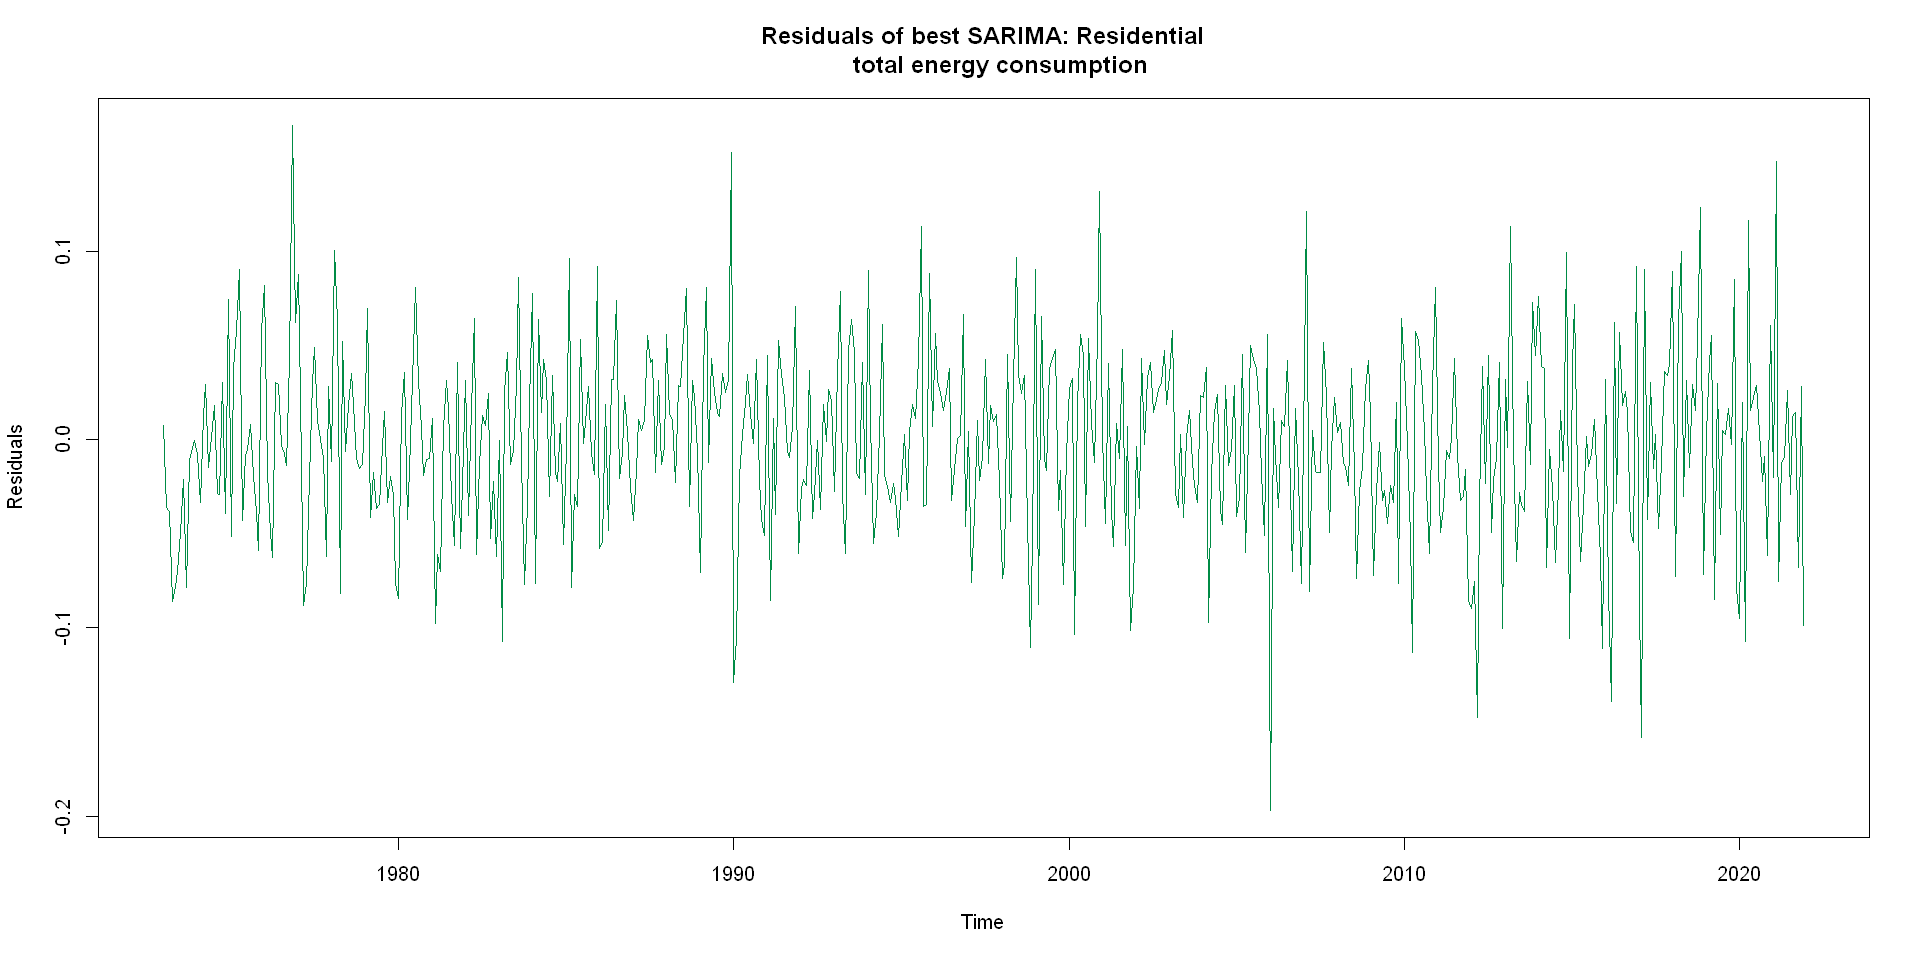

In [33]:
plot(SARIMA_RS$residuals,ylab="Residuals",main="Residuals of best SARIMA: Residential
     total energy consumption",col=col1)


##### Evaluate SARIMA Residuals



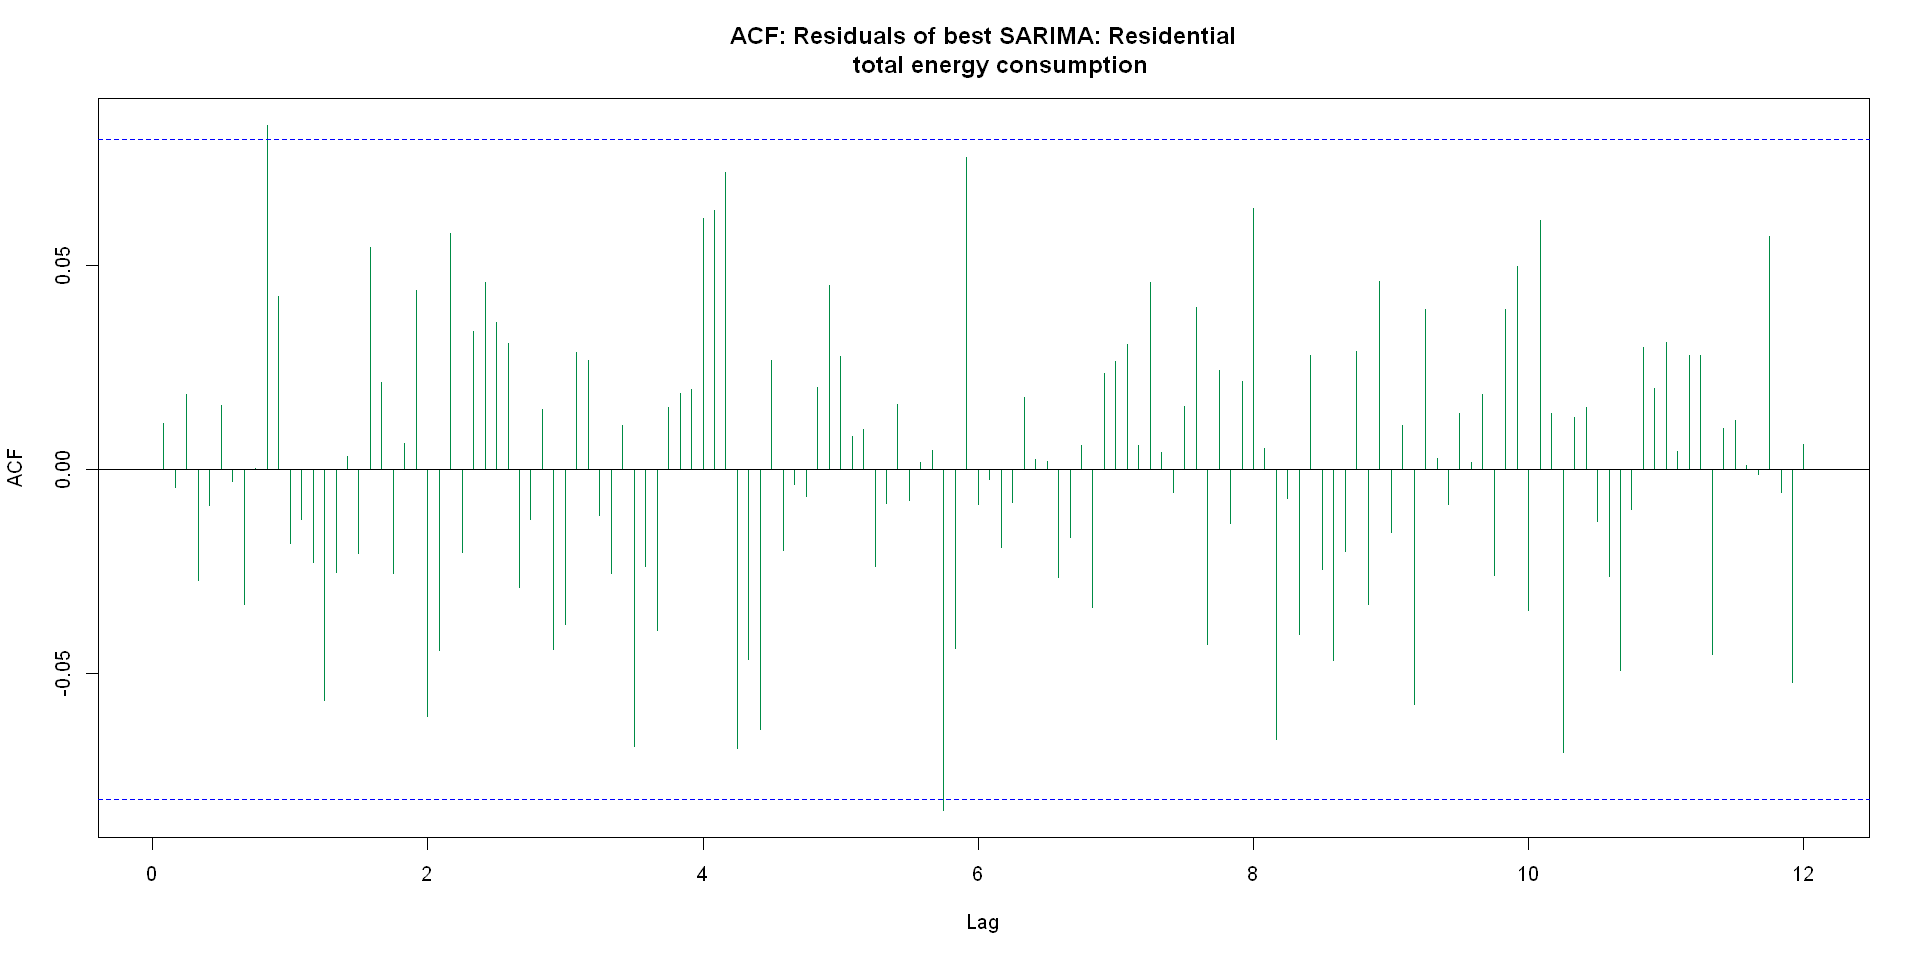

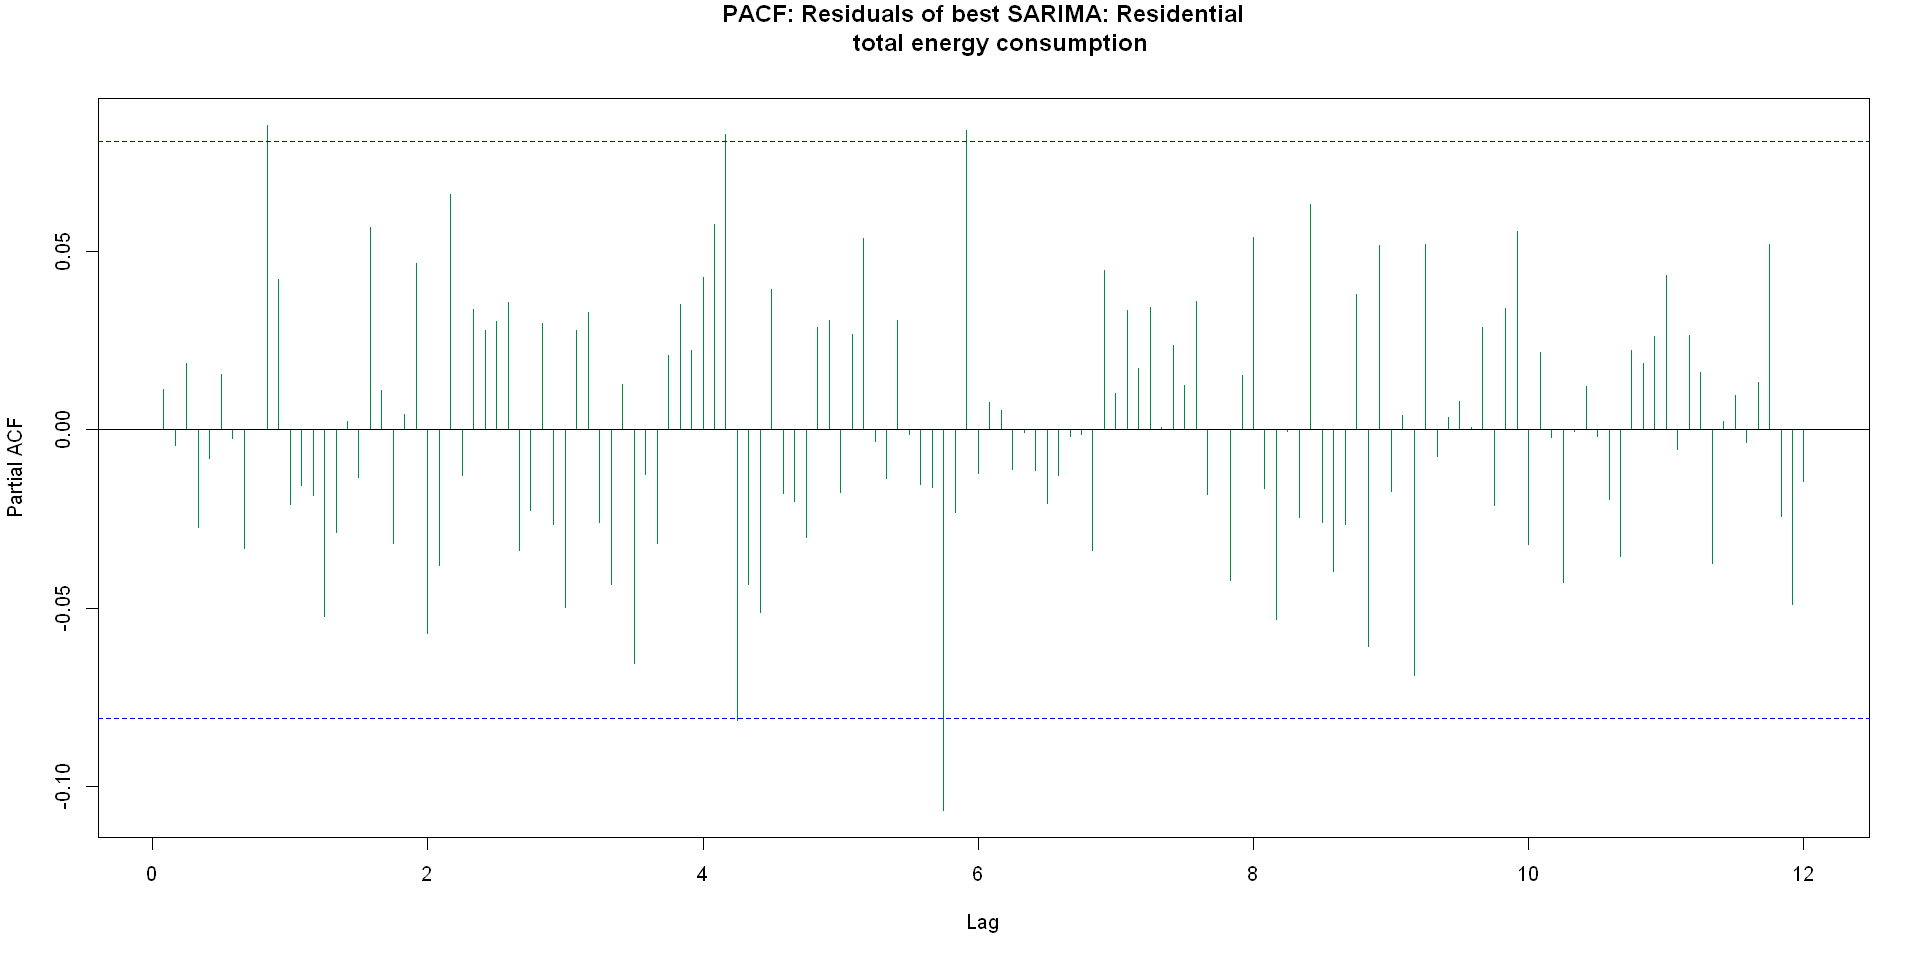

[1] 397  47

Warning message in adf.test(residuals(SARIMA_RS)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  residuals(SARIMA_RS)
Dickey-Fuller = -8.7034, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary



	Box-Pierce test

data:  residuals(SARIMA_RS)
X-squared = 0.91089, df = 1, p-value = 0.3399



	Box-Ljung test

data:  residuals(SARIMA_RS)
X-squared = 0.9201, df = 1, p-value = 0.3374


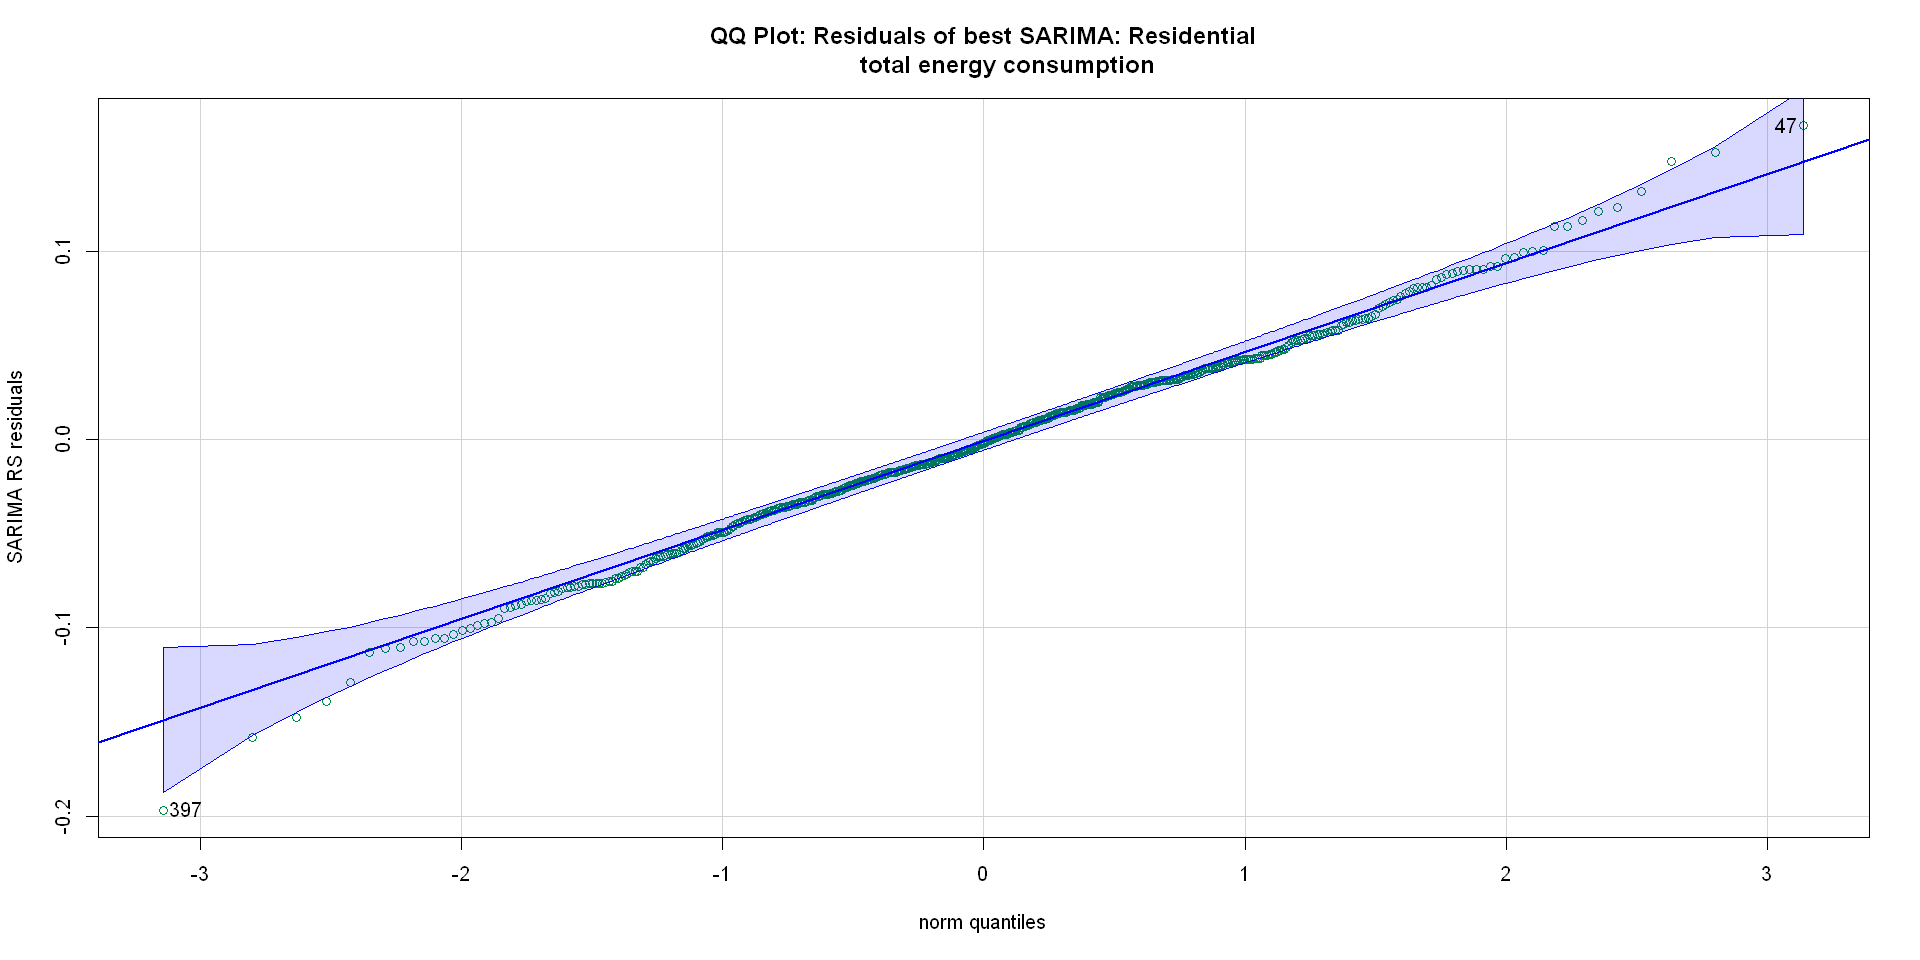

In [34]:
acf(SARIMA_RS$residuals,lag.max = 12*12,main="ACF: Residuals of best SARIMA: Residential
     total energy consumption",col=col1)

pacf(SARIMA_RS$residuals,lag.max = 12*12,main="PACF: Residuals of best SARIMA: Residential
     total energy consumption",col=col1)

qqPlot(residuals(SARIMA_RS),ylab="SARIMA RS residuals",main="QQ Plot: Residuals of best SARIMA: Residential
       total energy consumption",col=col1)

adf.test(residuals(SARIMA_RS))

# Test and see if residuals are correlated
Box.test(residuals(SARIMA_RS), lag = (SARIMA_RS$arma[1]+SARIMA_RS$arma[2]+1), type = "Box-Pierce", fitdf = (SARIMA_RS$arma[1]+SARIMA_RS$arma[2]))
Box.test(residuals(SARIMA_RS), lag = (SARIMA_RS$arma[1]+SARIMA_RS$arma[2]+1), type = "Ljung-Box", fitdf = (SARIMA_RS$arma[1]+SARIMA_RS$arma[2]))




##### Comments

Based on the Box-Pierce test, the p-value is 0.1568, thus we fail to reject the null hyothesis and it appears that the residuals of the SARIMA model for Residential Consumption does not exhibit major autocorrelations. This suggests that the model is performing well in capturing the underlying trend and seasonality in the data.

##### Predict 12 months ahead



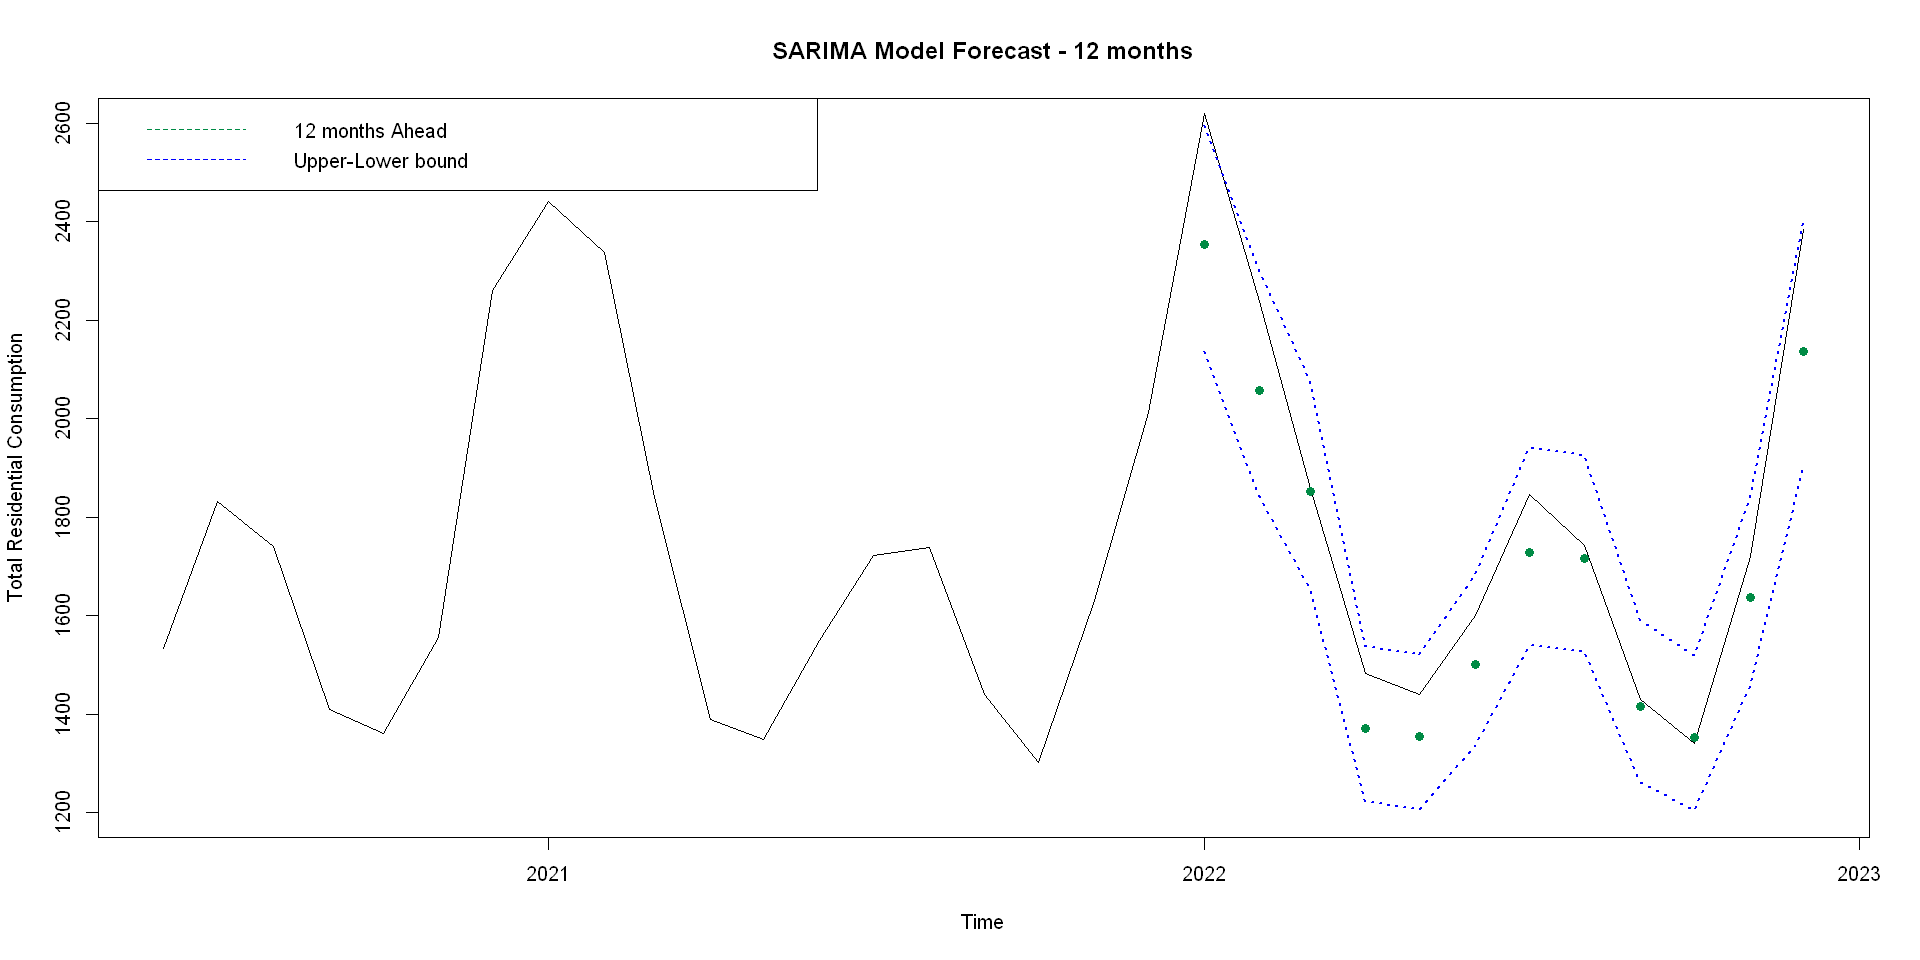

In [35]:
# predict 12 months ahead

outpred = predict(SARIMA_RS,n.ahead=12)

ubound = exp(outpred$pred+1.96*outpred$se)
lbound = exp(outpred$pred-1.96*outpred$se)
ymin = min(lbound)
ymax = max(ubound)

plot(energy_data$dates[(n.tot-30):n.tot],exp(Total_RS.ts[(n.tot-30):n.tot]),type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Total Residential Consumption", main="SARIMA Model Forecast - 12 months")
points(energy_data$dates[(nfit.tot+1):n.tot],exp(outpred$pred),col=col1,pch=16)
lines(energy_data$dates[(nfit.tot+1):n.tot],ubound,lty=3,lwd= 2, col="blue")
lines(energy_data$dates[(nfit.tot+1):n.tot],lbound,lty=3,lwd= 2, col="blue")
legend('topleft', legend=c("12 months Ahead ","Upper-Lower bound"),lty = 2, col=c(col1,"blue"))


##### Compute accuracy measures



In [36]:
## Compute Accuracy Measures
RS_true = as.vector(exp(Total_RS.ts[(nfit.tot+1):n.tot]))
RS_SARIMA_pred = exp(outpred$pred)

### Mean Absolute Percentage Error (MAPE)
mean(abs(RS_SARIMA_pred-RS_true)/RS_true)
### Precision Measure (PM)
sum((RS_SARIMA_pred-RS_true)^2)/sum((RS_true-mean(RS_true))^2)
#Review Accuracy measure interpretation


[1] 0.05264198

[1] 0.1171755


##### Comments

The mean MAPE is 0.05064164 indicating that the predictions were off by 5.064% compared to the actual values. the model is making reasonably accurate predictions.The PM also appears to be performing well.

### Fit and Evaluate an ARMA-GARCH Model

Building on our prior analysis, the residential energy consumption data displays both trend and seasonal patterns. Moreover, the data exhibits periods of fluctuating consumption, potentially linked to extreme weather events. To account for these combined effects and potentially improve forecast accuracy, we explored employing an ARMA-GARCH model.

To identify the optimal model, we began by iteratively evaluating ARIMA configurations with autoregressive (p) and moving average (q) orders ranging up to 5, and differencing (d) up to 2. After multiple iterations, the model converged to an ARMA(1,0) - GARCH(1,0) model. Trivial configurations of (0,0) were excluded from consideration.

##### Step 1



In [37]:
suppressWarnings({
    v = length(Total_RS.train.ts)
    
    # Step 1
    test_modelA <- function(p,d,q){
      mod = arima(Total_RS.train.ts, order=c(p,d,q), method="ML")
      current.aic <- AIC(mod)
      current.aic<-current.aic-2*(p+q+1)+2*(p+q+1)*v/(v-p-q-2)
      df = data.frame(p,d,q,current.aic)
      names(df) <- c("p","d","q","AIC")
      return(df)
    }
    
    orders <- data.frame(Inf,Inf,Inf,Inf)
    names(orders) <- c("p","d","q","AIC")
    for (p in 0:5){
      for(d in 0:2) {
        for (q in 0:5) {
          possibleError <- tryCatch(
            orders<-rbind(orders,test_modelA(p,d,q)),
            error=function(e) e
          )
          if(inherits(possibleError, "error")) next
        }
      }
    }

})
orders <- orders[order(-orders$AIC),]
tail(orders)

# ARIMA (5,0,4)


,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
85,4,1,5,-953.7836
78,4,0,4,-978.5276
76,4,0,2,-999.1539
95,5,0,3,-1007.1276
77,4,0,3,-1026.2520
96,5,0,4,-1031.4237



##### Step 2



In [38]:
# Step 2
##### Order Selection ################################################
suppressWarnings({
    test_modelAGG <- function(m,n){
      spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                        mean.model=list(armaOrder=c(5,4),
                                        include.mean=T),
                        distribution.model="std")
      fit = ugarchfit(spec, Total_RS.train.ts, solver = 'hybrid')
      current.bic = infocriteria(fit)[2]
      df = data.frame(m,n,current.bic)
      names(df) <- c("m","n","BIC")
      print(paste(m,n,current.bic,sep=" "))
      return(df)
    }
    
    ordersAGG = data.frame(Inf,Inf,Inf)
    names(ordersAGG) <- c("m","n","BIC")
    
    for (m in 0:2){
      for (n in 0:2){
        possibleError <- tryCatch(
          ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
          error=function(e) e
        )
        if(inherits(possibleError, "error")) next
      }
    }
})
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

[1] "0 0 -1.58614629802745"
[1] "0 1 -1.57709693256951"
[1] "0 2 -1.56624431383928"
[1] "1 0 -1.60890871893665"
[1] "1 1 -1.56625211559776"
[1] "1 2 -1.58723729693279"
[1] "2 0 -1.5980776907573"
[1] "2 1 -1.55540733810623"
[1] "2 2 -1.57617440669167"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
10,2,2,-1.576174
3,0,1,-1.577097
2,0,0,-1.586146
7,1,2,-1.587237
8,2,0,-1.598078
5,1,0,-1.608909



##### Step 3



In [39]:
# Step 3
# ARMA update
suppressWarnings({
    test_modelAGA <- function(p,q){
      spec = ugarchspec(variance.model=list(garchOrder=c(1,0)),
                        mean.model=list(armaOrder=c(p,q),
                                        include.mean=T),
                        distribution.model="std")
      fit = ugarchfit(spec, Total_RS.train.ts, solver = 'hybrid')
      current.bic = infocriteria(fit)[2]
      df = data.frame(p,q,current.bic)
      names(df) <- c("p","q","BIC")
      print(paste(p,q,current.bic,sep=" "))
      return(df)
    }
    
    ordersAGA = data.frame(Inf,Inf,Inf)
    names(ordersAGA) <- c("p","q","BIC")
    for (p in 0:5){
      for (q in 0:5){
        possibleError <- tryCatch(
          ordersAGA<-rbind(ordersAGA,test_modelAGA(p,q)),
          error=function(e) e
        )
        if(inherits(possibleError, "error")) next
      }
    }
})
ordersAGA <- ordersAGA[order(-ordersAGA$BIC),]
tail(ordersAGG)


[1] "0 0 -0.0189336100705072"
[1] "0 1 -0.737820679117618"
[1] "0 2 -1.11891946290576"
[1] "0 3 -1.25261077054698"
[1] "0 4 -1.26225524296705"
[1] "0 5 -1.26937587765868"
[1] "1 0 -0.759046941250834"
[1] "1 1 -1.11892906955244"
[1] "1 2 -1.21315548862853"
[1] "1 3 -1.2538699522712"
[1] "1 4 -1.28402436314179"
[1] "1 5 -1.2587523431986"
[1] "2 0 -1.20797799358437"
[1] "2 1 -1.23852299017124"
[1] "2 2 -1.26130500311498"
[1] "2 3 -1.26837595502695"
[1] "2 4 -1.30287831474246"
[1] "2 5 -1.42393976550614"
[1] "3 0 -1.26697937798106"
[1] "3 1 -1.26837799562631"
[1] "3 2 -1.38787942554046"
[1] "3 3 -1.36602003608209"
[1] "3 4 -1.36035941469713"
[1] "3 5 -1.35814202410947"
[1] "4 0 -1.27721389959744"
[1] "4 1 -1.34909686854252"
[1] "4 2 -1.67317625527793"
[1] "4 3 -1.68048427865156"
[1] "4 4 -1.66803835299577"
[1] "4 5 -1.43281693259124"
[1] "5 0 -1.2565049569851"
[1] "5 1 -1.25088293599733"
[1] "5 2 -1.59979322743156"
[1] "5 3 -1.59045346738488"
[1] "5 4 -1.60890871893665"
[1] "5 5 -1.5860027

,m,n,BIC
,<dbl>,<dbl>,<dbl>
10,2,2,-1.576174
3,0,1,-1.577097
2,0,0,-1.586146
7,1,2,-1.587237
8,2,0,-1.598078
5,1,0,-1.608909



##### Step 4



In [40]:
# Step 4
# GARCH update
suppressWarnings({
    test_modelAGG <- function(m,n){
      spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                        mean.model=list(armaOrder=c(1,0),
                                        include.mean=T), distribution.model="std")
      fit = ugarchfit(spec, Total_RS.train.ts, solver = 'hybrid')
      current.bic = infocriteria(fit)[2]
      df = data.frame(m,n,current.bic)
      names(df) <- c("m","n","BIC")
      print(paste(m,n,current.bic,sep=" "))
      return(df)
    }
    
    ordersAGG = data.frame(Inf,Inf,Inf)
    names(ordersAGG) <- c("m","n","BIC")
    
    for (m in 0:2){
      for (n in 0:2){
        possibleError <- tryCatch(
          ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
          error=function(e) e
        )
        if(inherits(possibleError, "error")) next
      }
    }
})
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

# ARMA (1,0) GARCH(1,0)
# Did not select GARCH (0,0)

[1] "0 0 -0.768285438412244"
[1] "0 1 -0.757462899699849"
[1] "0 2 -0.746600469256784"
[1] "1 0 -0.759046941250834"
[1] "1 1 -0.746593742642768"
[1] "1 2 -0.735780651871851"
[1] "2 0 -0.748330386045009"
[1] "2 1 -0.735773437275096"
[1] "2 2 -0.724935866436403"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
6,1,1,-0.7465937
4,0,2,-0.7466005
8,2,0,-0.7483304
3,0,1,-0.7574629
5,1,0,-0.7590469
2,0,0,-0.7682854



##### Evaluate Goodness of Fit



In [41]:
### Goodness of Fit ####################################################
train.spec_RS = ugarchspec(variance.model=list(garchOrder=c(1,0)),
                    mean.model=list(armaOrder=c(1,0),
                                    include.mean=T), distribution.model="std")
model_RS = ugarchfit(train.spec_RS, Total_RS.train.ts, solver = 'hybrid')
## compare Information Criteria
infocriteria(model_RS)


,
Akaike,-0.7962640
Bayes,-0.7590469
Shibata,-0.7964070
Hannan-Quinn,-0.7817631



##### Evaluate Residuals



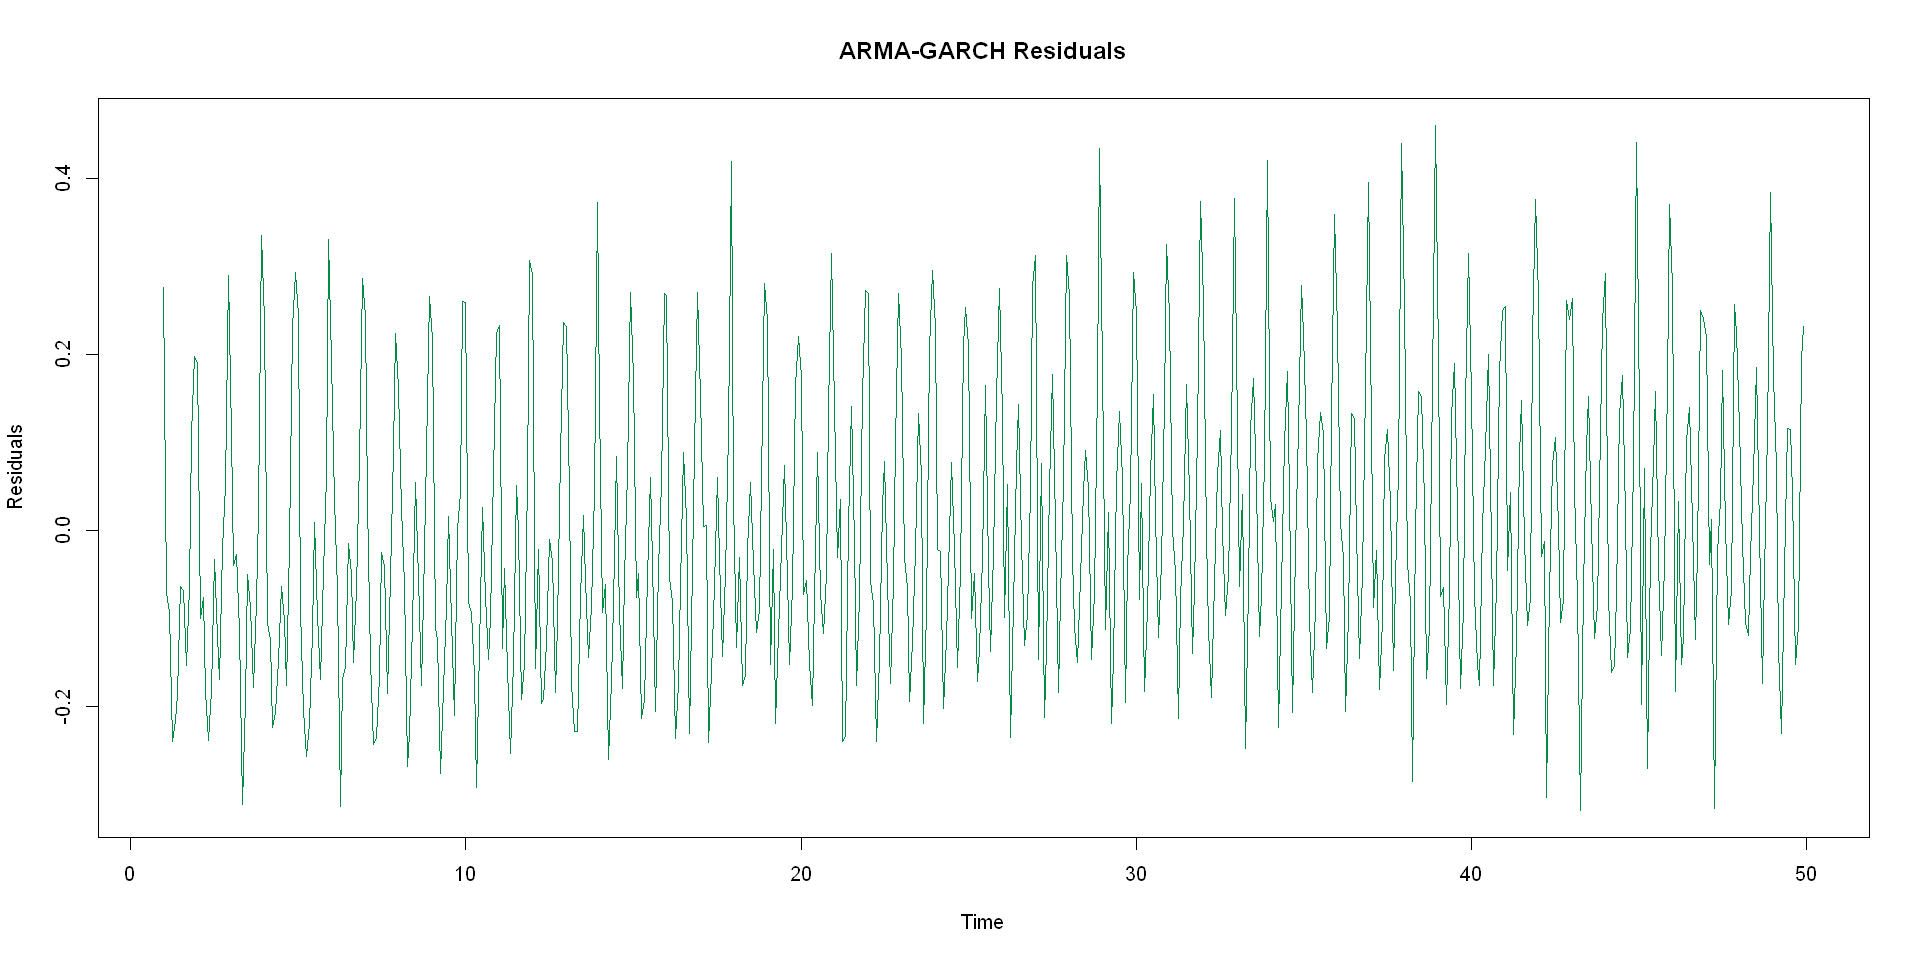

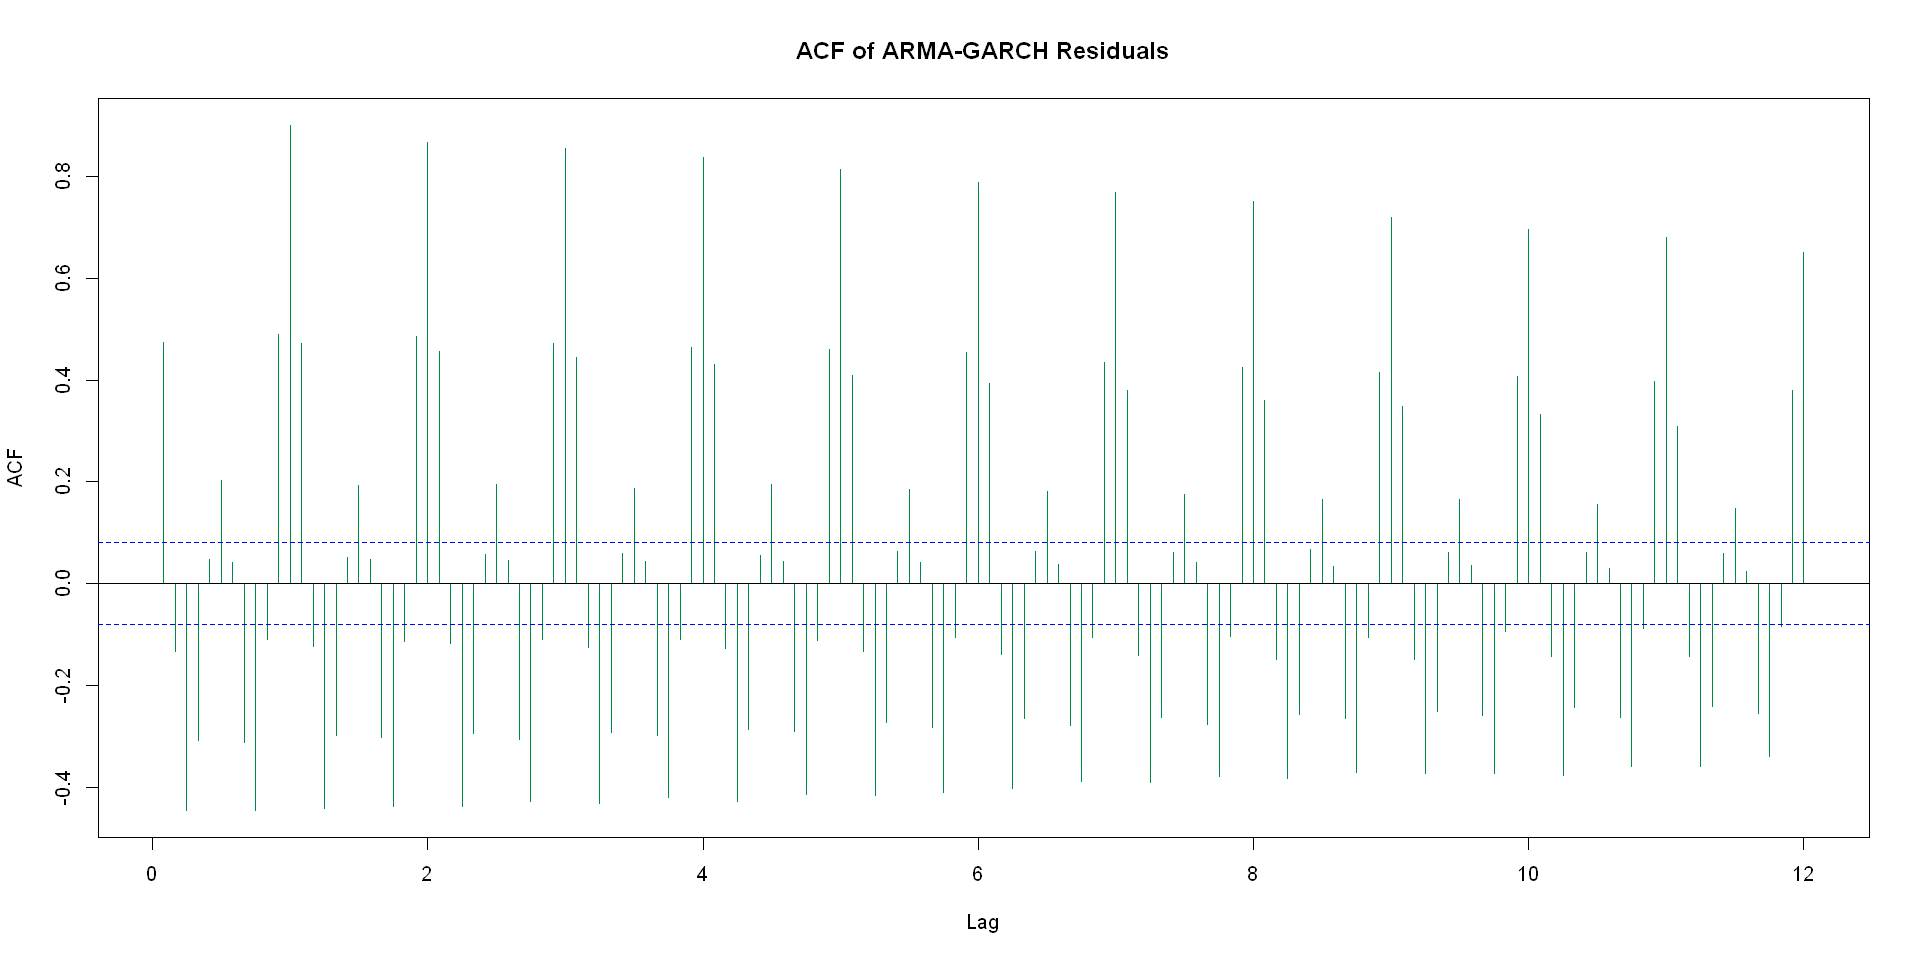


	Box-Ljung test

data:  model.resid_RS
X-squared = 401.15, df = 8, p-value < 2.2e-16



	Box-Ljung test

data:  model.resid_RS^2
X-squared = 98.079, df = 8, p-value < 2.2e-16


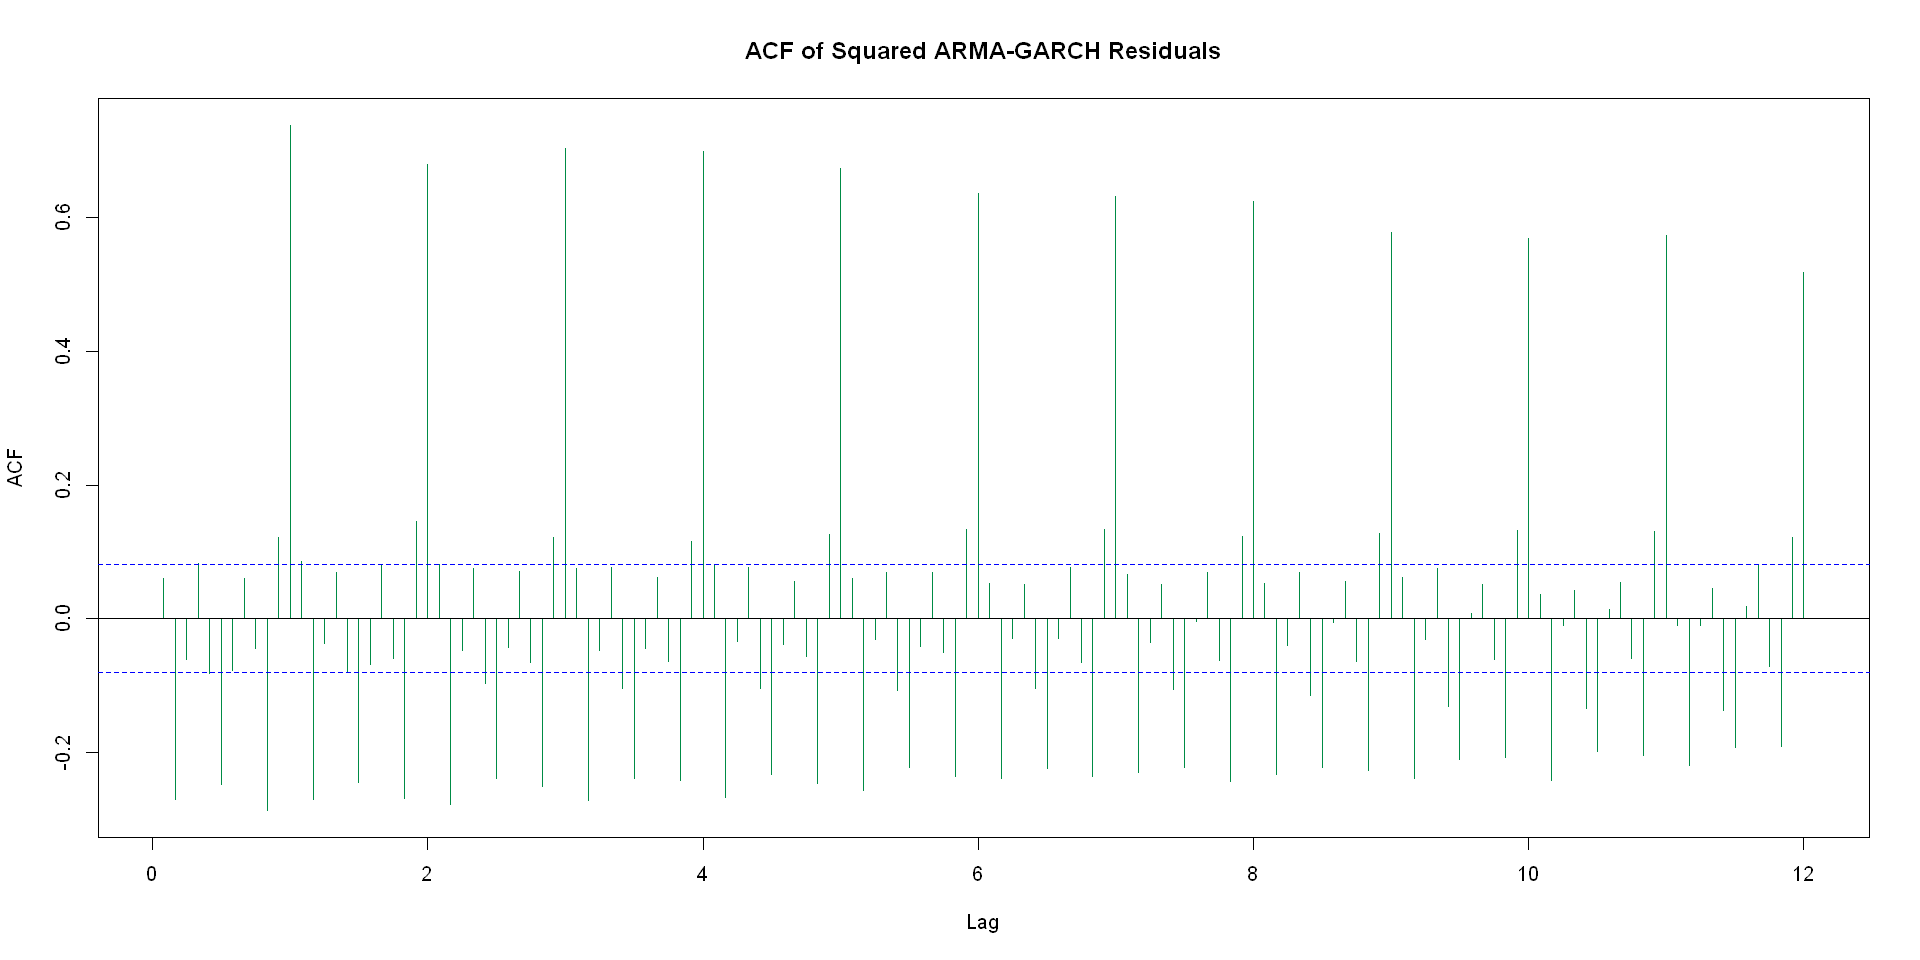

In [42]:
## Residual Analysis
model.resid_RS = residuals(model_RS)

#plot the residuals introduced removing the trend and seasonality
ts.plot(ts(model.resid_RS,frequency=12),col=col1,ylab="Residuals", main="ARMA-GARCH Residuals")

acf(model.resid_RS,lag.max=12*12,col=col1,main="ACF of ARMA-GARCH Residuals")
acf(model.resid_RS^2,lag.max=12*12,col=col1,main="ACF of Squared ARMA-GARCH Residuals")
Box.test(model.resid_RS,lag=8,type='Ljung')
Box.test(model.resid_RS^2,lag=8,type='Ljung')



##### Comments

The residuals plot looks stationary.The stationarity was also confirmed by running an ADF test that shows a small p-value. However, the ACF plot shows strong autocorrelation and the seasonality is still visible.

##### Plot the ARMA-GARCH predictions



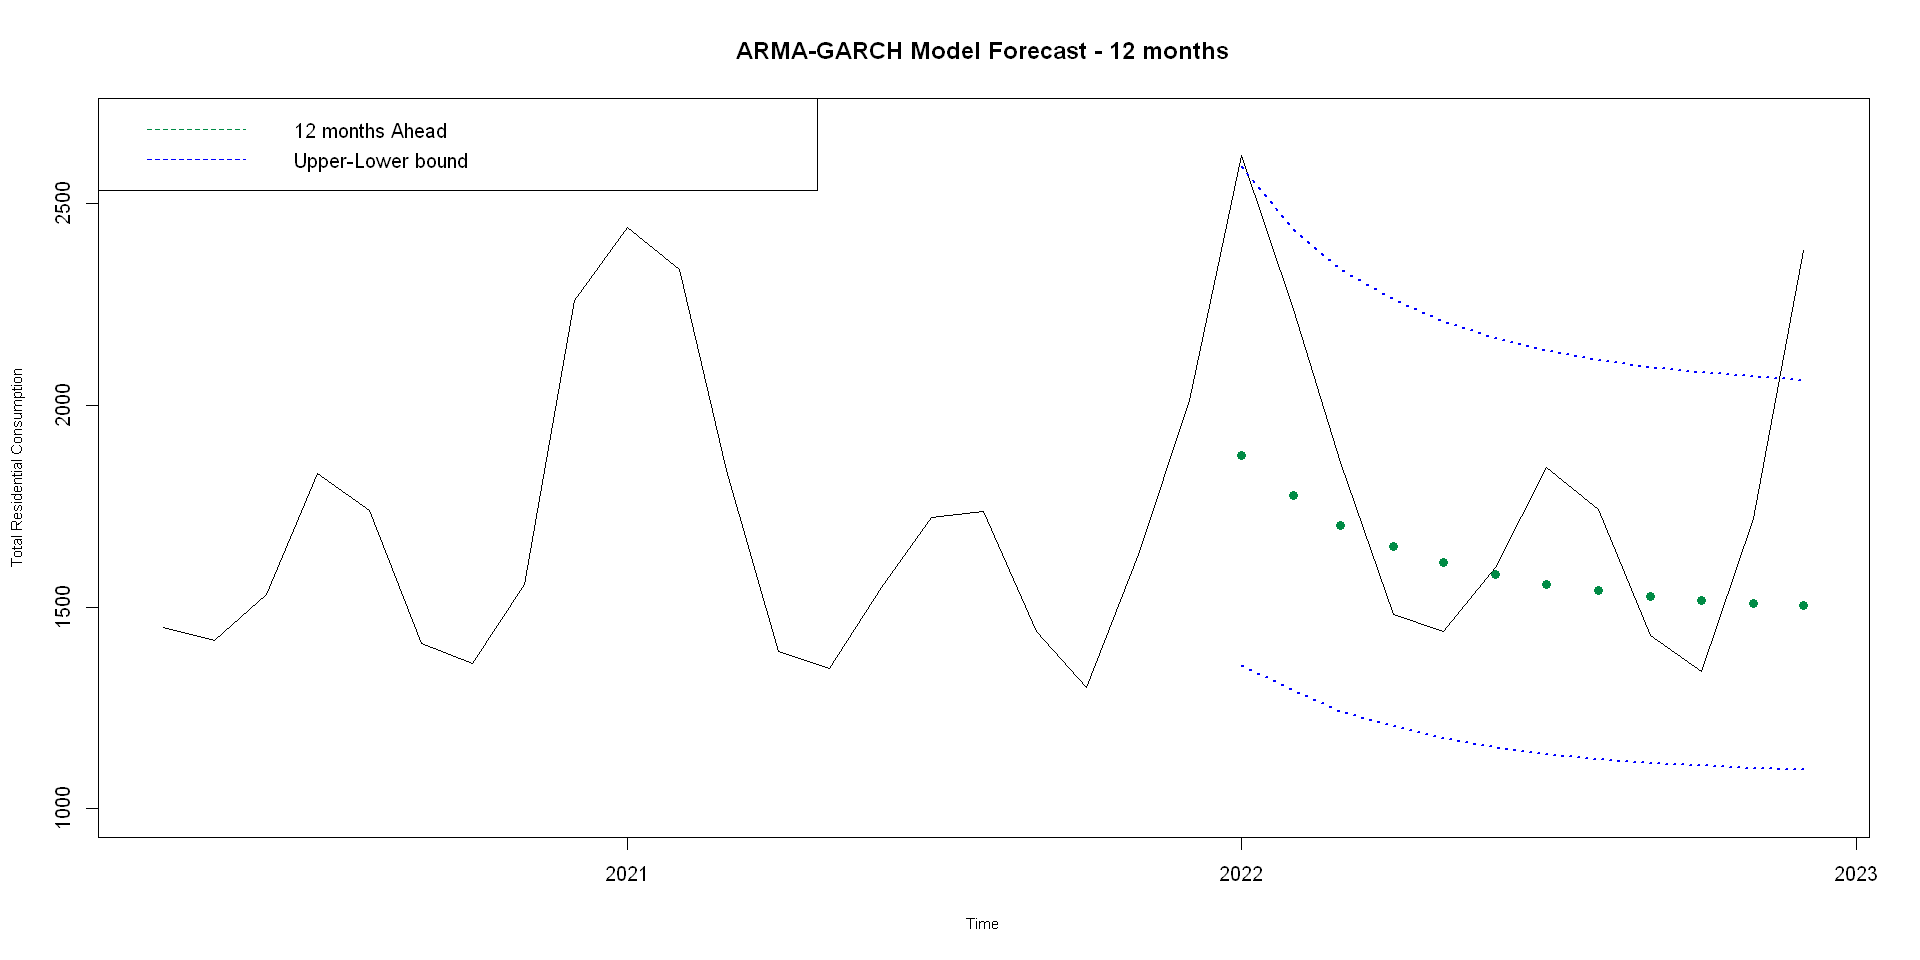

In [43]:
# predict 12 months ahead
n.tot=length(Total_RS.ts)
nfit.tot=n.tot-12

fore_RS = ugarchforecast(model_RS, n.ahead = 12)

model_RS_pred  = exp(fore_RS@forecast$seriesFor)

ubound2 = exp(fore_RS@forecast$seriesFor+1.96*fore_RS@forecast$sigmaFor)
lbound2 = exp(fore_RS@forecast$seriesFor-1.96*fore_RS@forecast$sigmaFor)
ymin2 = min(lbound2)-100
ymax2 = max(ubound2)+100

plot(energy_data$dates[(nfit.tot-20):n.tot],exp(Total_RS.ts[(nfit.tot-20):n.tot]),type="l", ylim=c(ymin2,ymax2), xlab="Time", ylab="Total Residential Consumption", cex.lab=1, main="ARMA-GARCH Model Forecast - 12 months")
points(energy_data$dates[(nfit.tot+1):n.tot],model_RS_pred,col=col1,pch=16)
lines(energy_data$dates[(nfit.tot+1):n.tot],ubound2,lty=3,lwd= 2, col="blue")
lines(energy_data$dates[(nfit.tot+1):n.tot],lbound2,lty=3,lwd= 2, col="blue")
legend('topleft', legend=c("12 months Ahead ","Upper-Lower bound"),lty = 2, col=c(col1,"blue"))



##### Accuracy measures



In [44]:
## Compute Accuracy Measures
RS_true = as.vector(exp(Total_RS.ts[(nfit.tot+1):n.tot]))

fore_RS = ugarchforecast(model_RS, n.ahead = 12)

model_RS_pred  = exp(fore_RS@forecast$seriesFor)

### Mean Absolute Percentage Error (MAPE)
mean(abs(model_RS_pred-RS_true)/RS_true)
### Precision Measure (PM)
sum((model_RS_pred-RS_true)^2)/sum((RS_true-mean(RS_true))^2)



[1] 0.1483261

[1] 0.9965401


##### Comments

From the plot, we can see that the model does not do a good job predicting the volatility present in the data, The MAPE of the ARMA-GARCH model for the residential consumption is higher than the SARIMA model. The precision measure is close to 1, meaning that the variability in the predictions is similar to the variability in the observed data over the prediction period. However, the SARIMA model has a lower PM value (0.102295) compared to the ARMA-GARCH model indicating better performance.

# Commercial

From the time series plots above, it appears there is both trend and seasonality present in the data. Let's fit a model to account for both trend and seasonality.

In [45]:
month.cs = as.factor(format(energy_data$dates, '%b'))

#week = as.factor(weekdays(weekly$week))
## Fit a non-parametric model for trend and anova for monthly seasonality
time.pts = c(1:length(Total_CS.ts))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

model_cs.1 = gam(Total_CS.ts ~ s(time.pts) + month.cs-1)

summary(model_cs.1)


Family: gaussian 
Link function: identity 

Formula:
Total_CS.ts ~ s(time.pts) + month.cs - 1

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
month.csApr 7.006714   0.007124   983.5   <2e-16 ***
month.csAug 7.075287   0.007124   993.2   <2e-16 ***
month.csDec 7.216758   0.007125  1012.8   <2e-16 ***
month.csFeb 7.179073   0.007125  1007.6   <2e-16 ***
month.csJan 7.287365   0.007125  1022.7   <2e-16 ***
month.csJul 7.082202   0.007124   994.2   <2e-16 ***
month.csJun 7.023368   0.007124   985.9   <2e-16 ***
month.csMar 7.145006   0.007124  1002.9   <2e-16 ***
month.csMay 6.996194   0.007124   982.1   <2e-16 ***
month.csNov 7.059373   0.007125   990.8   <2e-16 ***
month.csOct 6.998444   0.007124   982.3   <2e-16 ***
month.csSep 6.981361   0.007124   980.0   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df    F p-value    
s(time.pts) 8.133  8.797 1434  <2e-16 

Summary output Analysis:
All predicting variables are statistically significant, however, we still require residual analysis to understand model fit.

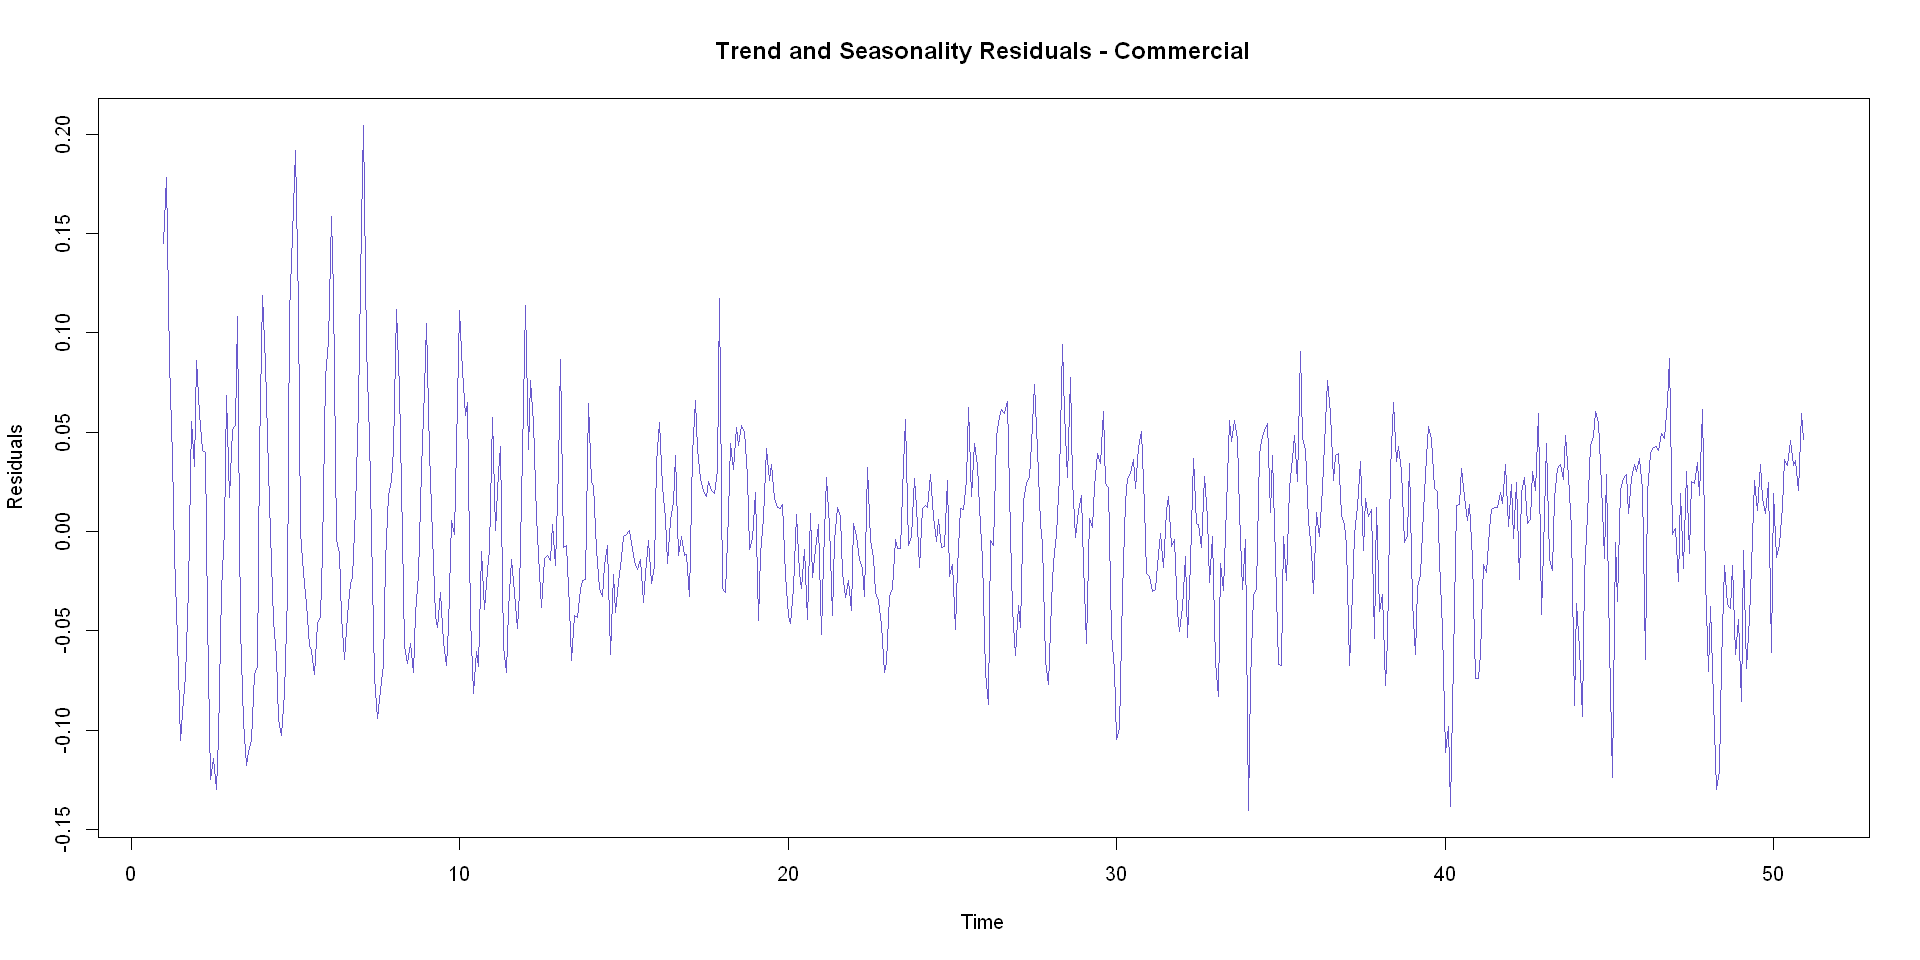

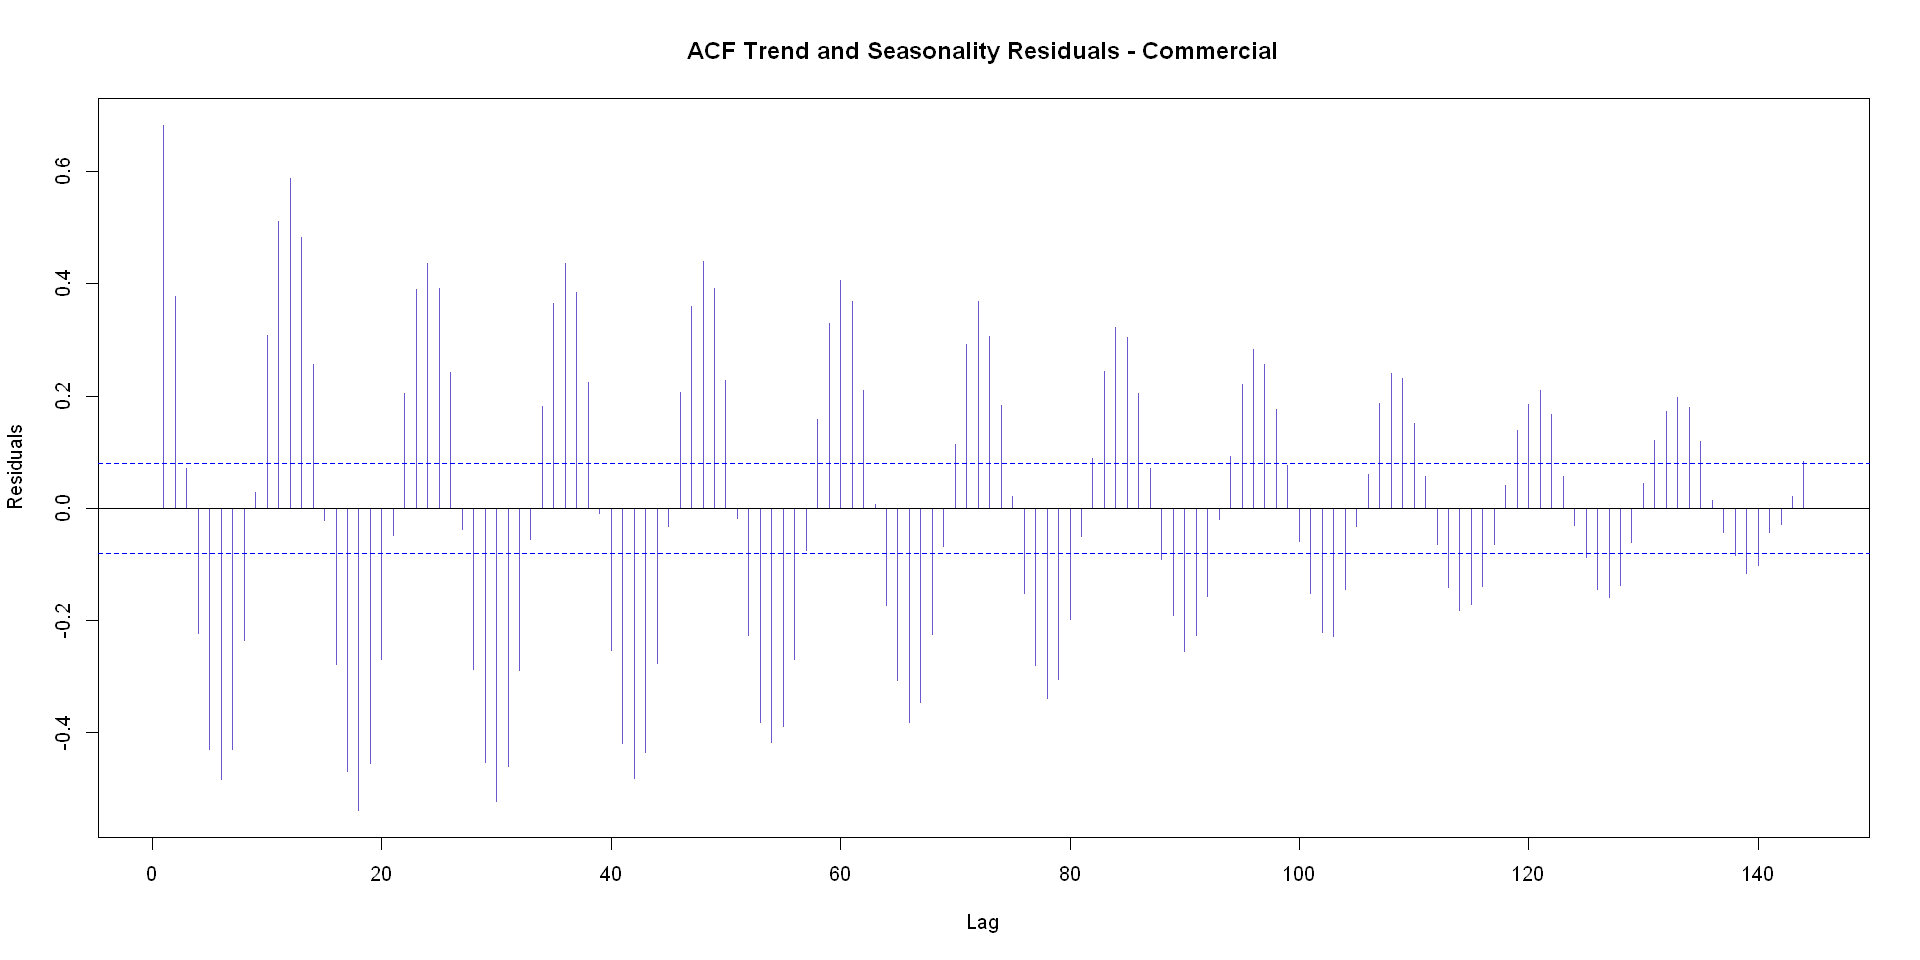

Warning message in adf.test(resid(model_cs.1)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  resid(model_cs.1)
Dickey-Fuller = -7.791, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


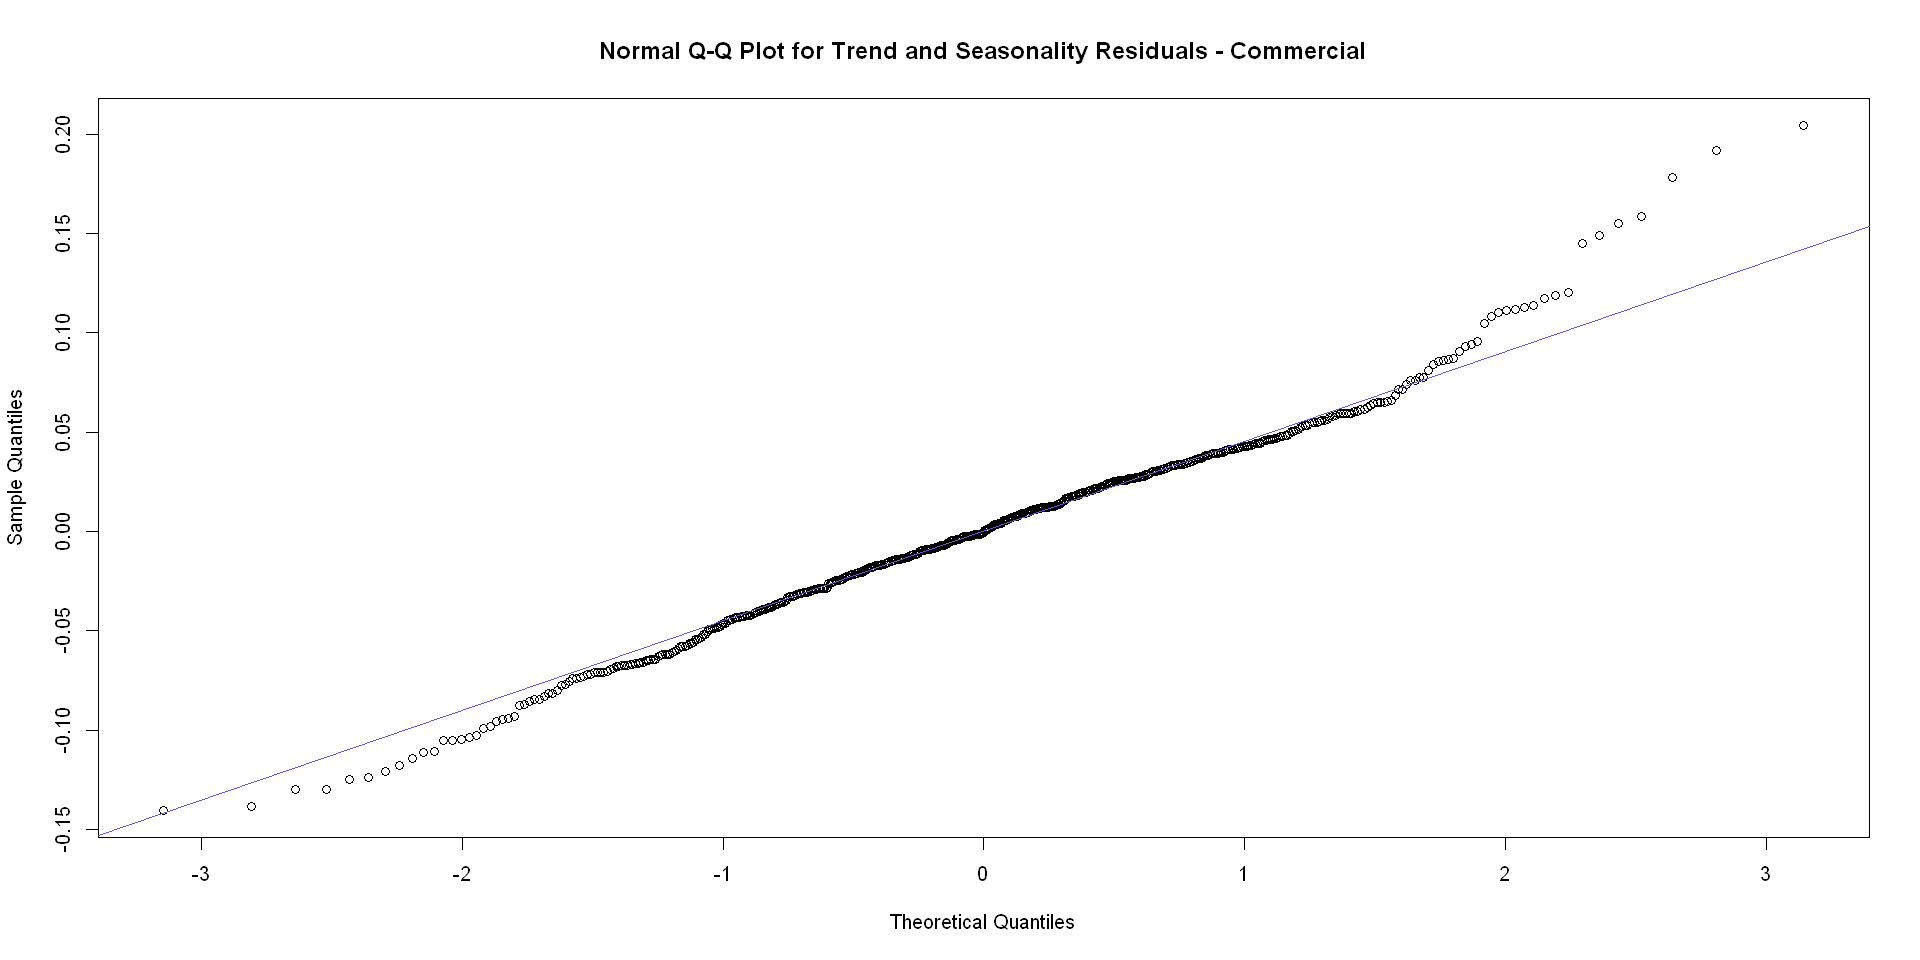

In [46]:
#Residual Analysis
ts.plot(ts(resid(model_cs.1),frequency=12),col = "slateblue3",ylab="Residuals", main="Trend and Seasonality Residuals - Commercial")

acf(resid(model_cs.1),lag.max = 12*12,col="slateblue3",ylab="Residuals", main="ACF Trend and Seasonality Residuals - Commercial")

qqnorm(resid(model_cs.1),main = "Normal Q-Q Plot for Trend and Seasonality Residuals - Commercial")
qqline(resid(model_cs.1),col="slateblue3")

adf.test(resid(model_cs.1))

Interpretation: from the qqplot we can see the residuals are still heavy tailed, and from the ACF plot there are obvious signs of non-stationarity due to significant and cyclical (repeating) patterns. This suggests we would require further modelling and analysis to compensate for this additional seasonality, perhaps with ARIMA (SARIMA) modelling.

## SARIMA Modelling - Commercial

In [47]:
#split data into train and test
n=length(Total_CS.ts)
nfit.Total_CS=n-12
Total_CS.train.ts=ts(Total_CS.ts[1:nfit.Total_CS],start=1973,frequency=12)

SARIMA_CS <- find_best_arima(Total_CS.train.ts)
SARIMA_CS
#Best SARIMA plot is ARIMA(2,0,1)x(1,1,1) ~ very similar to what we've seen in Residential

Series: data 
ARIMA(3,1,3)(1,0,2)[12] 

Coefficients:
          ar1      ar2     ar3      ma1     ma2      ma3    sar1     sma1
      -0.1843  -0.6532  0.5015  -0.2659  0.3615  -0.9430  0.9959  -0.6727
s.e.   0.0442   0.0305  0.0440   0.0184  0.0141   0.0179  0.0018   0.0472
         sma2
      -0.0752
s.e.   0.0440

sigma^2 = 0.001047:  log likelihood = 1165.83
AIC=-2311.67   AICc=-2311.29   BIC=-2267.92

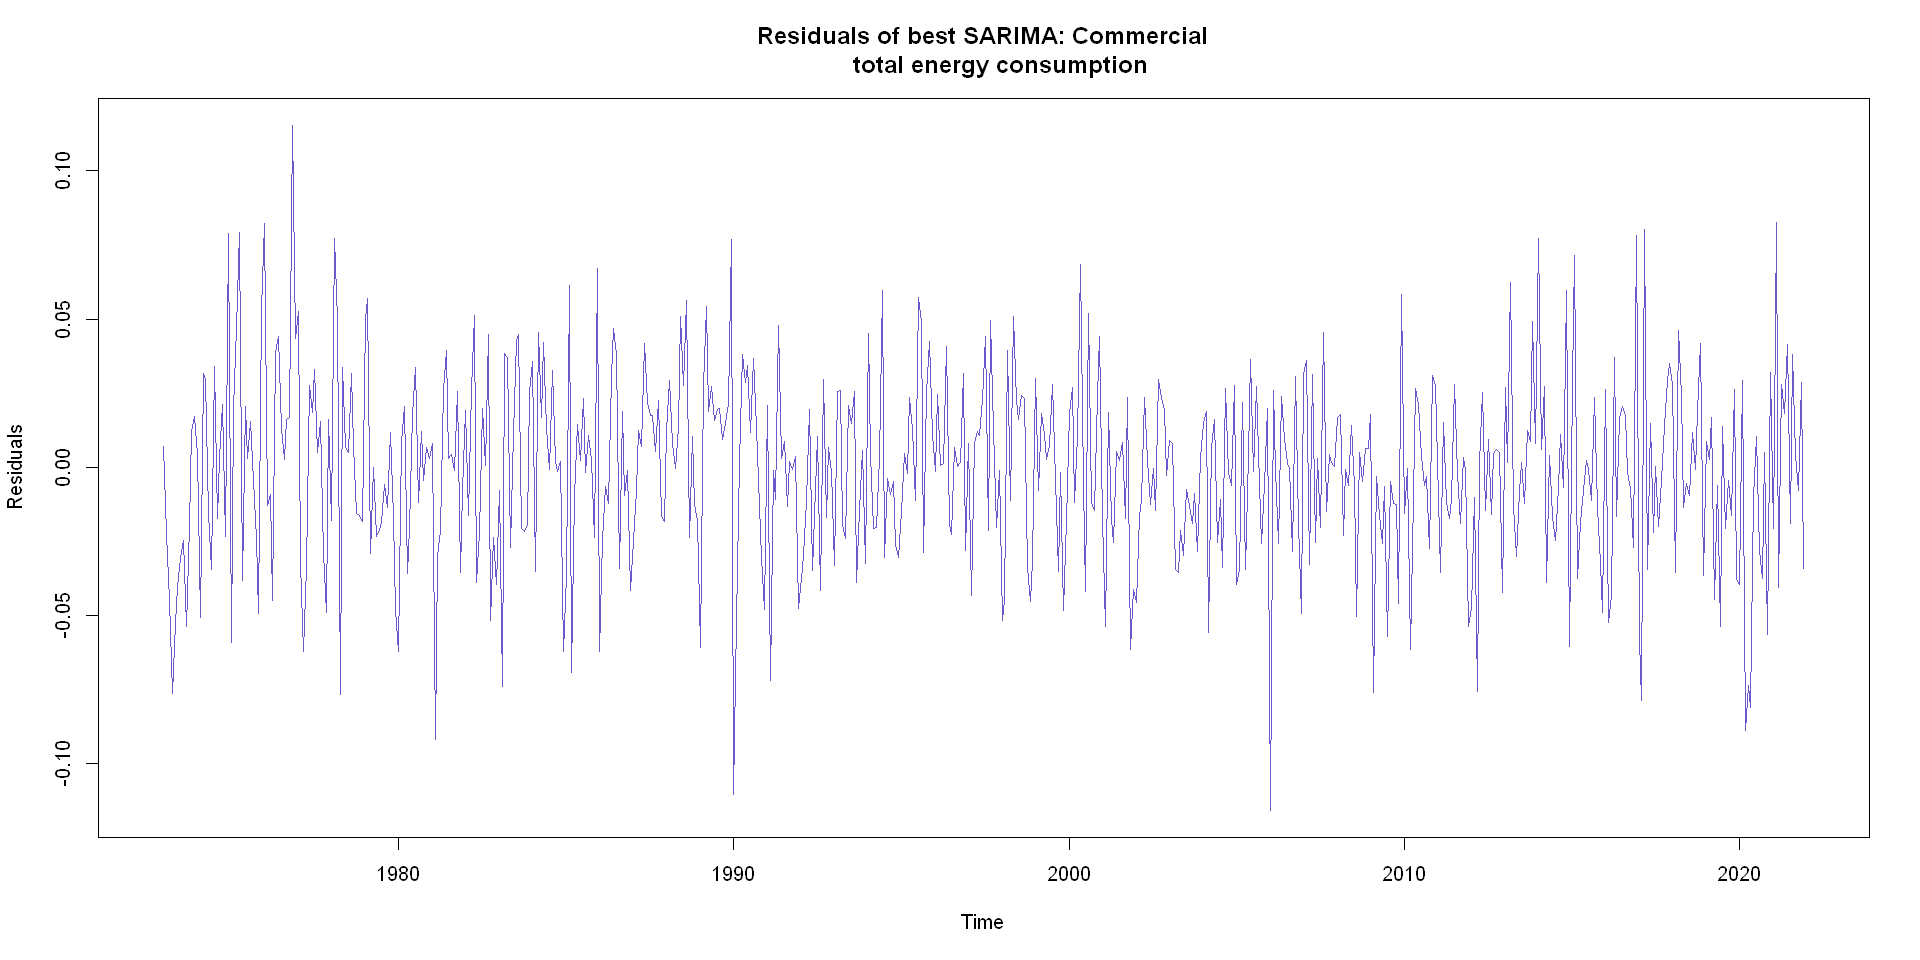

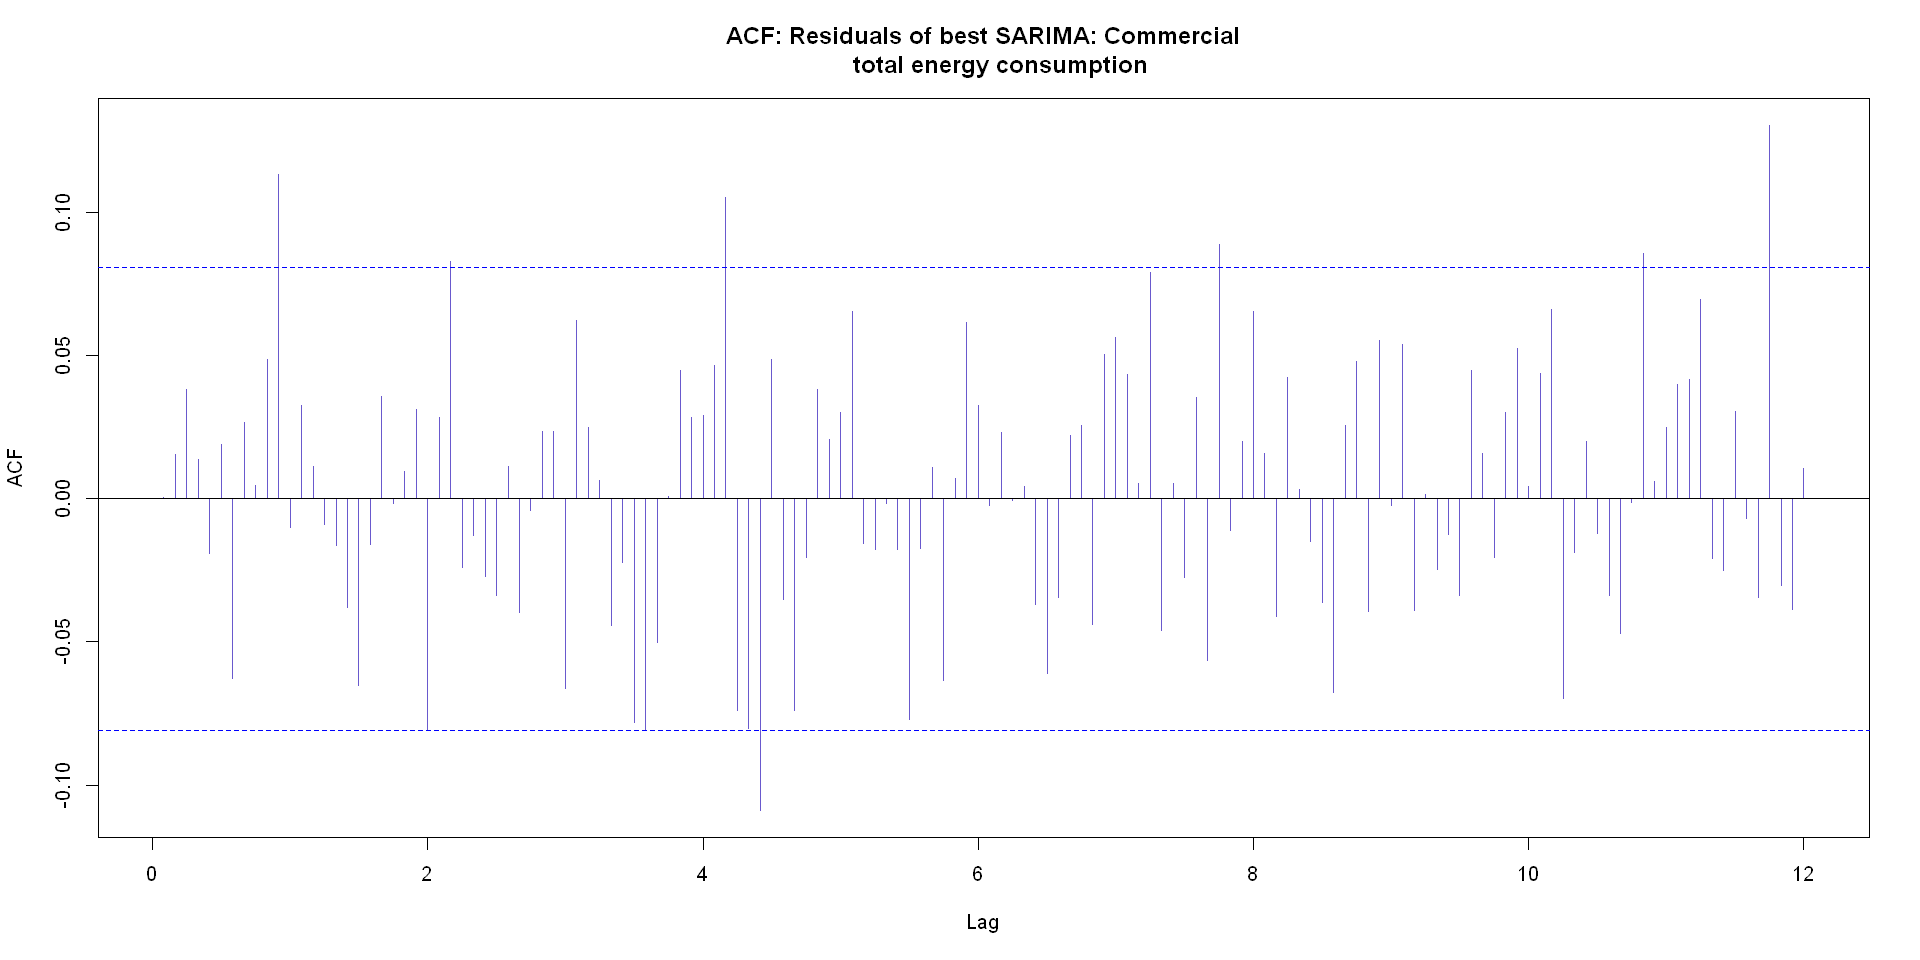

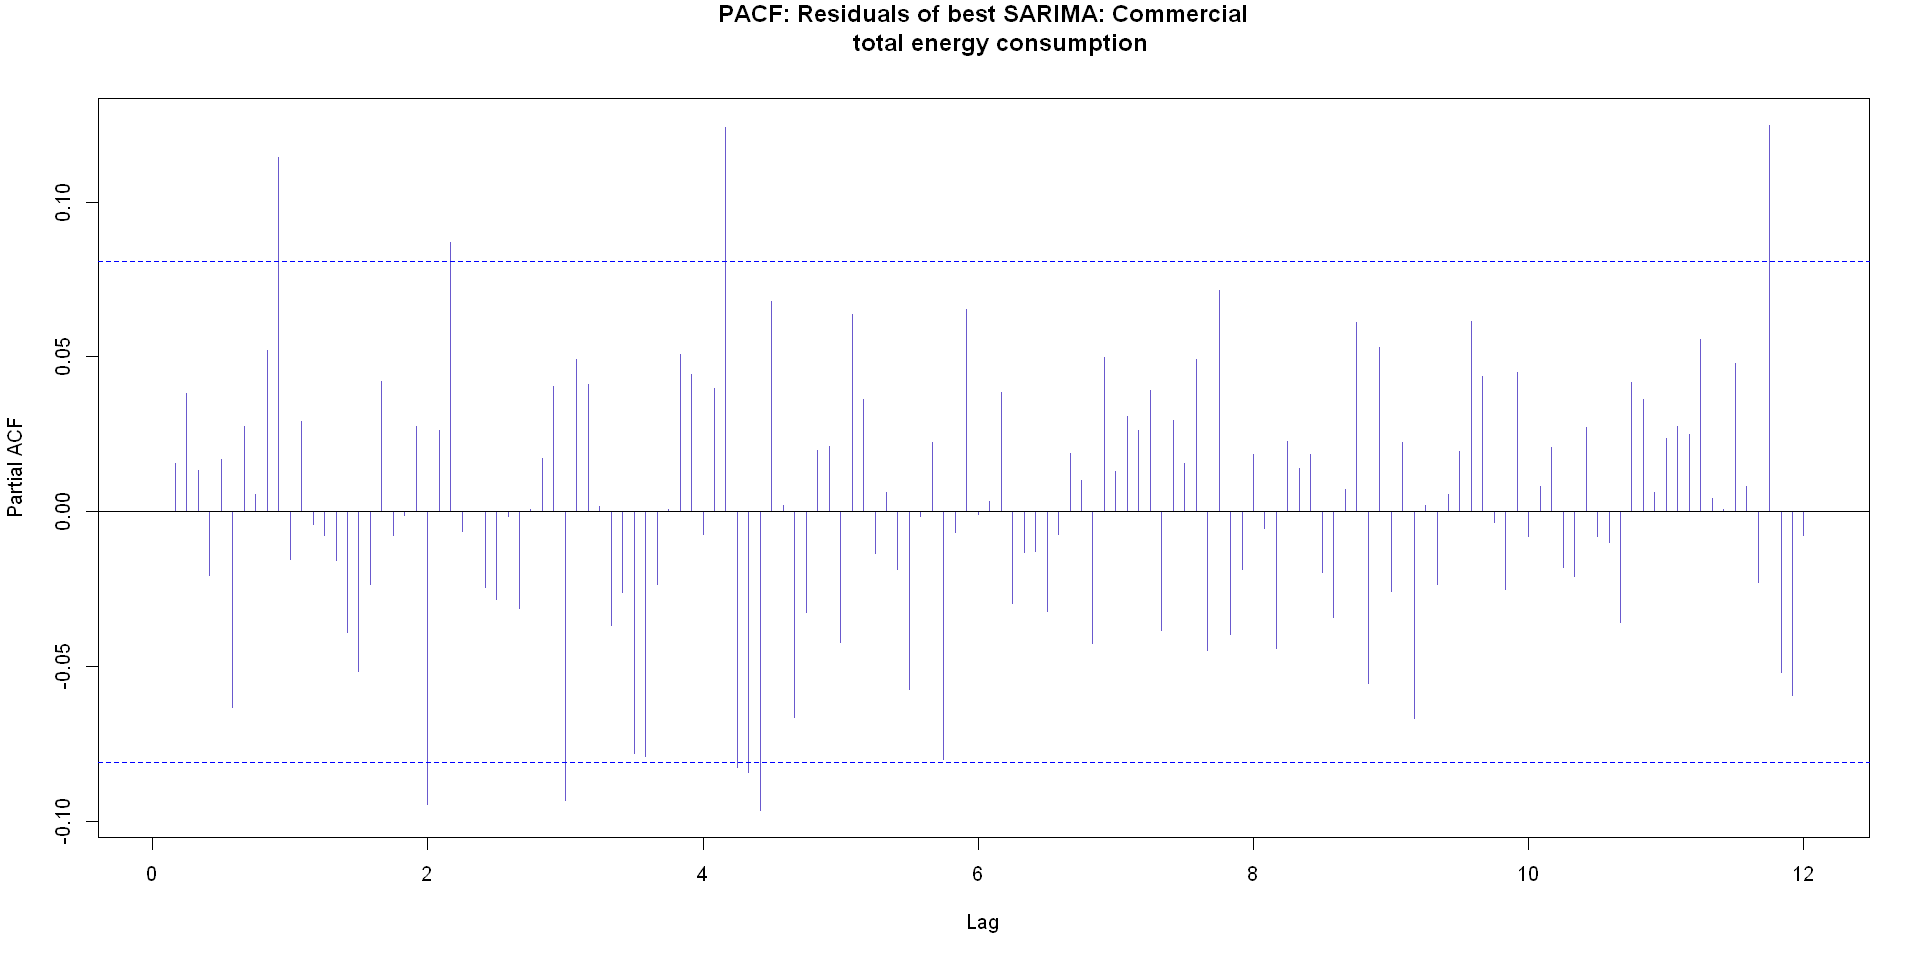

[1]  47 397

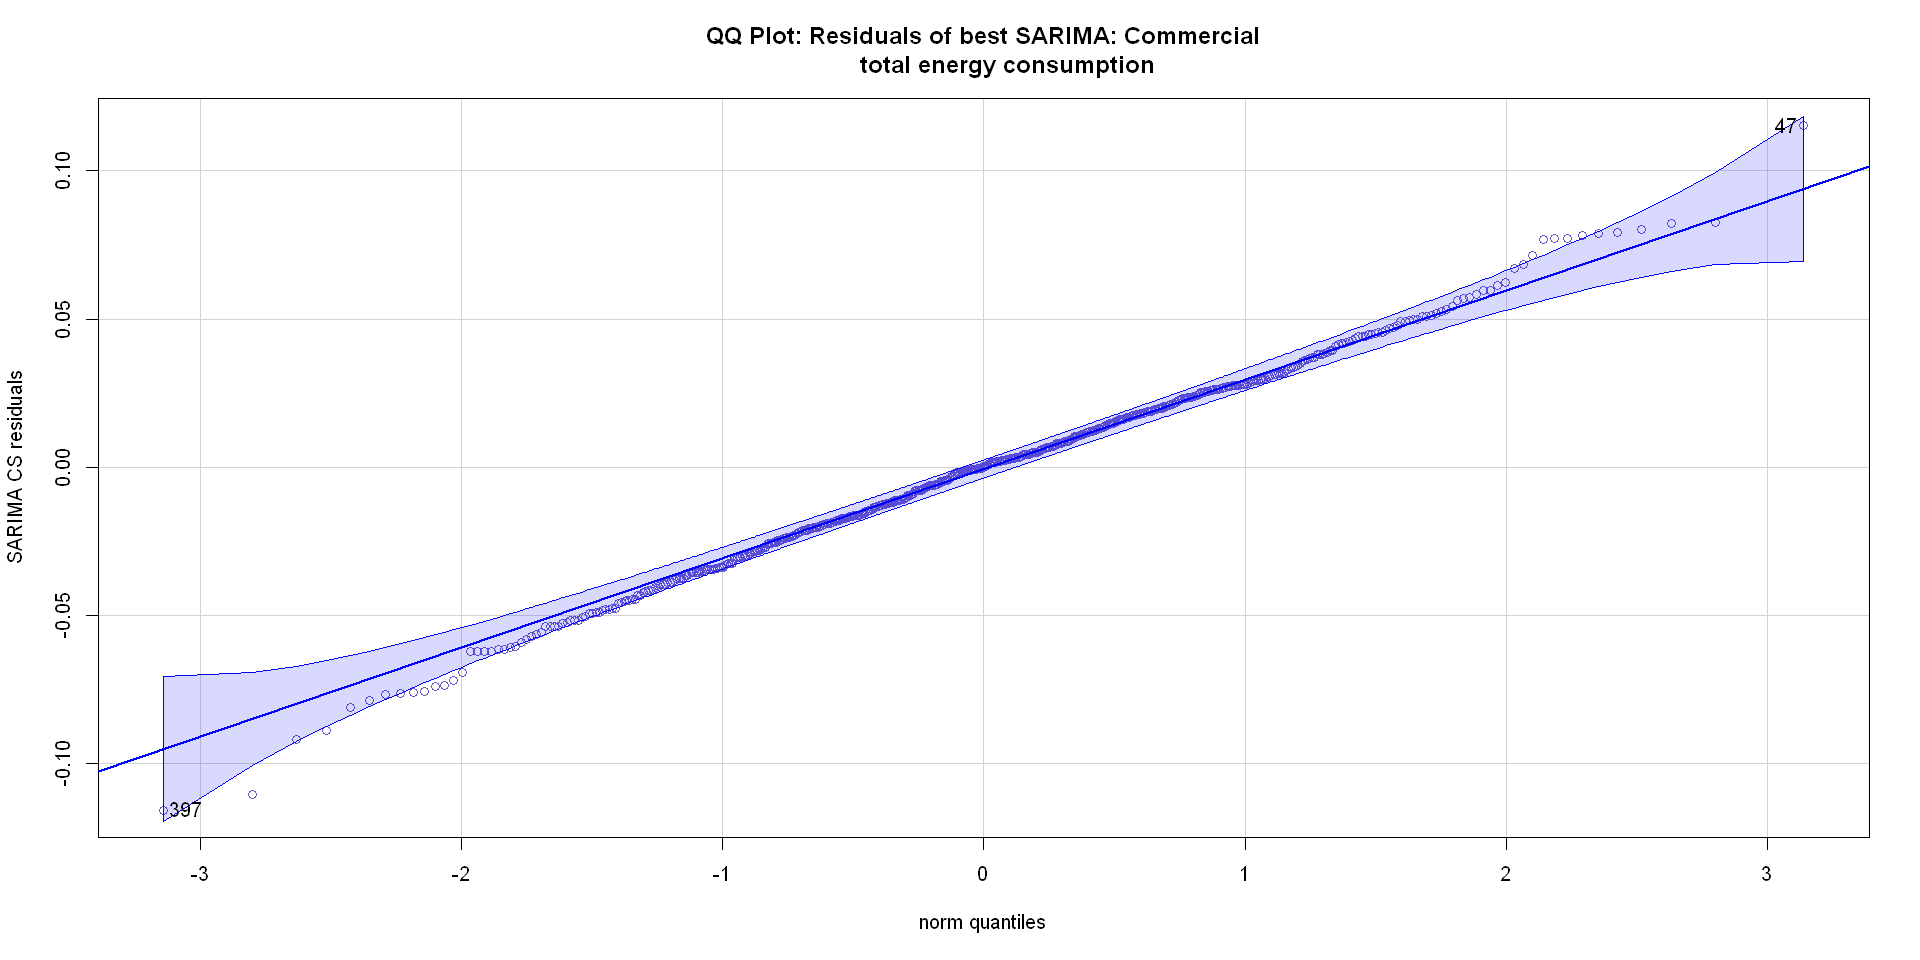

In [48]:
#Diagnostic Plots
#Plot Residuals from SARIMA CS model
plot(SARIMA_CS$residuals,ylab="Residuals",main="Residuals of best SARIMA: Commercial
     total energy consumption",col="slateblue3")

#Plot ACF of SARIMA CS
acf(SARIMA_CS$residuals,lag.max = 12*12,main="ACF: Residuals of best SARIMA: Commercial
     total energy consumption",col="slateblue3")
#Plot PACF of SARIMA CS model
pacf(SARIMA_CS$residuals,lag.max = 12*12,main="PACF: Residuals of best SARIMA: Commercial
     total energy consumption",col="slateblue3")

###qqplot
qqPlot(residuals(SARIMA_CS),ylab="SARIMA CS residuals",main="QQ Plot: Residuals of best SARIMA: Commercial
       total energy consumption",col="slateblue3")

We can see that the variation has decreased when applying SARIMA to commercial sector, however we still see shocks of variation around 1990, 2008, and prior to 1980. This could be in relation to external, influential world events such as economic inflation, crashes, or geopolitical conflict which could impact energy consumption or availability of energy in general. :

In [52]:
# Test and see if residuals are correlated
Box.test(residuals(SARIMA_CS), lag = (SARIMA_CS$arma[1]+SARIMA_CS$arma[2]+1), type = "Box-Pierce", fitdf = (SARIMA_CS$arma[1]+SARIMA_CS$arma[2]))
Box.test(residuals(SARIMA_CS), lag = (SARIMA_CS$arma[1]+SARIMA_CS$arma[2]+1), type = "Ljung-Box", fitdf = (SARIMA_CS$arma[1]+SARIMA_CS$arma[2]))


	Box-Pierce test

data:  residuals(SARIMA_CS)
X-squared = 3.8448, df = 1, p-value = 0.0499



	Box-Ljung test

data:  residuals(SARIMA_CS)
X-squared = 3.8955, df = 1, p-value = 0.04842


Both results to the hypothesis tests above are greater than 0.05, thus we fail to reject the null hypothesis of uncorrelated residuals.

## Prediction - Commercial

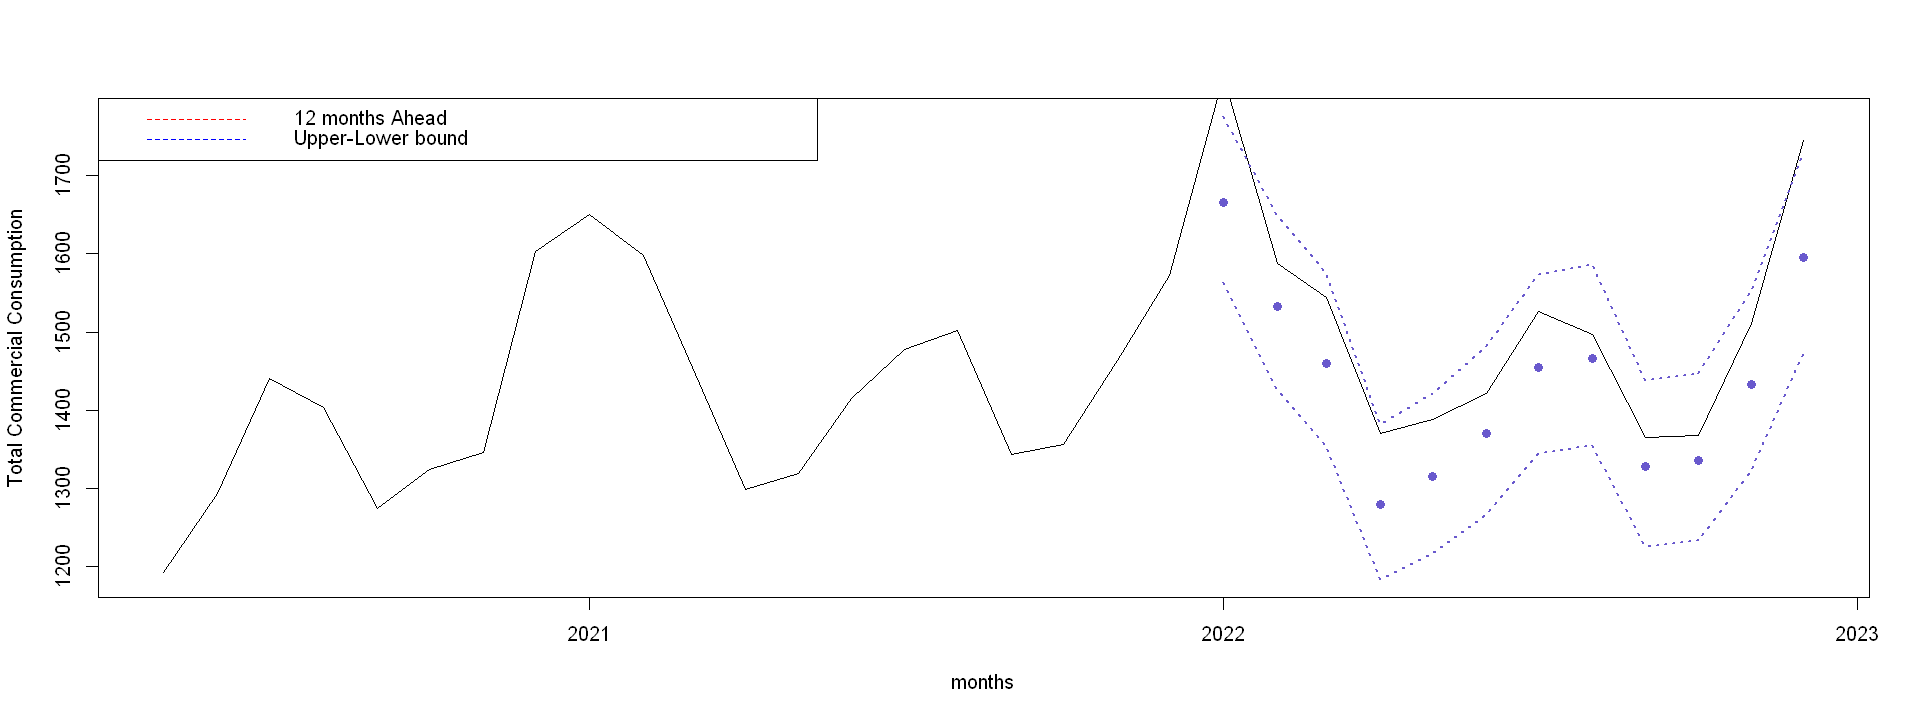

In [393]:
# predict 12 months ahead
n=length(Total_CS.ts)
nfit=n-12+1

n_forward=12
cs.outpred = predict(SARIMA_CS,n.ahead=12)
cs.ubound = exp(cs.outpred$pred+1.96*cs.outpred$se)
cs.lbound = exp(cs.outpred$pred-1.96*cs.outpred$se)
cs.ymin = min(cs.lbound)
cs.ymax = max(cs.ubound)

plot(energy_data$dates[(nfit-20):n],exp(Total_CS.ts[(nfit-20):n]),type="l", ylim=c(cs.ymin,cs.ymax), xlab="months", ylab="Total Commercial Consumption")
points(energy_data$dates[nfit:n],exp(cs.outpred$pred),col=col2,pch=16)
lines(energy_data$dates[nfit:n],cs.ubound,lty=3,lwd= 2, col=col2)
lines(energy_data$dates[nfit:n],cs.lbound,lty=3,lwd= 2, col=col2)
legend('topleft', legend=c("12 months Ahead ","Upper-Lower bound"),lty = 2, col=c("red","blue"))

In [54]:
## Compute Accuracy Measures
CS_true = as.vector(exp(Total_CS.ts[(nfit):n]))
CS_SARIMA_pred = exp(cs.outpred$pred)

### Mean Absolute Percentage Error (MAPE)
mean(abs(CS_SARIMA_pred-CS_true)/CS_true)
### Precision Measure (PM)
sum((CS_SARIMA_pred-CS_true)^2)/sum((CS_true-mean(CS_true))^2)
#Review Accuracy measure interpretation

[1] 0.04888224

[1] 0.3613617

## ARMA-GARCH Commercial

In [55]:
suppressWarnings({
# Step 1
test_modelB <- function(p,d,q){
  mod = arima(Total_CS.train.ts, order=c(p,d,q), method="ML")
  current.aic <- AIC(mod)
  current.aic<-current.aic-2*(p+q+1)+2*(p+q+1)*n/(n-p-q-2)
  df = data.frame(p,d,q,current.aic)
  names(df) <- c("p","d","q","AIC")
  #print(paste(p,d,q,current.aic,sep=" "))
  return(df)
}

orders <- data.frame(Inf,Inf,Inf,Inf)
names(orders) <- c("p","d","q","AIC")
for (p in 0:5){
  for(d in 0:2) {
    for (q in 0:5) {
      possibleError <- tryCatch(
        orders<-rbind(orders,test_modelB(p,d,q)),
        error=function(e) e
      )
      if(inherits(possibleError, "error")) next
    }
  }
}

})
orders <- orders[order(-orders$AIC),]
tail(orders)

#ARIMA (5, 1, 5) with AIC = -1699.133

,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
108,5,2,4,-1600.545
91,4,2,5,-1601.070
102,5,1,4,-1603.033
96,5,0,4,-1655.012
97,5,0,5,-1682.670
103,5,1,5,-1699.139


In [56]:
suppressWarnings({
#Initial GARCH Order
#ARIMA-GARCH: Select GARCH order
test_modelAGG <- function(m,n){
  spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                    mean.model=list(armaOrder=c(5,5), ######based on the above selection
                                    include.mean=T),
                    distribution.model="std")
  fit = ugarchfit(spec, Total_CS.train.ts, solver = 'hybrid')
  current.bic = infocriteria(fit)[2]
  df = data.frame(m,n,current.bic)
  names(df) <- c("m","n","BIC")
  print(paste(m,n,current.bic,sep=" "))
  return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
  for (n in 0:2){
    possibleError <- tryCatch(
      ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
      error=function(e) e
    )
    if(inherits(possibleError, "error")) next
  }
}

})
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

# GARCH (1,1)

[1] "0 1 -2.71241754387312"
[1] "0 2 -2.70500670169668"
[1] "1 0 -2.73083469793551"
[1] "1 1 -2.74714114275427"
[1] "1 2 -2.74347315469203"
[1] "2 0 -2.72745241204429"
[1] "2 1 -2.73439655252402"
[1] "2 2 -2.73035135605155"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
7,2,0,-2.727452
9,2,2,-2.730351
4,1,0,-2.730835
8,2,1,-2.734397
6,1,2,-2.743473
5,1,1,-2.747141


In [57]:
suppressWarnings({
# Step 3
# ARMA update
#ARIMA-GARCH: Select ARIMA order
test_modelAGA <- function(p,q){
  spec = ugarchspec(variance.model=list(garchOrder=c(1,1)), #######updated based on the above
                    mean.model=list(armaOrder=c(p,q),
                                    include.mean=T),
                    distribution.model="std")
  fit = ugarchfit(spec, Total_CS.train.ts, solver = 'hybrid')
  current.bic = infocriteria(fit)[2]
  df = data.frame(p,q,current.bic)
  names(df) <- c("p","q","BIC")
  print(paste(p,q,current.bic,sep=" "))
  return(df)
}

ordersAGA = data.frame(Inf,Inf,Inf)
names(ordersAGA) <- c("p","q","BIC")
for (p in 0:5){
  for (q in 0:5){
    possibleError <- tryCatch(
      ordersAGA<-rbind(ordersAGA,test_modelAGA(p,q)),
      error=function(e) e
    )
    if(inherits(possibleError, "error")) next
  }
}
})
ordersAGA <- ordersAGA[order(-ordersAGA$BIC),]
tail(ordersAGA)
#ARMA (5,5)

[1] "0 0 -0.445794688028482"
[1] "0 1 -1.16648273510977"
[1] "0 2 -1.58706249198545"
[1] "0 3 -1.90287102459987"
[1] "0 4 -1.93856140869879"
[1] "0 5 -2.04245330599234"
[1] "1 0 -1.95957451166266"
[1] "1 1 -2.02385958420987"
[1] "1 2 -2.06266418498816"
[1] "1 3 -2.25056324958655"
[1] "1 4 -2.32856454390449"
[1] "1 5 -2.03224212308744"
[1] "2 0 -2.01592902203824"
[1] "2 1 -2.01279899977734"
[1] "2 2 -2.05023567037117"
[1] "2 3 -2.0638362369495"
[1] "2 4 -2.33795388308858"
[1] "2 5 -2.48523446425947"
[1] "3 0 -2.0235529217305"
[1] "3 2 -2.47453954306425"
[1] "3 3 -2.39437375683831"
[1] "3 4 -2.34411125943364"
[1] "3 5 -2.47369556223931"
[1] "4 0 -2.17515389629177"
[1] "4 1 -2.30407600662264"
[1] "4 2 -2.48427090849598"
[1] "4 3 -2.46636828462087"
[1] "4 4 -2.55676885177877"
[1] "4 5 -2.40682724009636"
[1] "5 0 -2.22481444372849"
[1] "5 1 -2.27743154096365"
[1] "5 2 -2.27249573535622"
[1] "5 3 -2.5005224962806"
[1] "5 4 -2.73053220646345"
[1] "5 5 -2.74714114275427"


,p,q,BIC
,<dbl>,<dbl>,<dbl>
27,4,2,-2.484271
19,2,5,-2.485234
34,5,3,-2.500522
29,4,4,-2.556769
35,5,4,-2.730532
36,5,5,-2.747141


In [58]:
suppressWarnings({
# Step 4
# GARCH update
test_modelAGG <- function(m,n){
  spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                    mean.model=list(armaOrder=c(5,5), ####updated based on the above
                                    include.mean=T), distribution.model="std")
  fit = ugarchfit(spec, Total_CS.train.ts, solver = 'hybrid')
  current.bic = infocriteria(fit)[2]
  df = data.frame(m,n,current.bic)
  names(df) <- c("m","n","BIC")
  print(paste(m,n,current.bic,sep=" "))
  return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
  for (n in 0:2){
    possibleError <- tryCatch(
      ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
      error=function(e) e
    )
    if(inherits(possibleError, "error")) next
  }
}
})
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

# FINAL MODEL ARMA (5,5) GARCH(1,1)

[1] "0 1 -2.71241754387312"
[1] "0 2 -2.70500670169668"
[1] "1 0 -2.73083469793551"
[1] "1 1 -2.74714114275427"
[1] "1 2 -2.74347315469203"
[1] "2 0 -2.72745241204429"
[1] "2 1 -2.73439655252402"
[1] "2 2 -2.73035135605155"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
7,2,0,-2.727452
9,2,2,-2.730351
4,1,0,-2.730835
8,2,1,-2.734397
6,1,2,-2.743473
5,1,1,-2.747141



##### Evaluate Goodness of Fit



In [59]:
### Goodness of Fit ####################################################
train.spec_CS = ugarchspec(variance.model=list(garchOrder=c(1,1)), ###based on above final selection
                    mean.model=list(armaOrder=c(5,5), ####based on above final selection
                                    include.mean=T), distribution.model="std")
model_CS.garch = ugarchfit(train.spec_CS, Total_CS.train.ts, solver = 'hybrid')

## compare Information Criteria
infocriteria(model_CS.garch)


,
Akaike,-2.858792
Bayes,-2.747141
Shibata,-2.860051
Hannan-Quinn,-2.815290



##### Evaluate Residuals



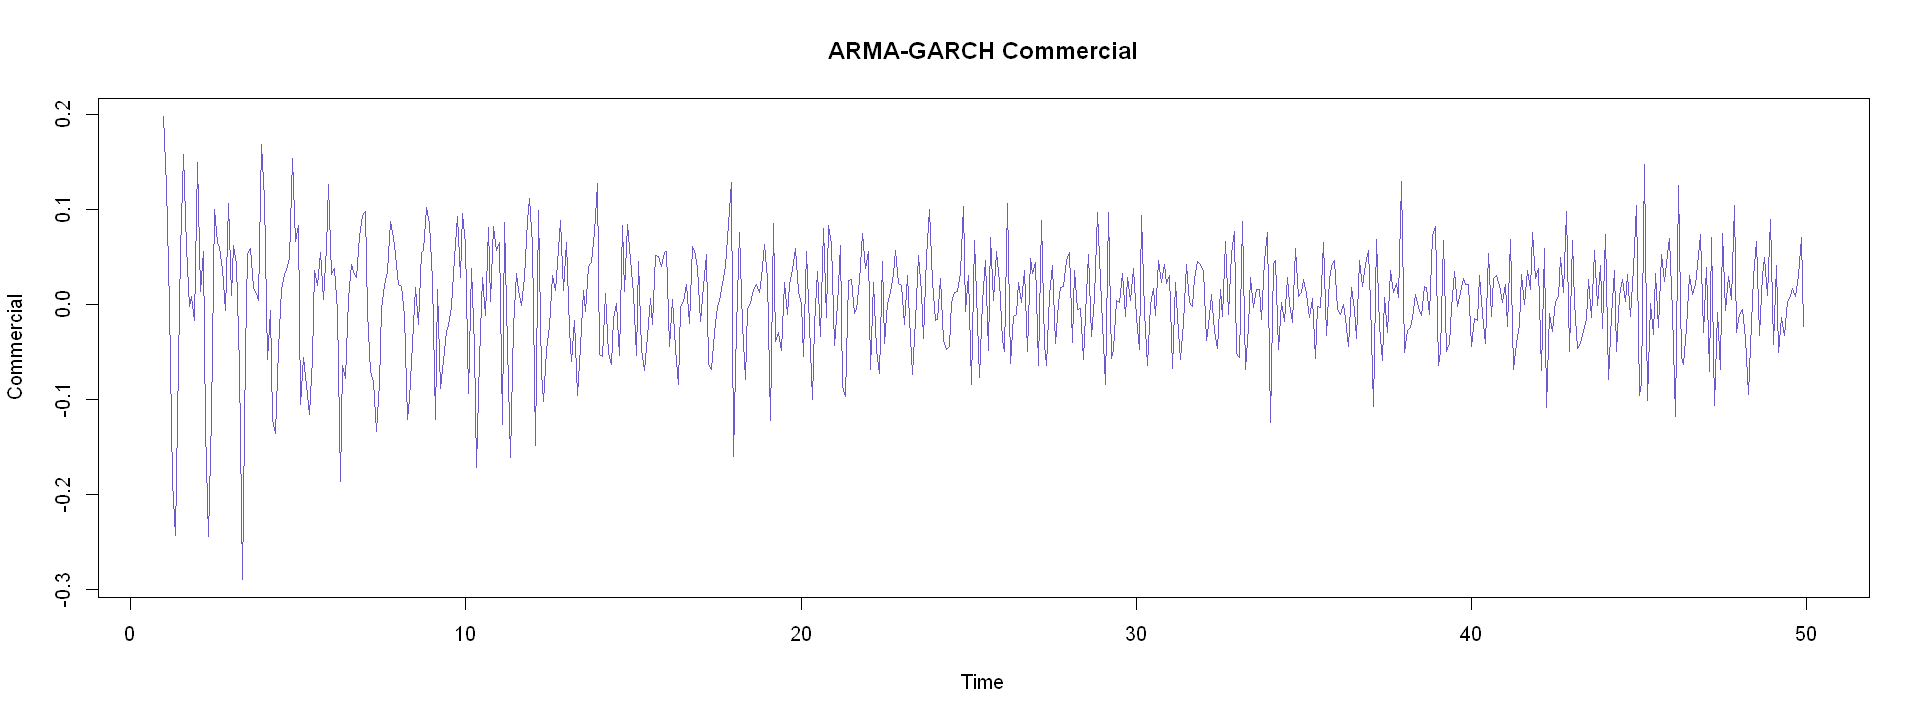

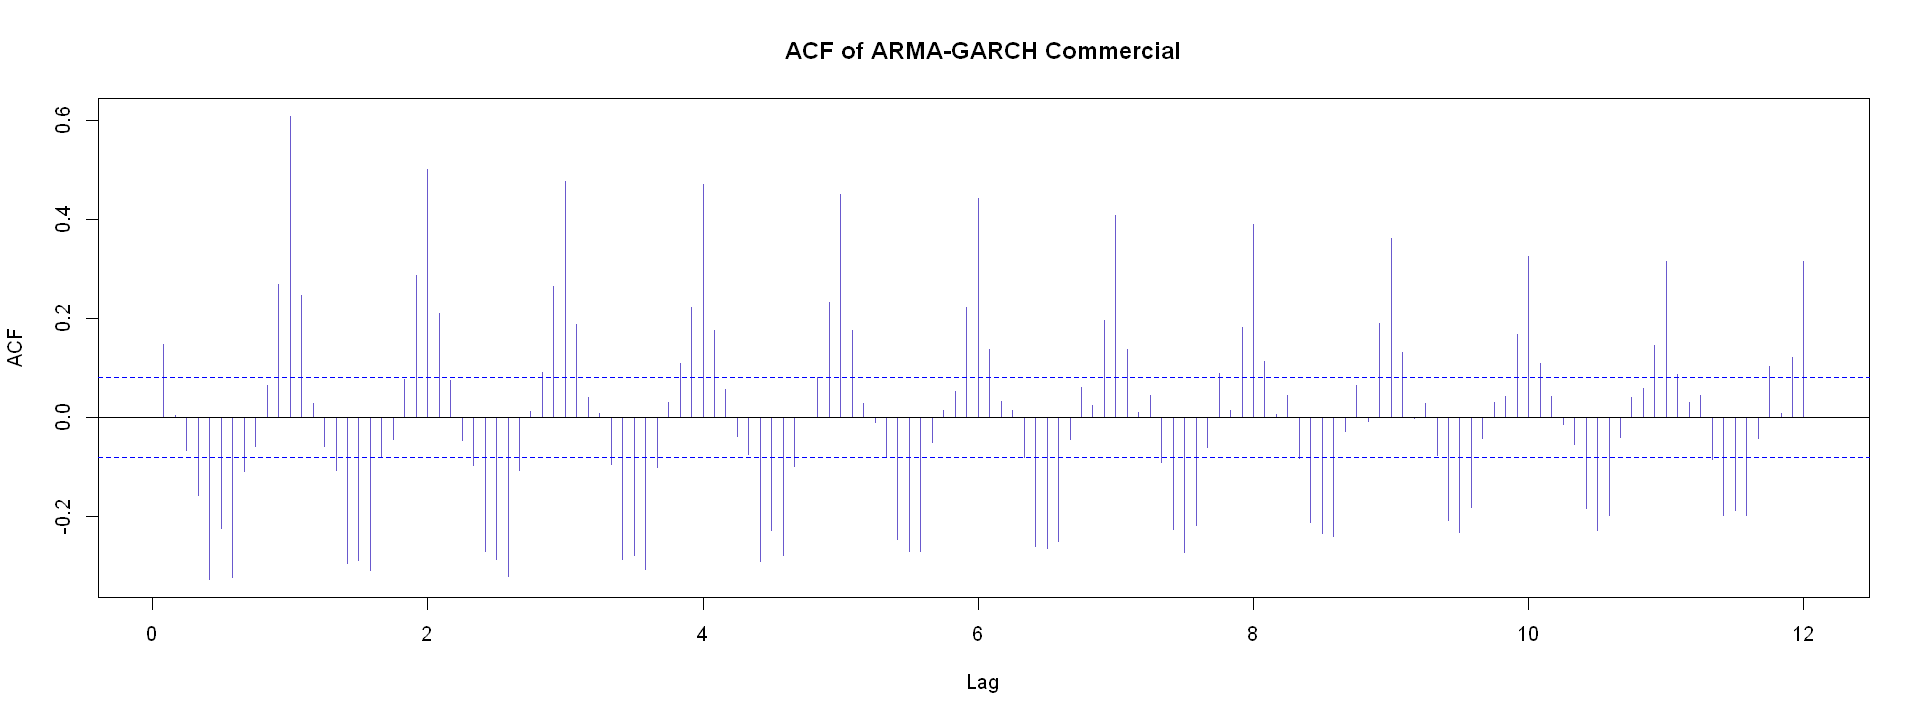


	Box-Ljung test

data:  model.resid_CS
X-squared = 191.89, df = 8, p-value < 2.2e-16



	Box-Ljung test

data:  model.resid_CS^2
X-squared = 59.591, df = 8, p-value = 5.606e-10


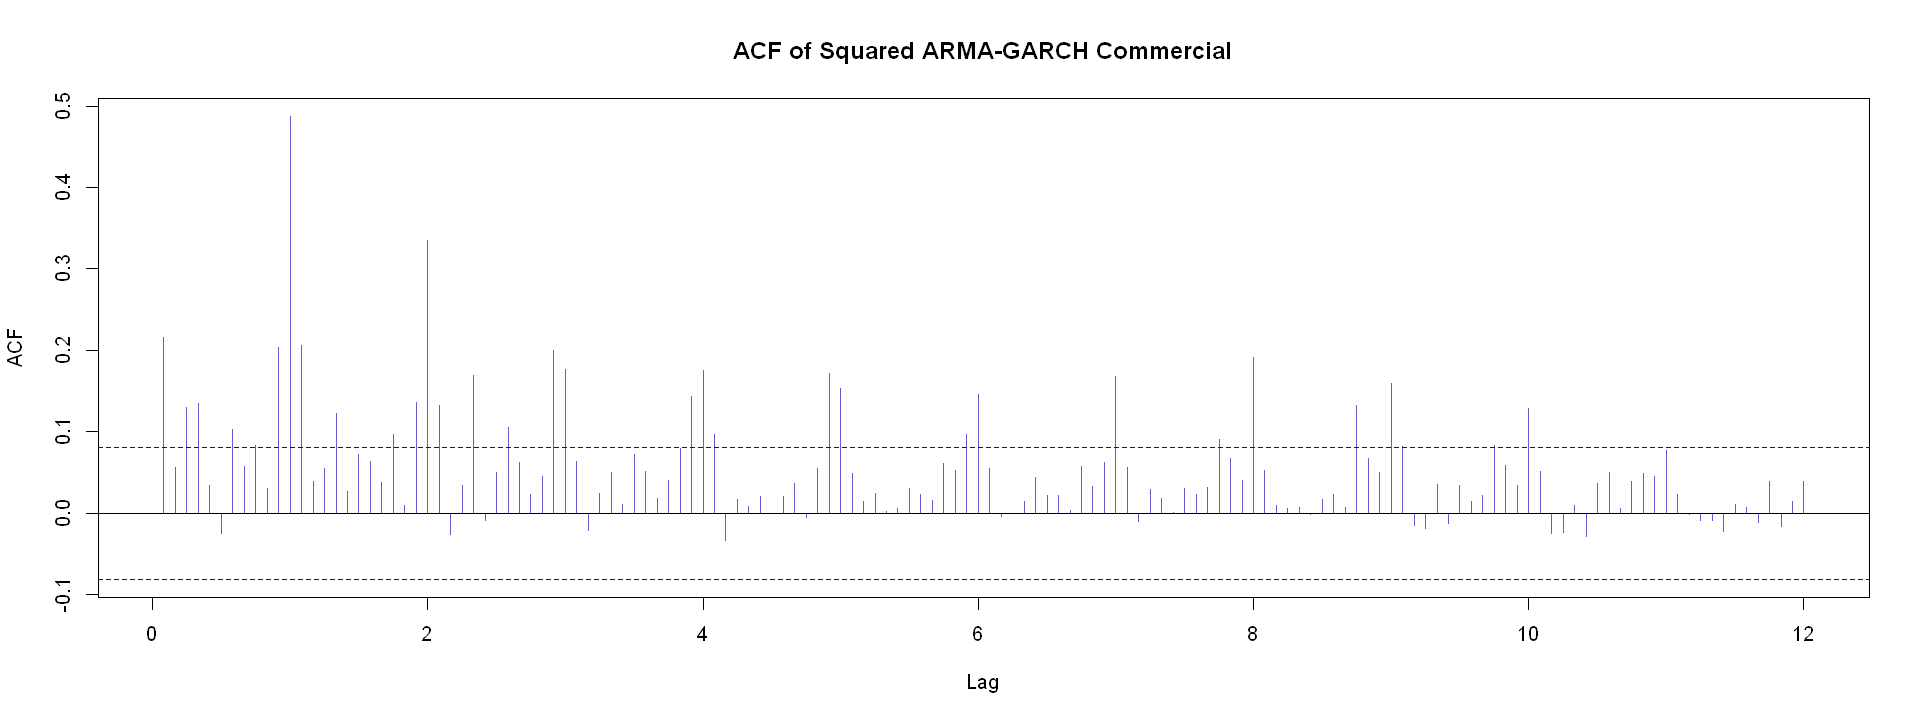

In [392]:
## Residual Analysis
model.resid_CS = residuals(model_CS.garch)

#plot the residuals introduced removing the trend and seasonality
ts.plot(ts(model.resid_CS,frequency=12),col=col2,ylab="Commercial", main="ARMA-GARCH Commercial")

acf(model.resid_CS,lag.max=12*12,col=col2,main="ACF of ARMA-GARCH Commercial")
acf(model.resid_CS^2,lag.max=12*12,col=col2,main="ACF of Squared ARMA-GARCH Commercial")
Box.test(model.resid_CS,lag=8,type='Ljung')
Box.test(model.resid_CS^2,lag=8,type='Ljung')



##### Comments

The residuals plot looks stationary.The stationarity was also confirmed by running an ADF test that shows a small p-value. However, the ACF plot shows strong autocorrelation and the seasonality is still visible.

##### Plot the ARMA-GARCH predictions



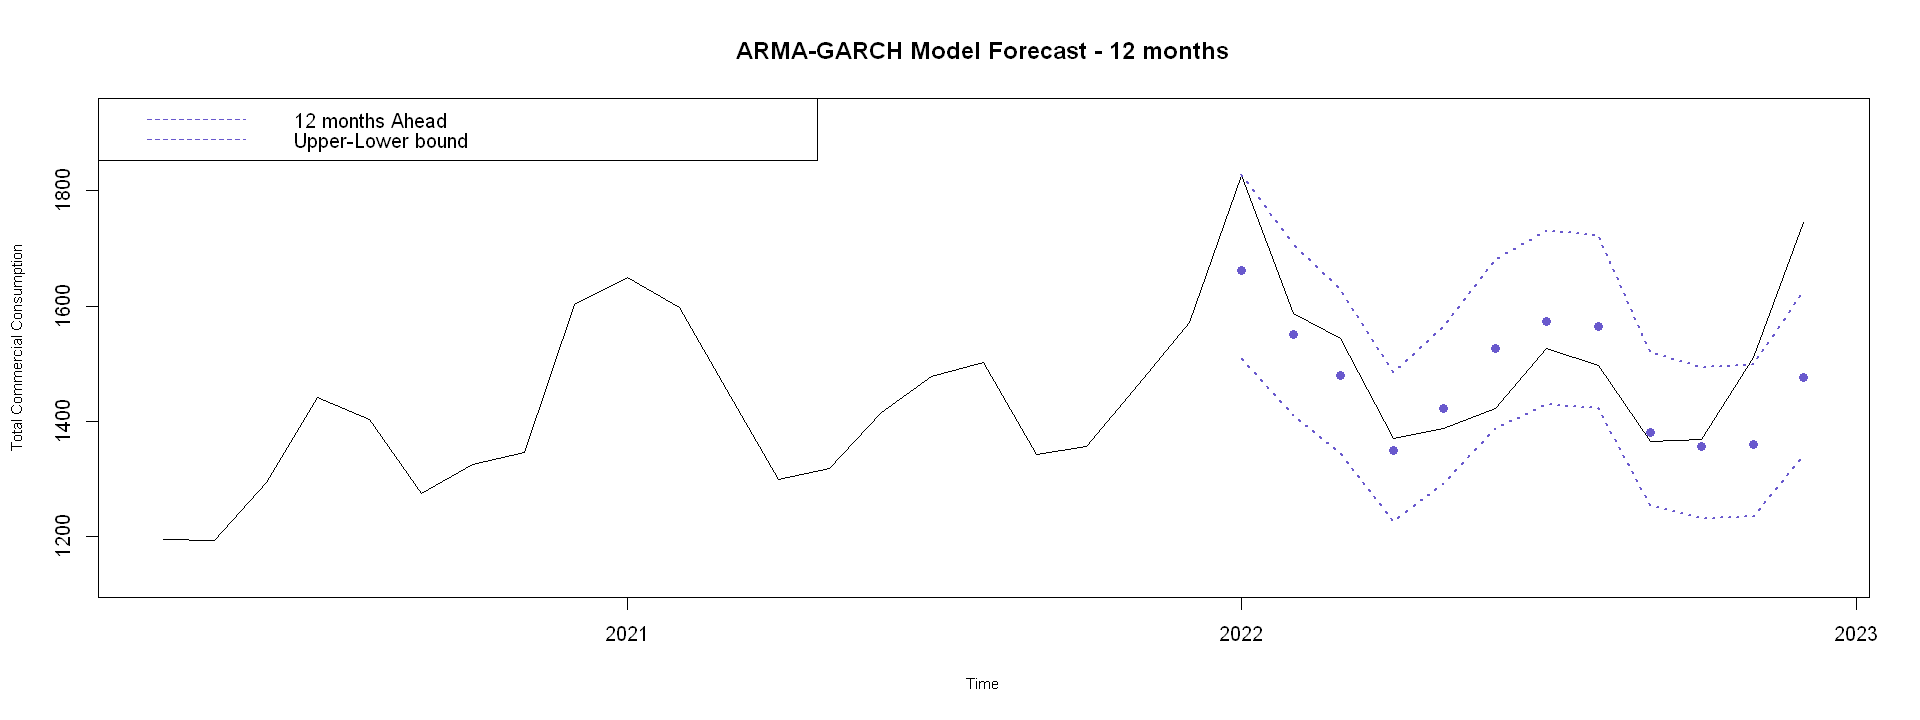

In [394]:
# predict 12 months ahead
n.tot=length(Total_CS.ts)
nfit.tot=n.tot-12

fore_CS = ugarchforecast(model_CS.garch, n.ahead = 12)

model_CS_pred  = exp(fore_CS@forecast$seriesFor)

ubound2 = exp(fore_CS@forecast$seriesFor+1.96*fore_CS@forecast$sigmaFor)
lbound2 = exp(fore_CS@forecast$seriesFor-1.96*fore_CS@forecast$sigmaFor)
ymin2 = min(lbound2)-100
ymax2 = max(ubound2)+100

plot(
    energy_data$dates[(nfit.tot-20):n.tot],exp(Total_CS.ts[(nfit.tot-20):n.tot]),type="l", 
    ylim=c(ymin2,ymax2), xlab="Time", 
    ylab="Total Commercial Consumption", main="ARMA-GARCH Model Forecast - 12 months"
)

points(energy_data$dates[(nfit.tot+1):n.tot],model_CS_pred,col=col2,pch=16)
lines(energy_data$dates[(nfit.tot+1):n.tot],ubound2,lty=3,lwd= 2, col=col2)
lines(energy_data$dates[(nfit.tot+1):n.tot],lbound2,lty=3,lwd= 2, col=col2)
legend('topleft', legend=c("12 months Ahead ","Upper-Lower bound"),lty = 2, col=c(col2,col2))


##### Accuracy measures



In [63]:
## Compute Accuracy Measures
CS_true = as.vector(exp(Total_CS.ts[(nfit.tot+1):n.tot]))

fore_CS = ugarchforecast(model_CS.garch, n.ahead = 12)

model_CS_pred  = exp(fore_CS@forecast$seriesFor)

### Mean Absolute Percentage Error (MAPE)
mean(abs(model_CS_pred-CS_true)/CS_true)
### Precision Measure (PM)
sum((model_CS_pred-CS_true)^2)/sum((CS_true-mean(CS_true))^2)

[1] 0.05140887

[1] 0.5989269

We still see extensive variation in the data, based on the ACF plots of both the residuals and the squared residuals, it does not appear to act as white noise, thus we should consider further analysis which can account for variation, which we will see in the Energy vs. GDP Analysis later on.

# Industrial

### Fit non-parametric + seasonal ANOVA

In [64]:
############### TREND and SEASONALITY ESTIMATION FOR TOTAL RESIDENTIAL ENERGY CONSUMPTION ###################
mon = as.factor(month(as.Date(Total_IS.ts)))

## X-axis points converted to 0-1 scale, common in nonparametric regression
time.pts = c(1:length(Total_IS.ts))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

## Splines Trend Estimation
gam.mon.IS = gam(Total_IS.ts~s(time.pts)+mon-1)
gam.mon.IS.ts = ts(fitted(gam.mon.IS),start=1973,frequency=12)
summary(gam.mon.IS)


Family: gaussian 
Link function: identity 

Formula:
Total_IS.ts ~ s(time.pts) + mon - 1

Parametric coefficients:
      Estimate Std. Error t value Pr(>|t|)    
mon1  7.909047   0.005877    1346   <2e-16 ***
mon2  7.812969   0.005876    1330   <2e-16 ***
mon3  7.876980   0.005876    1341   <2e-16 ***
mon4  7.834608   0.005876    1333   <2e-16 ***
mon5  7.877533   0.005875    1341   <2e-16 ***
mon6  7.871985   0.005875    1340   <2e-16 ***
mon7  7.893983   0.005875    1344   <2e-16 ***
mon8  7.911282   0.005875    1347   <2e-16 ***
mon9  7.861066   0.005876    1338   <2e-16 ***
mon10 7.905803   0.005876    1345   <2e-16 ***
mon11 7.886044   0.005876    1342   <2e-16 ***
mon12 7.907577   0.005877    1346   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df    F p-value    
s(time.pts) 8.833  8.992 96.5  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) 

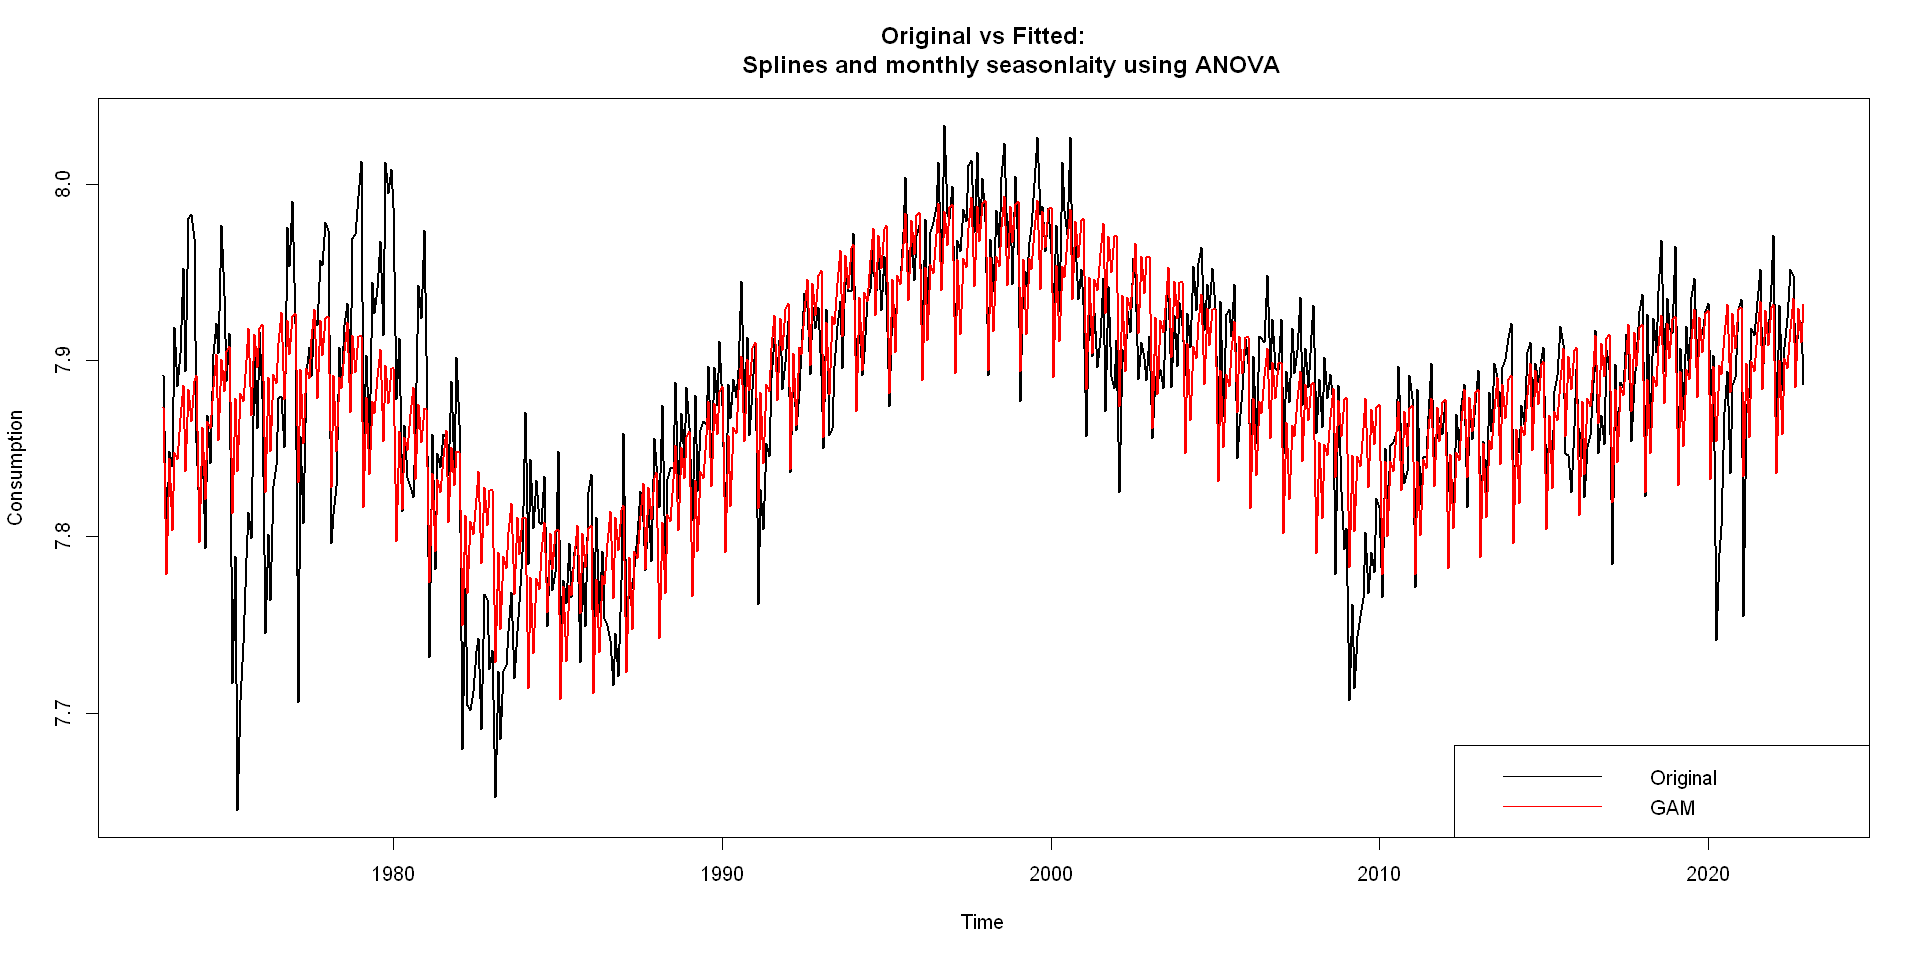

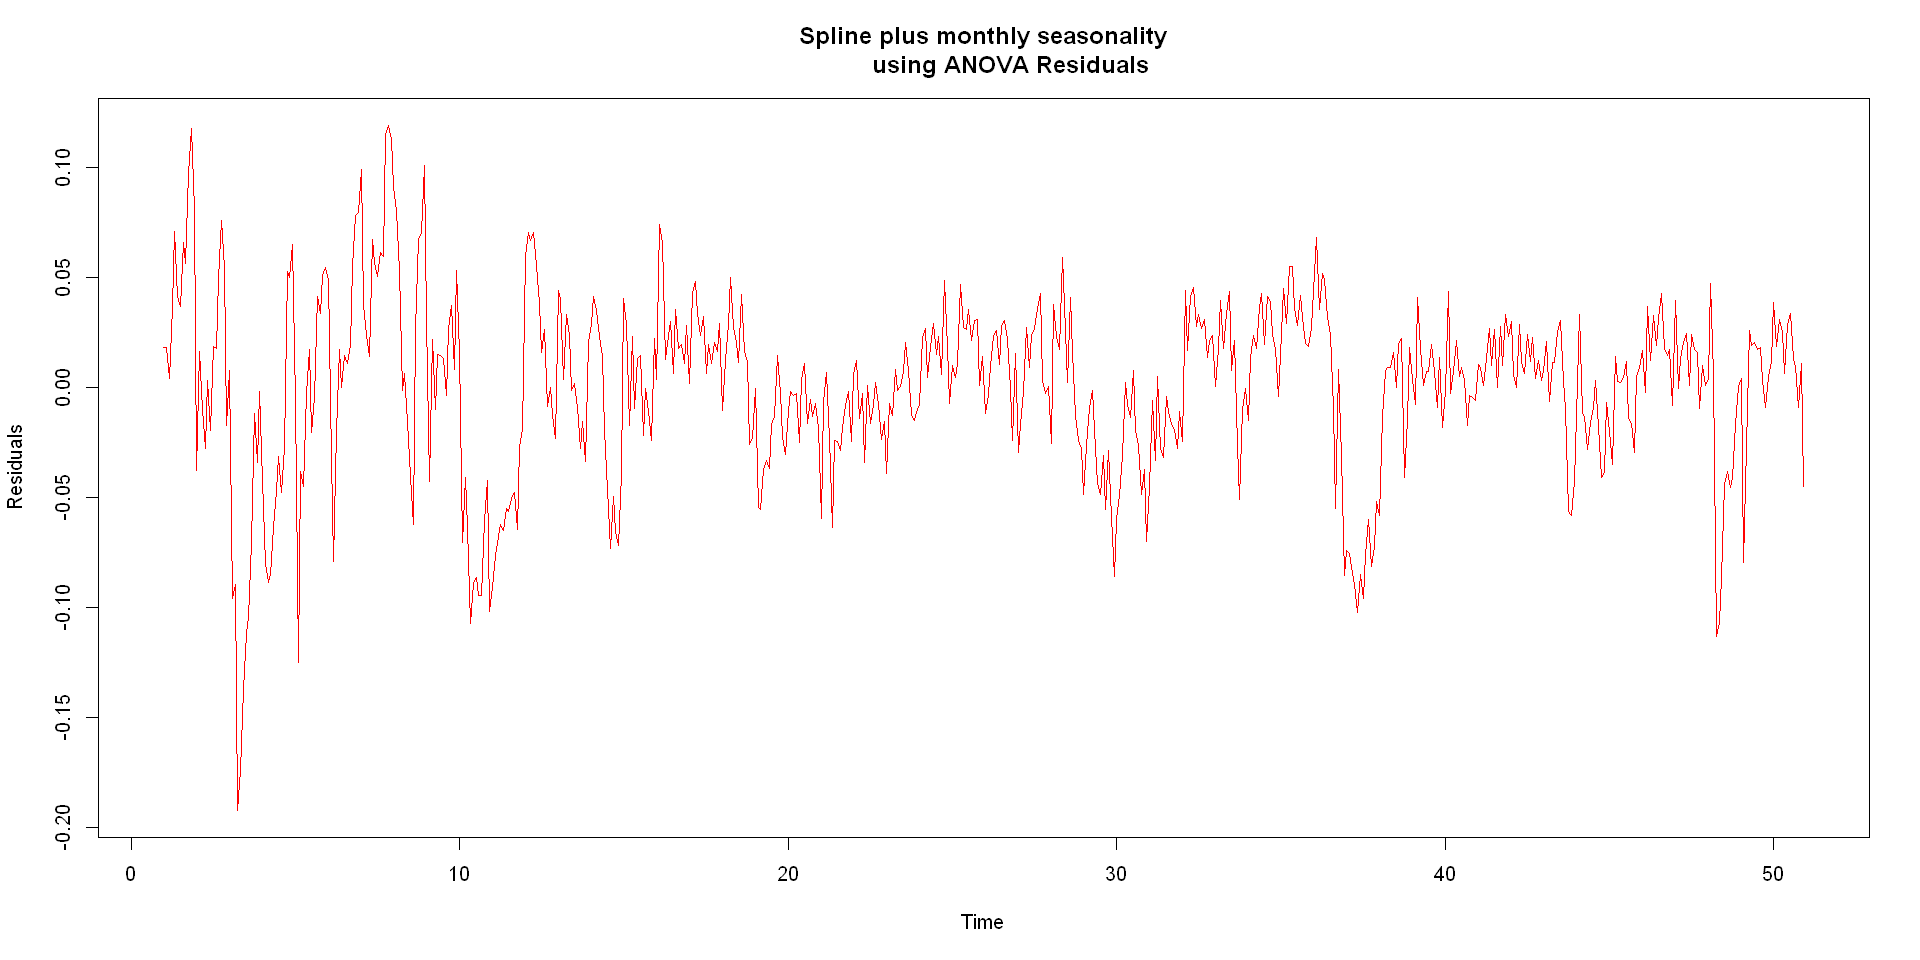

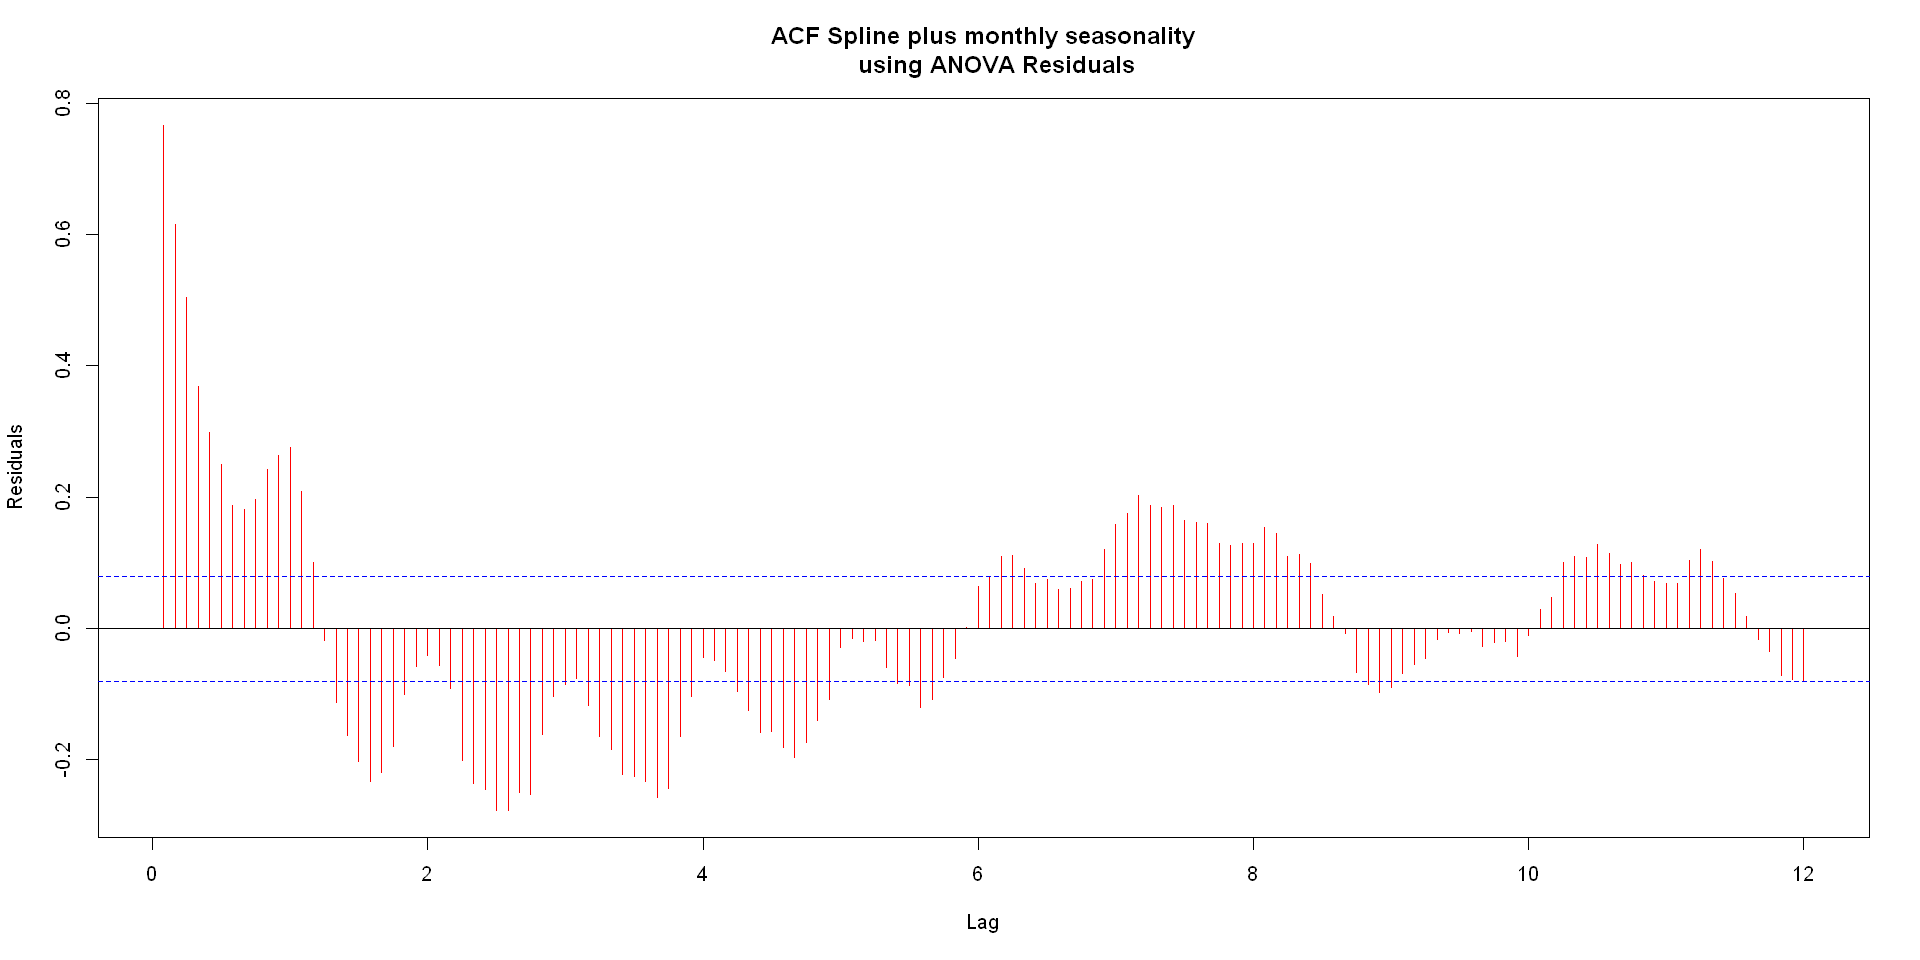

Warning message in adf.test(gam.mon.resid):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  gam.mon.resid
Dickey-Fuller = -5.2118, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


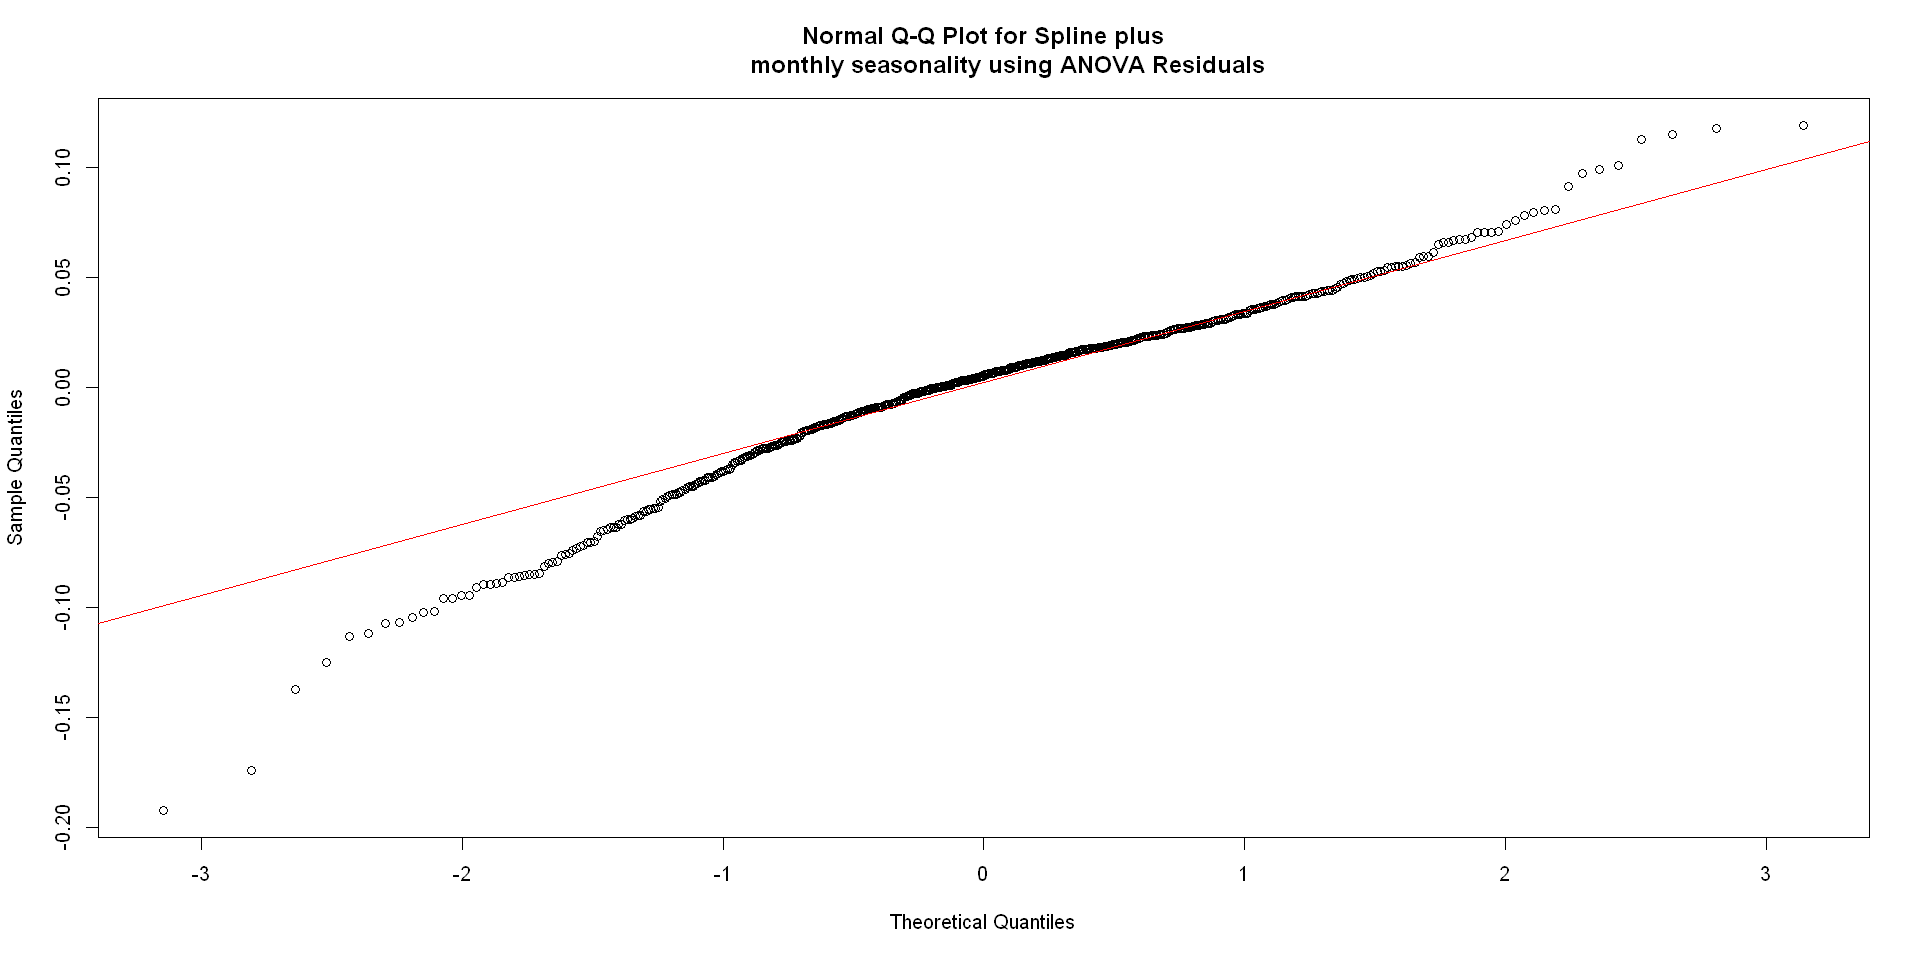

In [65]:
## Compare against fitted values
all.val = c(Total_IS.ts, gam.mon.IS.ts)
ylimRange= c(min(all.val),max(all.val))

ts.plot(Total_IS.ts,lwd=2,ylim=ylimRange,ylab="Consumption",main="Original vs Fitted:
        Splines and monthly seasonlaity using ANOVA")
lines(gam.mon.IS.ts,lwd=2,col="red")
legend("bottomright",legend=c("Original","GAM"),lty = 1, col=c("black","red"))

#plot the residuals introduced removing the trend and seasonality
gam.mon.resid = Total_IS.ts - fitted(gam.mon.IS)
ts.plot(ts(gam.mon.resid,frequency=12),col="red",ylab="Residuals", main="Spline plus monthly seasonality
        using ANOVA Residuals")

acf(gam.mon.resid,lag.max = 12*12,col="red",ylab="Residuals", main="ACF Spline plus monthly seasonality
    using ANOVA Residuals")

qqnorm(gam.mon.resid,main = "Normal Q-Q Plot for Spline plus
       monthly seasonality using ANOVA Residuals")
qqline(gam.mon.resid,col="red")

adf.test(gam.mon.resid)



Although the Augmented Dickey-Fuller Test indicates stationarity, we note that the monthly ANOVA model does not capture seasonality accurately. The residual process still shows seasonality which is also visible in the ACF plot where most of the lags alternate in wavelength fashion oustide the confidence bands. Also, the normality of the QQ plot does not hold.

To try to capture seasonality, we will try fitting Splines and quarterly seasonlaity using ANOVA


Family: gaussian 
Link function: identity 

Formula:
Total_IS.ts ~ s(time.pts) + qtr - 1

Parametric coefficients:
     Estimate Std. Error t value Pr(>|t|)    
qtr1 7.866323   0.003950    1991   <2e-16 ***
qtr2 7.861373   0.003948    1991   <2e-16 ***
qtr3 7.888780   0.003948    1998   <2e-16 ***
qtr4 7.899816   0.003950    2000   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 8.766  8.984 71.14  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.538   Deviance explained =  100%
GCV = 0.002389  Scale est. = 0.0023382  n = 600

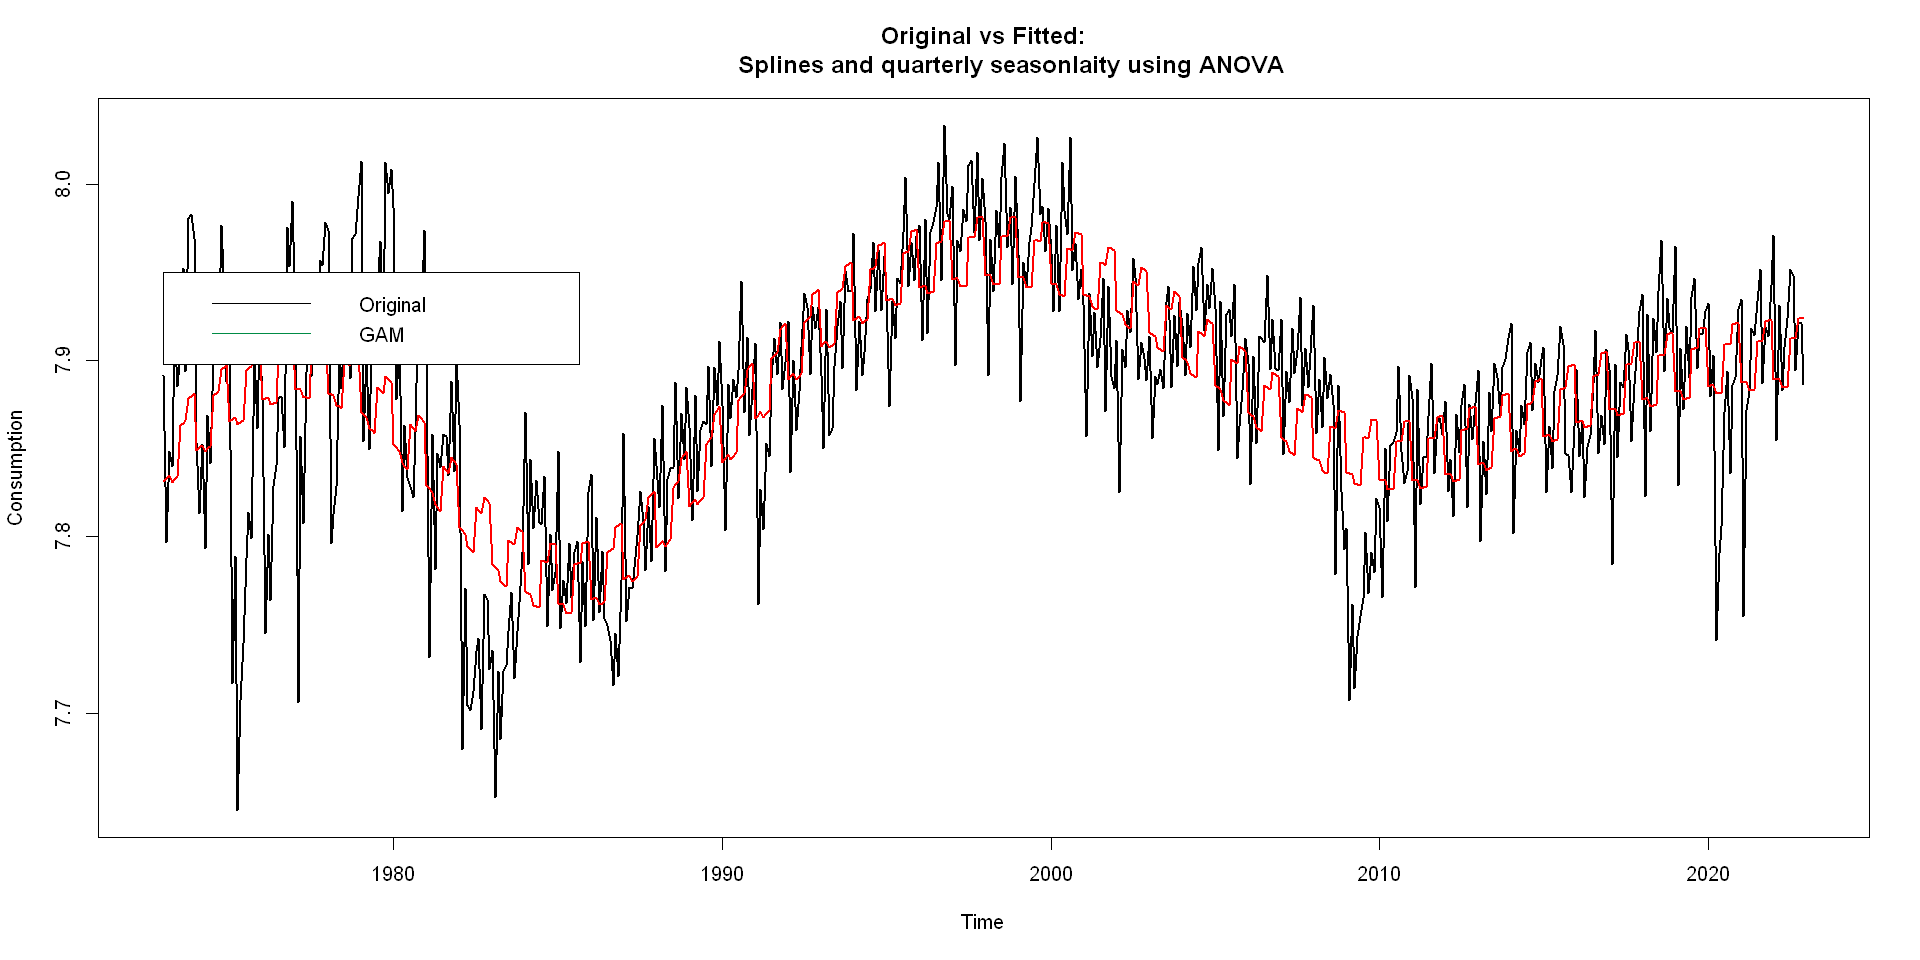

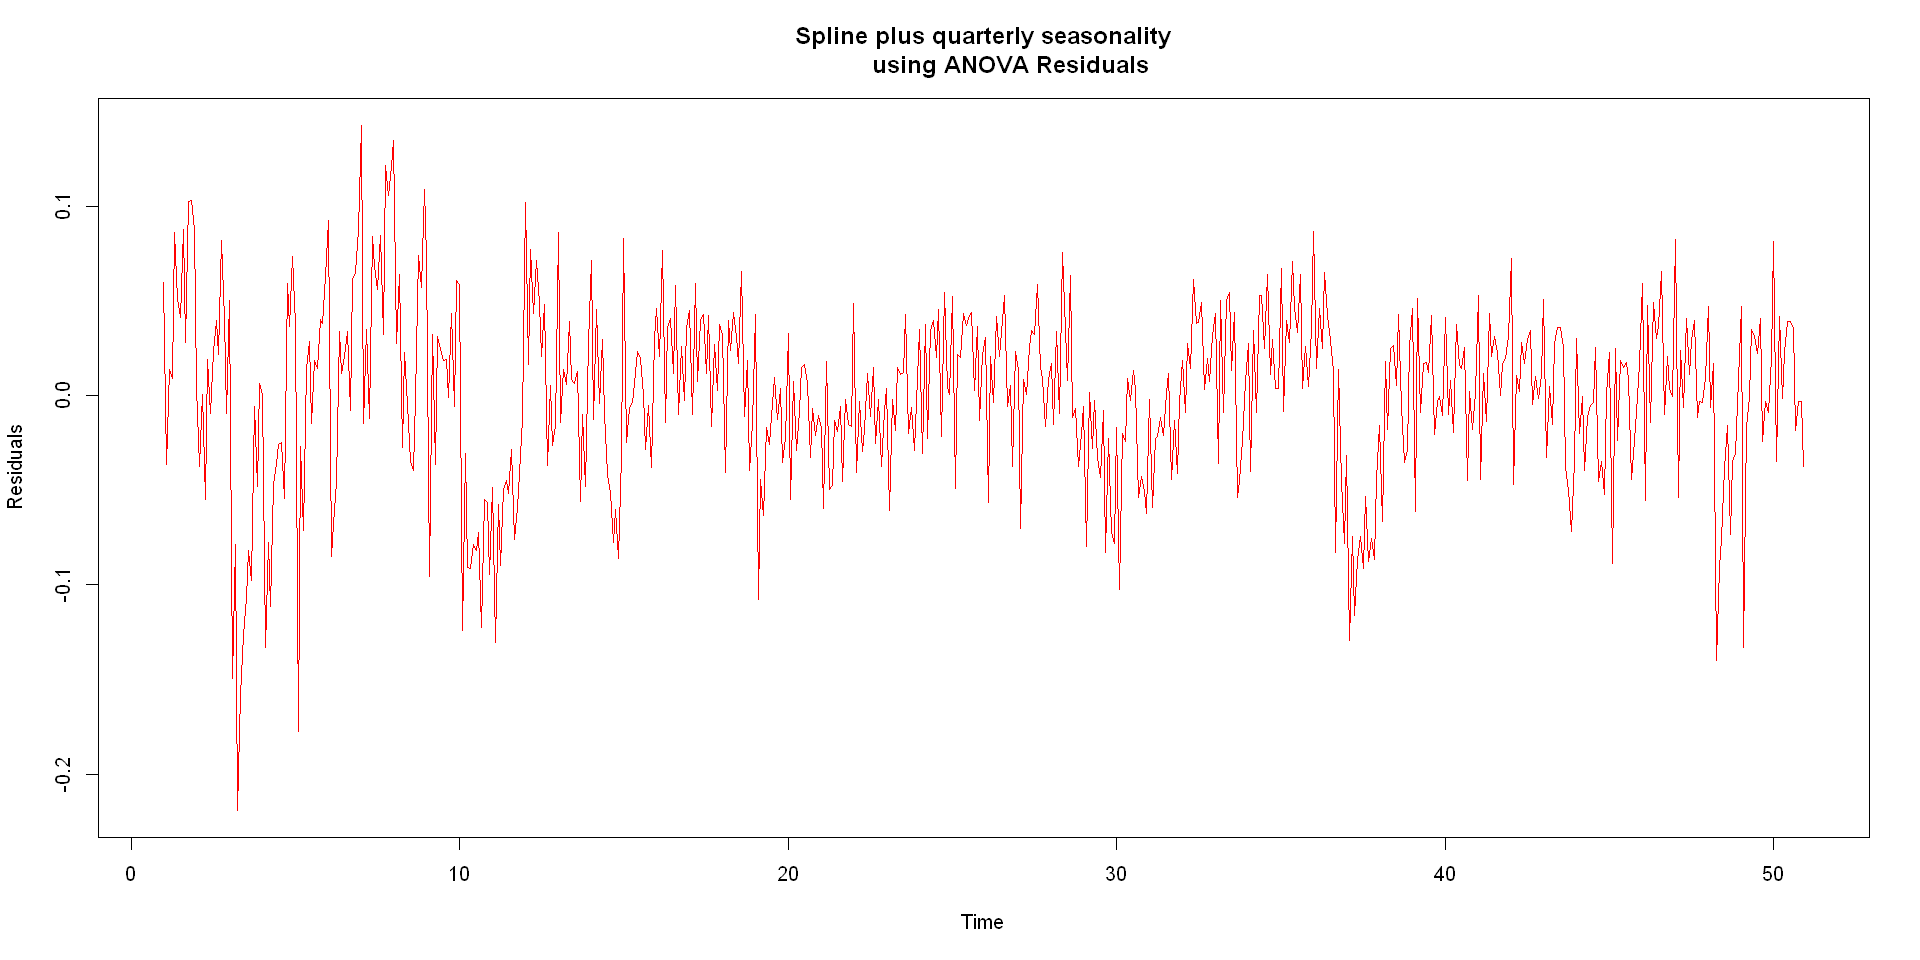

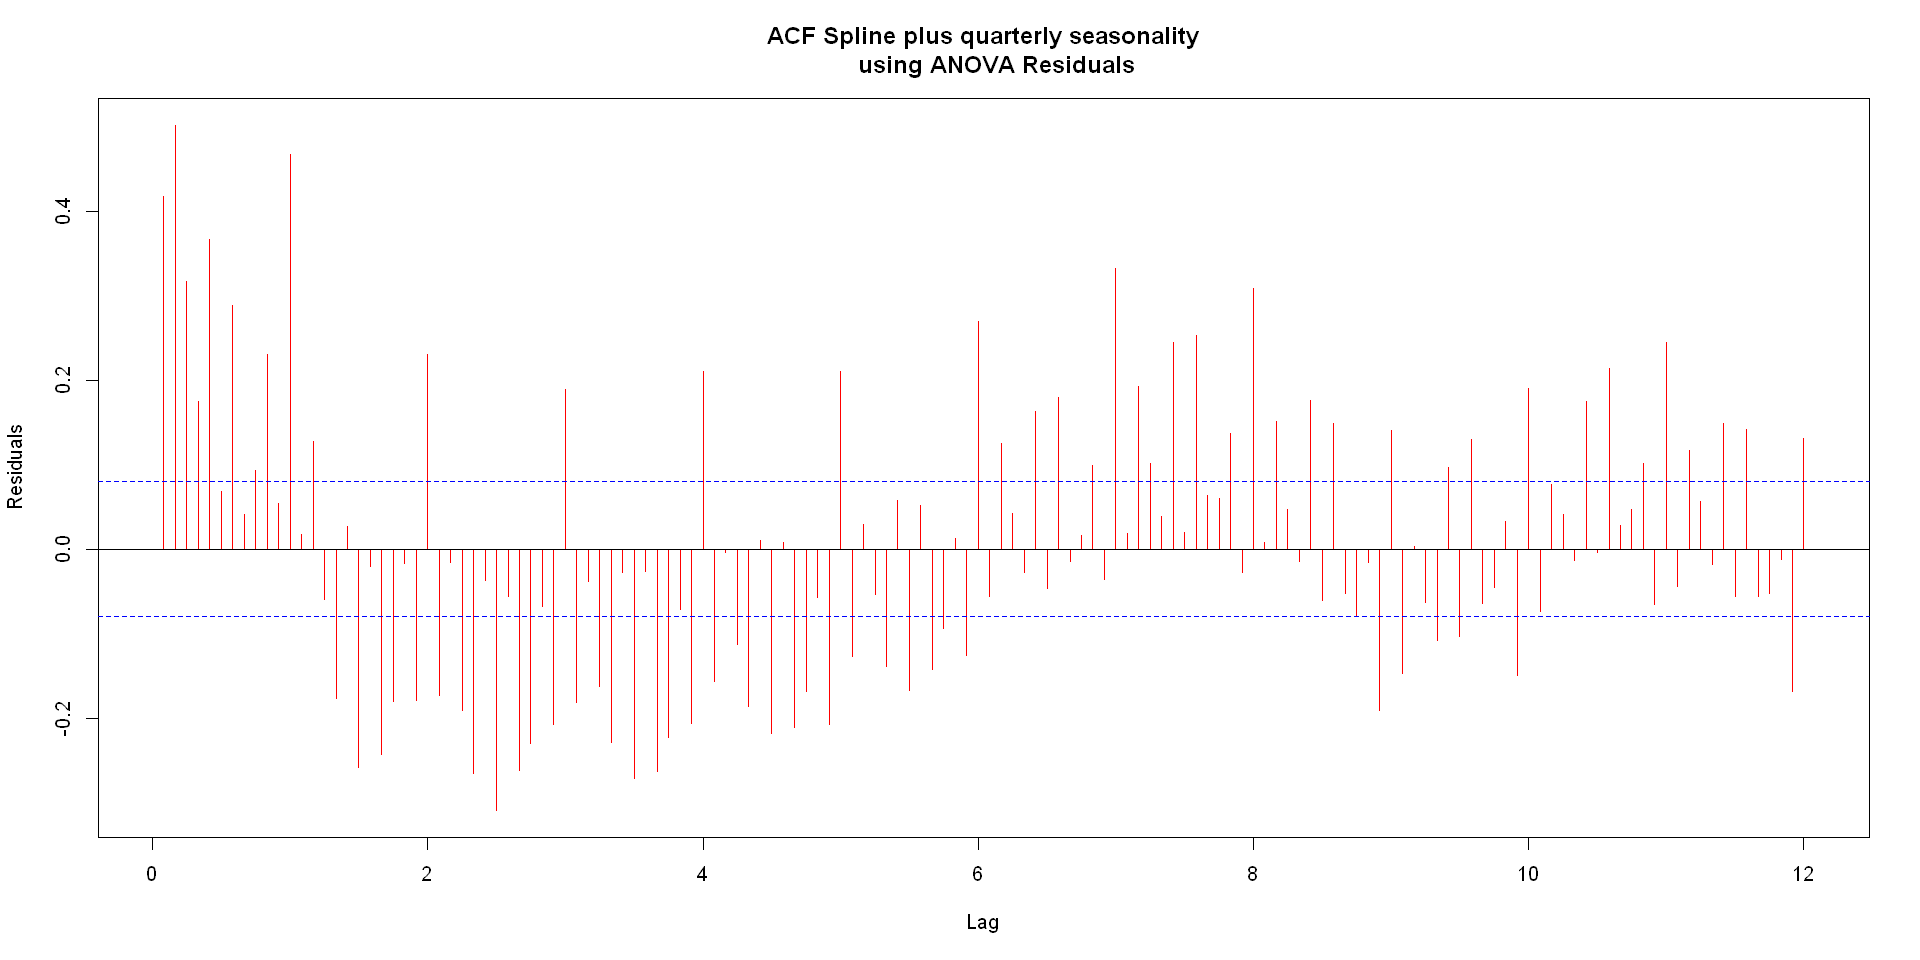

Warning message in adf.test(gam.qtr.resid):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  gam.qtr.resid
Dickey-Fuller = -6.1257, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


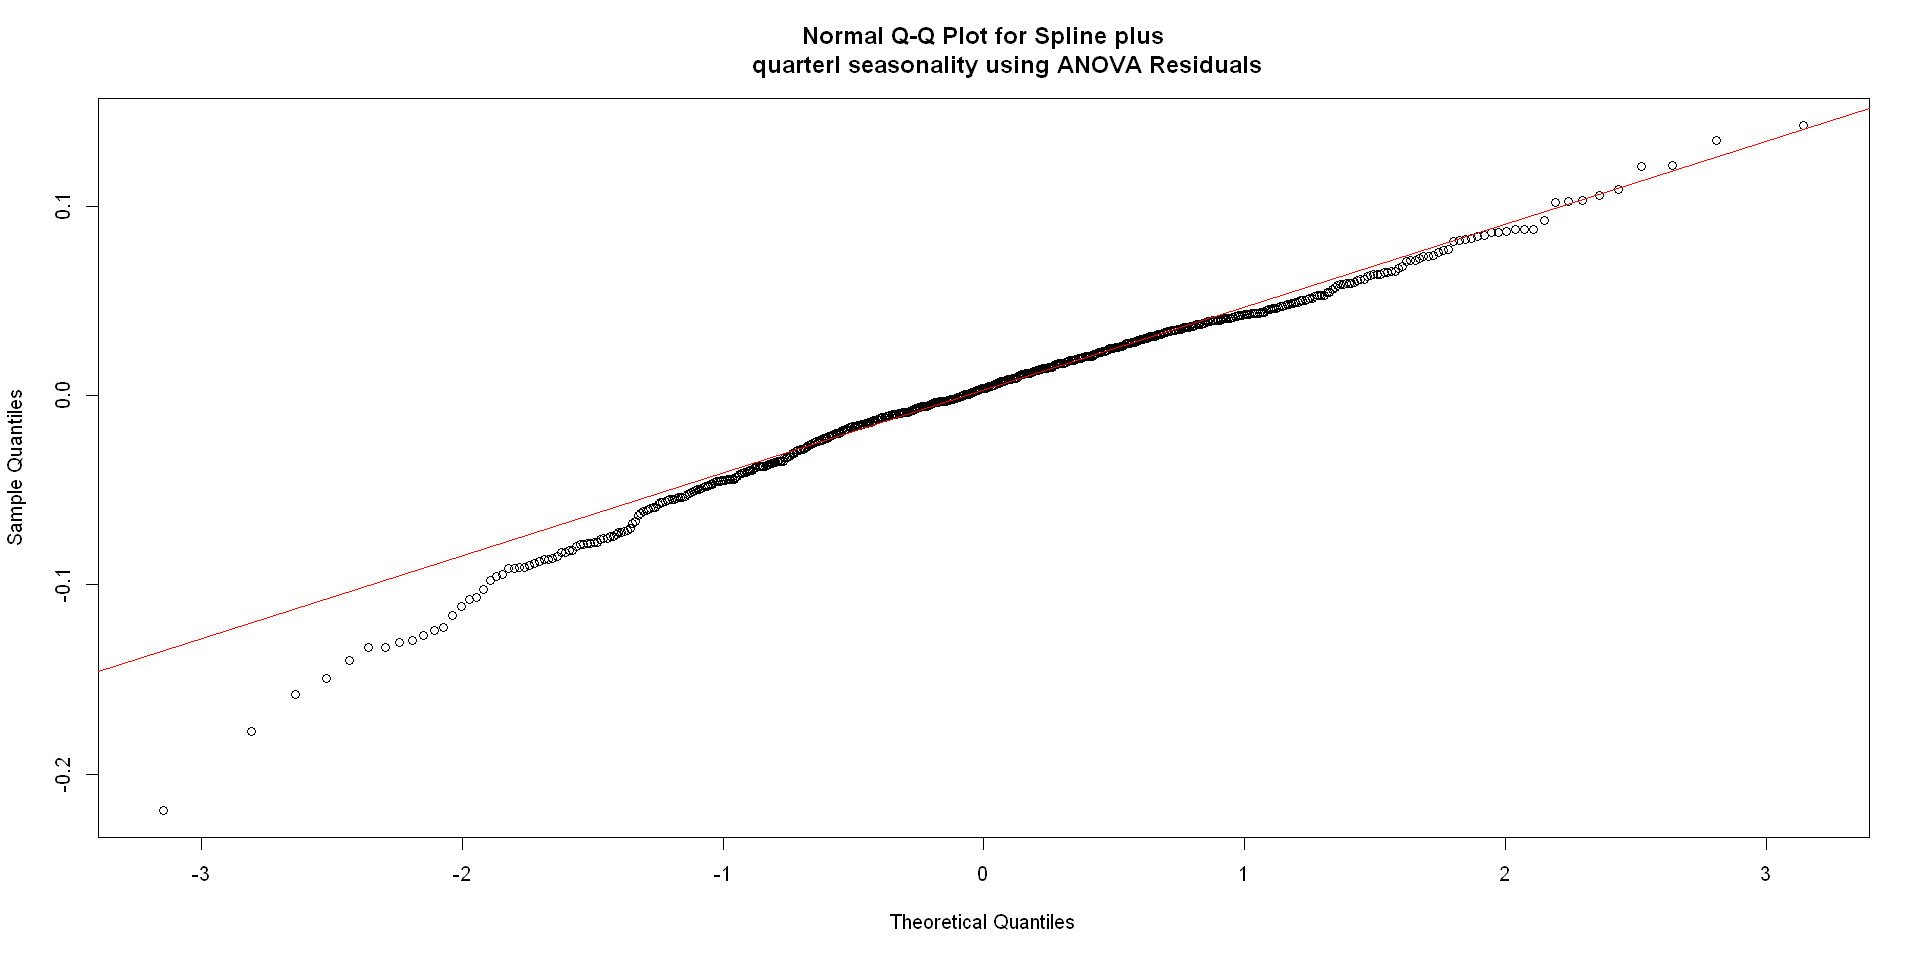

In [66]:
############### TREND and SEASONALITY ESTIMATION ###################
qtr = as.factor(quarter(as.Date(Total_IS.ts)))

## Splines Trend Estimation
gam.qtr.IS = gam(Total_IS.ts~s(time.pts)+qtr-1)
gam.qtr.IS.ts = ts(fitted(gam.qtr.IS),start=1973,frequency=12)
summary(gam.qtr.IS)

all.val.qtr = c(Total_IS.ts, gam.qtr.IS.ts)
ylimRange.qtr= c(min(all.val.qtr),max(all.val.qtr))

ts.plot(Total_IS.ts,lwd=2,ylim = ylimRange.qtr,ylab="Consumption",main="Original vs Fitted:
        Splines and quarterly seasonlaity using ANOVA")
lines(gam.qtr.IS.ts,lwd=2,col="red")
legend(x=1973,y=7.95,legend=c("Original","GAM"),lty = 1, col=c("black","springgreen4"))

#plot the residuals introduced removing the trend and seasonality
gam.qtr.resid = Total_IS.ts - fitted(gam.qtr.IS)
ts.plot(ts(gam.qtr.resid,frequency=12),col="red",ylab="Residuals", main="Spline plus quarterly seasonality
        using ANOVA Residuals")

acf(gam.qtr.resid,lag.max = 12*12,col="red",ylab="Residuals", main="ACF Spline plus quarterly seasonality
    using ANOVA Residuals")

qqnorm(gam.qtr.resid,main = "Normal Q-Q Plot for Spline plus
       quarterl seasonality using ANOVA Residuals")
qqline(gam.qtr.resid,col="red")

adf.test(gam.qtr.resid)

Examining the residual and the ACF plots, we conclude that Splines and quarterly seasonlaity using ANOVA did not fare better than the previous model at capturing seasonality.

### Fit SARIMA
Since Seasonal ARIMA can handle both trend and seasonality, we will try to capture the underlying trend and seasonalality simultaneously, this might allow for easier interpretation than differencing or removing trend and seaesonality separately.

First, we split the Total Residential Energy Consumption into training and test sets so we could use the best SARIMA model to predict the last 12 months of the data.

In [67]:
n=length(Total_IS.ts)
nfit.Total_IS=n-12
Total_IS.train.ts = ts(Total_IS.ts[1:nfit.Total_IS],start=1973,frequency=12)

# fit model
SARIMA_IS <- find_best_arima(Total_IS.train.ts)
SARIMA_IS

Series: data 
ARIMA(3,0,1)(1,0,1)[12] with non-zero mean 

Coefficients:
         ar1     ar2     ar3     ma1    sar1     sma1    mean
      0.2124  0.3841  0.2679  0.4655  0.9903  -0.7569  7.8784
s.e.  0.1394  0.1116  0.0422  0.1420  0.0046   0.0358  0.1305

sigma^2 = 7e-04:  log likelihood = 1291.77
AIC=-2567.54   AICc=-2567.29   BIC=-2532.53

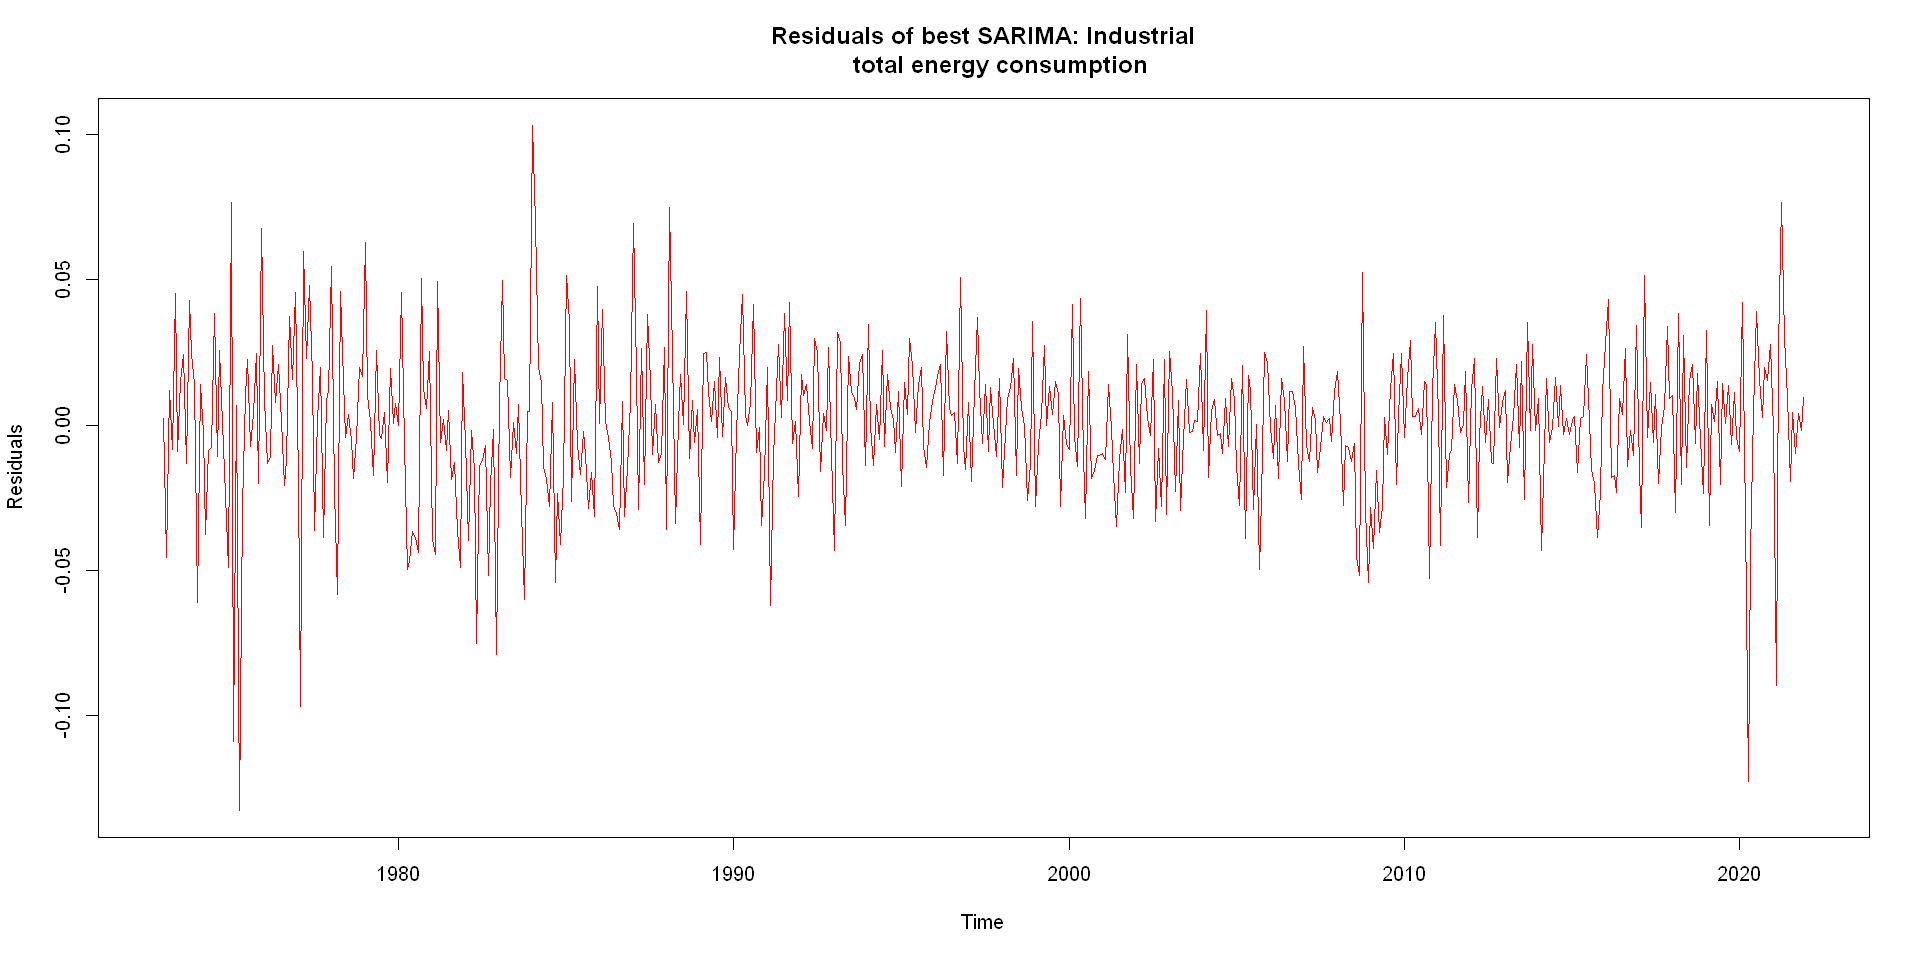

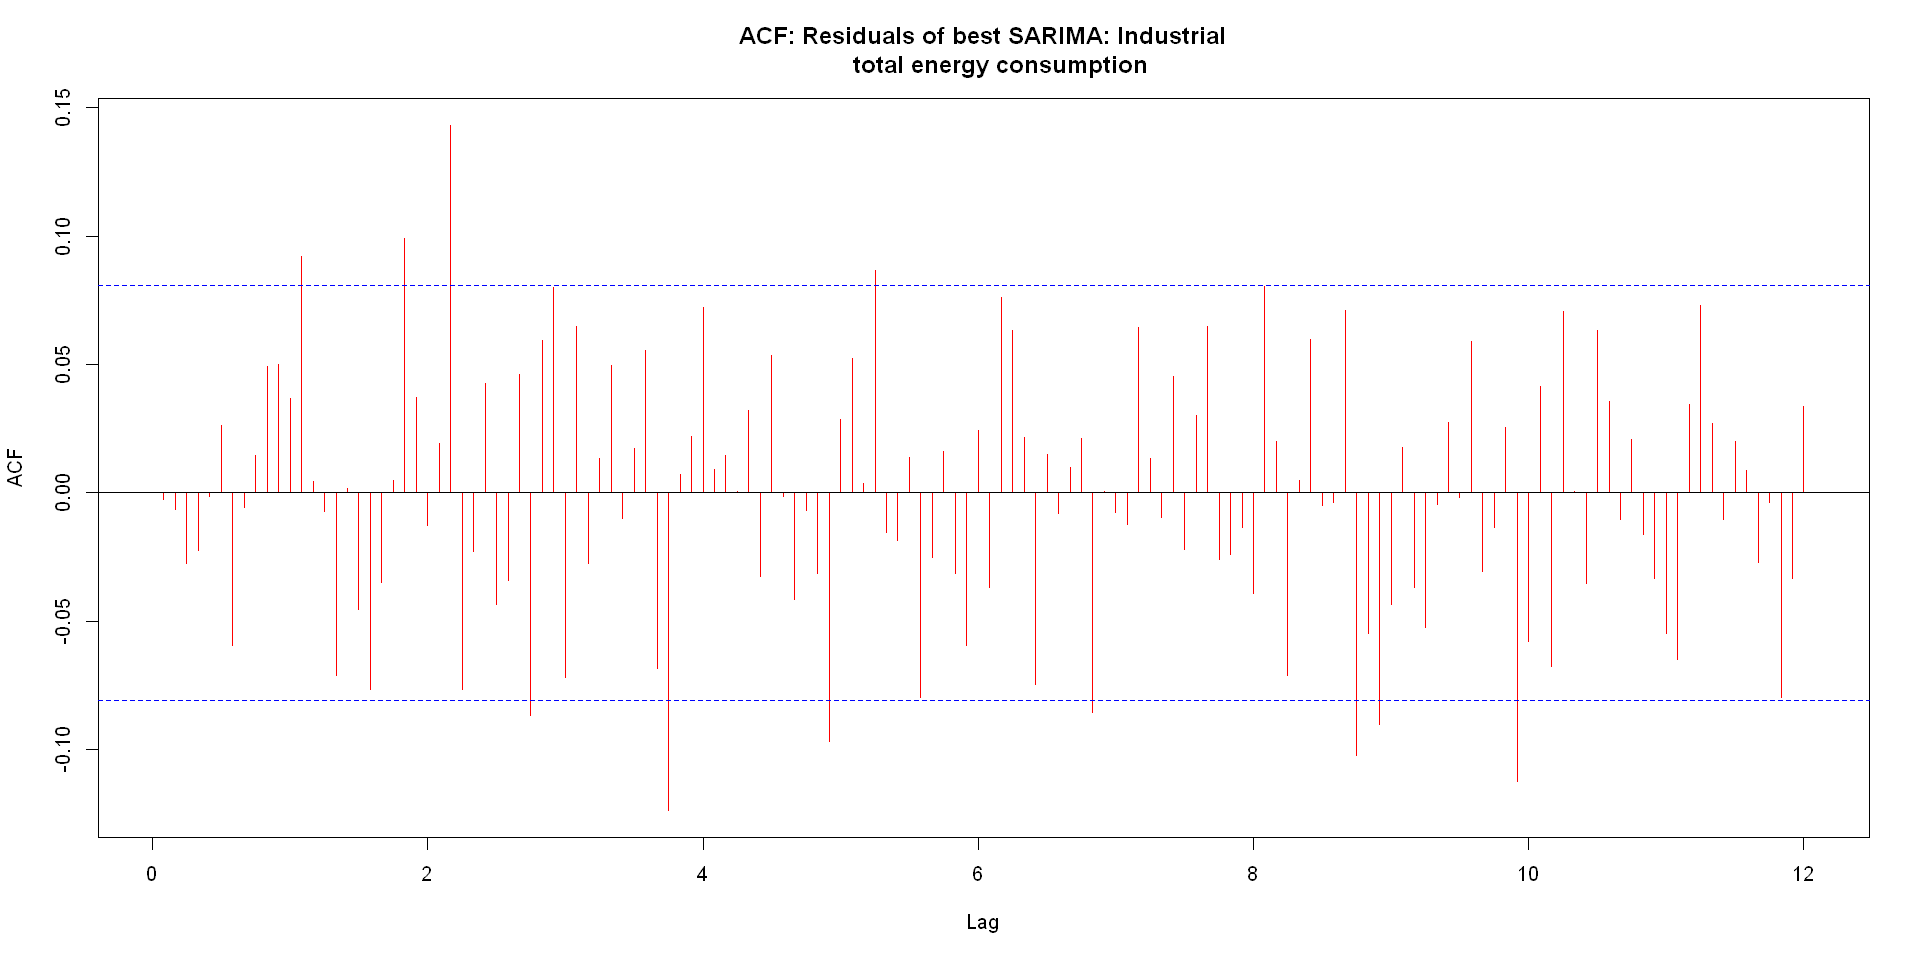

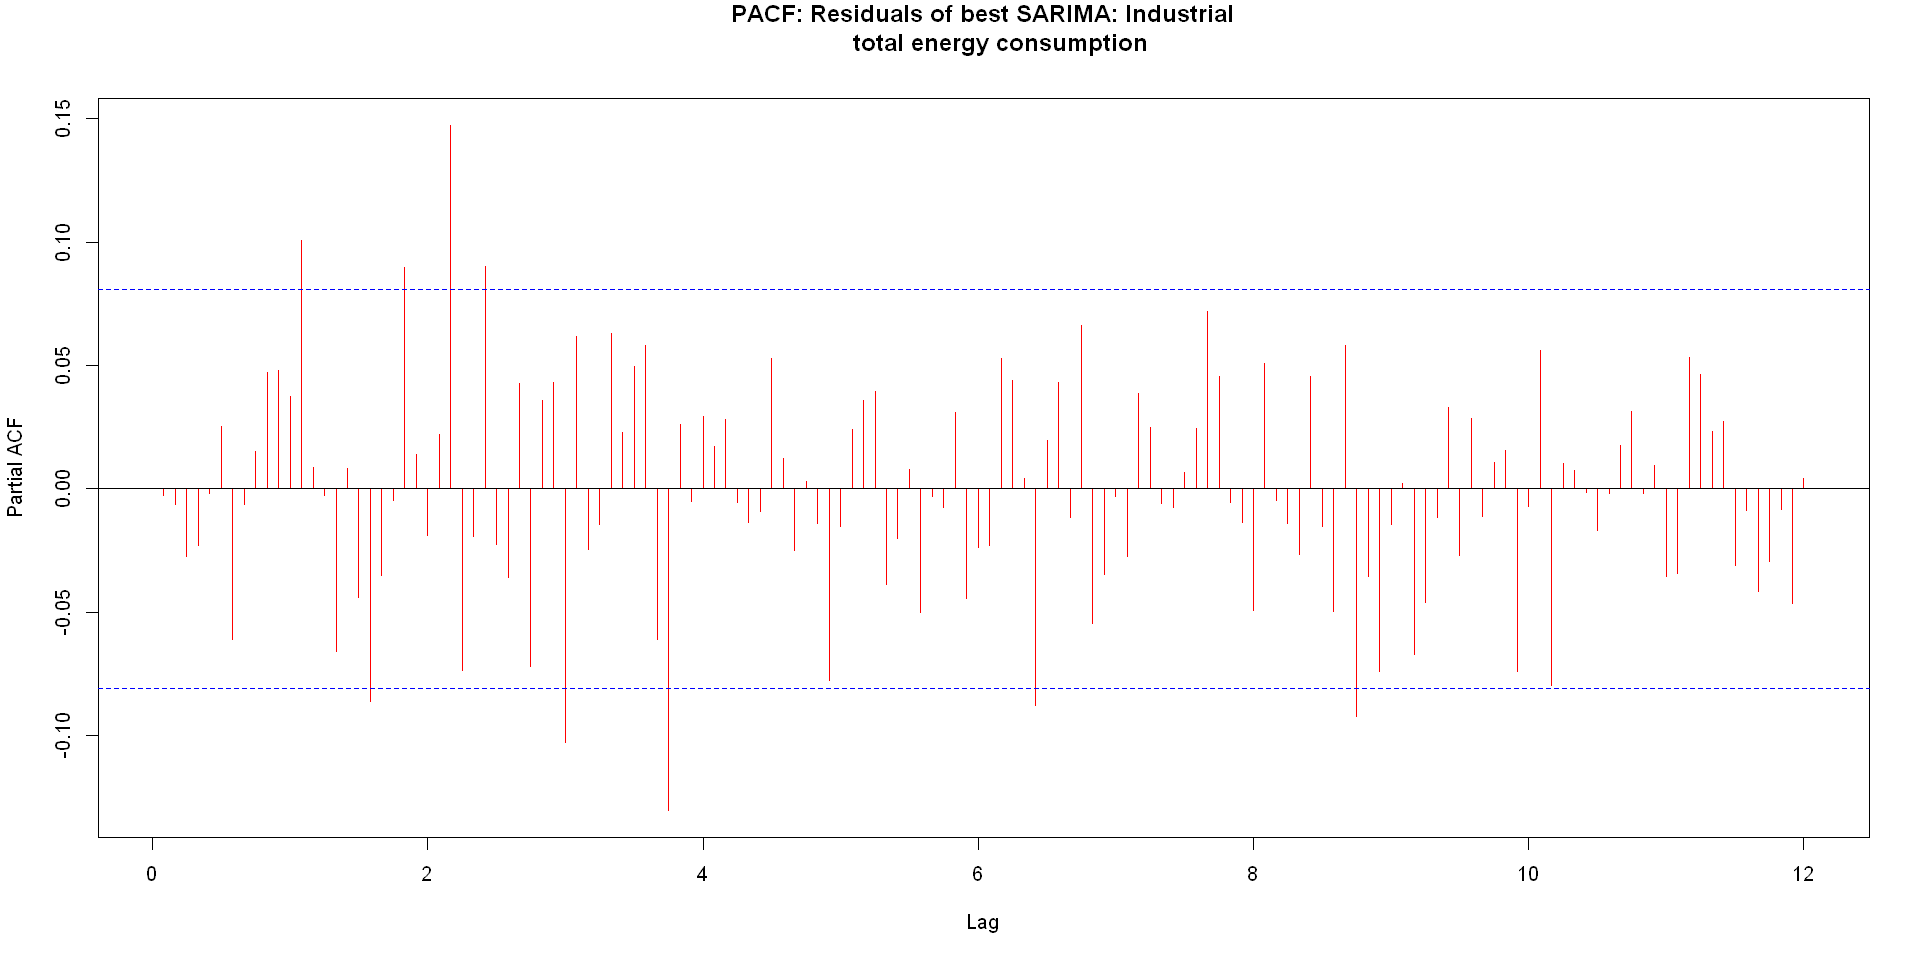

[1]  28 568


	Box-Pierce test

data:  residuals(SARIMA_IS)
X-squared = 0.76973, df = 1, p-value = 0.3803



	Box-Ljung test

data:  residuals(SARIMA_IS)
X-squared = 0.77678, df = 1, p-value = 0.3781


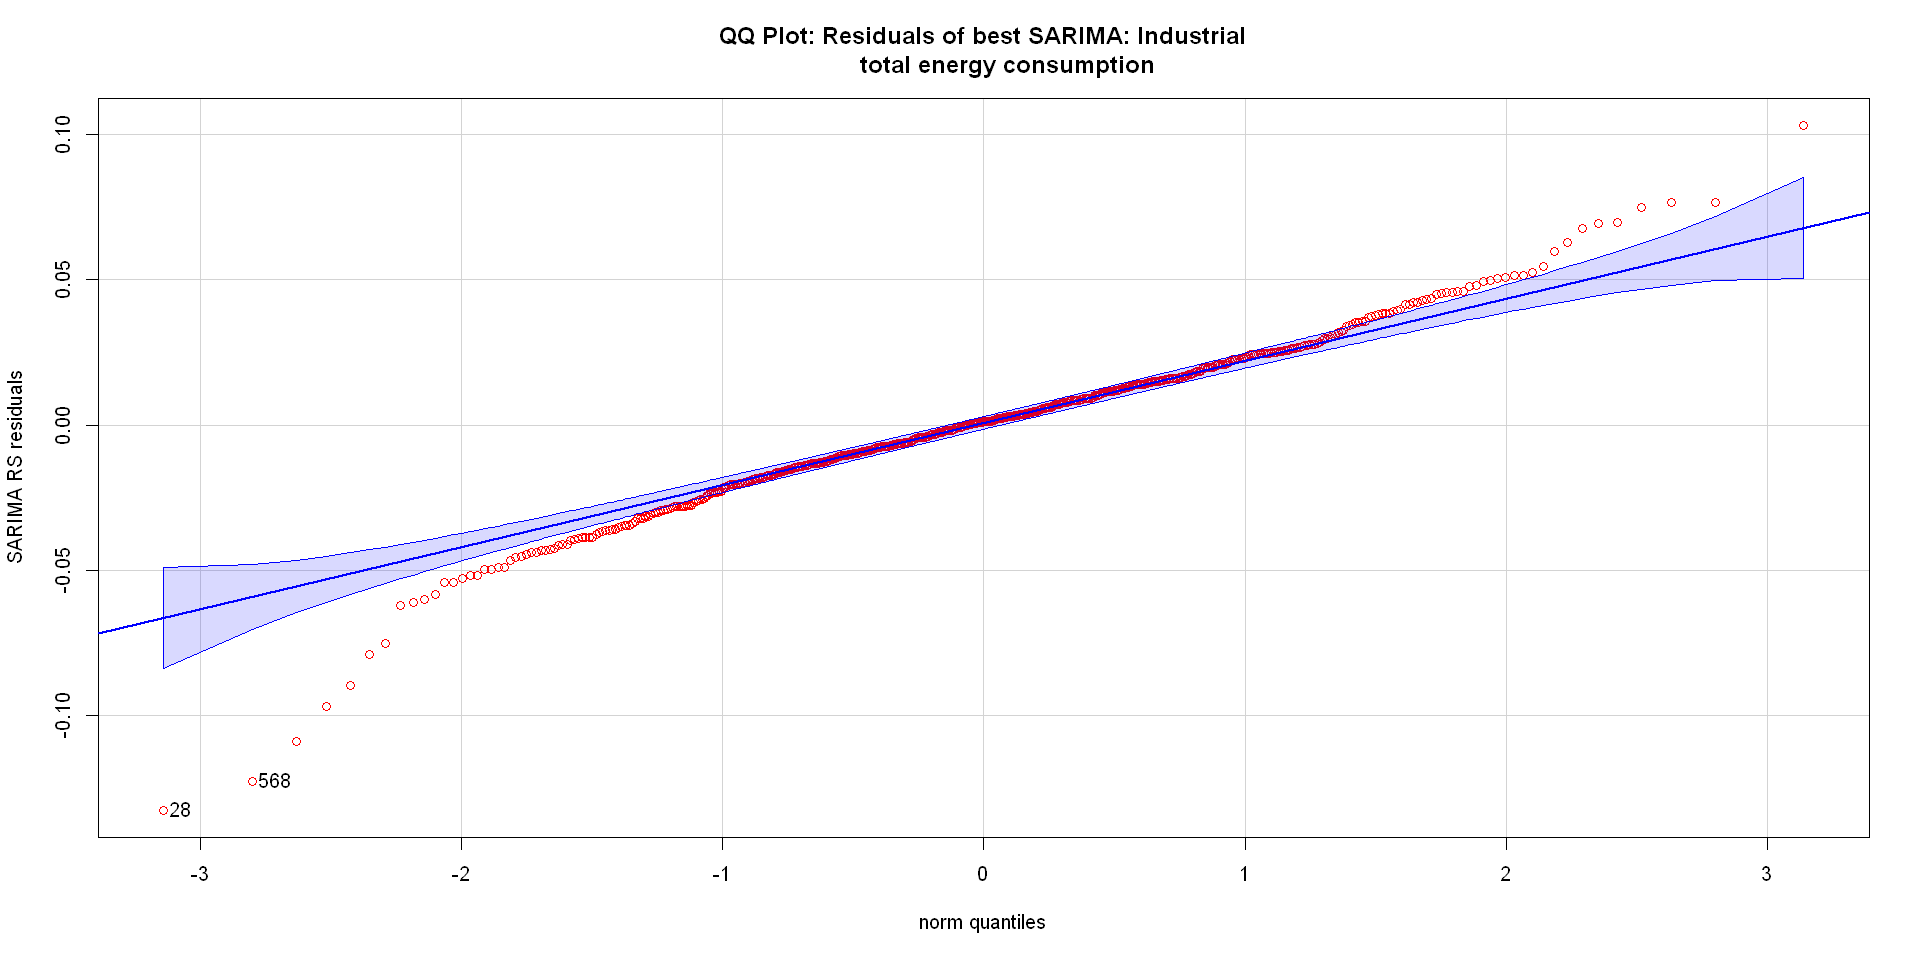

In [68]:
# Diagnostic plots
plot(SARIMA_IS$residuals,ylab="Residuals",main="Residuals of best SARIMA: Industrial
     total energy consumption",col="red")

acf(SARIMA_IS$residuals,lag.max = 12*12,main="ACF: Residuals of best SARIMA: Industrial
     total energy consumption",col="red")

pacf(SARIMA_IS$residuals,lag.max = 12*12,main="PACF: Residuals of best SARIMA: Industrial
     total energy consumption",col="red")

qqPlot(residuals(SARIMA_IS),ylab="SARIMA RS residuals",main="QQ Plot: Residuals of best SARIMA: Industrial
       total energy consumption",col="red")

# Test and see if residuals are correlated
Box.test(residuals(SARIMA_IS), lag = (SARIMA_IS$arma[1]+SARIMA_IS$arma[2]+1), type = "Box-Pierce", fitdf = (SARIMA_IS$arma[1]+SARIMA_IS$arma[2]))
Box.test(residuals(SARIMA_IS), lag = (SARIMA_IS$arma[1]+SARIMA_IS$arma[2]+1), type = "Ljung-Box", fitdf = (SARIMA_IS$arma[1]+SARIMA_IS$arma[2]))

The p values for both the Box-Pierce test and the Ljung-Box test are greater than 0.05, therefore, we cannot reject the null hypothesis of uncorrelated residuals.

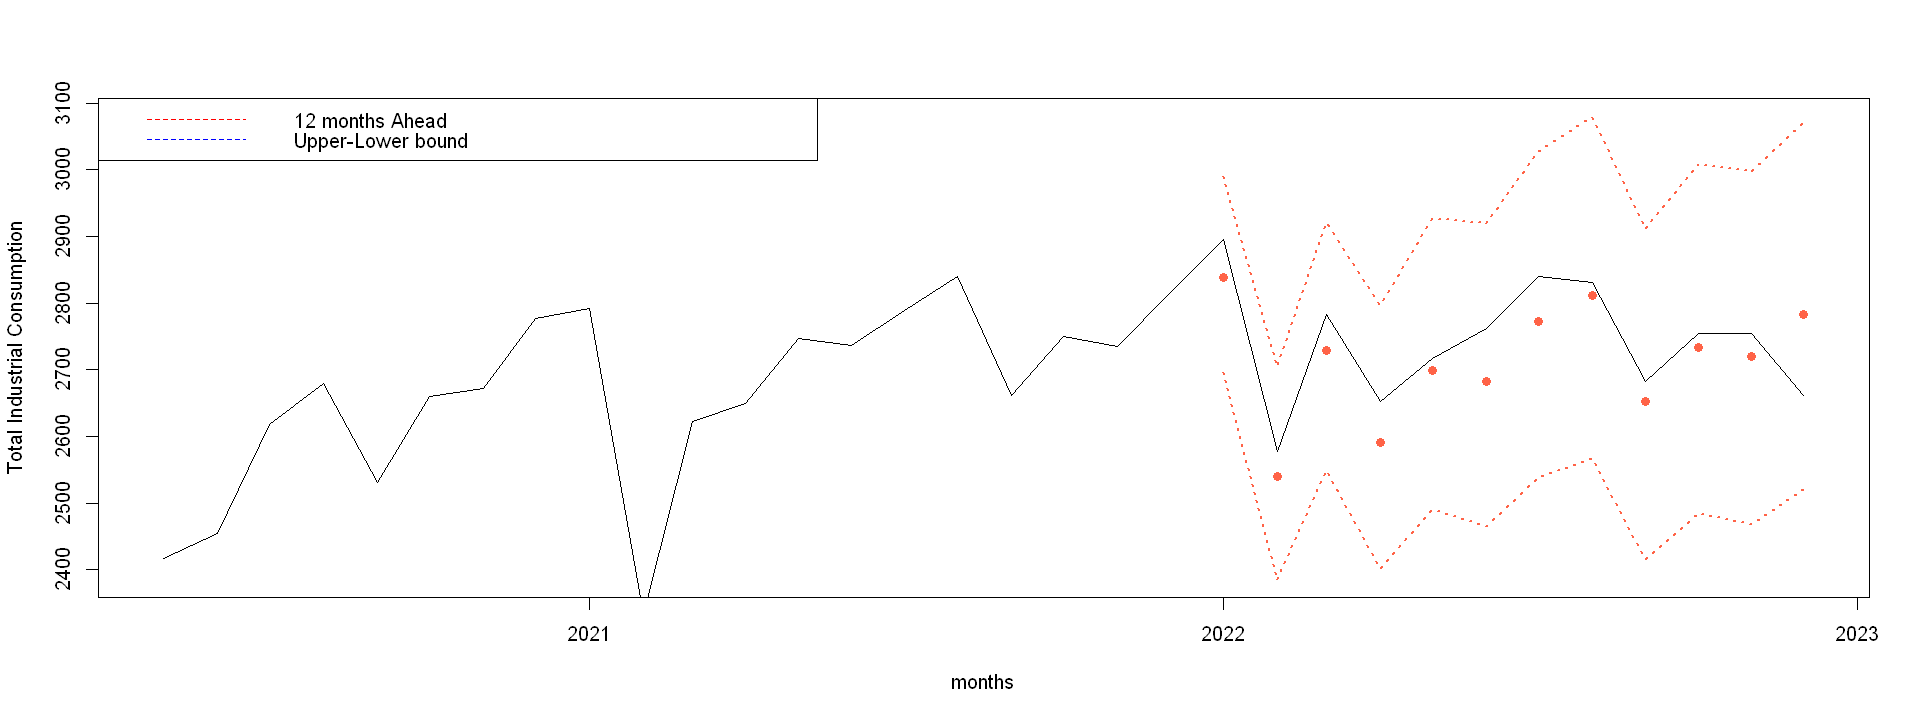

In [395]:
# predict 12 months ahead
n=length(Total_IS.ts)
nfit=n-12+1

n_forward=12
outpred = predict(SARIMA_IS,n.ahead=12)
ubound = exp(outpred$pred+1.96*outpred$se)
lbound = exp(outpred$pred-1.96*outpred$se)
ymin = min(lbound)
ymax = max(ubound)

plot(energy_data$dates[(nfit-20):n],exp(Total_IS.ts[(nfit-20):n]),type="l", ylim=c(ymin,ymax), xlab="months", ylab="Total Industrial Consumption")
points(energy_data$dates[nfit:n],exp(outpred$pred),col=col3,pch=16)
lines(energy_data$dates[nfit:n],ubound,lty=3,lwd= 2, col="blue")
lines(energy_data$dates[nfit:n],lbound,lty=3,lwd= 2, col="blue")
legend('topleft', legend=c("12 months Ahead ","Upper-Lower bound"),lty = 2, col=c("red","blue"))



In [70]:
## Compute Accuracy Measures
IS_true = as.vector(exp(Total_IS.ts[(nfit):n]))
IS_SARIMA_pred = exp(outpred$pred)

### Mean Absolute Percentage Error (MAPE)
mean(abs(IS_SARIMA_pred-IS_true)/IS_true)
### Precision Measure (PM)
sum((IS_SARIMA_pred-IS_true)^2)/sum((IS_true-mean(IS_true))^2)
#Review Accuracy measure interpretation

[1] 0.01820696

[1] 0.4464266

Fit ARMA-GARCH

In [71]:
suppressWarnings({
# Step 1
test_modelA <- function(p,d,q){
  # Total_IS.train.ts
  mod = arima(Total_IS.train.ts, order=c(p,d,q), method="ML")
  current.aic <- AIC(mod)
  current.aic<-current.aic-2*(p+q+1)+2*(p+q+1)*n/(n-p-q-2)
  df = data.frame(p,d,q,current.aic)
  names(df) <- c("p","d","q","AIC")
  return(df)
}

orders <- data.frame(Inf,Inf,Inf,Inf)
names(orders) <- c("p","d","q","AIC")
for (p in 0:5){
  for(d in 0:2) {
    for (q in 0:5) {
      possibleError <- tryCatch(
        orders<-rbind(orders,test_modelA(p,d,q)),
        error=function(e) e
      )
      if(inherits(possibleError, "error")) next
    }
  }
}

})
orders <- orders[order(-orders$AIC),]
tail(orders)

# ARIMA (5,1,5)

,p,d,q,AIC
,<dbl>,<dbl>,<dbl>,<dbl>
82,4,1,3,-2283.952
94,5,0,3,-2284.348
65,3,1,3,-2284.495
96,5,0,5,-2304.221
84,4,1,5,-2334.525
102,5,1,5,-2334.697


In [72]:

suppressWarnings({
# Step 2
##### Order Selection ################################################
test_modelAGG <- function(m,n){
  spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                    mean.model=list(armaOrder=c(5,5),
                                    include.mean=T),
                    distribution.model="std")
  fit = ugarchfit(spec, Total_IS.train.ts, solver = 'hybrid')
  current.bic = infocriteria(fit)[2]
  df = data.frame(m,n,current.bic)
  names(df) <- c("m","n","BIC")
  print(paste(m,n,current.bic,sep=" "))
  return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("m","n","BIC")

for (m in 0:2){
  for (n in 0:2){
    possibleError <- tryCatch(
      ordersAGG<-rbind(ordersAGG,test_modelAGG(m,n)),
      error=function(e) e
    )
    if(inherits(possibleError, "error")) next
  }
}

})
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

# GARCH (1, 1)

[1] "0 1 -3.960819032756"
[1] "0 2 -3.94967657645081"
[1] "1 0 -3.93846784699824"
[1] "1 1 -3.97801841716606"
[1] "1 2 292.039829844521"
[1] "2 0 -3.94028142689522"
[1] "2 1 -3.96967978310337"
[1] "2 2 -3.96120099289484"


,m,n,BIC
,<dbl>,<dbl>,<dbl>
7,2,0,-3.940281
3,0,2,-3.949677
2,0,1,-3.960819
9,2,2,-3.961201
8,2,1,-3.969680
5,1,1,-3.978018


In [73]:
suppressWarnings({
# Step 2
##### Order Selection ################################################
test_modelAGG <- function(p,q){
  spec = ugarchspec(
        variance.model=list(garchOrder=c(1,1)),
        mean.model=list(armaOrder=c(p,q), include.mean=T),
        distribution.model="std"
  )
  fit = ugarchfit(spec, Total_IS.train.ts, solver = 'hybrid')
  current.bic = infocriteria(fit)[2]
  df = data.frame(p,q,current.bic)
  names(df) <- c("p","q","BIC")
  print(paste(p,q,current.bic,sep=" "))
  return(df)
}

ordersAGG = data.frame(Inf,Inf,Inf)
names(ordersAGG) <- c("p","q","BIC")

for (p in 0:5){
  for (q in 0:5){
    possibleError <- tryCatch(
      ordersAGG<-rbind(ordersAGG,test_modelAGG(p,q)),
      error=function(e) e
    )
    if(inherits(possibleError, "error")) next
  }
}

})
ordersAGG <- ordersAGG[order(-ordersAGG$BIC),]
tail(ordersAGG)

[1] "0 0 -2.6900444629831"
[1] "0 1 -2.86827472925059"
[1] "0 2 -3.18089338268454"
[1] "0 3 -3.22604461879337"
[1] "0 4 -3.31586452057099"
[1] "0 5 -3.38578714630888"
[1] "1 0 -3.2005208185521"
[1] "1 1 -3.45712267491873"
[1] "1 2 -3.47987800024637"
[1] "1 3 -3.54799240375166"
[1] "1 4 -3.53747123235169"
[1] "1 5 -3.46871009766027"
[1] "2 0 -3.51997065358025"
[1] "2 1 -3.50965703923321"
[1] "2 2 -3.50174242314436"
[1] "2 3 -3.53544864559868"
[1] "2 4 -3.54950109833106"
[1] "2 5 -3.54726400514326"
[1] "3 0 -3.50217684185873"
[1] "3 1 -3.57005694160797"
[1] "3 2 -3.91555307417248"
[1] "3 3 -3.51993343833653"
[1] "3 4 -3.95223181107579"
[1] "3 5 -3.95082496130991"
[1] "4 0 -3.49377230334586"
[1] "4 1 -3.58144824930146"
[1] "4 2 -3.85288145002285"
[1] "4 3 -3.89951674148025"
[1] "4 4 -3.90294346285003"
[1] "4 5 -3.89320789689694"
[1] "5 0 -3.57891027630336"
[1] "5 1 -3.66185057581716"
[1] "5 2 -3.88255776049521"
[1] "5 3 -3.91709407387316"
[1] "5 4 -3.94999216202463"
[1] "5 5 -3.9780184171

,p,q,BIC
,<dbl>,<dbl>,<dbl>
22,3,2,-3.915553
35,5,3,-3.917094
36,5,4,-3.949992
25,3,5,-3.950825
24,3,4,-3.952232
37,5,5,-3.978018


The final model selected is ARMA (5,5) GARCH (1,1)


##### Evaluate Goodness of Fit



In [74]:
### Goodness of Fit ####################################################
train.spec_IS = ugarchspec(variance.model=list(garchOrder=c(1,1)),
                    mean.model=list(armaOrder=c(5,5),
                                    include.mean=T), distribution.model="std")
model_IS = ugarchfit(train.spec_IS, Total_IS.train.ts, solver = 'hybrid')

## compare Information Criteria
infocriteria(model_IS)

,
Akaike,-4.089670
Bayes,-3.978018
Shibata,-4.090929
Hannan-Quinn,-4.046167


##### Evaluate Residuals

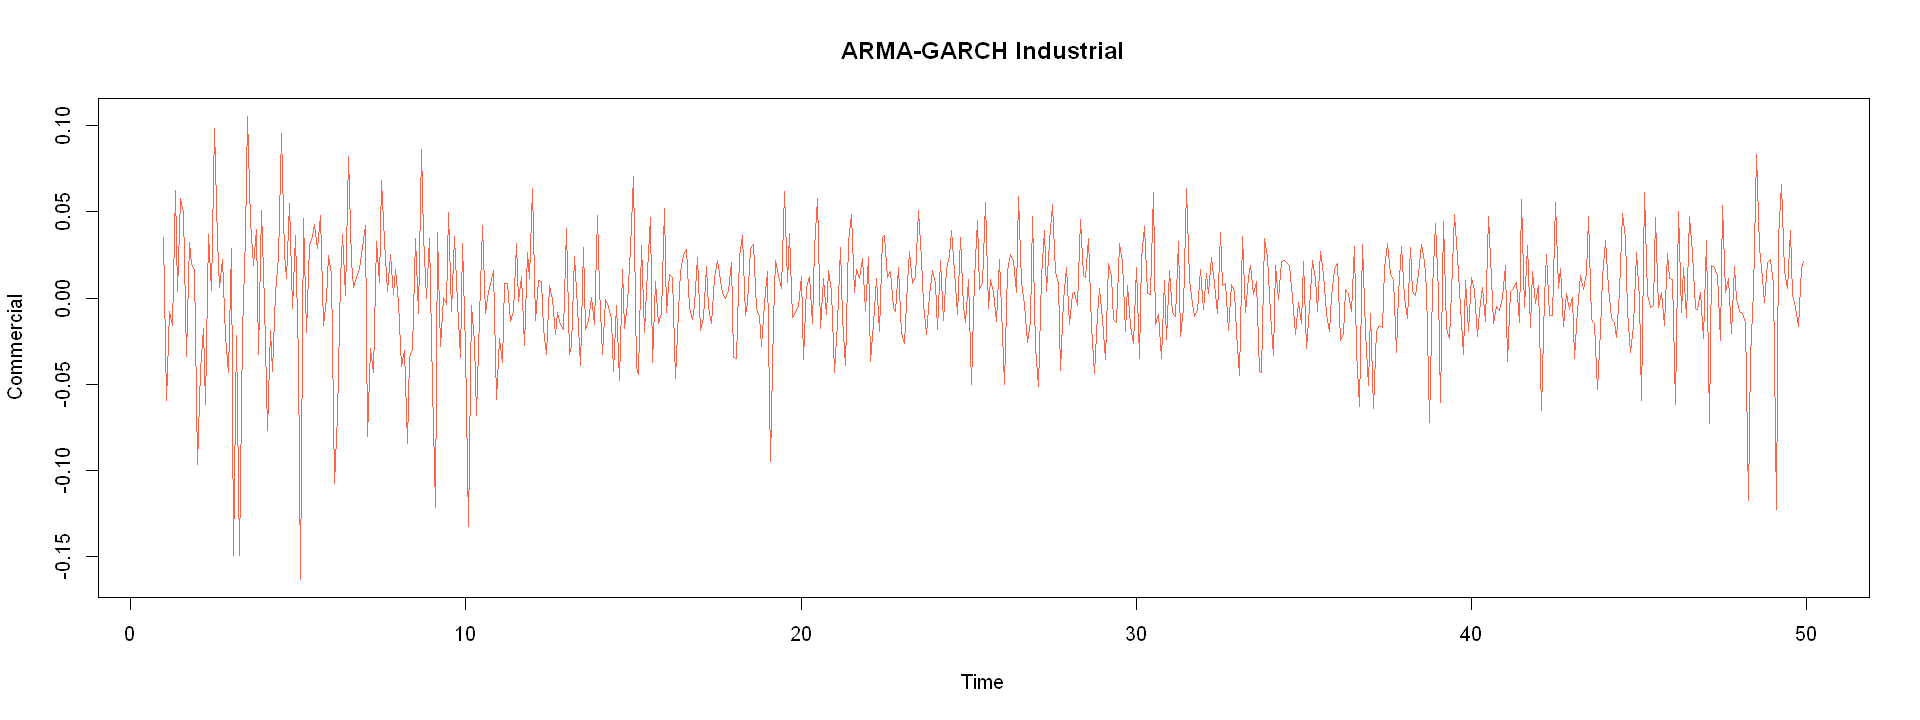

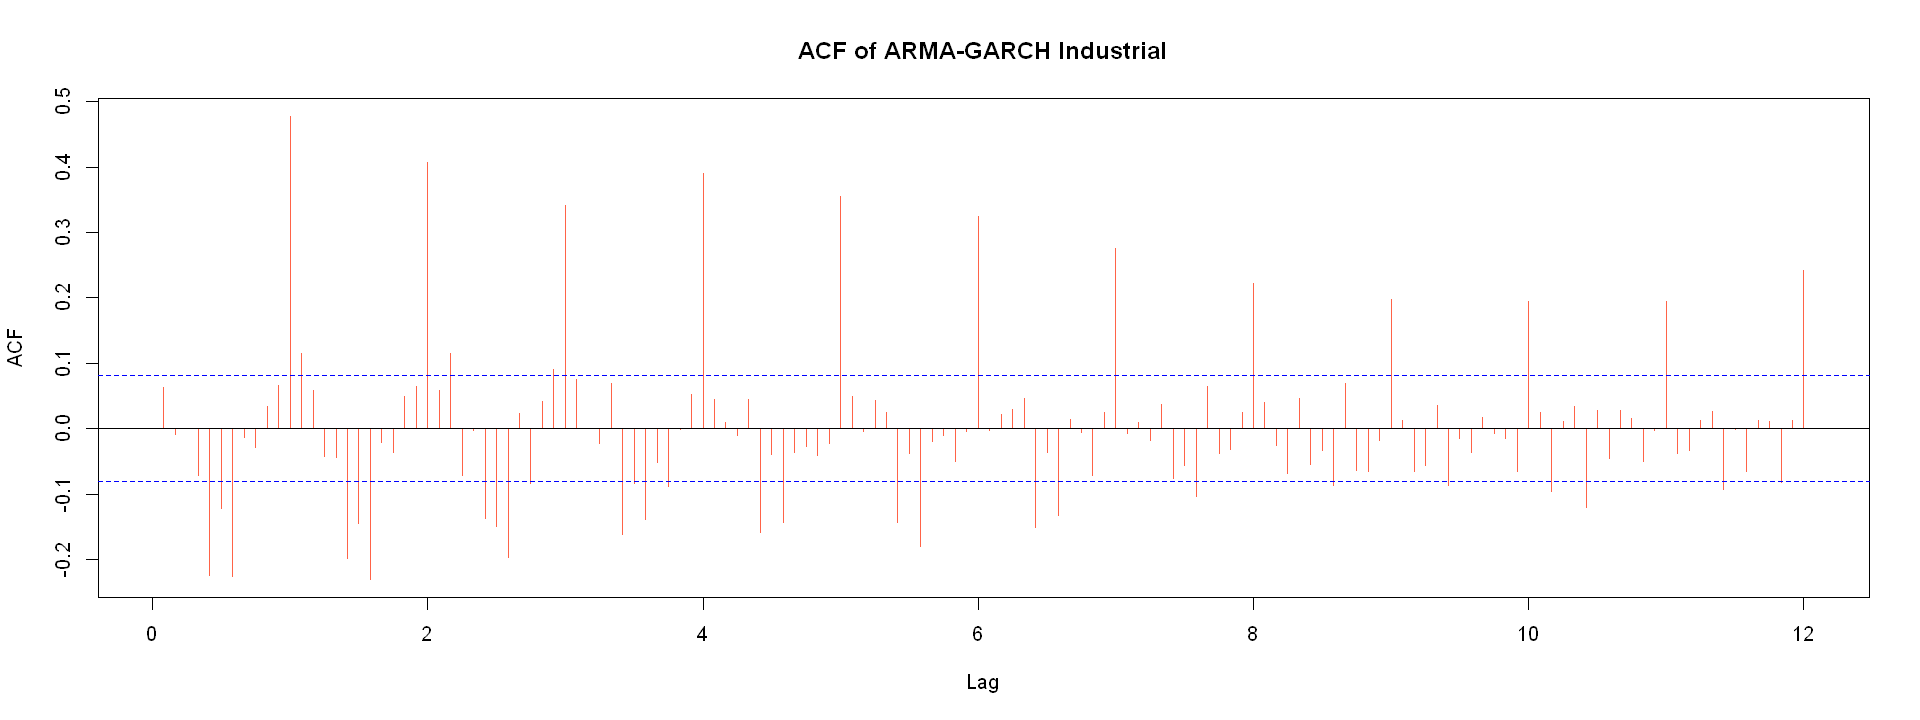


	Box-Ljung test

data:  model.resid_IS
X-squared = 74.552, df = 8, p-value = 6.064e-13



	Box-Ljung test

data:  model.resid_IS^2
X-squared = 45.017, df = 8, p-value = 3.652e-07


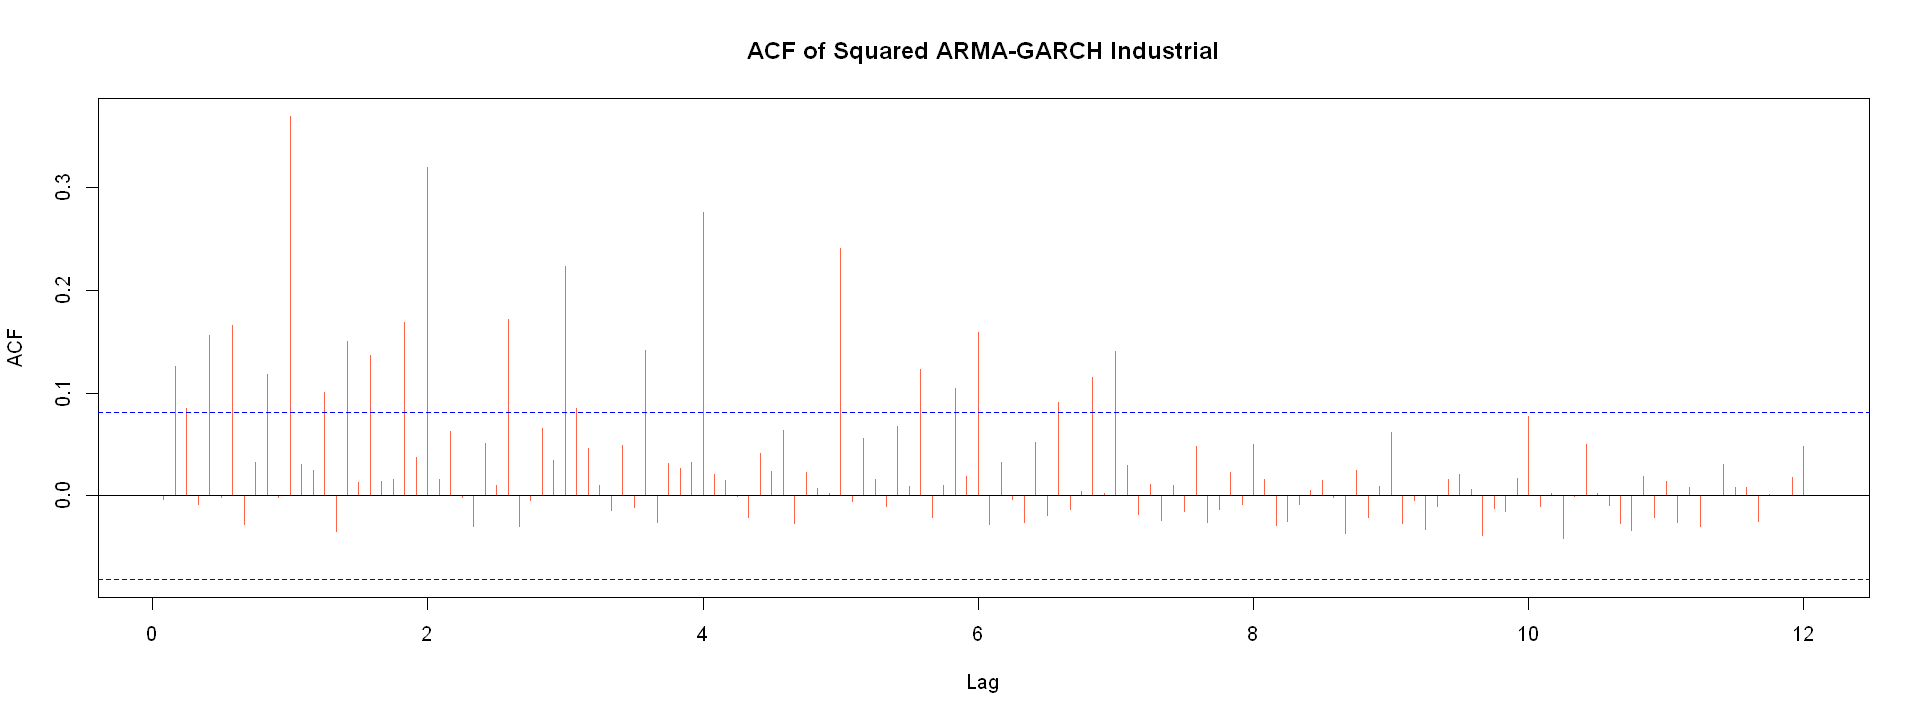

In [396]:
## Residual Analysis
model.resid_IS = residuals(model_IS)

#plot the residuals introduced removing the trend and seasonality
ts.plot(ts(model.resid_IS,frequency=12),col=col3,ylab="Commercial", main="ARMA-GARCH Industrial")

acf(model.resid_IS,lag.max=12*12,col=col3,main="ACF of ARMA-GARCH Industrial")
acf(model.resid_IS^2,lag.max=12*12,col=col3,main="ACF of Squared ARMA-GARCH Industrial")
Box.test(model.resid_IS,lag=8,type='Ljung')
Box.test(model.resid_IS^2,lag=8,type='Ljung')



##### Comments

The residuals plot looks stationary.The stationarity was also confirmed by running an ADF test that shows a small p-value. However, the ACF plot shows strong autocorrelation and the seasonality is still visible.

##### Plot the ARMA-GARCH predictions



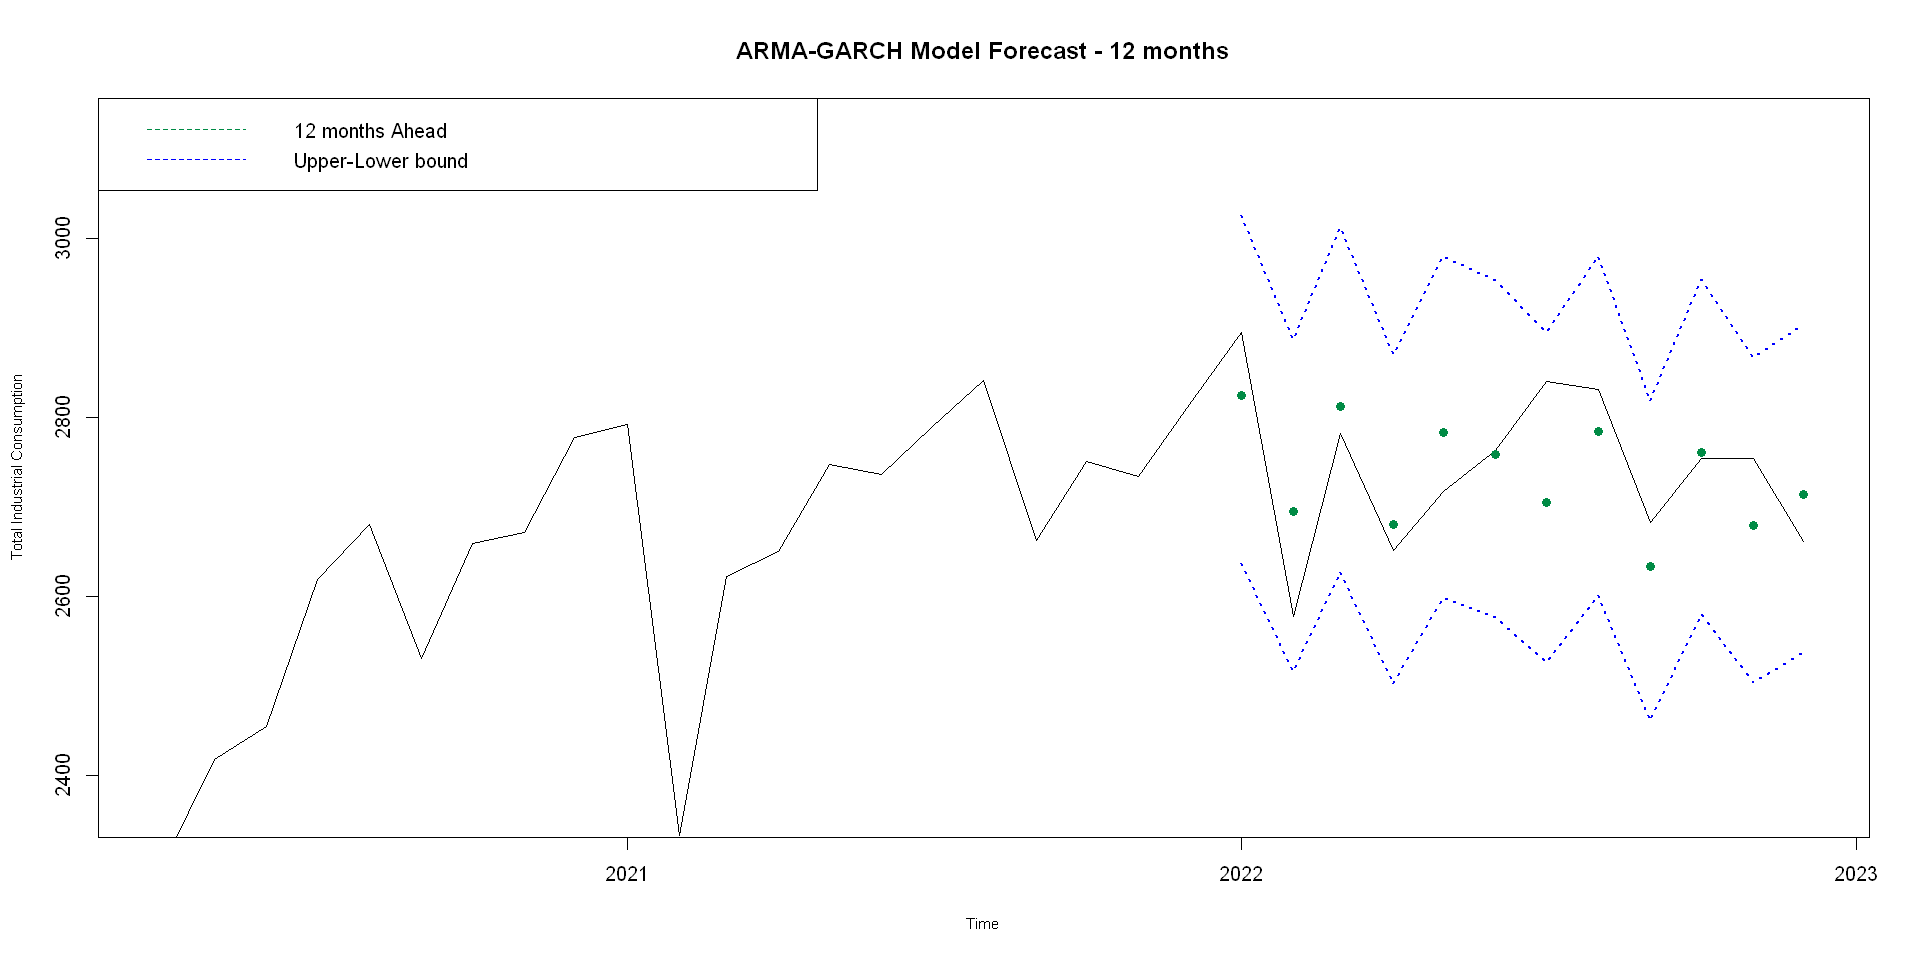

In [77]:
# predict 12 months ahead
n.tot=length(Total_IS.ts)
nfit.tot=n.tot-12

fore_IS = ugarchforecast(model_IS, n.ahead = 12)

model_IS_pred  = exp(fore_IS@forecast$seriesFor)

ubound2 = exp(fore_IS@forecast$seriesFor+1.96*fore_IS@forecast$sigmaFor)
lbound2 = exp(fore_IS@forecast$seriesFor-1.96*fore_IS@forecast$sigmaFor)
ymin2 = min(lbound2)-100
ymax2 = max(ubound2)+100

plot(
    energy_data$dates[(nfit.tot-20):n.tot],exp(Total_IS.ts[(nfit.tot-20):n.tot]),type="l", 
    ylim=c(ymin2,ymax2), xlab="Time", 
    ylab="Total Industrial Consumption", main="ARMA-GARCH Model Forecast - 12 months"
)

points(energy_data$dates[(nfit.tot+1):n.tot],model_IS_pred,col=col3,pch=16)
lines(energy_data$dates[(nfit.tot+1):n.tot],ubound2,lty=3,lwd= 2, col="blue")
lines(energy_data$dates[(nfit.tot+1):n.tot],lbound2,lty=3,lwd= 2, col="blue")
legend('topleft', legend=c("12 months Ahead ","Upper-Lower bound"),lty = 2, col=c(col1,"blue"))



##### Accuracy measures



In [78]:
## Compute Accuracy Measures
IS_true = as.vector(exp(Total_IS.ts[(nfit.tot+1):n.tot]))

fore_IS = ugarchforecast(model_IS, n.ahead = 12)

model_IS_pred  = exp(fore_IS@forecast$seriesFor)

### Mean Absolute Percentage Error (MAPE)
mean(abs(model_IS_pred-IS_true)/IS_true)
### Precision Measure (PM)
sum((model_IS_pred-IS_true)^2)/sum((IS_true-mean(IS_true))^2)

[1] 0.02073213

[1] 0.6305965

## Combined plots

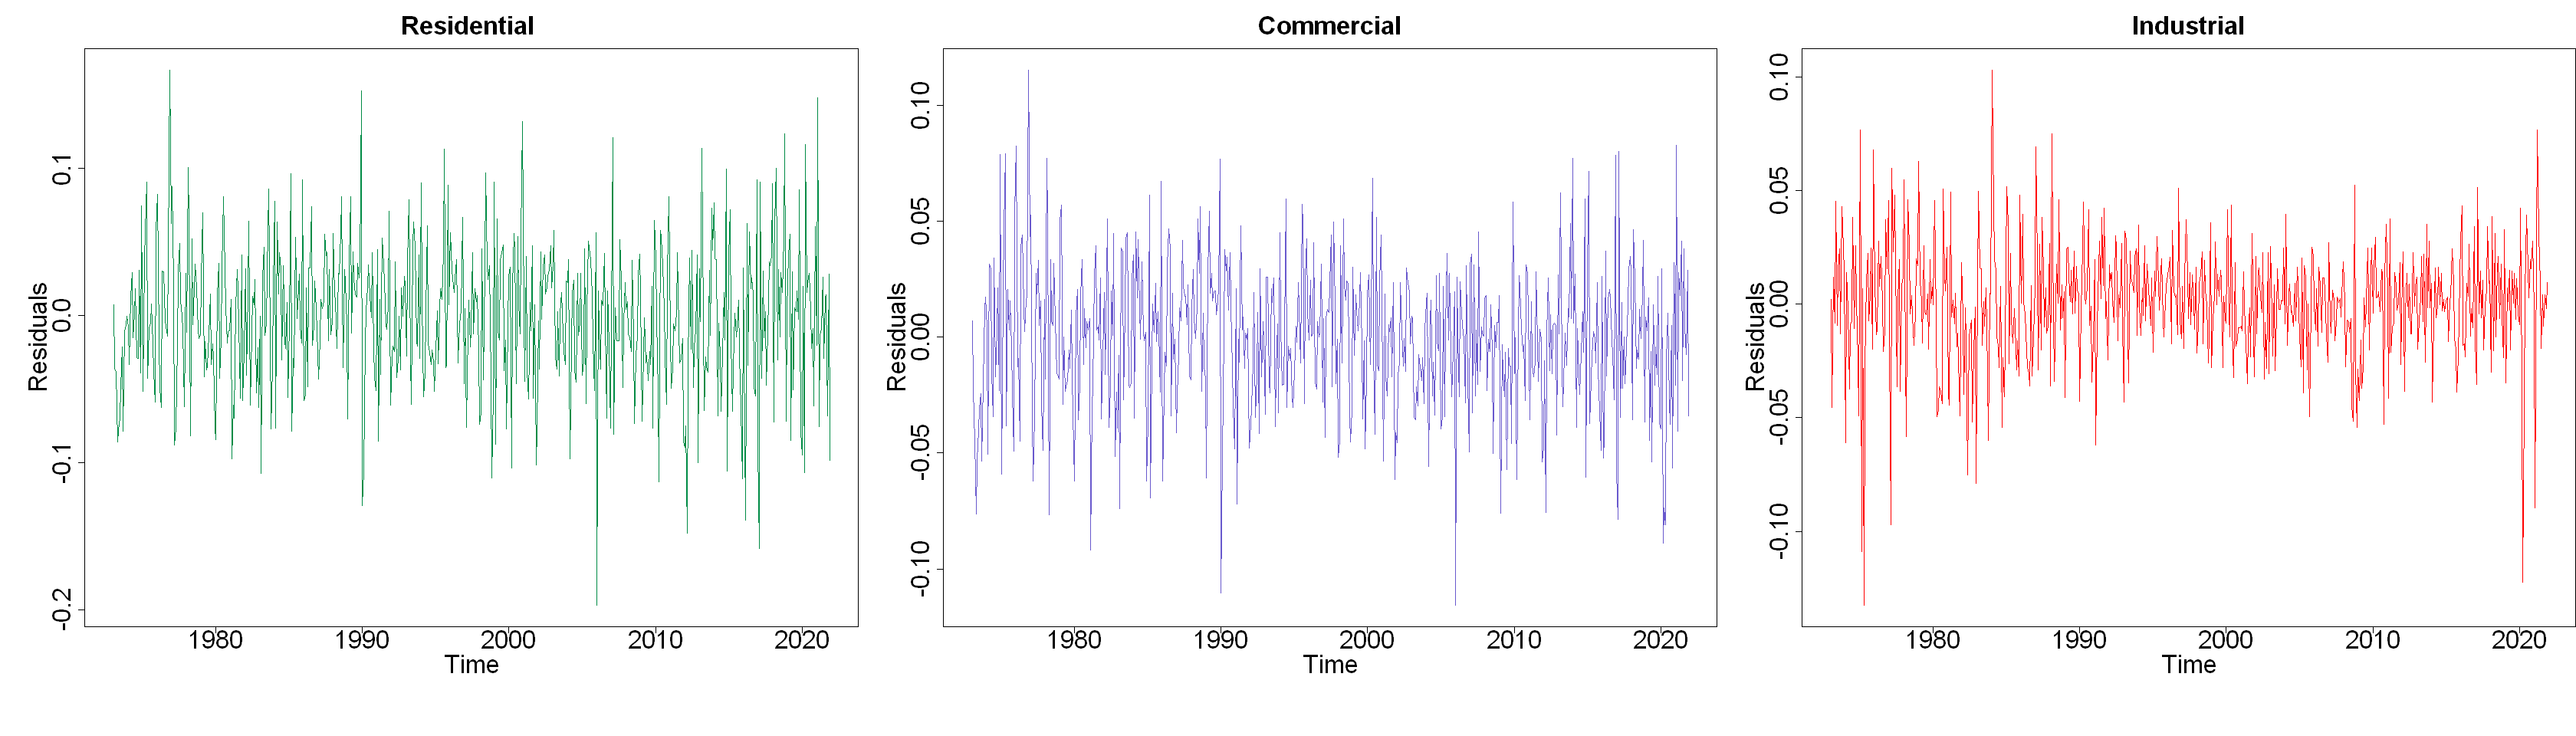

In [420]:
# Diagnostic plots
options(repr.plot.width=28, repr.plot.height=8)
par(mfrow=c(1,3))
par(cex.lab=2.5, cex.axis=2.5, cex.main=2.5, cex.sub=2)
par(mar=c(9,7,4,0))
par(oma=c(0,0,0,0))

plot(SARIMA_RS$residuals, ylab="Residuals",main="Residential ",col="springgreen4")
plot(SARIMA_CS$residuals, ylab="Residuals",main="Commercial",col="slateblue3")
plot(SARIMA_IS$residuals, ylab="Residuals",main="Industrial",col="red")

# acf(SARIMA_IS$residuals,lag.max = 12*12,main="ACF: Residuals of best SARIMA: Industrial
#      total energy consumption",col="red")

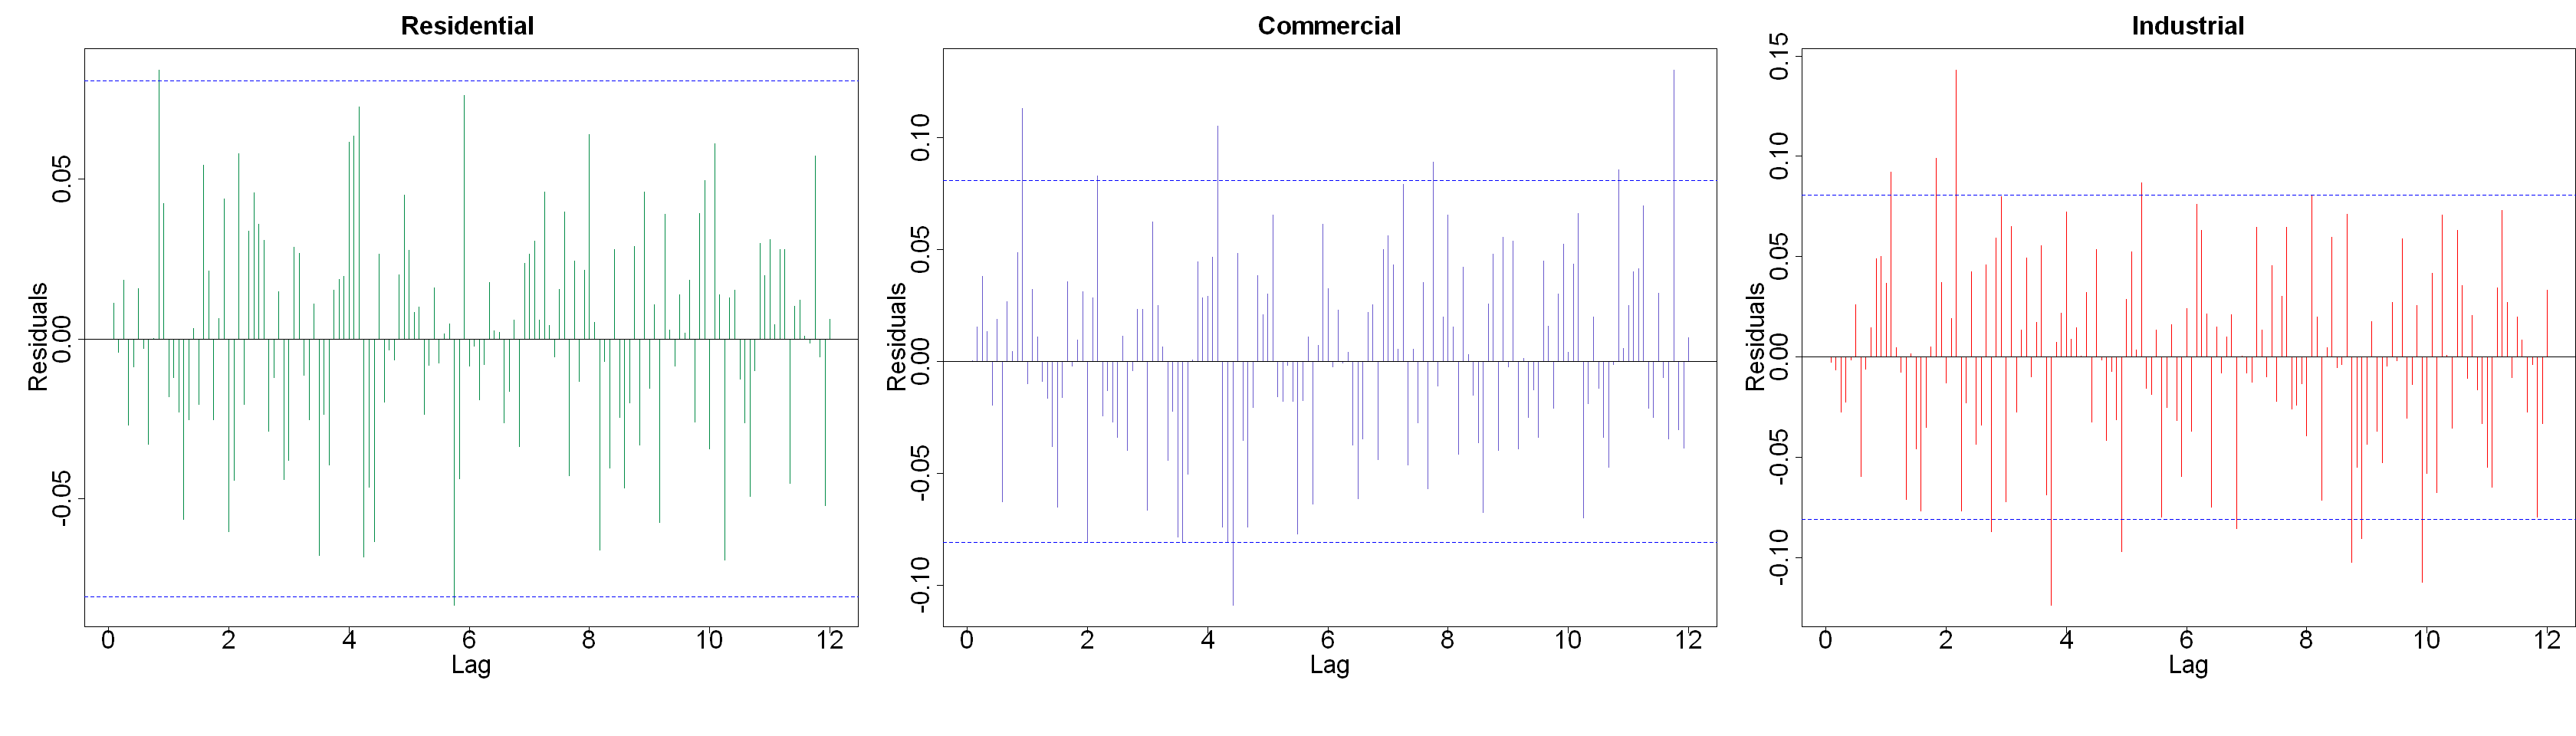

In [80]:
# Diagnostic plots
options(repr.plot.width=28, repr.plot.height=8)
par(mfrow=c(1,3))
par(cex.lab=2.5, cex.axis=2.5, cex.main=2.5, cex.sub=2)
par(mar=c(9,7,4,0))
par(oma=c(0,0,0,0))

acf(SARIMA_RS$residuals,lag.max = 12*12,,ylab="Residuals",main="Residential ",col="springgreen4")
acf(SARIMA_CS$residuals,lag.max = 12*12,,ylab="Residuals",main="Commercial",col="slateblue3")
acf(SARIMA_IS$residuals,lag.max = 12*12,,ylab="Residuals",main="Industrial",col="red")

# acf(SARIMA_IS$residuals,lag.max = 12*12,main="ACF: Residuals of best SARIMA: Industrial
#      total energy consumption",col="red")

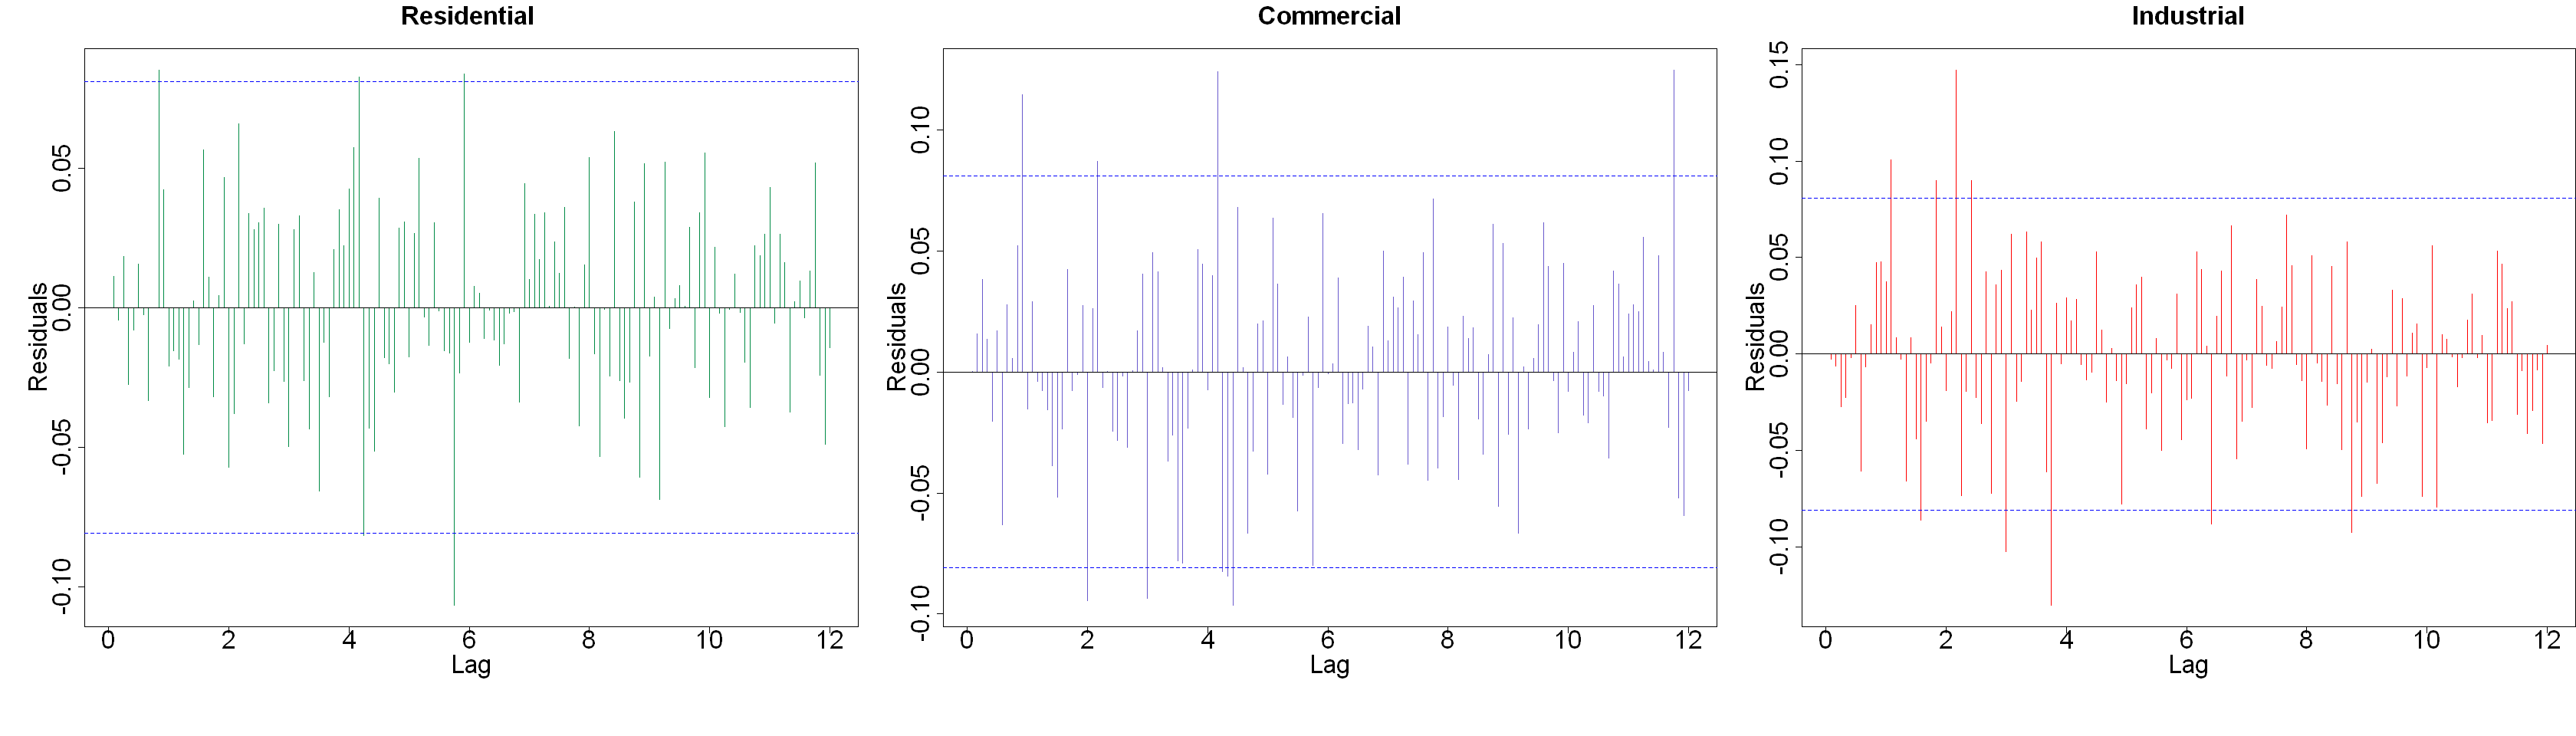

In [81]:
# Diagnostic plots
options(repr.plot.width=28, repr.plot.height=8)
par(mfrow=c(1,3))
par(cex.lab=2.5, cex.axis=2.5, cex.main=2.5, cex.sub=2)
par(mar=c(9,7,4,0))
par(oma=c(0,0,0,0))

pacf(SARIMA_RS$residuals,lag.max = 12*12,,ylab="Residuals",main="Residential ",col="springgreen4")
pacf(SARIMA_CS$residuals,lag.max = 12*12,,ylab="Residuals",main="Commercial",col="slateblue3")
pacf(SARIMA_IS$residuals,lag.max = 12*12,,ylab="Residuals",main="Industrial",col="red")

# Energy vs GDP Analysis

## Trend Components

In [466]:
############### TREND and SEASONALITY ESTIMATION FOR TOTAL RESIDENTIAL ENERGY CONSUMPTION ###################
## X-axis points converted to 0-1 scale, common in nonparametric regression
time.pts = c(1:length(Total_RS.ag.ts))
time.pts = c(time.pts - min(time.pts))/max(time.pts)

trend.model.RS = gam(Total_RS.ag.ts~s(time.pts))  # Freq = 4
fitted.trend.RS.ts = ts(fitted(trend.model.RS), start=1973, frequency=4)
fitted.trend.RS.ts = fitted.trend.RS.ts/fitted.trend.RS.ts[1]

trend.model.CS = gam(Total_CS.ag.ts~s(time.pts))  # Freq = 4
fitted.trend.CS.ts = ts(fitted(trend.model.CS), start=1973, frequency=4)
fitted.trend.CS.ts = fitted.trend.CS.ts/fitted.trend.CS.ts[1]

trend.model.IS = gam(Total_IS.ag.ts~s(time.pts))  # Freq = 4
fitted.trend.IS.ts = ts(fitted(trend.model.IS), start=1973, frequency=4)
fitted.trend.IS.ts = fitted.trend.IS.ts/fitted.trend.IS.ts[1]

trend.model.GDP = gam(gdp_data.ts~s(time.pts))  # Freq = 4
fitted.trend.GDP.ts = ts(fitted(trend.model.GDP), start=1973, frequency=4)
fitted.trend.GDP.ts = fitted.trend.GDP.ts/fitted.trend.GDP.ts[1]

In [467]:
combined.energy = cbind(c(fitted.trend.RS.ts,fitted.trend.CS.ts, fitted.trend.IS.ts, fitted.trend.GDP.ts))
ymin = min(combined.energy)
ymax = max(combined.energy)

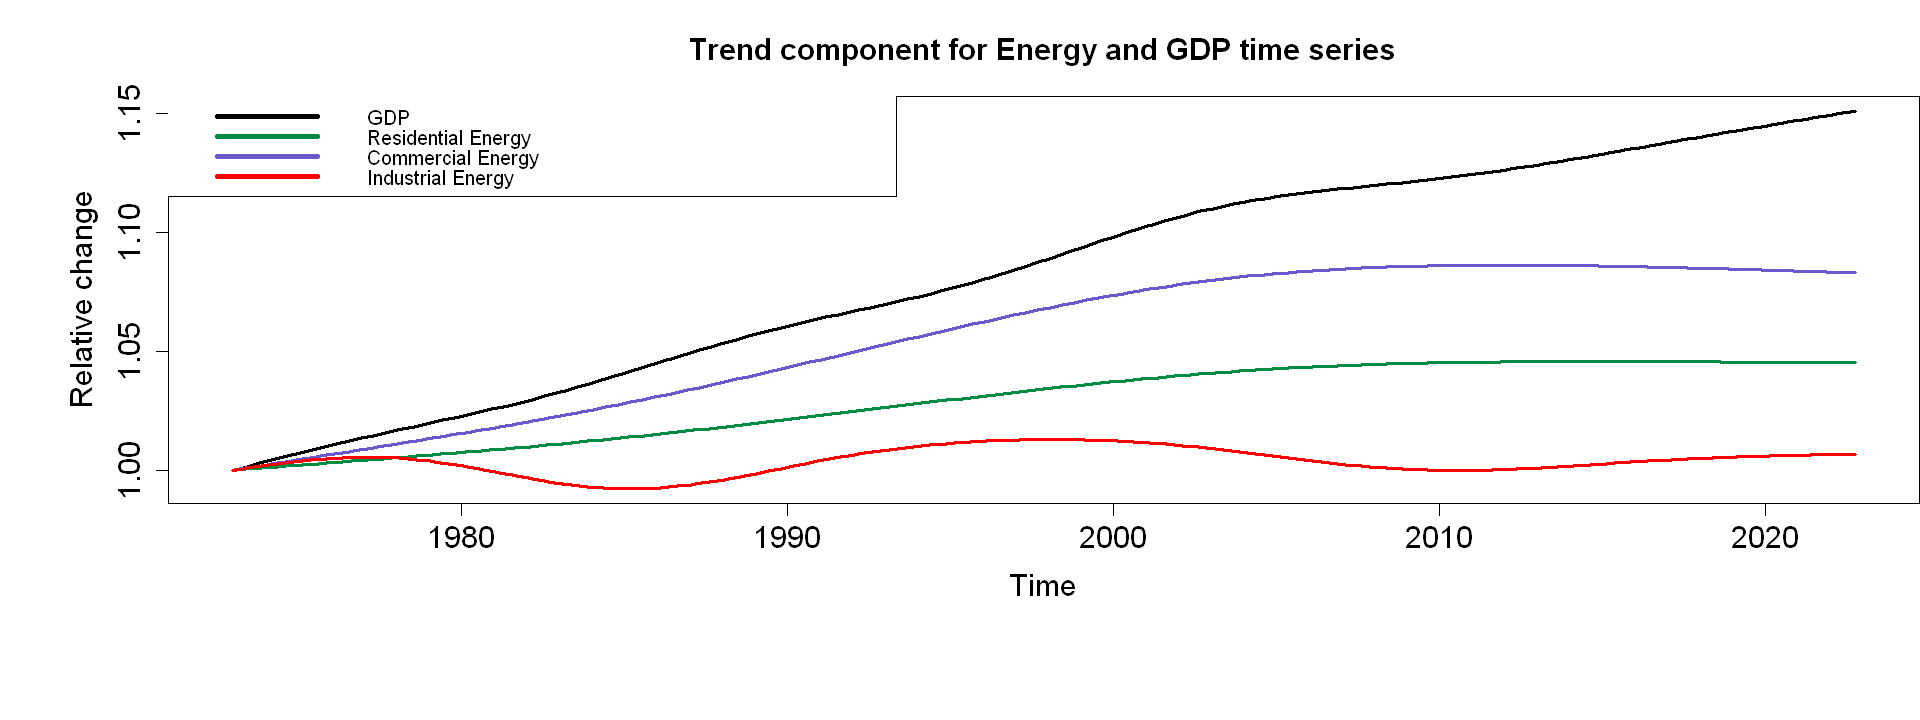

In [84]:
options(repr.plot.width=16, repr.plot.height=6)
par(mfrow=c(1,1))

par(cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1)
par(mar=c(9,7,4,0))
par(oma=c(0,0,0,0))

ts.plot(fitted.trend.GDP.ts, lty=1, lwd= 3, col="black", ylim=c(ymin, ymax), ylab="Relative change", main="Trend component for Energy and GDP time series")

lines(fitted.trend.RS.ts, lty=1, lwd= 3, col="springgreen4")
lines(fitted.trend.CS.ts, lty=1, lwd= 3, col="slateblue3")
lines(fitted.trend.IS.ts, lty=1, lwd= 3, col="red")
legend("topleft", legend=c("GDP", "Residential Energy", "Commercial Energy", "Industrial Energy"),lty = 1, lwd=4, col=c("black","springgreen4", "slateblue3", "red"), )

## Seasonality Components

In [85]:
resid.trend.RS.ts = ts(resid(trend.model.RS), start=1973, frequency=4)
resid.trend.CS.ts = ts(resid(trend.model.CS), start=1973, frequency=4)
resid.trend.IS.ts = ts(resid(trend.model.IS), start=1973, frequency=4)
resid.trend.GDP.ts = ts(resid(trend.model.GDP), start=1973, frequency=4)

In [86]:
energy.mon = as.factor(month(as.Date(resid.trend.RS.ts)))
energy.qtr = as.factor(quarter(as.Date(resid.trend.RS.ts)))
gdp.qtr = as.factor(quarter(as.Date(resid.trend.GDP.ts)))

seas.model.RS = lm(resid.trend.RS.ts ~ energy.qtr - 1)  # Freq = 4
seas.model.CS = lm(resid.trend.CS.ts ~ energy.qtr - 1)  # Freq = 4
seas.model.IS = lm(resid.trend.IS.ts ~ energy.qtr - 1)  # Freq = 4
seas.model.GDP = lm(resid.trend.GDP.ts ~ gdp.qtr - 1)  # Freq = 4

In [87]:
summary(seas.model.RS)
summary(seas.model.CS)
summary(seas.model.IS)
summary(seas.model.GDP)


Call:
lm(formula = resid.trend.RS.ts ~ energy.qtr - 1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.165632 -0.032691  0.003312  0.035076  0.150332 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
energy.qtr1  0.268587   0.008077   33.26   <2e-16 ***
energy.qtr2 -0.173943   0.008077  -21.54   <2e-16 ***
energy.qtr3 -0.103850   0.008077  -12.86   <2e-16 ***
energy.qtr4  0.009207   0.008077    1.14    0.256    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05711 on 196 degrees of freedom
Multiple R-squared:  0.8986,	Adjusted R-squared:  0.8965 
F-statistic: 434.1 on 4 and 196 DF,  p-value: < 2.2e-16



Call:
lm(formula = resid.trend.CS.ts ~ energy.qtr - 1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.119463 -0.028848 -0.000688  0.025451  0.155109 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
energy.qtr1  0.116228   0.006195  18.762   <2e-16 ***
energy.qtr2 -0.080519   0.006195 -12.997   <2e-16 ***
energy.qtr3 -0.042352   0.006195  -6.836    1e-10 ***
energy.qtr4  0.006642   0.006195   1.072    0.285    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04381 on 196 degrees of freedom
Multiple R-squared:  0.7437,	Adjusted R-squared:  0.7385 
F-statistic: 142.2 on 4 and 196 DF,  p-value: < 2.2e-16



Call:
lm(formula = resid.trend.IS.ts ~ energy.qtr - 1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.166468 -0.016674  0.006672  0.019924  0.116602 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
energy.qtr1 -0.012123   0.005336  -2.272 0.024173 *  
energy.qtr2 -0.017877   0.005336  -3.351 0.000968 ***
energy.qtr3  0.009556   0.005336   1.791 0.074840 .  
energy.qtr4  0.020444   0.005336   3.832 0.000171 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03773 on 196 degrees of freedom
Multiple R-squared:  0.1488,	Adjusted R-squared:  0.1315 
F-statistic: 8.569 on 4 and 196 DF,  p-value: 2.155e-06



Call:
lm(formula = resid.trend.GDP.ts ~ gdp.qtr - 1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.093312 -0.011005  0.002717  0.011631  0.043549 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)
gdp.qtr1 -0.0003250  0.0027199  -0.120    0.905
gdp.qtr2 -0.0009496  0.0027199  -0.349    0.727
gdp.qtr3  0.0005305  0.0027199   0.195    0.846
gdp.qtr4  0.0007441  0.0027199   0.274    0.785

Residual standard error: 0.01923 on 196 degrees of freedom
Multiple R-squared:  0.001269,	Adjusted R-squared:  -0.01911 
F-statistic: 0.06227 on 4 and 196 DF,  p-value: 0.9928


## VAR Model

In this section we explore the relationships between the various time series. Initially, we will treat GDP as an endogenous factor.

#### Merge Time Series

In [88]:
RS.ag.1 <- as.zoo(Total_RS.ag.ts)
CS.ag.1 <-as.zoo(Total_CS.ag.ts)
IS.ag.1 <- as.zoo(Total_IS.ag.ts)
GP.ag.1 <- as.zoo(gdp_data.ts)

n.ag = n.tot/3
n.ag_forward = 4
n.ag_fit = n.ag-4

RS.ag.tr1=ts(RS.ag.1[1:(n.ag-4)],start=1974,frequency=4)
CS.ag.tr1=ts(CS.ag.1[1:(n.ag-4)],start=1974,frequency=4)
IS.ag.tr1=ts(IS.ag.1[1:(n.ag-4)],start=1974,frequency=4)
GP.ag.tr1=ts(GP.ag.1[1:(n.ag-4)],start=1974,frequency=4)

# Merge the zoo objects
All.ag.1 <- merge(RS.ag.1, CS.ag.1,IS.ag.1, GP.ag.1)
All.ag.tr1 <- merge(RS.ag.1[1:(n.ag-4)], CS.ag.1[1:(n.ag-4)],IS.ag.1[1:(n.ag-4)], GP.ag.1[1:(n.ag-4)])


#### Plot Time Series



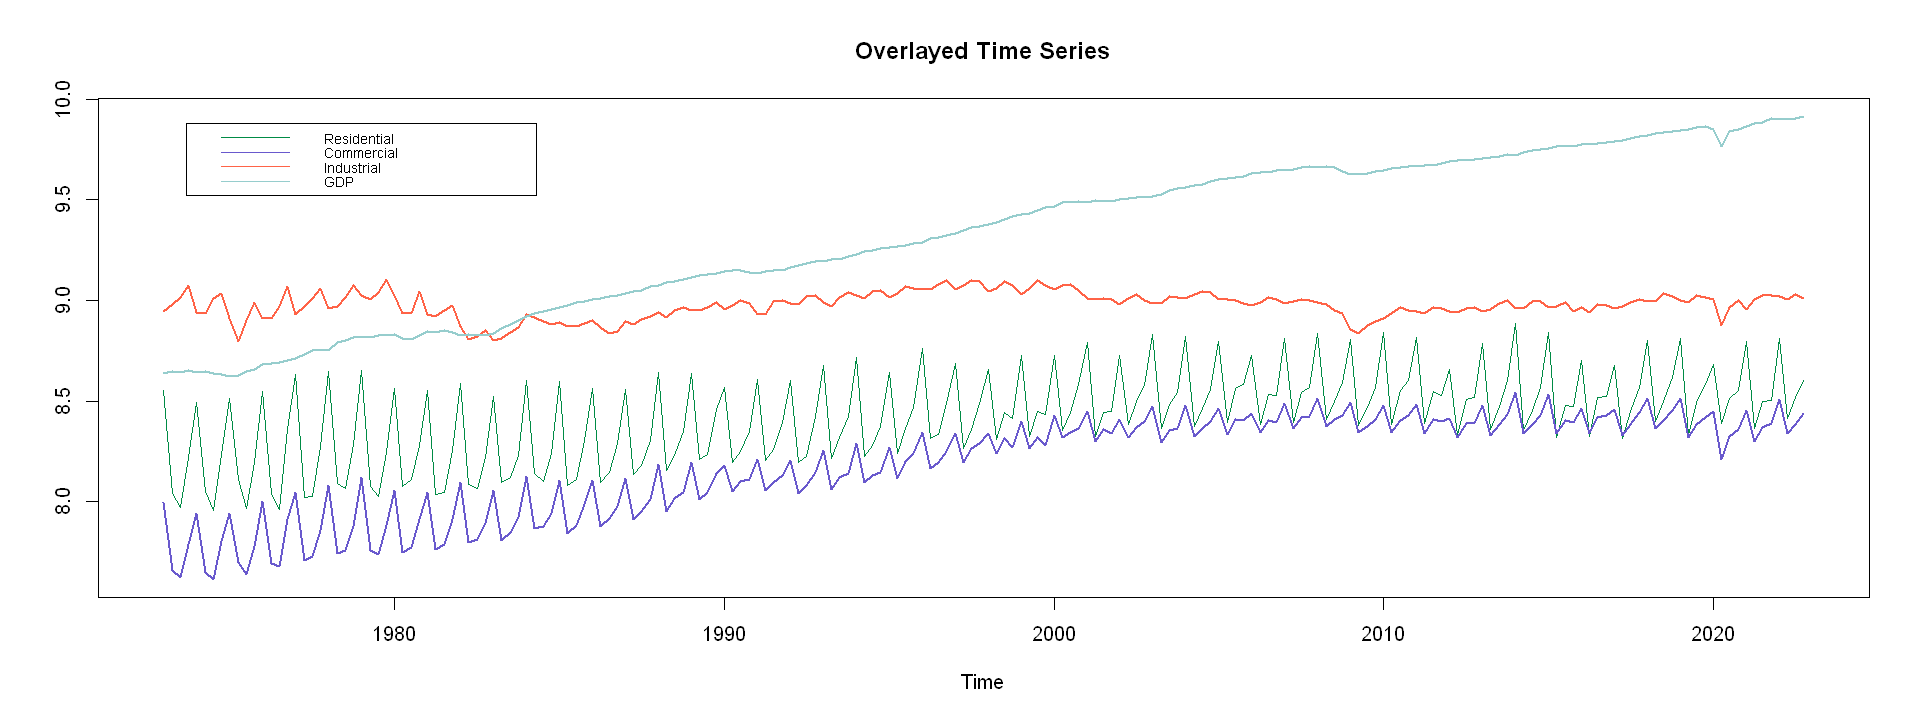

In [89]:
# plot the time series for all indicators
plot(RS.ag.1,col= col1,ylim=c(min(All.ag.1),max(All.ag.1)),ylab = "", xlab="Time",main='Overlayed Time Series')
lines(CS.ag.1, lwd=2,col=col2)
lines(IS.ag.1, lwd=2,col=col3)
lines(GP.ag.1, lwd=2,col=col4)
legend(x="topleft",inset=c(0.05, 0.05), cex=0.70,legend=c("Residential","Commercial","Industrial","GDP"),lty = 1, col=c(col1,col2,col3, col4),  xpd=TRUE)


#### Create Differenced Time Series



In [90]:
dRS.ag.1 = (diff(Total_RS.ag.ts,4))
dCS.ag.1 = (diff(Total_CS.ag.ts,4))
dIS.ag.1 = (diff(Total_IS.ag.ts,4))
dGP.ag.1 = (diff(gdp_data.ts,4))

# Merge the zoo objects
dAll.ag.1 <- ts.union(dRS.ag.1, dCS.ag.1,dIS.ag.1, dGP.ag.1)

All.ag.tr1 <- merge(RS.ag.1[1:(n.ag-4)], CS.ag.1[1:(n.ag-4)],IS.ag.1[1:(n.ag-4)], GP.ag.1[1:(n.ag-4)])


#### Check Stationarity for Differenced Time Series



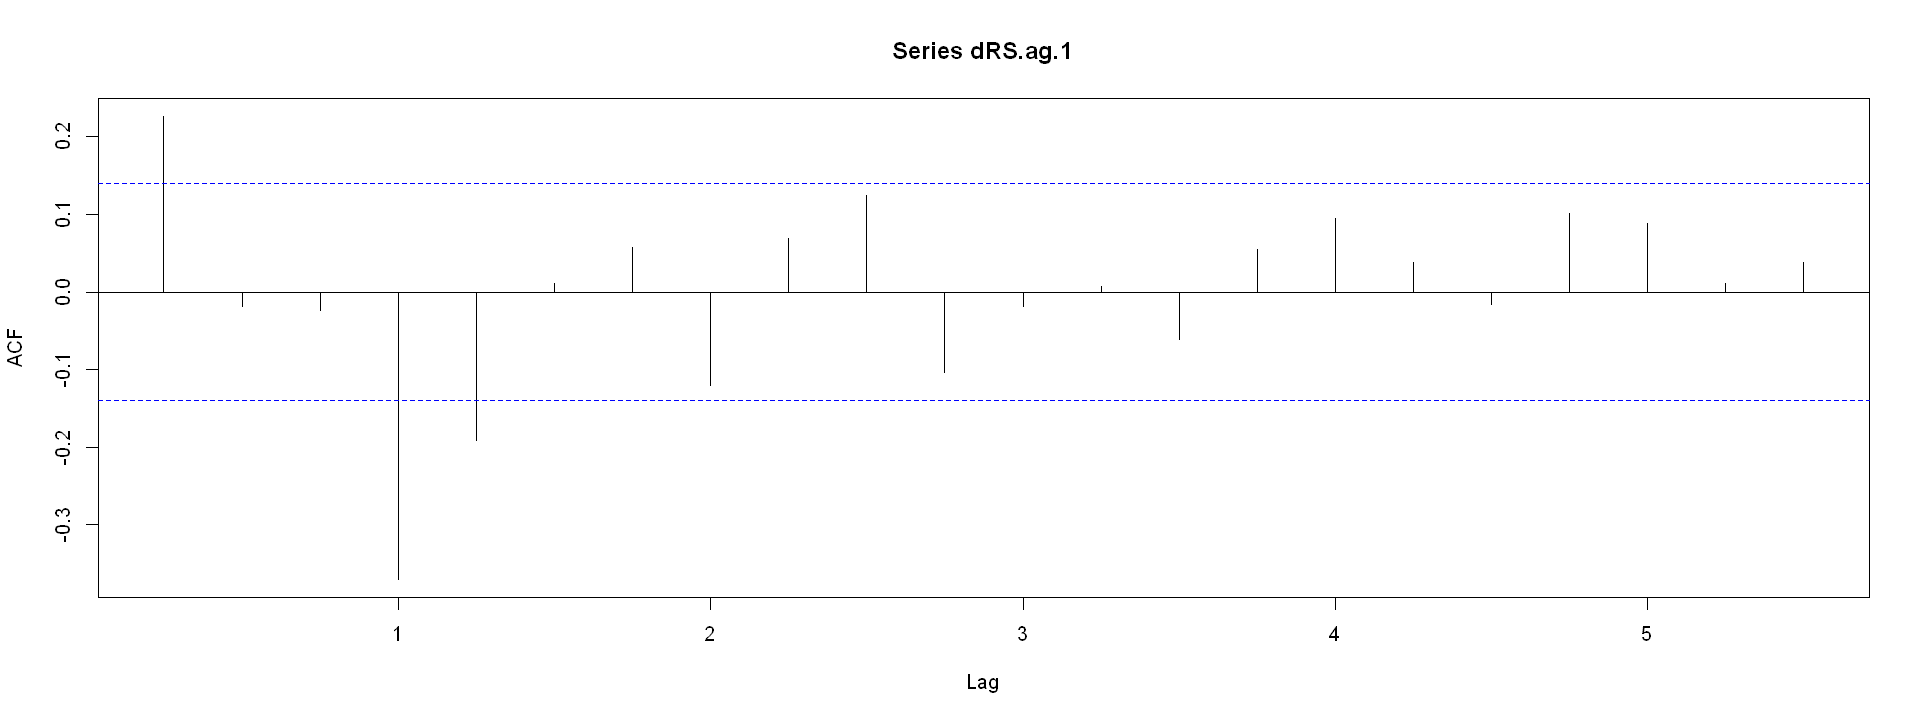

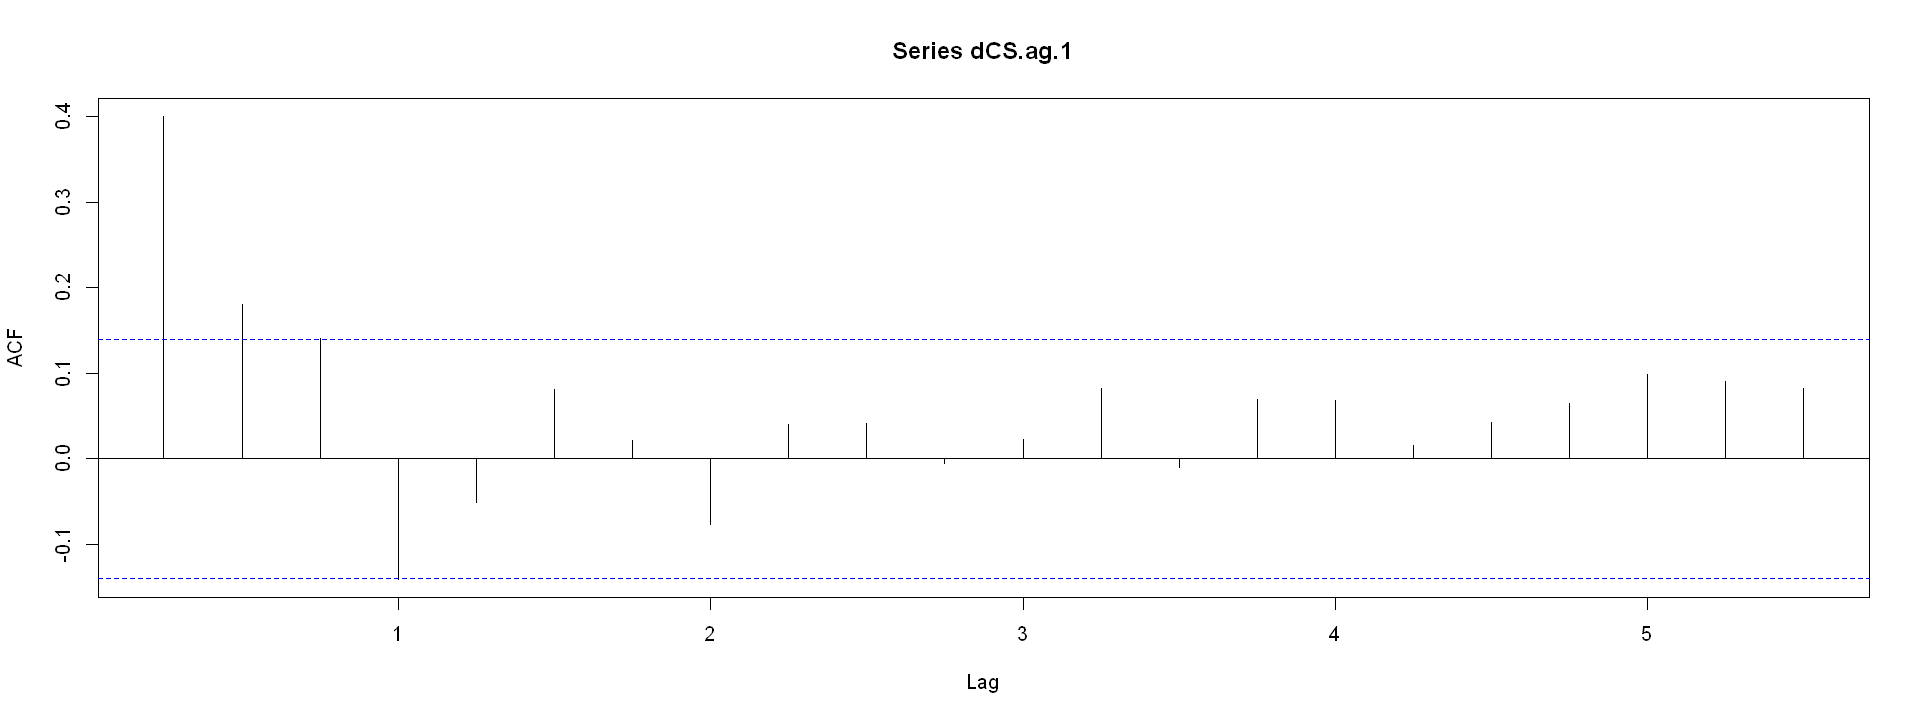

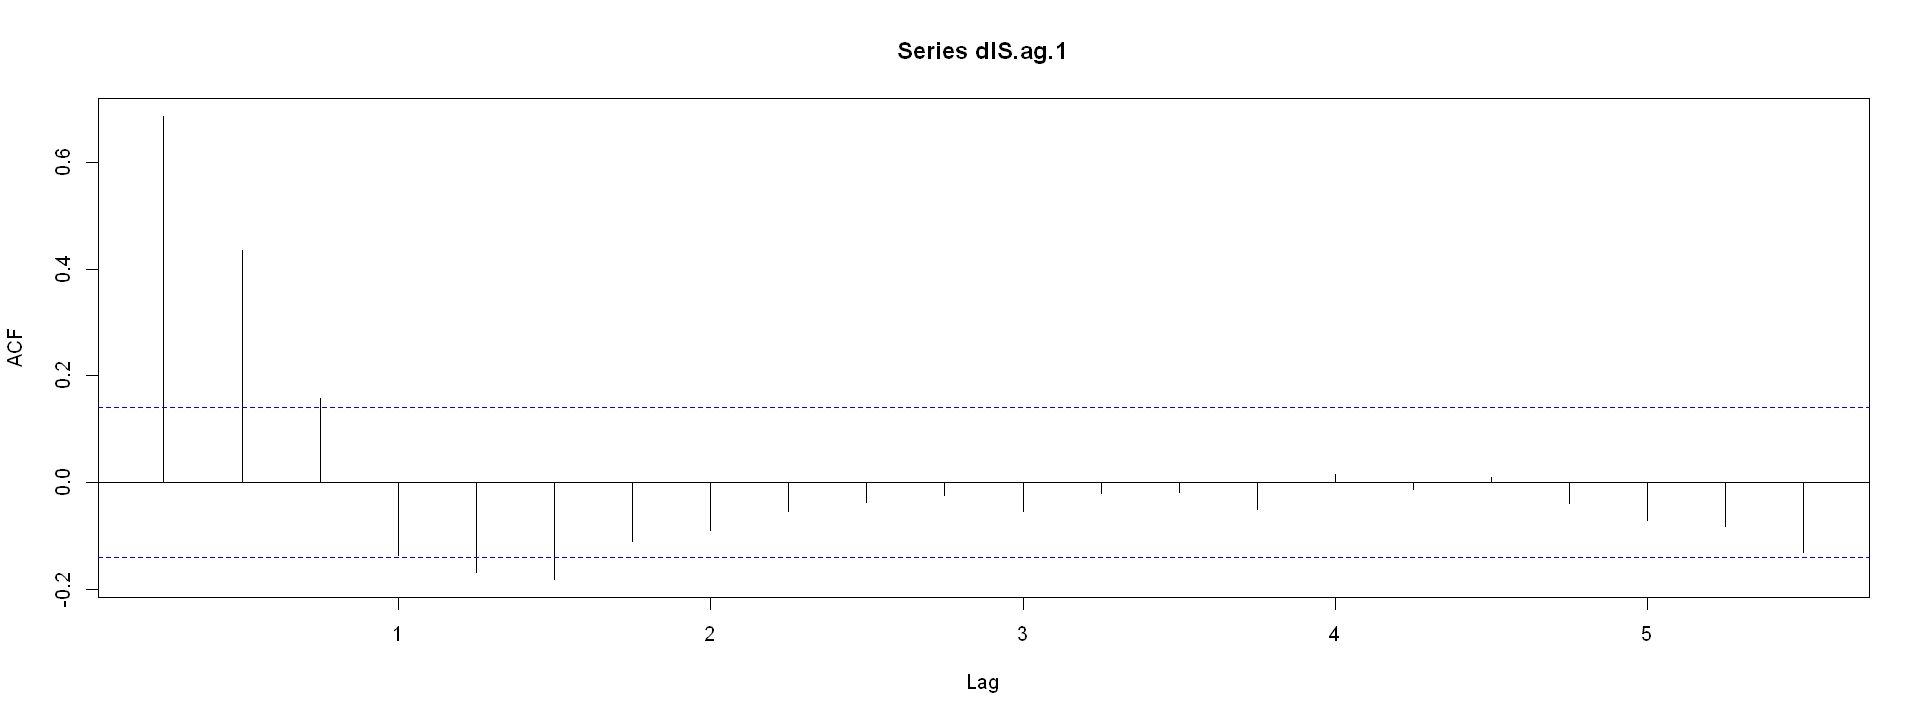

Warning message in adf.test(dRS.ag.1):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dRS.ag.1
Dickey-Fuller = -6.8713, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(dCS.ag.1):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dCS.ag.1
Dickey-Fuller = -5.0243, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(dIS.ag.1):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dIS.ag.1
Dickey-Fuller = -5.6162, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(dGP.ag.1):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  dGP.ag.1
Dickey-Fuller = -5.0875, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


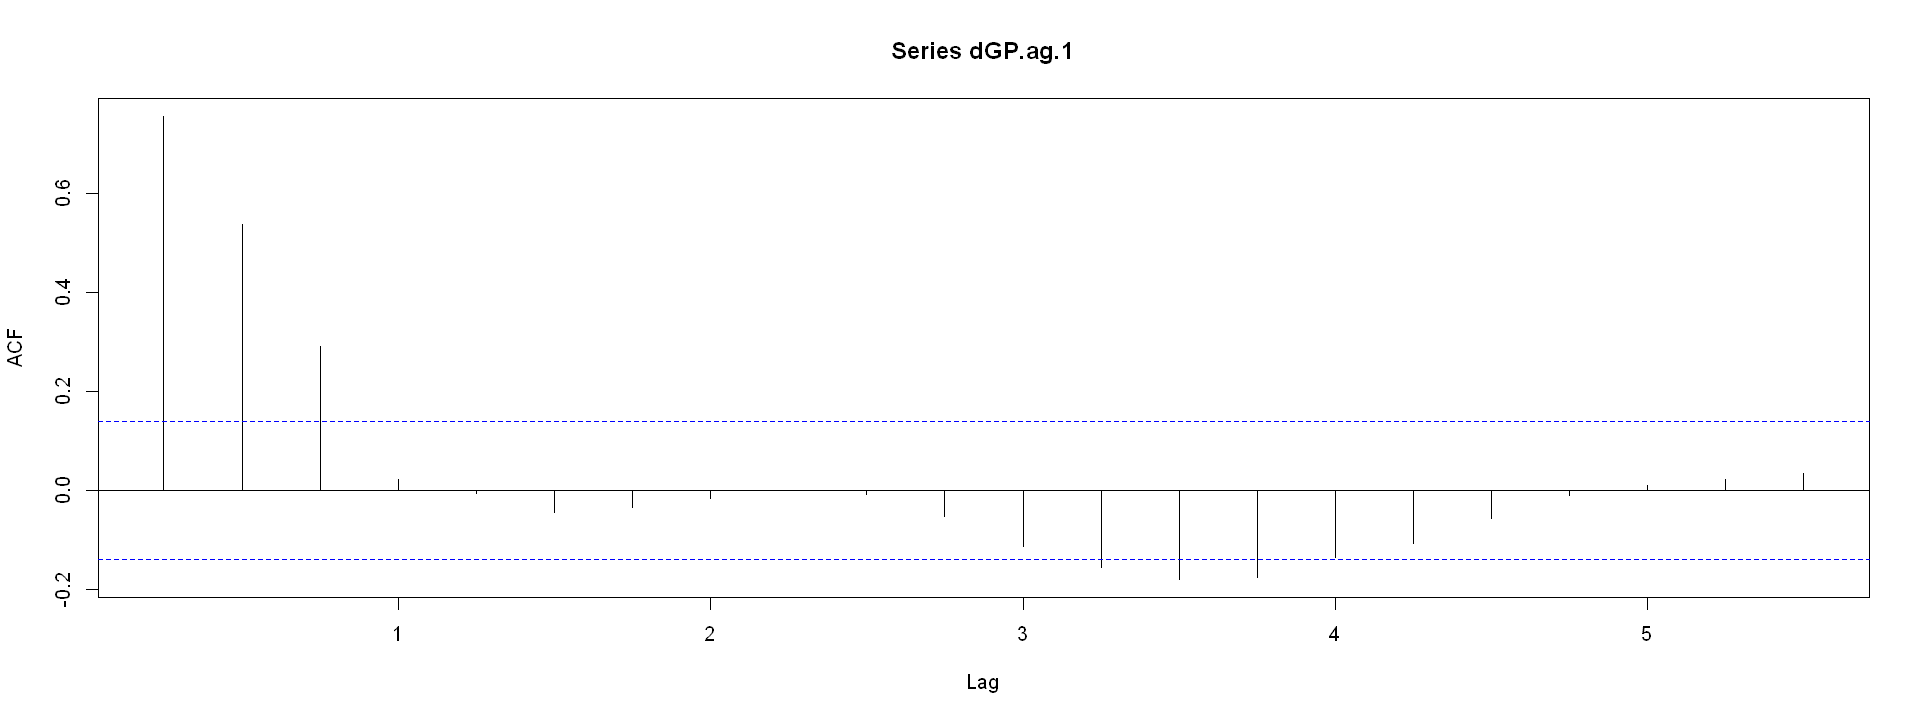

In [91]:
acf(dRS.ag.1)
acf(dCS.ag.1)
acf(dIS.ag.1)
acf(dGP.ag.1)

adf.test(dRS.ag.1)
adf.test(dCS.ag.1)
adf.test(dIS.ag.1)
adf.test(dGP.ag.1)


##### Comments

The ACF plots of the data after we performed differencing appear stationary, we used lag 4, given that the data is quarterly and seasonal. It appears that the differencing has taken care of the trend and the seasonality present in the data.

#### Plot differenced Time Series



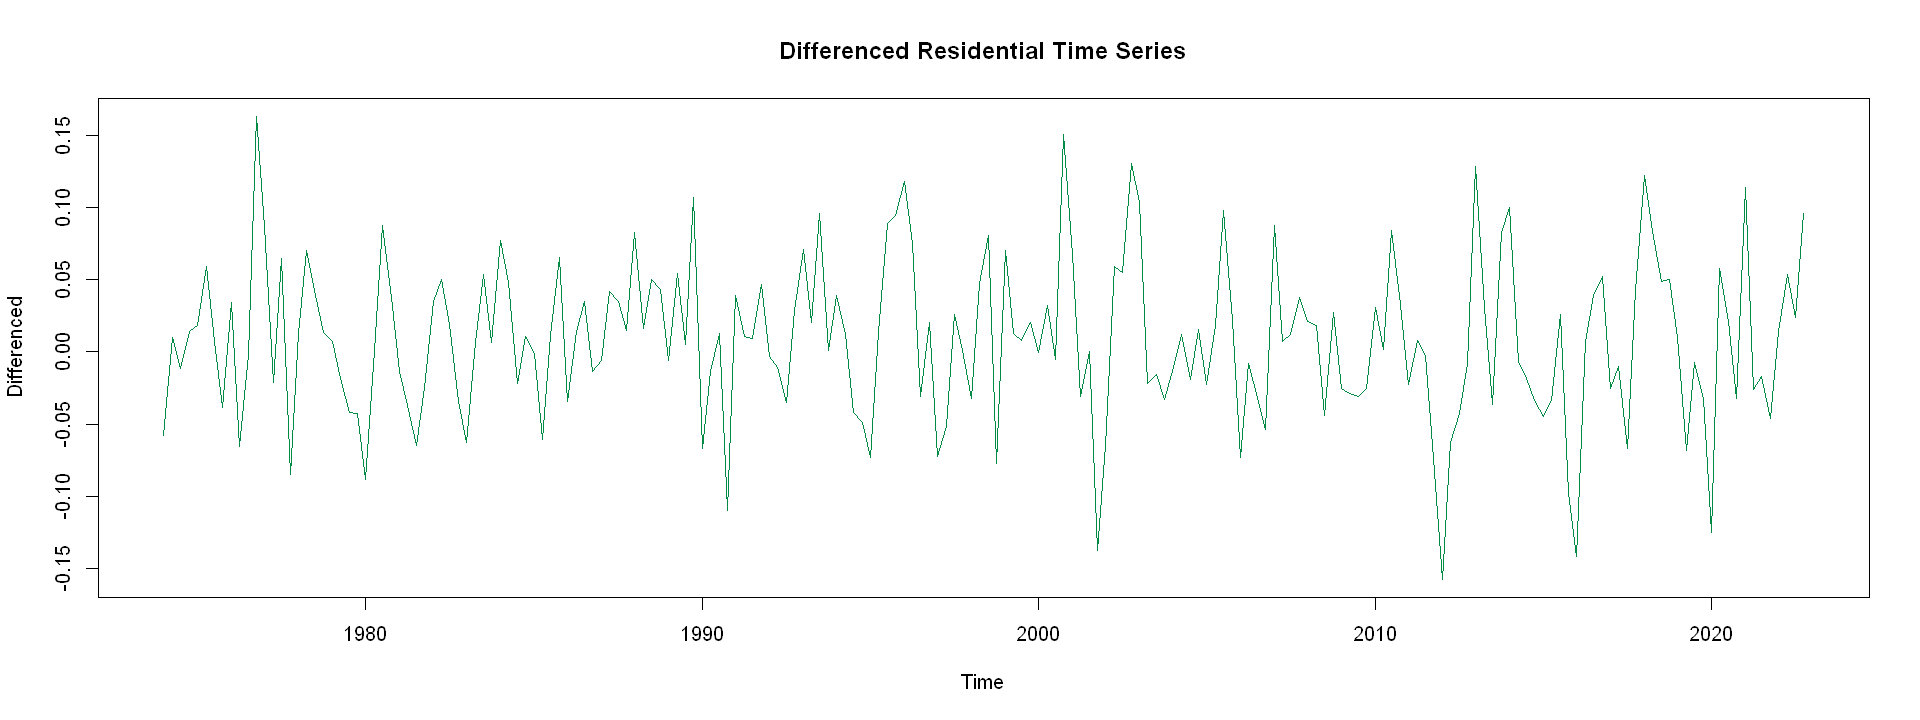

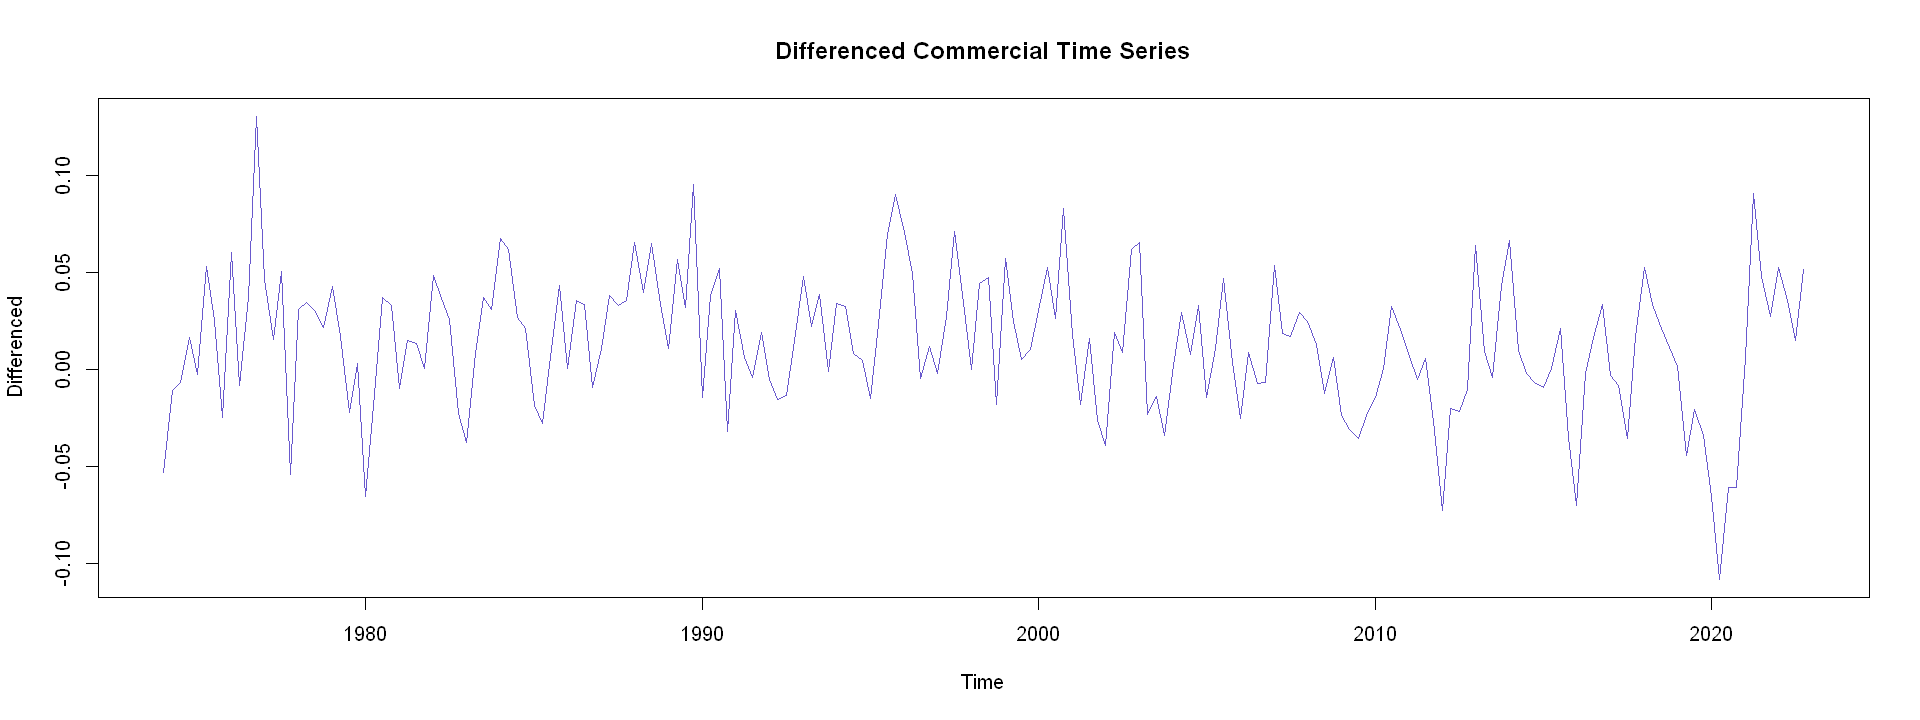

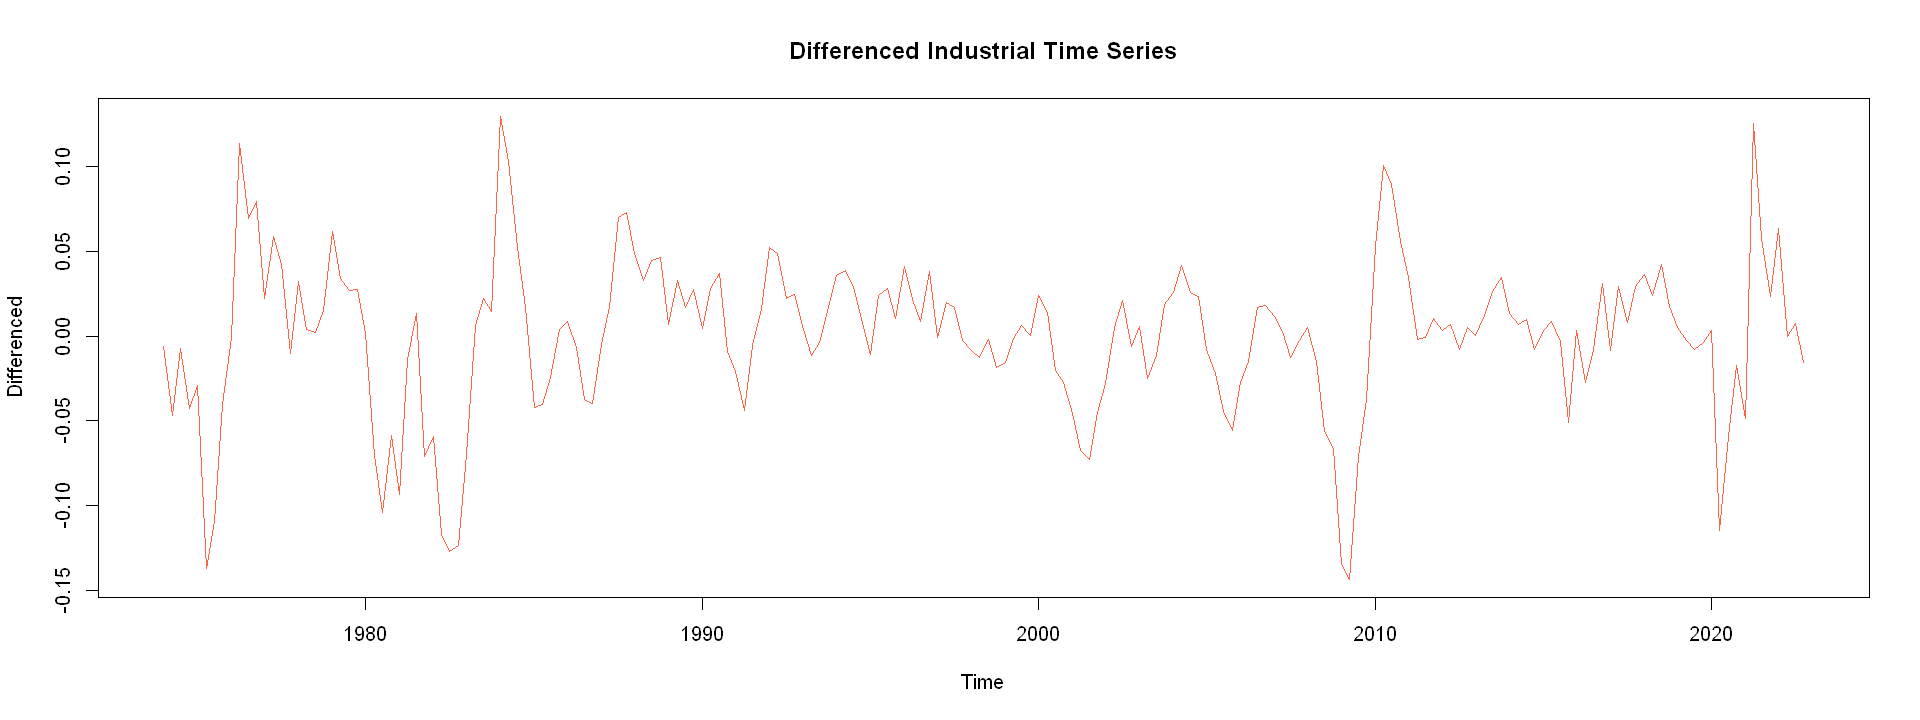

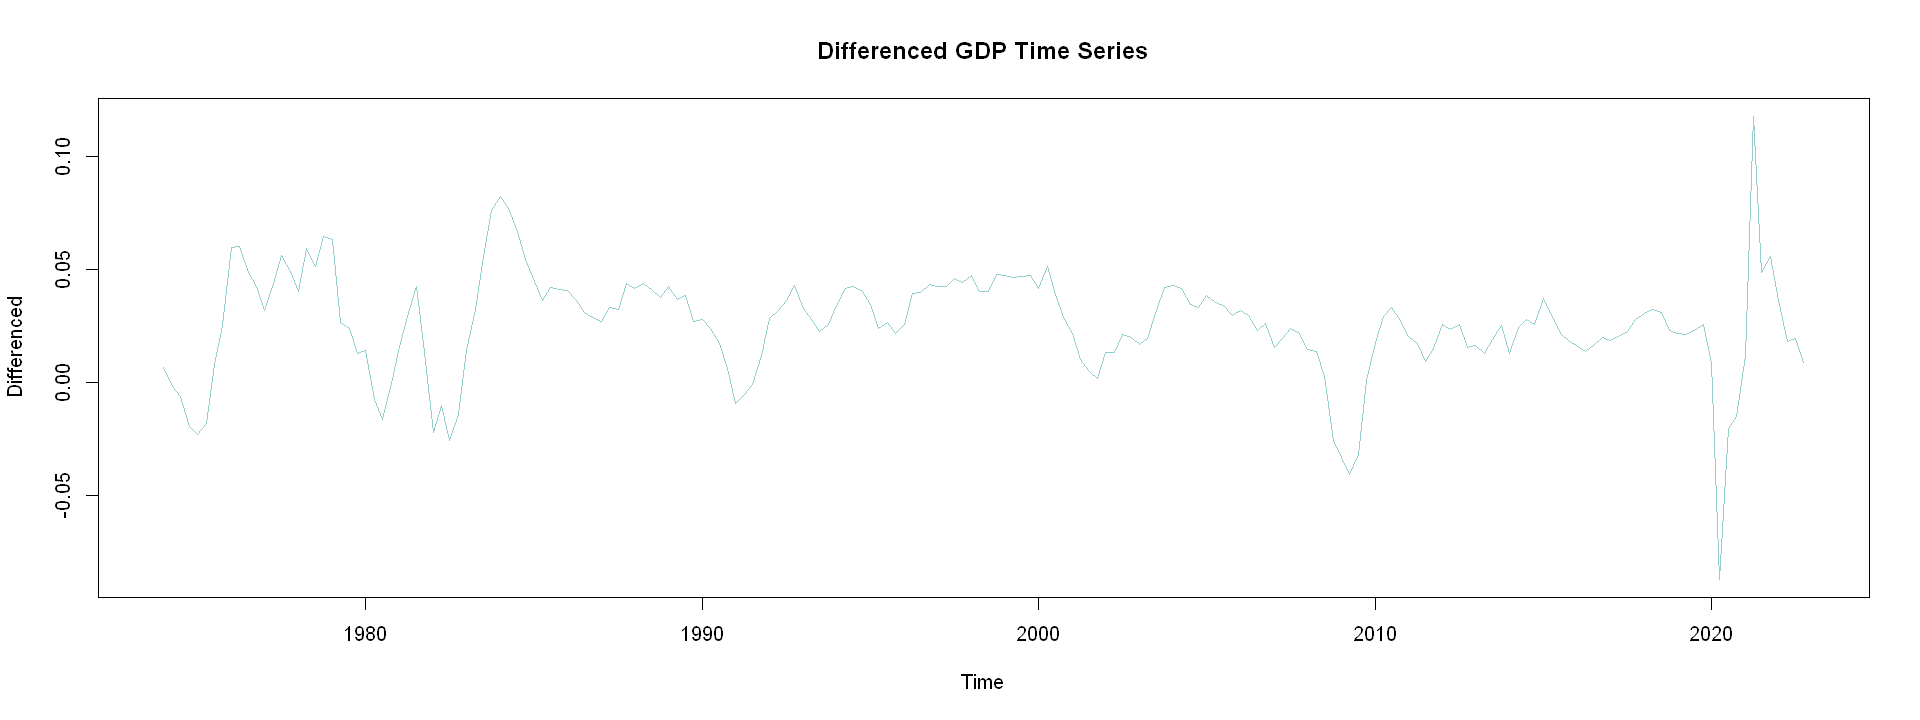

In [92]:
plot(dRS.ag.1,col= col1,ylab = "Differenced", main='Differenced Residential Time Series')
plot(dCS.ag.1,col= col2,ylab = "Differenced", main='Differenced Commercial Time Series')
plot(dIS.ag.1,col= col3,ylab = "Differenced", main='Differenced Industrial Time Series')
plot(dGP.ag.1,col= col4,ylab = "Differenced", main='Differenced GDP Time Series')


##### Comment

The differenced plots show that the trend and seasonality are somewhat removed and stationarity achieved. We continue with our analysis by applying a VAR model.

#### Find VAR Order

##### Split data



In [93]:
dn = length(dRS.ag.1)
dn_forward=4
dn_fit=dn-dn_forward

dRS.train.ts=ts(dRS.ag.1[1:dn_forward],start=1974,frequency=4)

dRS.ag.tr1=ts(dRS.ag.1[1:(dn-4)],start=1974,frequency=4)
dCS.ag.tr1=ts(dCS.ag.1[1:(dn-4)],start=1974,frequency=4)
dIS.ag.tr1=ts(dIS.ag.1[1:(dn-4)],start=1974,frequency=4)
dGP.ag.tr1=ts(dGP.ag.1[1:(dn-4)],start=1974,frequency=4)

dAll.ag.tr1 <- ts.union(dRS.ag.tr1, dCS.ag.tr1,dIS.ag.tr1, dGP.ag.tr1)

dRS.ag.test1 <- dRS.ag.1[(dn-3):dn]
dCS.ag.test1 <- dCS.ag.1[(dn-3):dn]
dIS.ag.test1 <- dIS.ag.1[(dn-3):dn]
dGP.ag.test1 <- dGP.ag.1[(dn-3):dn]


In [94]:
VARselect(dAll.ag.tr1, lag.max=10)

,1,2,3,4,5,6,7,8,9,10
AIC(n),-2.998908e+01,-2.996715e+01,-2.993511e+01,-3.019331e+01,-3.033711e+01,-3.028501e+01,-3.019722e+01,-3.033087e+01,-3.033651e+01,-3.035560e+01
HQ(n),-2.984635e+01,-2.971024e+01,-2.956401e+01,-2.970802e+01,-2.973764e+01,-2.957135e+01,-2.936937e+01,-2.938884e+01,-2.928029e+01,-2.918520e+01
SC(n),-2.963699e+01,-2.933339e+01,-2.901968e+01,-2.899621e+01,-2.885834e+01,-2.852457e+01,-2.815510e+01,-2.800708e+01,-2.773105e+01,-2.746847e+01
FPE(n),9.460898e-14,9.673219e-14,9.994687e-14,7.729672e-14,6.707396e-14,7.086348e-14,7.767358e-14,6.831470e-14,6.839151e-14,6.766919e-14



##### Comment

The selected order using BIC is 1.

#### Fit VAR model order 1



In [381]:
var.all = VAR(dAll.ag.tr1, p=1, ic="SC")
summary (var.all)


VAR Estimation Results:
Endogenous variables: dRS.ag.tr1, dCS.ag.tr1, dIS.ag.tr1, dGP.ag.tr1 
Deterministic variables: const 
Sample size: 191 
Log Likelihood: 1775.988 
Roots of the characteristic polynomial:
0.7504 0.5817 0.4562 0.2395
Call:
VAR(y = dAll.ag.tr1, p = 1, ic = "SC")


Estimation results for equation dRS.ag.tr1: 
dRS.ag.tr1 = dRS.ag.tr1.l1 + dCS.ag.tr1.l1 + dIS.ag.tr1.l1 + dGP.ag.tr1.l1 + const 

               Estimate Std. Error t value Pr(>|t|)  
dRS.ag.tr1.l1  0.282915   0.122191   2.315   0.0217 *
dCS.ag.tr1.l1 -0.156245   0.210201  -0.743   0.4582  
dIS.ag.tr1.l1  0.215849   0.119795   1.802   0.0732 .
dGP.ag.tr1.l1 -0.091864   0.262866  -0.349   0.7271  
const          0.009790   0.007297   1.342   0.1814  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.05379 on 186 degrees of freedom
Multiple R-Squared: 0.07294,	Adjusted R-squared: 0.053 
F-statistic: 3.658 on 4 and 186 DF,  p-value: 0.006797 


Estimation results


#### Comment

The Dickey-Fuller tests at the bottom confirm that all the differenced series (dRS.ag.tr1, dCS.ag.tr1, dIS.ag.tr1, dGP.ag.tr1) are stationary, which is a requirement for VAR models. The Roots of the characteristic polynomial are all below zero, this means that the VAR model is stable.Each equation regresses the differenced variable on its own lagged value as well as the lagged values of the other three variables.

The p value of the Industrial consumption coefficient is significant in the equation for Residential consumption.The p value of the GDP coefficient is significant in the equation for Commercial consumption. The p values of all coefficients are significant in the Industrial equation, and the p values of Residntial and Commercial are significant in the GDP equation.



In [324]:
library(urca)
arch.test (var.all)
serial.test(var.all)
normality.test(var.all)


	ARCH (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 779.04, df = 500, p-value = 1.588e-14

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 779.04, df = 500, p-value = 1.588e-14




	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var.all
Chi-squared = 329.67, df = 240, p-value = 0.0001072

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var.all
Chi-squared = 329.67, df = 240, p-value = 0.0001072



$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 2011.4, df = 8, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 8.2281, df = 4, p-value = 0.08357


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 2003.1, df = 4, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 2011.4, df = 8, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 8.2281, df = 4, p-value = 0.08357


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var.all
Chi-squared = 2003.1, df = 4, p-value < 2.2e-16





#### Comments

The analysis of the residuals suggest the presence of heteroskedasticity meaning that the variance of the residuals isn't constant across time. The small p value of the Portmanteau Test indicates autocorrelation in the residuals and the JB-test indicates departure from normality.

#### Granger Causality: Wald Test



In [97]:
# Granger Causality Tests
## Estimated coefficients and their variance for Residential Consumption
coef1.dRS = coefficients(var.all)$dRS.ag.tr1[-(4*1+1),1]
var1.dRS = vcov(var.all)[c(2:(4*1+1)),c(2:(4*1+1))]

# dRS-dCS
wald.test(b=coef1.dRS, var1.dRS, Terms = c(2))

# dRS-dIS
wald.test(b=coef1.dRS, var1.dRS, Terms = c(3))

# dRS-dGP
wald.test(b=coef1.dRS, var1.dRS, Terms = c(4))


Wald test:
----------

Chi-squared test:
X2 = 0.55, df = 1, P(> X2) = 0.46

Wald test:
----------

Chi-squared test:
X2 = 3.2, df = 1, P(> X2) = 0.072

Wald test:
----------

Chi-squared test:
X2 = 0.12, df = 1, P(> X2) = 0.73

In [475]:
## Estimated coefficients and their variance for Commercial Consumption
coef1.dCS = coefficients(var.all)$dCS.ag.tr1[-(4*1+1),1]
var1.dCS = vcov(var.all)[c(7:(10)),c(7:(10))]
 
# dCS-dRS
wald.test(b=coef1.dCS, var1.dCS, Terms = c(1))
 
# dCS-dIS
wald.test(b=coef1.dCS, var1.dCS, Terms = c(3))
 
# dCS-dGP
wald.test(b=coef1.dCS, var1.dCS, Terms = c(4))

Wald test:
----------

Chi-squared test:
X2 = 0.03, df = 1, P(> X2) = 0.86

Wald test:
----------

Chi-squared test:
X2 = 0.22, df = 1, P(> X2) = 0.64

Wald test:
----------

Chi-squared test:
X2 = 4.4, df = 1, P(> X2) = 0.036

In [476]:
## Estimated coefficients and their variance for Industrial Consumption
coef1.dIS = coefficients(var.all)$dIS.ag.tr1[-(4*1+1),1]
var1.dIS = vcov(var.all)[c(12:(15)),c(12:(15))]
 
# dIS-dRS
wald.test(b=coef1.dIS, var1.dIS, Terms = c(1))
 
# dIS-dCS
wald.test(b=coef1.dIS, var1.dIS, Terms = c(2))
 
# dIS-dGP
wald.test(b=coef1.dIS, var1.dIS, Terms = c(4))

Wald test:
----------

Chi-squared test:
X2 = 12.1, df = 1, P(> X2) = 0.00051

Wald test:
----------

Chi-squared test:
X2 = 13.5, df = 1, P(> X2) = 0.00024

Wald test:
----------

Chi-squared test:
X2 = 19.7, df = 1, P(> X2) = 9e-06


Since we are interested in evaluating the relationship of GDP with Energy Consumption, we applied Wald-test to evaluate whether GDP has a Granger-Causality with any of the energy consumption sectors. It appears that GDP has Granger-Cause relationship with the Industrial Sector but not with the other sectors. Also, Residential and Commercial Consumption, Granger-Cause Industrial Consumption.

#### Predictions



In [100]:
#predicting last 4 quarters using VAR model
pred1 = predict(var.all,n.ahead=dn_forward) 

pred1_RS = pred1$fcst$dRS.ag.tr1[1:4]
pred1_CS = pred1$fcst$dCS.ag.tr1[1:4]
pred1_IS = pred1$fcst$dIS.ag.tr1[1:4]
pred1_GP = pred1$fcst$dGP.ag.tr1[1:4]

In [101]:
finalpreds<-function(fcst,ts){
  var.pred<-rep(0,4)
  var.pred[1]<-ts[length(ts)]+fcst[1]
  for (i in 2:4){
    var.pred[i]<-var.pred[i-1]+fcst[i]
  }
  return(var.pred)
}

In [102]:
# Extract predictions for each time series
dRS.var.pred<-pred1$fcst$dRS.ag.tr1[,1]
dCS.var.pred<-pred1$fcst$dCS.ag.tr1[,1]
dIS.var.pred<-pred1$fcst$dIS.ag.tr1[,1]
dGP.var.pred<-pred1$fcst$dGP.ag.tr1[,1]

# Add diff time series to original training data
RS.var.pred<-finalpreds(dRS.var.pred, RS.ag.tr1)
CS.var.pred<-finalpreds(dRS.var.pred, CS.ag.tr1)
IS.var.pred<-finalpreds(dRS.var.pred, IS.ag.tr1)
GP.var.pred<-finalpreds(dGP.var.pred, GP.ag.tr1)

In [103]:
# 95% confidence interval
ubound_RS = pred1$fcst$dRS.ag.tr1[,3]
lbound_RS = pred1$fcst$dRS.ag.tr1[,2]

ubound_CS = pred1$fcst$dCS.ag.tr1[,3]
lbound_CS = pred1$fcst$dCS.ag.tr1[,2]

ubound_IS = pred1$fcst$dIS.ag.tr1[,3]
lbound_IS = pred1$fcst$dIS.ag.tr1[,2]

ubound_GP = pred1$fcst$dGP.ag.tr1[,3]
lbound_GP = pred1$fcst$dGP.ag.tr1[,2]

ymin1 = min(lbound_RS,lbound_CS,lbound_IS,lbound_GP)
ymax1 = max(ubound_RS,ubound_CS,ubound_IS,ubound_GP)

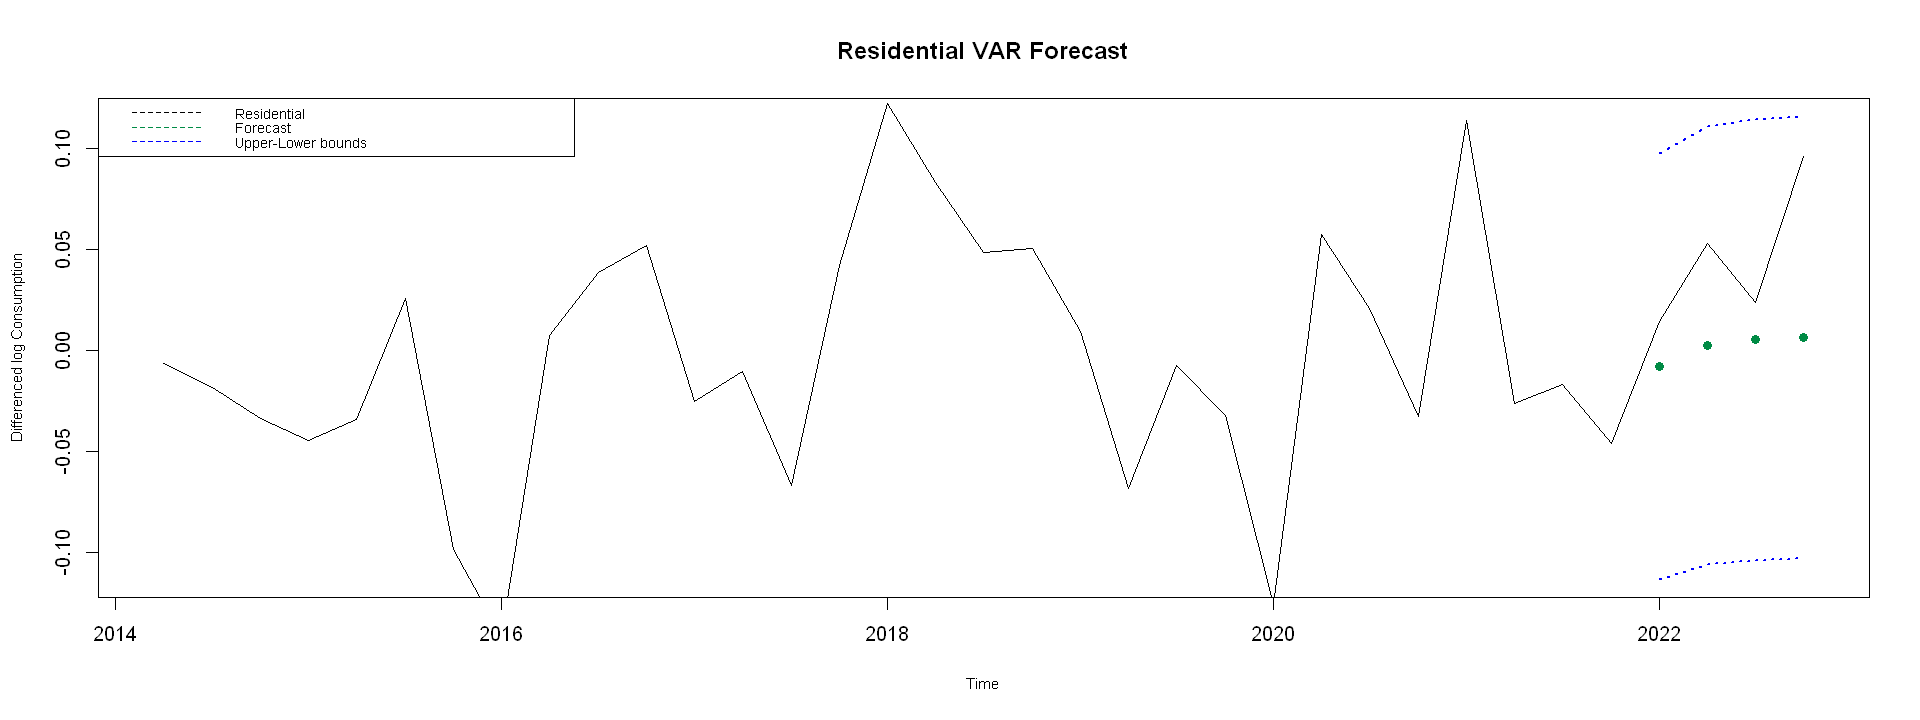

In [104]:

dates.diff = index(dAll.ag.1)
# Plot Resdiential Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dRS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(ymin1,ymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Residential VAR Forecast") 
points((dates.diff)[(dn_fit+1):dn],dRS.var.pred,col=col1,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_RS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_RS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Residential","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col1,"blue"))

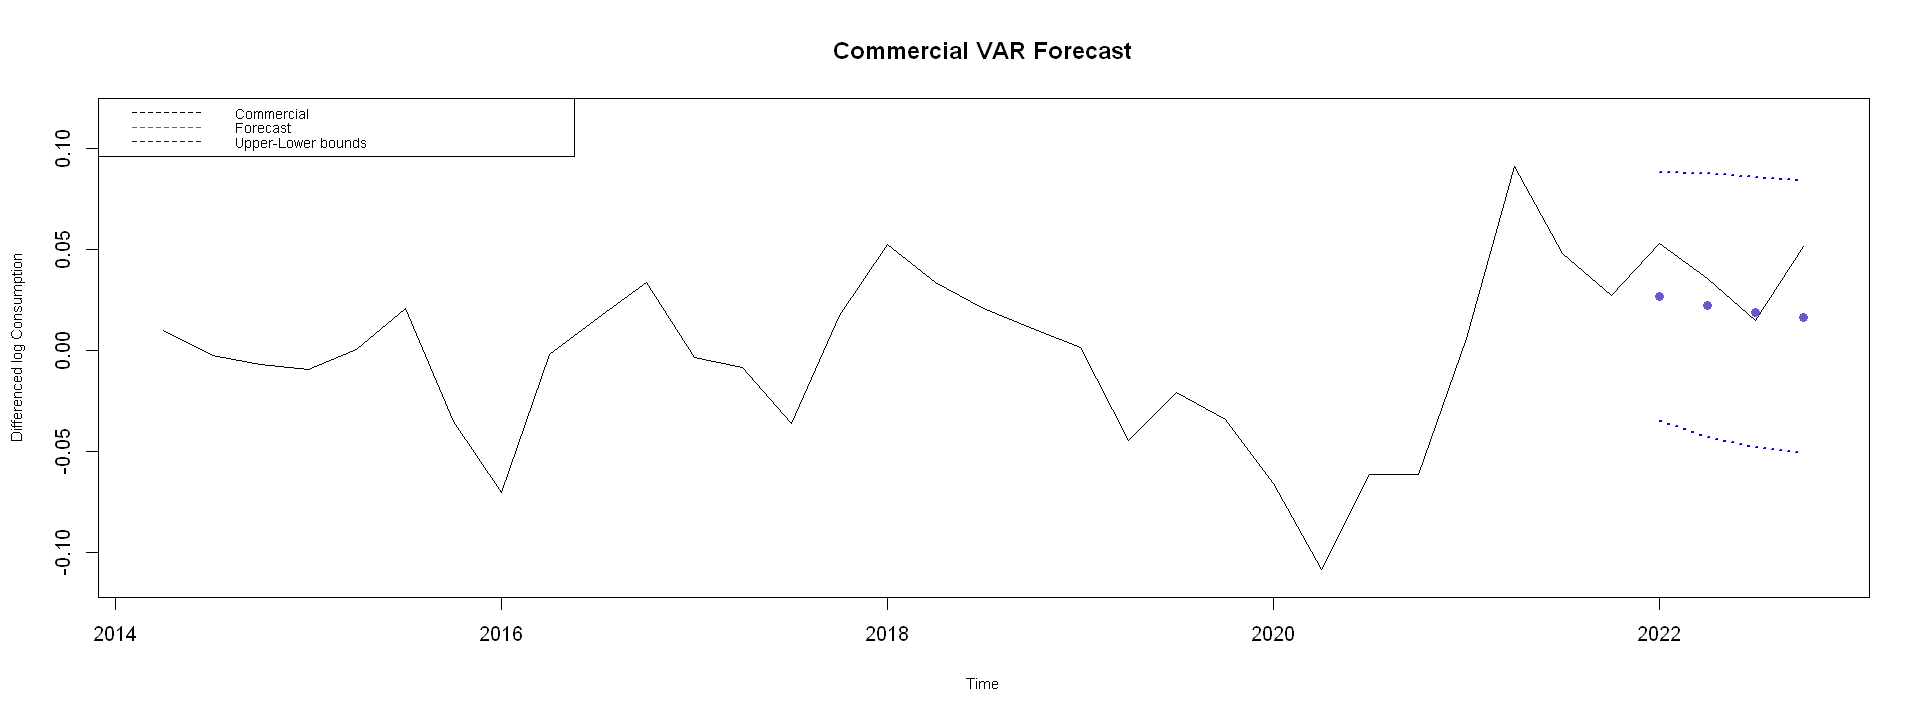

In [105]:
# Plot Commercial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dCS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(ymin1,ymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Commercial VAR Forecast") 
points((dates.diff)[(dn_fit+1):dn],dCS.var.pred,col=col2,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_CS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_CS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Commercial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70,col=c("black",col2,"blue"))



The Commercial Energy Consumption forecast appears to be relatively flat, with a slight increase over time. The actual Commercial Consumption is more volatile, with both increases and decreases over time. The upper-lower bounds line encompasses the commercial forecast line, and appears to follow a similar pattern with a larger range.



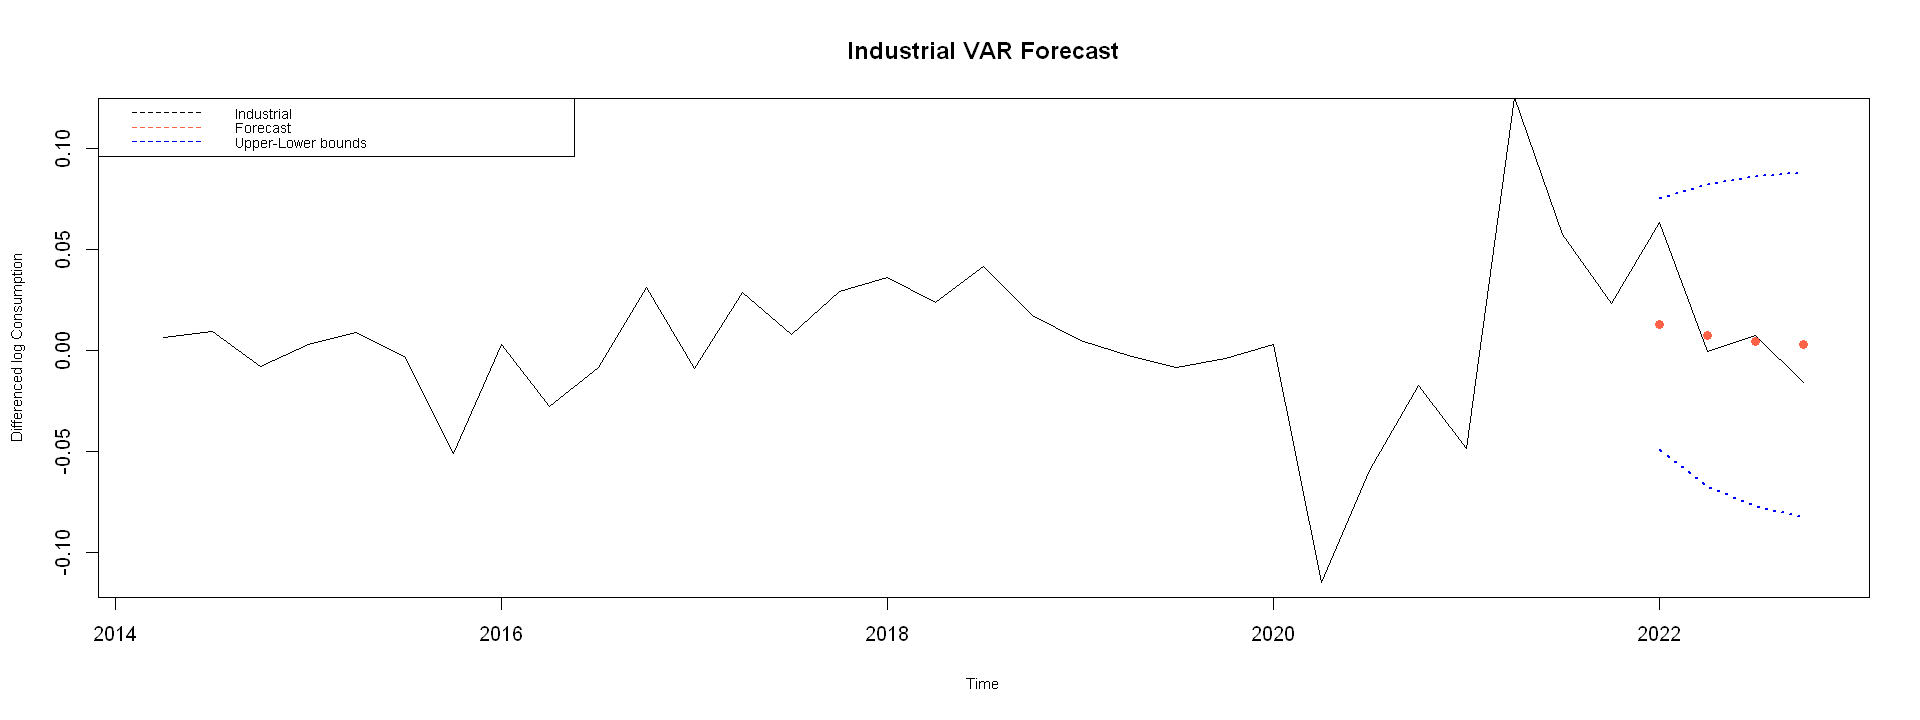

In [106]:
# Plot Industrial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dIS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(ymin1,ymax1), xlab="Time", ylab="Differenced log Consumption",cex.lab=0.75, main="Industrial VAR Forecast") 
points((dates.diff)[(dn_fit+1):dn],dIS.var.pred,col=col3,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_IS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_IS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Industrial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70,col=c("black",col3,"blue"))



#### Calculate Accuracy measures for Differenced VAR



In [107]:
cat("RS Diff VAR MAPE:", mean((abs(dRS.var.pred - dRS.ag.test1))/abs(dRS.ag.test1)),
", RS Diff VAR PM:", sum((dRS.var.pred - dRS.ag.test1) ^ 2)/sum((dRS.ag.test1 - mean(dRS.ag.test1)) ^ 2),

"\nCS Diff VAR MAPE:", mean((abs(dCS.var.pred - dCS.ag.test1))/abs(dCS.ag.test1)),
", CS Diff VAR PM:", sum((dCS.var.pred - dCS.ag.test1) ^ 2)/sum((dCS.ag.test1 - mean(dCS.ag.test1)) ^ 2),

"\nIS Diff VAR MAPE:", mean((abs(dIS.var.pred - dIS.ag.test1))/abs(dIS.ag.test1)),
", IS Diff VAR PM:", sum((dIS.var.pred - dIS.ag.test1) ^ 2)/sum((dIS.ag.test1 - mean(dIS.ag.test1)) ^ 2),

"\nGP Diff VAR MAPE:", mean((abs(dGP.var.pred - dGP.ag.test1))/abs(dGP.ag.test1)),
", GP Diff VAR PM:", sum((dGP.var.pred - dGP.ag.test1) ^ 2)/sum((dGP.ag.test1 - mean(dRS.ag.test1)) ^ 2))
  


RS Diff VAR MAPE: 1.044806 , RS Diff VAR PM: 2.831254 
CS Diff VAR MAPE: 0.4472563 , CS Diff VAR PM: 2.235279 
IS Diff VAR MAPE: 9.395316 , IS Diff VAR PM: 0.8241767 
GP Diff VAR MAPE: 1.003312 , GP Diff VAR PM: 0.2685201


#### Calculate Accuracy measures for VAR (Diff added back)



In [108]:

RS.ag.test1 <-  RS.ag.1[(n.ag-3):n.ag,]
CS.ag.test1 <-  CS.ag.1[(n.ag-3):n.ag,]
IS.ag.test1 <-  IS.ag.1[(n.ag-3):n.ag,]
GP.ag.test1 <-  GP.ag.1[(n.ag-3):n.ag,]

eRS.ag.test1 <-  exp(RS.ag.test1)
eCS.ag.test1 <-  exp(CS.ag.test1)
eIS.ag.test1 <-  exp(IS.ag.test1)
eGP.ag.test1 <-  exp(GP.ag.test1)

eRS.var.pred <-  exp(RS.var.pred)
eCS.var.pred <-  exp(CS.var.pred)
eIS.var.pred <-  exp(IS.var.pred)
eGP.var.pred <-  exp(GP.var.pred)

cat("RS VAR MAPE:", mean((abs(eRS.var.pred - eRS.ag.test1))/abs(eRS.ag.test1)),
", RS VAR PM:", sum((eRS.var.pred - eRS.ag.test1) ^ 2)/sum((eRS.ag.test1 - mean(eRS.ag.test1)) ^ 2),

"\nCS VAR MAPE:", mean((abs(eCS.var.pred - eCS.ag.test1))/abs(eCS.ag.test1)),
", CS VAR PM:", sum((eCS.var.pred - eCS.ag.test1) ^ 2)/sum((eCS.ag.test1 - mean(eCS.ag.test1)) ^ 2),

"\nIS VAR MAPE:", mean((abs(eIS.var.pred - eIS.ag.test1))/abs(eIS.ag.test1)),
", IS VAR PM:", sum((eIS.var.pred - eIS.ag.test1) ^ 2)/sum((eIS.ag.test1 - mean(eIS.ag.test1)) ^ 2),

"\nGP VAR MAPE:", mean((abs(eGP.var.pred - eGP.ag.test1))/abs(eGP.ag.test1)),
", GP VAR PM:", sum((eGP.var.pred - eGP.ag.test1) ^ 2)/sum((eGP.ag.test1 - mean(eGP.ag.test1)) ^ 2))

RS VAR MAPE: 0.1141844 , RS VAR PM: 1.378251 
CS VAR MAPE: 0.05274164 , CS VAR PM: 1.302552 
IS VAR MAPE: 0.01162392 , IS VAR PM: 1.845561 
GP VAR MAPE: 0.09407222 , GP VAR PM: 306.7494


### VARX Modelling

#### Set-up the data sets



In [109]:
deng.ag.tr1 <- ts.union(dRS.ag.tr1, dCS.ag.tr1, dIS.ag.tr1)


#### Model Selection



In [110]:
VARselect(deng.ag.tr1, lag.max = 10, season=4, exogen=data.frame(dGP.ag.tr1))$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     8      1      1      8


#### Model fitting



In [111]:
mod.varx=VAR(deng.ag.tr1, p=1, season=4, exogen=data.frame(dGP.ag.tr1))
summary(mod.varx)


VAR Estimation Results:
Endogenous variables: dRS.ag.tr1, dCS.ag.tr1, dIS.ag.tr1 
Deterministic variables: const 
Sample size: 191 
Log Likelihood: 1230.885 
Roots of the characteristic polynomial:
0.6161 0.2984 0.2391
Call:
VAR(y = deng.ag.tr1, p = 1, season = 4L, exogen = data.frame(dGP.ag.tr1))


Estimation results for equation dRS.ag.tr1: 
dRS.ag.tr1 = dRS.ag.tr1.l1 + dCS.ag.tr1.l1 + dIS.ag.tr1.l1 + const + sd1 + sd2 + sd3 + dGP.ag.tr1 

               Estimate Std. Error t value Pr(>|t|)   
dRS.ag.tr1.l1  0.298623   0.112209   2.661  0.00848 **
dCS.ag.tr1.l1 -0.158691   0.190183  -0.834  0.40514   
dIS.ag.tr1.l1  0.240470   0.103992   2.312  0.02187 * 
const          0.013300   0.006442   2.064  0.04039 * 
sd1            0.001547   0.011089   0.140  0.88918   
sd2            0.001476   0.011049   0.134  0.89385   
sd3            0.005845   0.011028   0.530  0.59673   
dGP.ag.tr1    -0.229889   0.197555  -1.164  0.24607   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0


This is output of the VARX model for Energy Consumption, which now includes a last row corresponding to GDP. The regression coefficient for GDP as an exogenous variable is not statistically significant except in relation to Commercial Consumption, given that we accounted for seasonality, trend and serial correlation in the Energy Consumption modeling.

Importantly, the estimated coefficients based on this model are less significant to those from the model where temp is an endogenous variable.

### Wald tests

In [491]:
# Population on Residential 
coefx1.dRS = coefficients(mod.varx)$dRS.ag.tr1[-4,1]
covx1.dRS = vcov(mod.varx)[c(2:8),c(2:8)]
wald.test(b=coefx1.dRS, covx1.dRS, Terms = c(7))

Wald test:
----------

Chi-squared test:
X2 = 1.4, df = 1, P(> X2) = 0.24

In [495]:
# Population on Residential 
coefx1.dCS = coefficients(mod.varx)$dCS.ag.tr1[-4,1]
covx1.dCS = vcov(mod.varx)[c(10:16),c(10:16)]
wald.test(b=coefx1.dCS, covx1.dCS, Terms = c(7))

Wald test:
----------

Chi-squared test:
X2 = 13.7, df = 1, P(> X2) = 0.00022

In [496]:
# Population on Residential 
coefx1.dIS = coefficients(mod.varx)$dIS.ag.tr1[-4,1]
covx1.dIS = vcov(mod.varx)[c(18:24),c(18:24)]
wald.test(b=coefx1.dIS, covx1.dIS, Terms = c(7))

Wald test:
----------

Chi-squared test:
X2 = 99.2, df = 1, P(> X2) = 0.0

### Predictions

In [112]:
# forecast VARX model
varx.forecast<-predict(mod.varx,n.ahead=4, season=4, ci = 0.95, dumvar =as.matrix(dGP.ag.test1))

In [113]:
finalpreds<-function(fcst,ts){
  var.pred<-rep(0,4)
  var.pred[1]<-ts[length(ts)]+fcst[1]
  for (i in 2:4){
    var.pred[i]<-var.pred[i-1]+fcst[i]
  }
  return(var.pred)
}

In [114]:
# Extract predictions for each time series
dRS.varx.pred<-varx.forecast$fcst$dRS.ag.tr1[,1]
dCS.varx.pred<-varx.forecast$fcst$dCS.ag.tr1[,1]
dIS.varx.pred<-varx.forecast$fcst$dIS.ag.tr1[,1]

# Add diff time series to original training data
RS.varx.pred<-finalpreds(dRS.varx.pred, RS.ag.tr1)
CS.varx.pred<-finalpreds(dRS.varx.pred,CS.ag.tr1)
IS.varx.pred<-finalpreds(dRS.varx.pred, IS.ag.tr1)

In [115]:
# 95% confidence interval
ubound_XRS = varx.forecast$fcst$dRS.ag.tr1[9:12]
lbound_XRS = varx.forecast$fcst$dRS.ag.tr1[5:8]

ubound_XCS = varx.forecast$fcst$dCS.ag.tr1[9:12]
lbound_XCS = varx.forecast$fcst$dCS.ag.tr1[5:8]

ubound_XIS = varx.forecast$fcst$dIS.ag.tr1[9:12]
lbound_XIS = varx.forecast$fcst$dIS.ag.tr1[5:8]

Xymin1 = min(lbound_XRS,lbound_XCS,lbound_XIS)
Xymax1 = max(ubound_XRS,ubound_XCS,ubound_XIS)


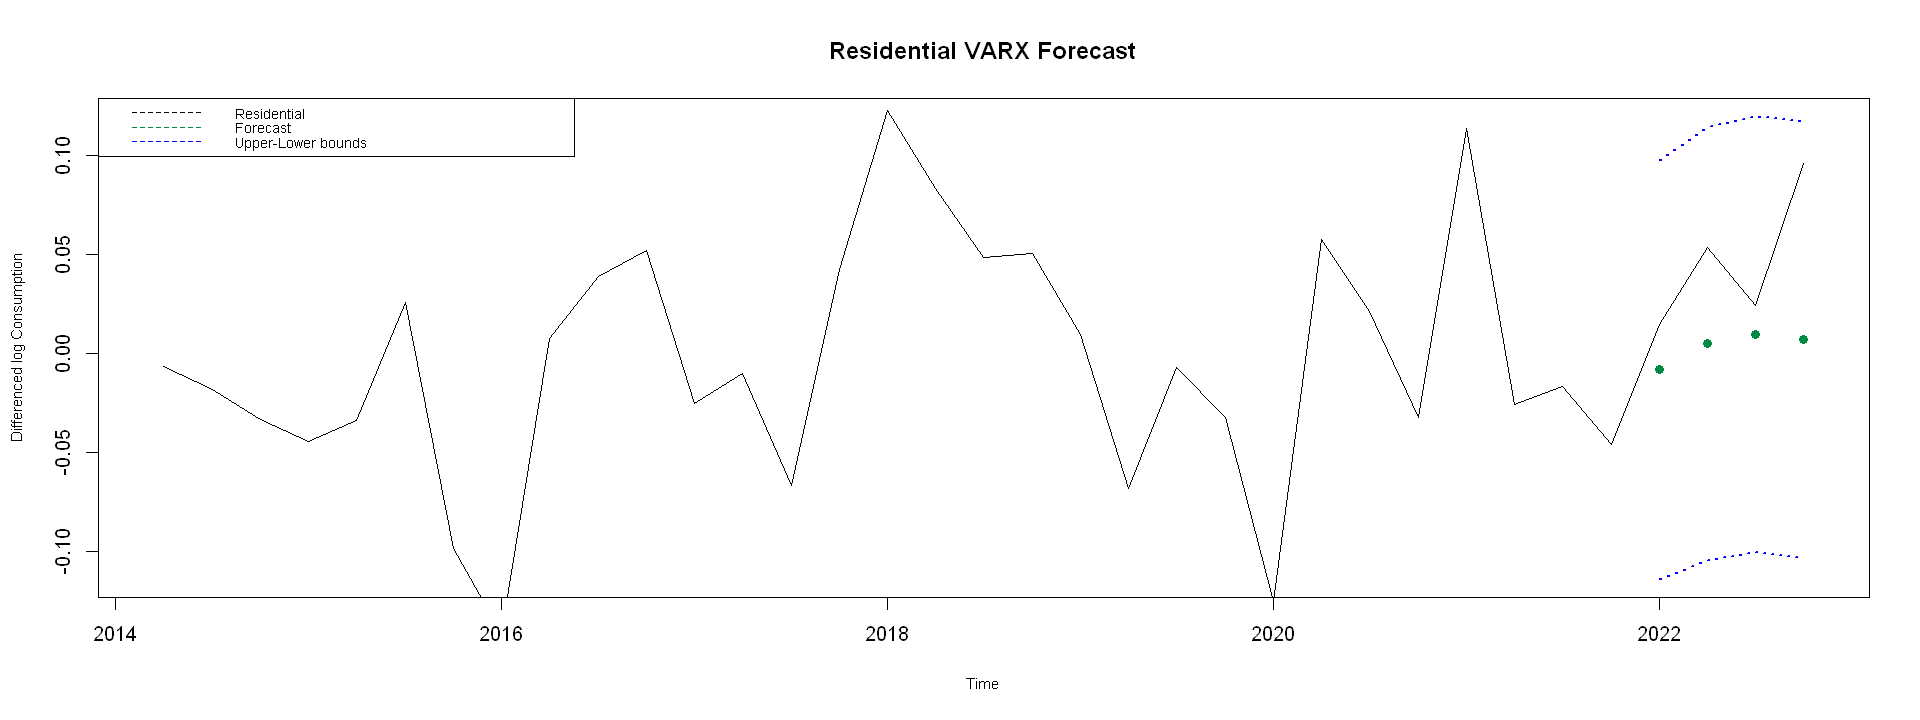

In [116]:
dates.diff = index(dAll.ag.1)
# Plot Resdiential Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dRS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Residential VARX Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dRS.varx.pred,col=col1,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XRS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XRS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Residential","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col1,"blue"))


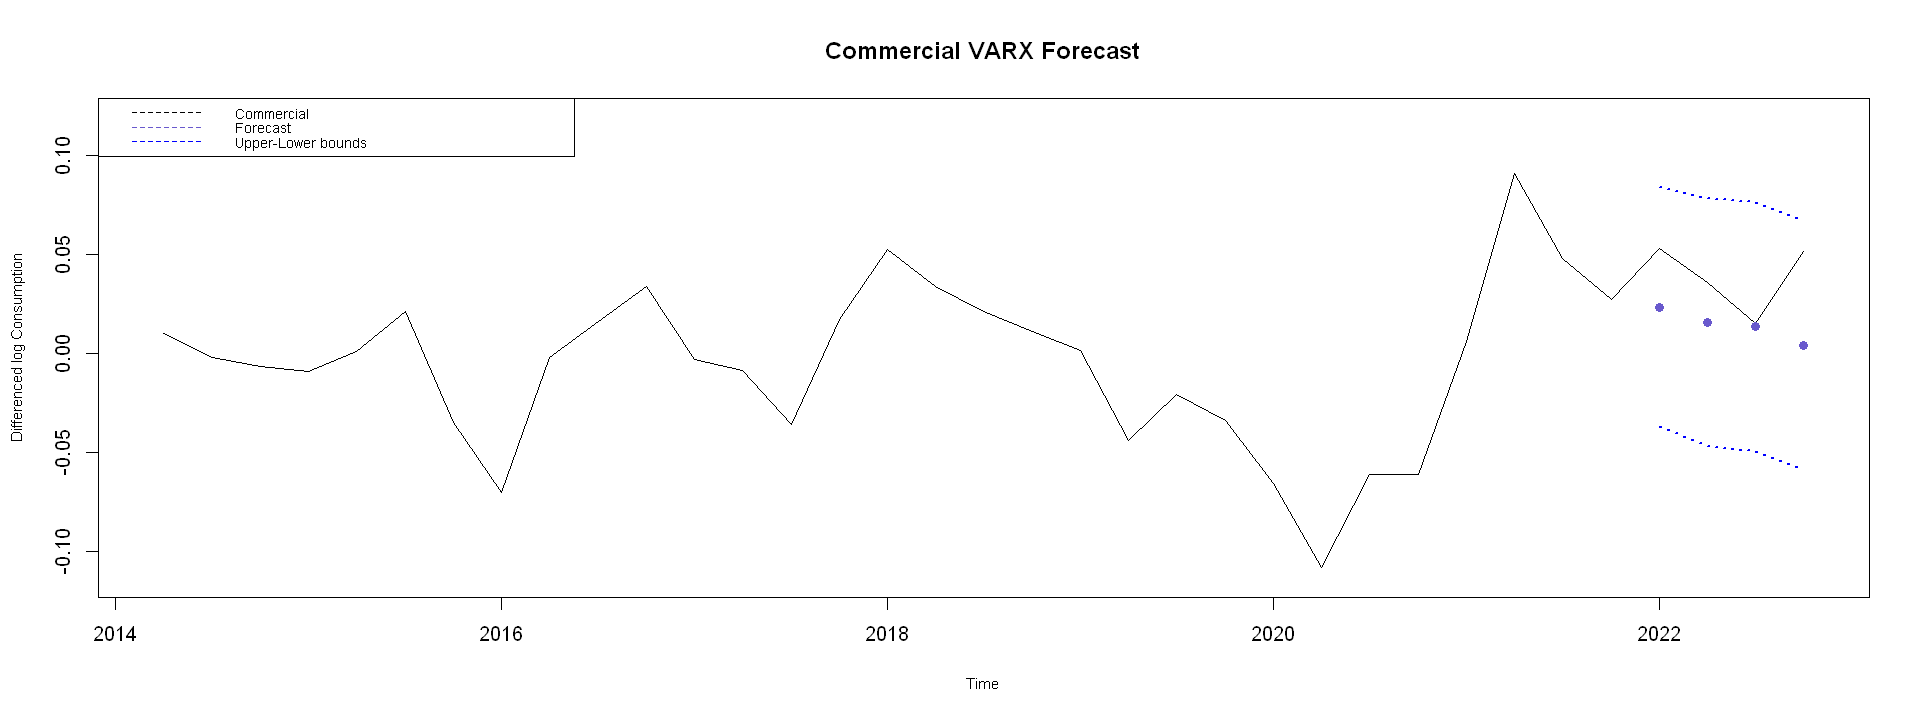

In [117]:
# Plot Commercial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dCS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Commercial VARX Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dCS.varx.pred,col=col2,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XCS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XCS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Commercial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col2,"blue"))


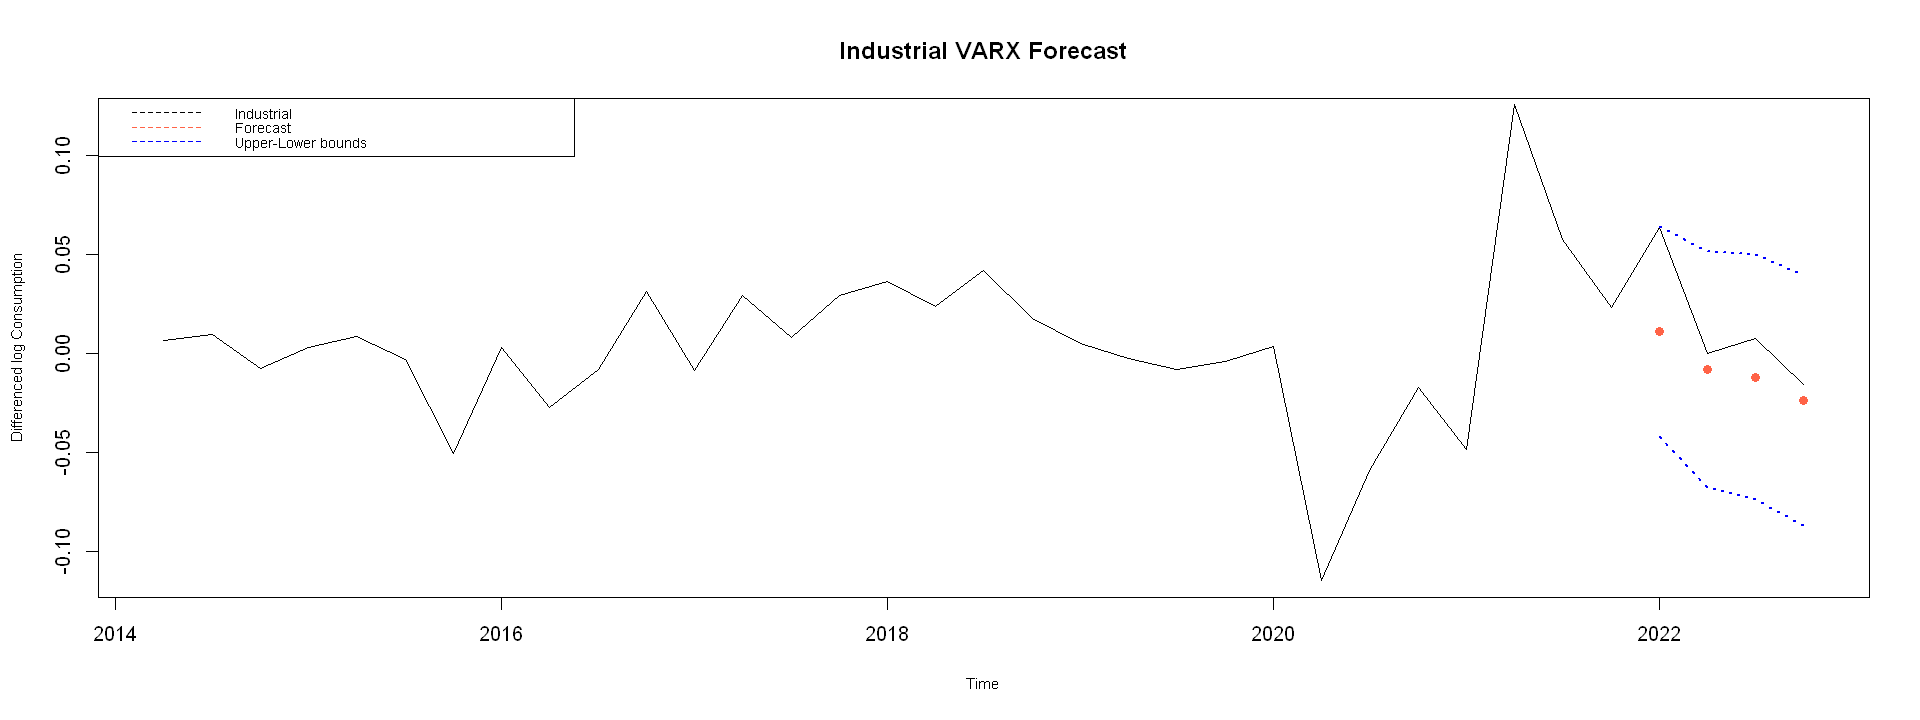

In [118]:
# Plot Industrial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dIS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Industrial VARX Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dIS.varx.pred,col=col3,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XIS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XIS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Industrial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col3,"blue"))



#### Calculate Accuracy Measures for Differenced VARX



In [119]:
cat("RS Diff VARX MAPE:", mean((abs(dRS.varx.pred - dRS.ag.test1))/abs(dRS.ag.test1)),
", RS Diff VARX PM:", sum((dRS.varx.pred - dRS.ag.test1) ^ 2)/sum((dRS.ag.test1 - mean(dRS.ag.test1)) ^ 2),

"\nCS Diff VARX MAPE:", mean((abs(dCS.varx.pred - dCS.ag.test1))/abs(dCS.ag.test1)),
", CS Diff VARX PM:", sum((dCS.varx.pred-dCS.ag.test1)^2)/sum((dCS.ag.test1-mean(dCS.ag.test1))^2),

"\nIS Diff VARX MAPE:", mean((abs(dIS.varx.pred - dIS.ag.test1))/abs(dIS.ag.test1)),
", IS Diff VARX PM:", sum((dIS.varx.pred - dIS.ag.test1) ^ 2)/sum((dIS.ag.test1 - mean(dIS.ag.test1)) ^ 2))

RS Diff VARX MAPE: 1.000066 , RS Diff VARX PM: 2.726393 
CS Diff VARX MAPE: 0.5368161 , CS Diff VARX PM: 3.776104 
IS Diff VARX MAPE: 10.00067 , IS Diff VARX PM: 0.9110181


##### Calculate Accuracy Measures for VARX



In [120]:
eRS.varx.pred <-  exp(RS.varx.pred)
eCS.varx.pred <-  exp(CS.varx.pred)
eIS.varx.pred <-  exp(IS.varx.pred)

cat("RS VARX MAPE:", mean((abs(eRS.varx.pred - eRS.ag.test1))/abs(eRS.ag.test1)),
", RS VARX PM:", sum((eRS.varx.pred - eRS.ag.test1) ^ 2)/sum((eRS.ag.test1 - mean(eRS.ag.test1)) ^ 2),

"\nCS VARX MAPE:", mean((abs(eCS.varx.pred - eCS.ag.test1))/abs(eCS.ag.test1)),
", CS VARX PM:", sum((eCS.varx.pred-eCS.ag.test1)^2)/sum((eCS.ag.test1-mean(eCS.ag.test1))^2),

"\nIS VARX MAPE:", mean((abs(eIS.varx.pred - eIS.ag.test1))/abs(eIS.ag.test1)),
", IS VARX PM:", sum((eIS.varx.pred - eIS.ag.test1) ^ 2)/sum((eIS.ag.test1 - mean(eIS.ag.test1)) ^ 2))

RS VARX MAPE: 0.1118832 , RS VARX PM: 1.373001 
CS VARX MAPE: 0.05333593 , CS VARX PM: 1.292668 
IS VARX MAPE: 0.01239428 , IS VARX PM: 2.691913

# Model energy consumption with Exogeneous factors

Although GDP has been considered as an exogeneous factor, there are other exogeneous factors like population and inflation should only impact energy consumption while the reverse relationship wouldn't hold - energy consumption impact population and inflation.

#### Read in exogenous datasets

In [287]:
# Population
population = read.csv("population-data.csv")
population = population[(12*15+1):(dim(population)[1]-12),]
head(population,1)
tail(population,1)

col5 = "purple"
population.ts = ts(population[,2],start=1974,frequency=12)
population.ag.ts = aggregate.ts(population.ts, nfrequency = 4, FUN="mean")

,DATE,POPTHM
,<chr>,<dbl>
181,1974-01-01,213003


,DATE,POPTHM
,<chr>,<dbl>
768,2022-12-01,334326


In [470]:
ymin = min(c(RS.ag.tr1 ,CS.ag.tr1 ,IS.ag.tr1 ,GP.ag.tr1, population.ag.ts/100000 + 5))
ymax = max(c(RS.ag.tr1 ,CS.ag.tr1 ,IS.ag.tr1 ,GP.ag.tr1, population.ag.ts/100000 + 5))
ylim = c(ymin, ymax)

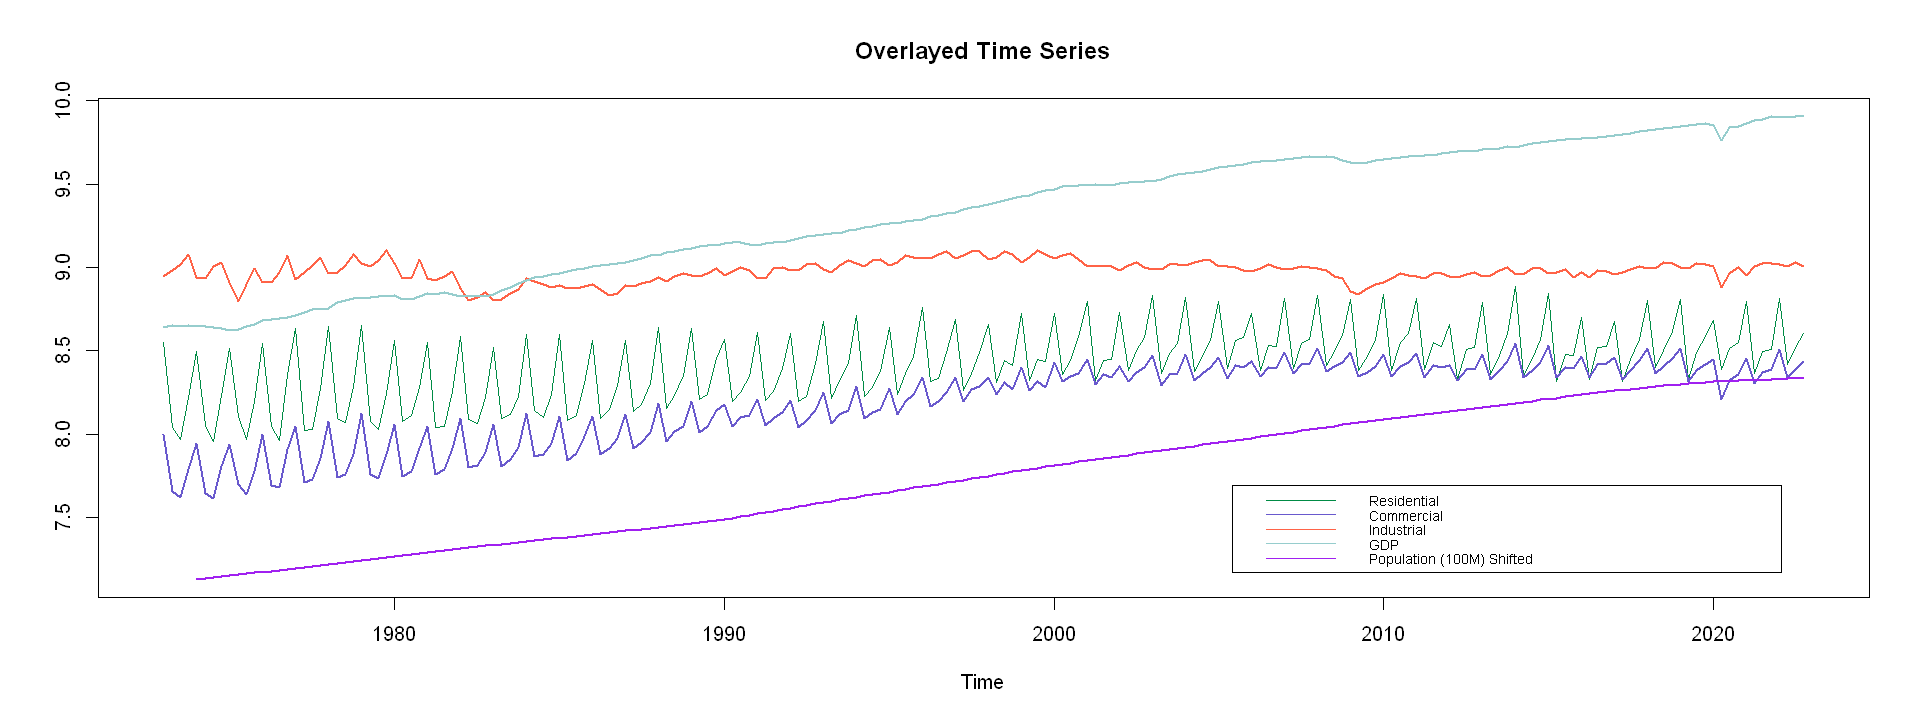

In [383]:
# plot the time series for all indicators
plot(RS.ag.1,col= col1, ylim=ylim, ylab = "", xlab="Time",main='Overlayed Time Series')
lines(CS.ag.1, lwd=2,col=col2)
lines(IS.ag.1, lwd=2,col=col3)
lines(GP.ag.1, lwd=2,col=col4)
lines(population.ag.ts/100000+5, lwd=2, col=col5)
legend(x="bottomright",inset=c(0.05, 0.05), cex=0.70,legend=c("Residential","Commercial","Industrial","GDP", "Population (100M) Shifted"),lty = 1, col=c(col1,col2,col3,col4,col5),  xpd=TRUE)

In [295]:
dn = length(population.ag.ts)
dn_forward=4
dn_fit=dn-dn_forward

population.ag.train.ts=ts(population.ag.ts[1:(dn-4)], start=1974,frequency=4)
population.ag.test.ts <- population.ag.ts[(dn-3):dn]

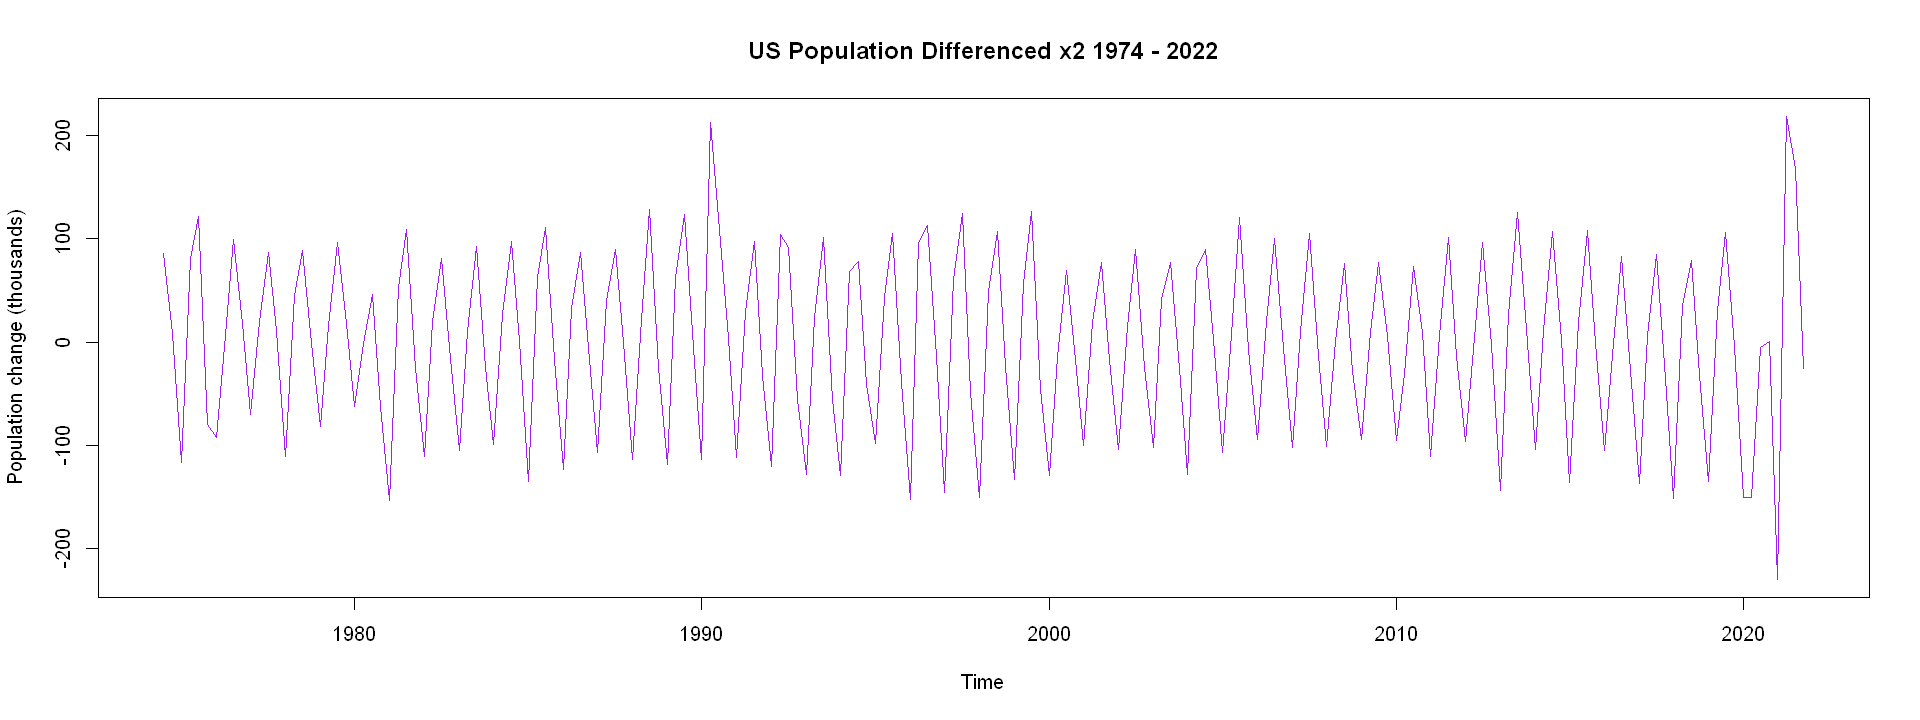

In [296]:
population.ag.train.diff.ts = diff(diff(population.ag.train.ts))
ts.plot(population.ag.train.diff.ts, main="US Population Differenced x2 1974 - 2022", ylab="Population change (thousands)", col=col5)

In [299]:
############### TREND and SEASONALITY ESTIMATION ###################
qtr = as.factor(quarter(as.Date(population.ag.train.diff.ts)))
## Splines Trend Estimation
gam.qtr.popD = gam(population.ag.train.diff.ts~qtr-1)
gam.qtr.popD.ts = ts(fitted(gam.qtr.popD),start=c(1973,2), frequency=4)
summary(gam.qtr.popD)


Family: gaussian 
Link function: identity 

Formula:
population.ag.train.diff.ts ~ qtr - 1

Parametric coefficients:
     Estimate Std. Error t value Pr(>|t|)    
qtr1 -117.887      5.052 -23.336  < 2e-16 ***
qtr2   33.794      5.052   6.690 2.55e-10 ***
qtr3   96.146      4.999  19.234  < 2e-16 ***
qtr4  -17.007      4.999  -3.402 0.000818 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


R-sq.(adj) =  0.837   Deviance explained = 83.9%
GCV = 1225.2  Scale est. = 1199.4    n = 190

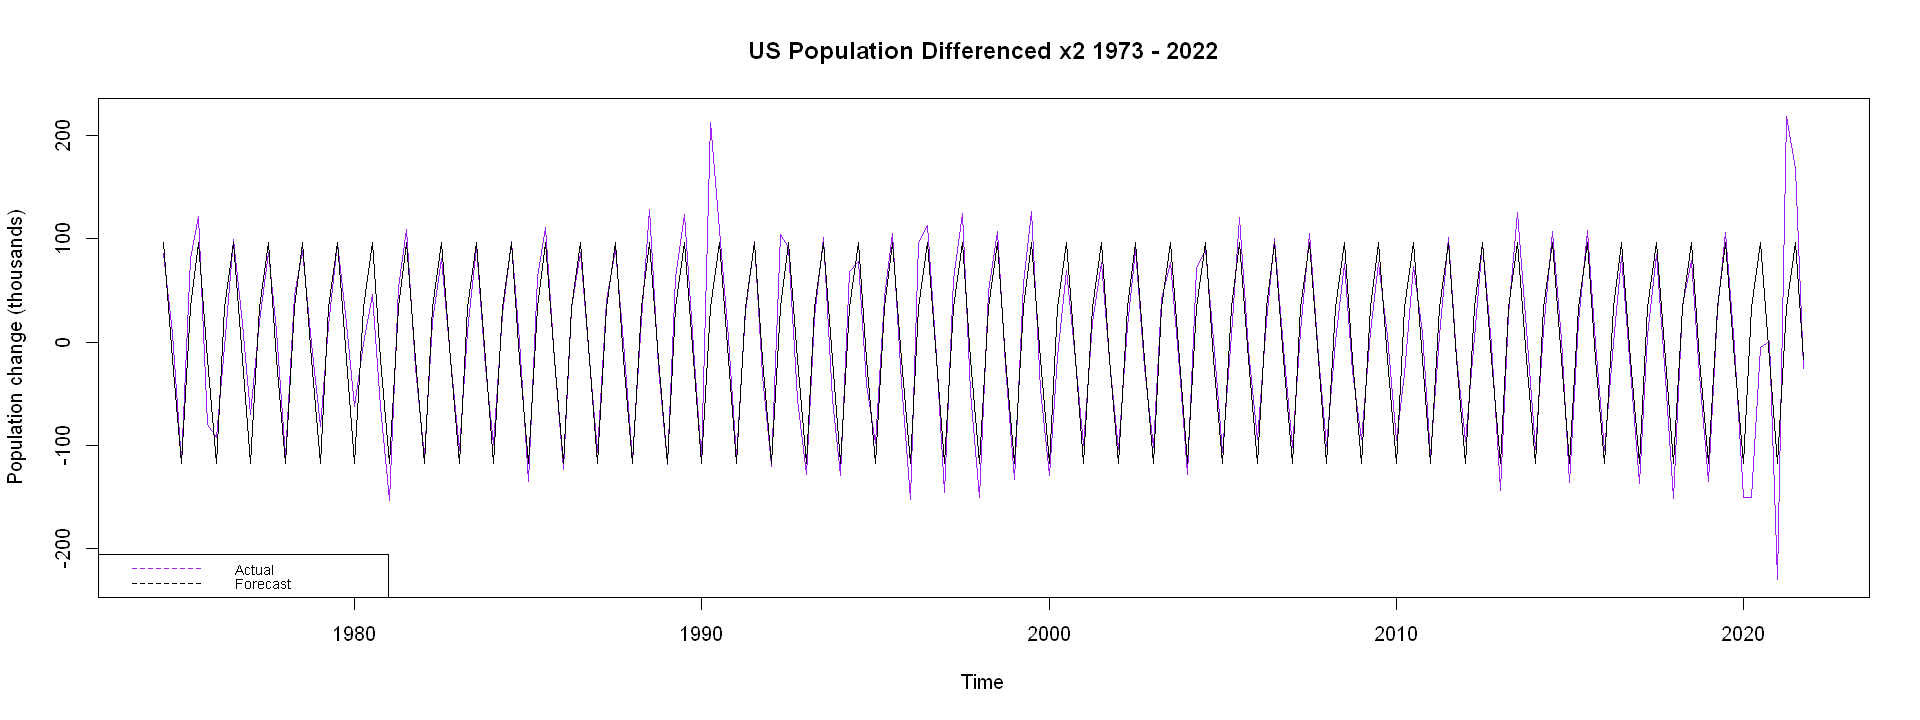

In [302]:
popD.pred.ts = ts(fitted(gam.qtr.popD), start=c(1974,3), frequency = 4)
ts.plot(population.ag.train.diff.ts, main="US Population Differenced x2 1973 - 2022", ylab="Population change (thousands)", col=col5)
lines(popD.pred.ts, col="black")
legend('bottomleft', legend=c("Actual","Forecast"), lty = 2, cex=0.70, col=c(col5, "black"))

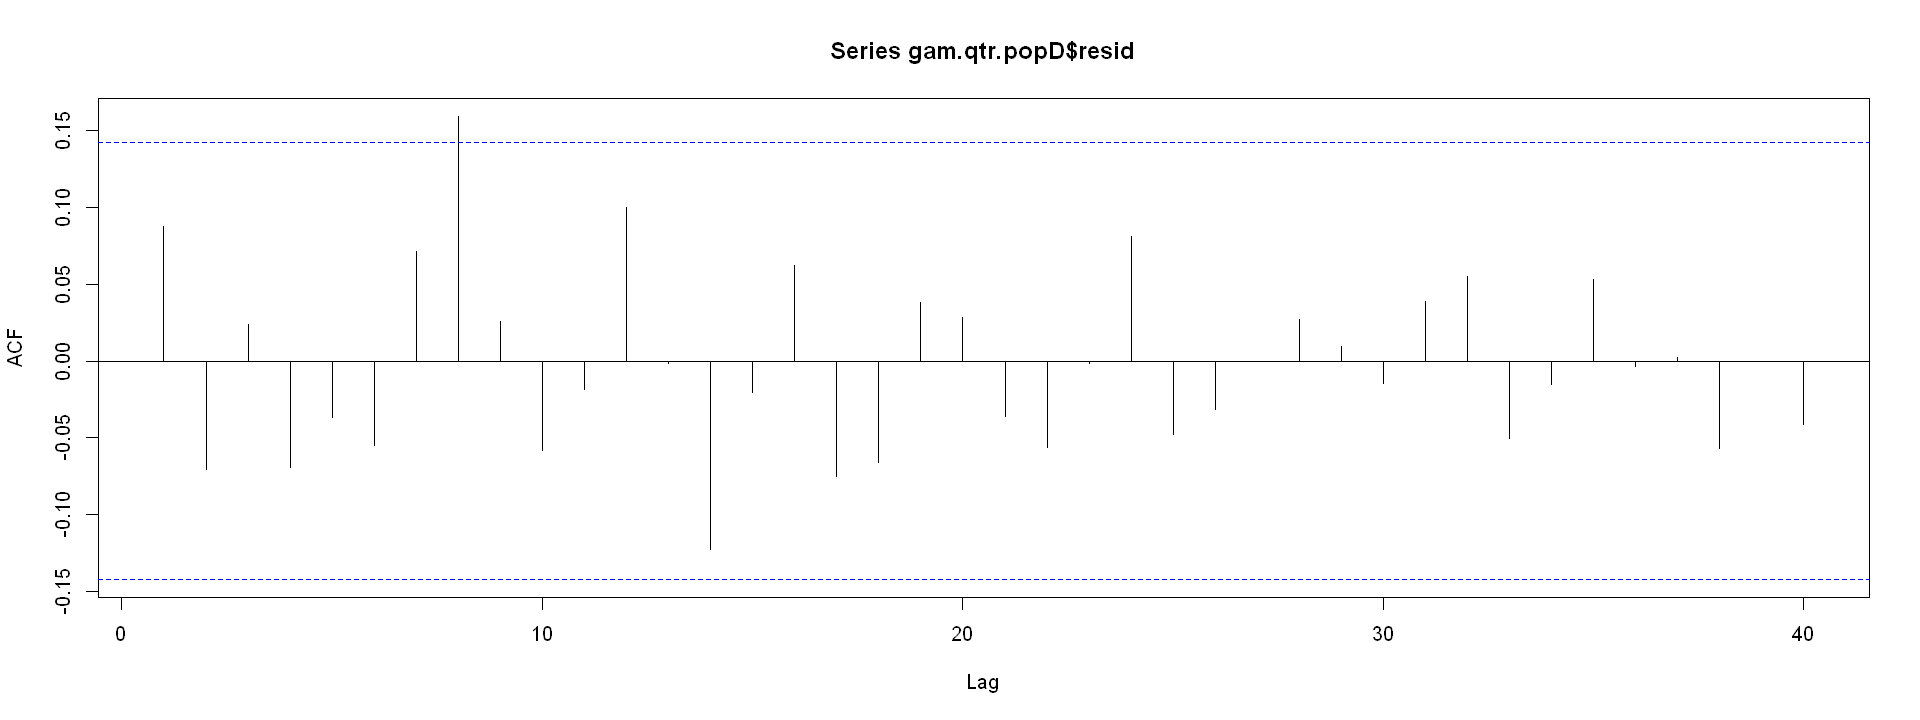

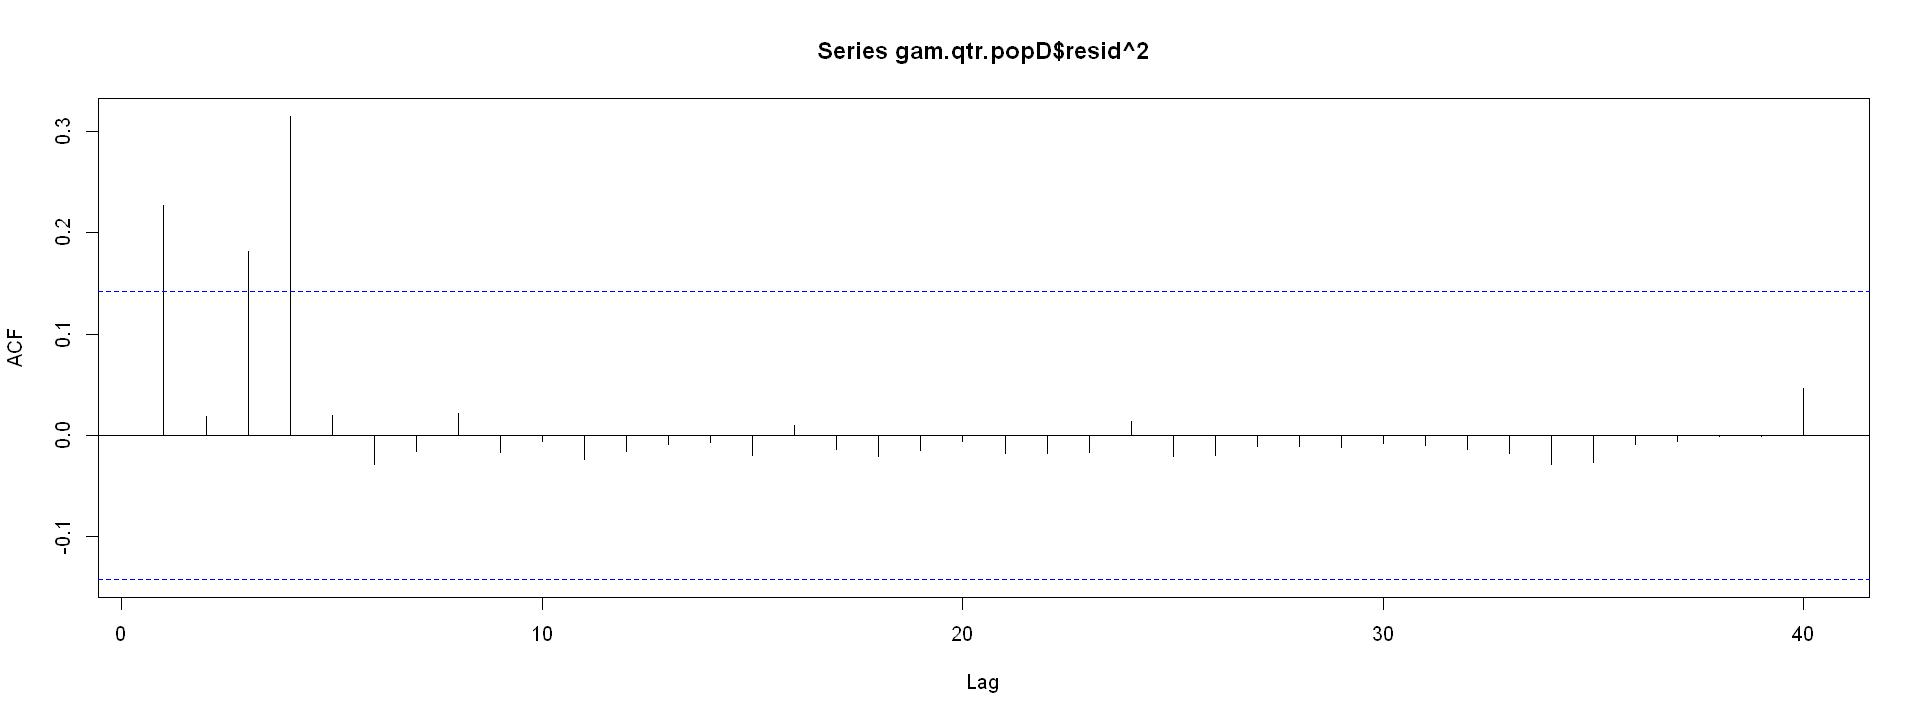

In [303]:
acf(gam.qtr.popD$resid, lag.max=4*10)
acf(gam.qtr.popD$resid^2, lag.max=4*10)


#### Model Selection



In [352]:
deng.ag.tr2 = ts(deng.ag.tr1[3:dim(deng.ag.tr1)[1],], start=c(1974,3), frequency = 4)
dGP.ag.tr2 = ts(dGP.ag.tr1[3:length(dGP.ag.tr1)], start=c(1974,3), frequency = 4)
population.ag.train.diff.resid.ts = ts(gam.qtr.popD$resid, start=c(1974,3),frequency = 4)

In [353]:
exogeneous.train.data = data.frame(dGP.ag.tr2, population.ag.train.diff.resid.ts)
VARselect(
    deng.ag.tr2,
    lag.max = 10,
    season=4,
    exogen=exogeneous.train.data
)$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     9      1      1      9


#### Model fitting



In [354]:
mod.varx2=VAR(
    deng.ag.tr2,
    p=1,
    season=4,
    exogen=exogeneous.train.data
)
summary(mod.varx2)


VAR Estimation Results:
Endogenous variables: dRS.ag.tr1, dCS.ag.tr1, dIS.ag.tr1 
Deterministic variables: const 
Sample size: 189 
Log Likelihood: 1236.71 
Roots of the characteristic polynomial:
0.5992 0.2799 0.2555
Call:
VAR(y = deng.ag.tr2, p = 1, season = 4L, exogen = exogeneous.train.data)


Estimation results for equation dRS.ag.tr1: 
dRS.ag.tr1 = dRS.ag.tr1.l1 + dCS.ag.tr1.l1 + dIS.ag.tr1.l1 + const + sd1 + sd2 + sd3 + dGP.ag.tr2 + population.ag.train.diff.resid.ts 

                                    Estimate Std. Error t value Pr(>|t|)  
dRS.ag.tr1.l1                      0.2870764  0.1129668   2.541   0.0119 *
dCS.ag.tr1.l1                     -0.1222715  0.1933831  -0.632   0.5280  
dIS.ag.tr1.l1                      0.2214878  0.1050933   2.108   0.0365 *
const                              0.0105881  0.0068362   1.549   0.1232  
sd1                                0.0049392  0.0111708   0.442   0.6589  
sd2                               -0.0014235  0.0111175  -0.128   0.8

In [355]:
population.ag.diff.ts = diff(diff(population.ag.ts))
pop.n = length(population.ag.diff.ts)
population.ag.test.diff.ts = population.ag.diff.ts[(pop.n-3):pop.n]

exogeneous.test.data = data.frame(dGP.ag.test1, population.ag.test.diff.ts)
names(exogeneous.test.data) = names(exogeneous.train.data)

In [356]:
varx.forecast2<-predict(
    mod.varx2,
    n.ahead=4,
    season=4,
    ci = 0.95,
    dumvar=as.matrix(exogeneous.test.data)
)

In [357]:
# Extract predictions for each time series
dRS.varx.pred2<-varx.forecast2$fcst$dRS.ag.tr1[,1]
dCS.varx.pred2<-varx.forecast2$fcst$dCS.ag.tr1[,1]
dIS.varx.pred2<-varx.forecast2$fcst$dIS.ag.tr1[,1]

# Add diff time series to original training data
RS.varx.pred2<-finalpreds(dRS.varx.pred2, RS.ag.tr1)
CS.varx.pred2<-finalpreds(dCS.varx.pred2, CS.ag.tr1)
IS.varx.pred2<-finalpreds(dIS.varx.pred2, IS.ag.tr1)

In [358]:
# 95% confidence interval
ubound_XRS2 = varx.forecast2$fcst$dRS.ag.tr1[9:12]
lbound_XRS2 = varx.forecast2$fcst$dRS.ag.tr1[5:8]

ubound_XCS2 = varx.forecast2$fcst$dCS.ag.tr1[9:12]
lbound_XCS2 = varx.forecast2$fcst$dCS.ag.tr1[5:8]

ubound_XIS2 = varx.forecast2$fcst$dIS.ag.tr1[9:12]
lbound_XIS2 = varx.forecast2$fcst$dIS.ag.tr1[5:8]

Xymin1 = min(lbound_XRS2,lbound_XCS2,lbound_XIS2)
Xymax1 = max(ubound_XRS2,ubound_XCS2,ubound_XIS2)


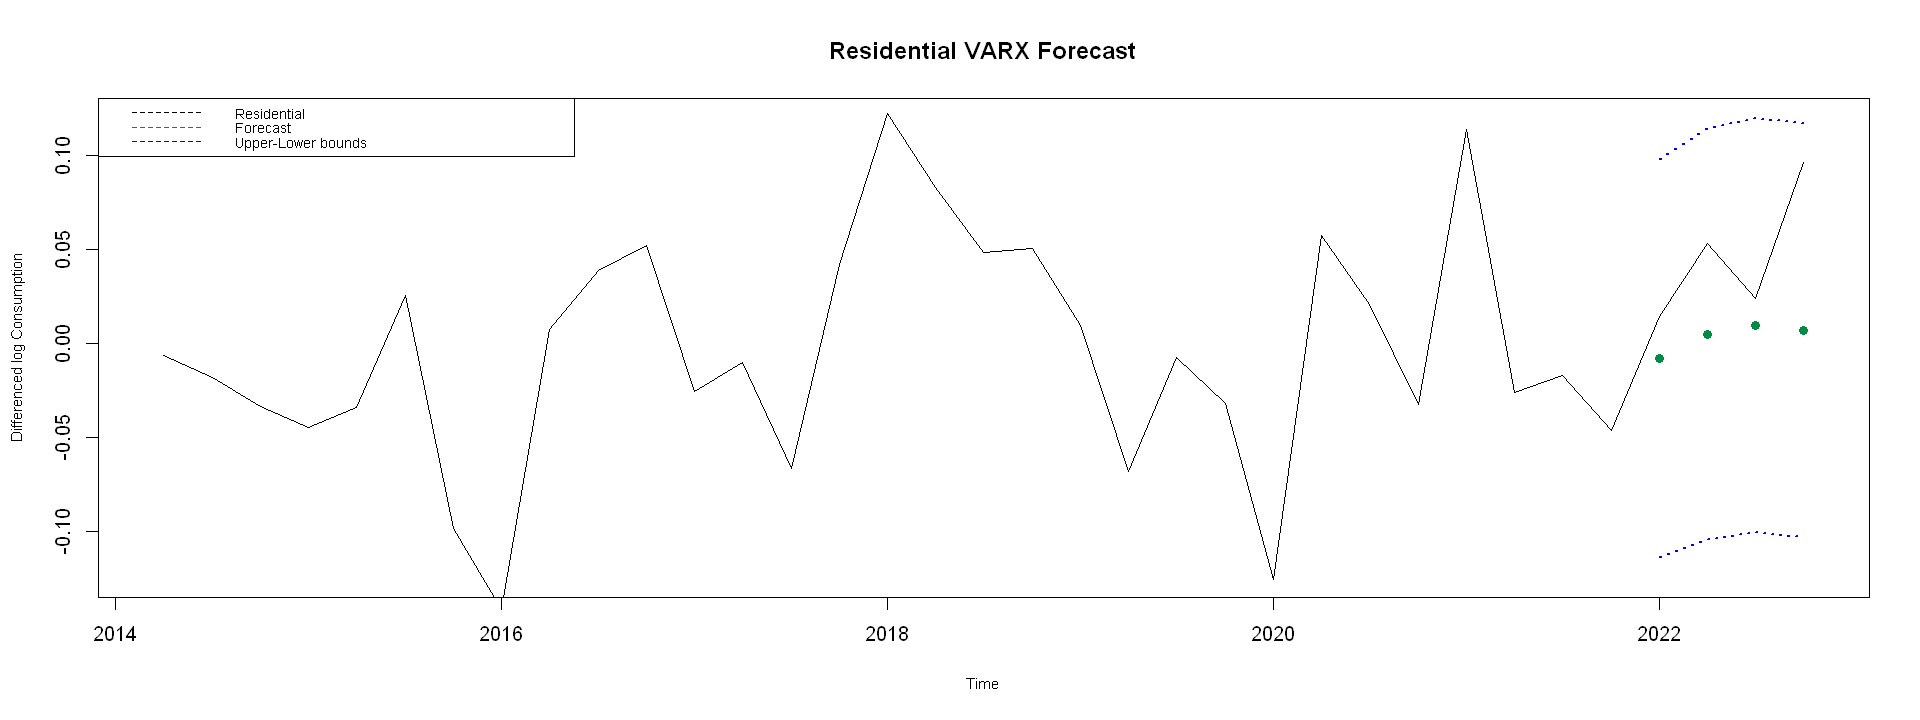

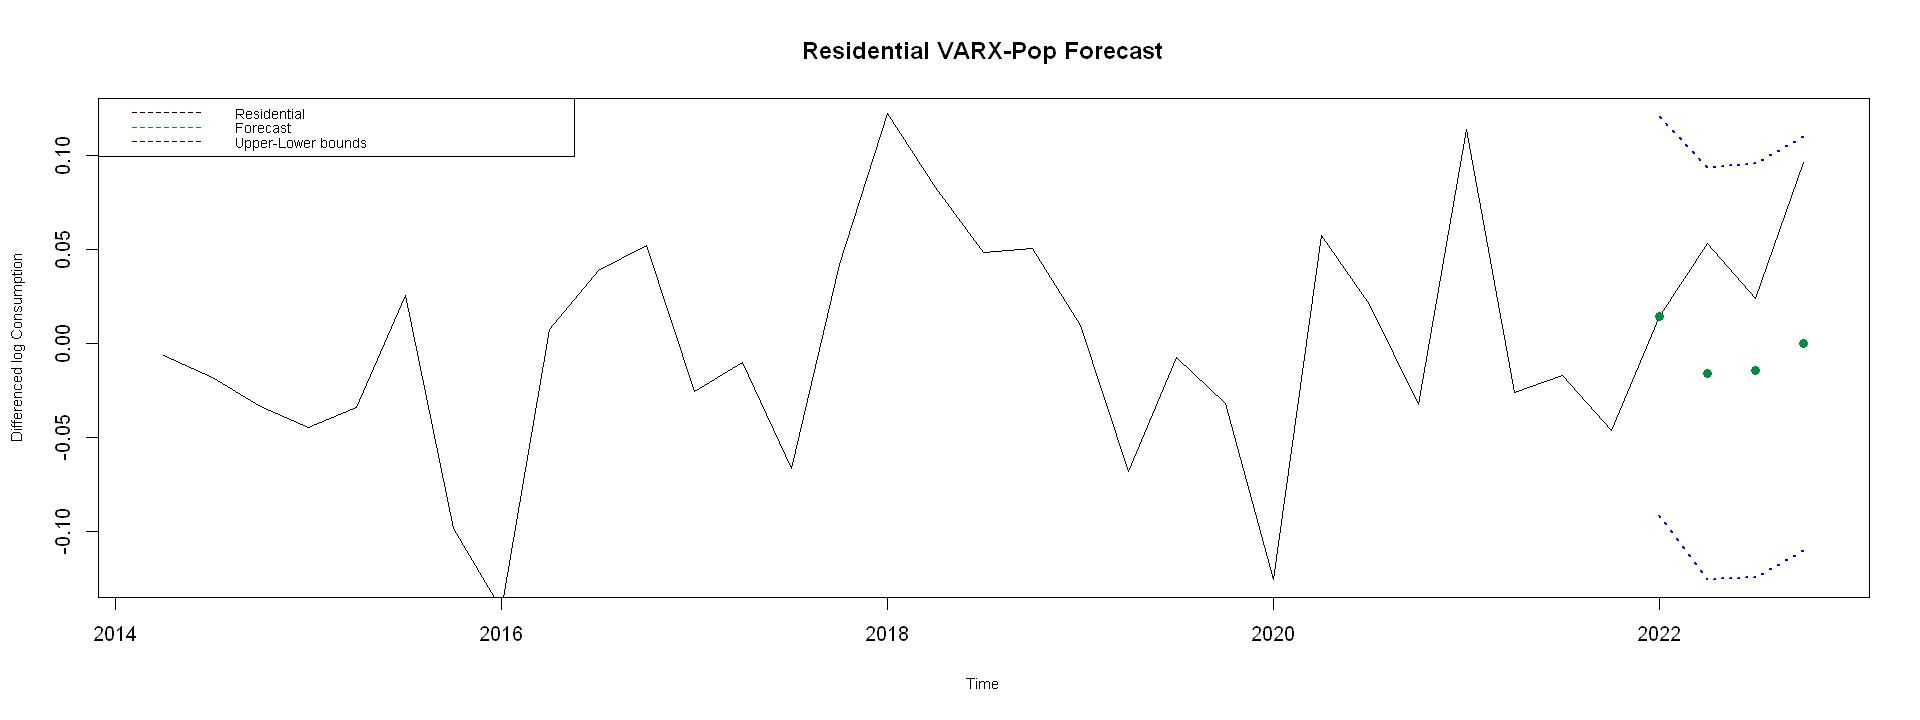

In [359]:
dates.diff = index(dAll.ag.1)
# Plot Resdiential Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dRS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Residential VARX Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dRS.varx.pred,col=col1,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XRS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XRS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Residential","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col1,"blue"))


dates.diff = index(dAll.ag.1)
# Plot Resdiential Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dRS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Residential VARX-Pop Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dRS.varx.pred2,col=col1,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XRS2,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XRS2,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Residential","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col1,"blue"))


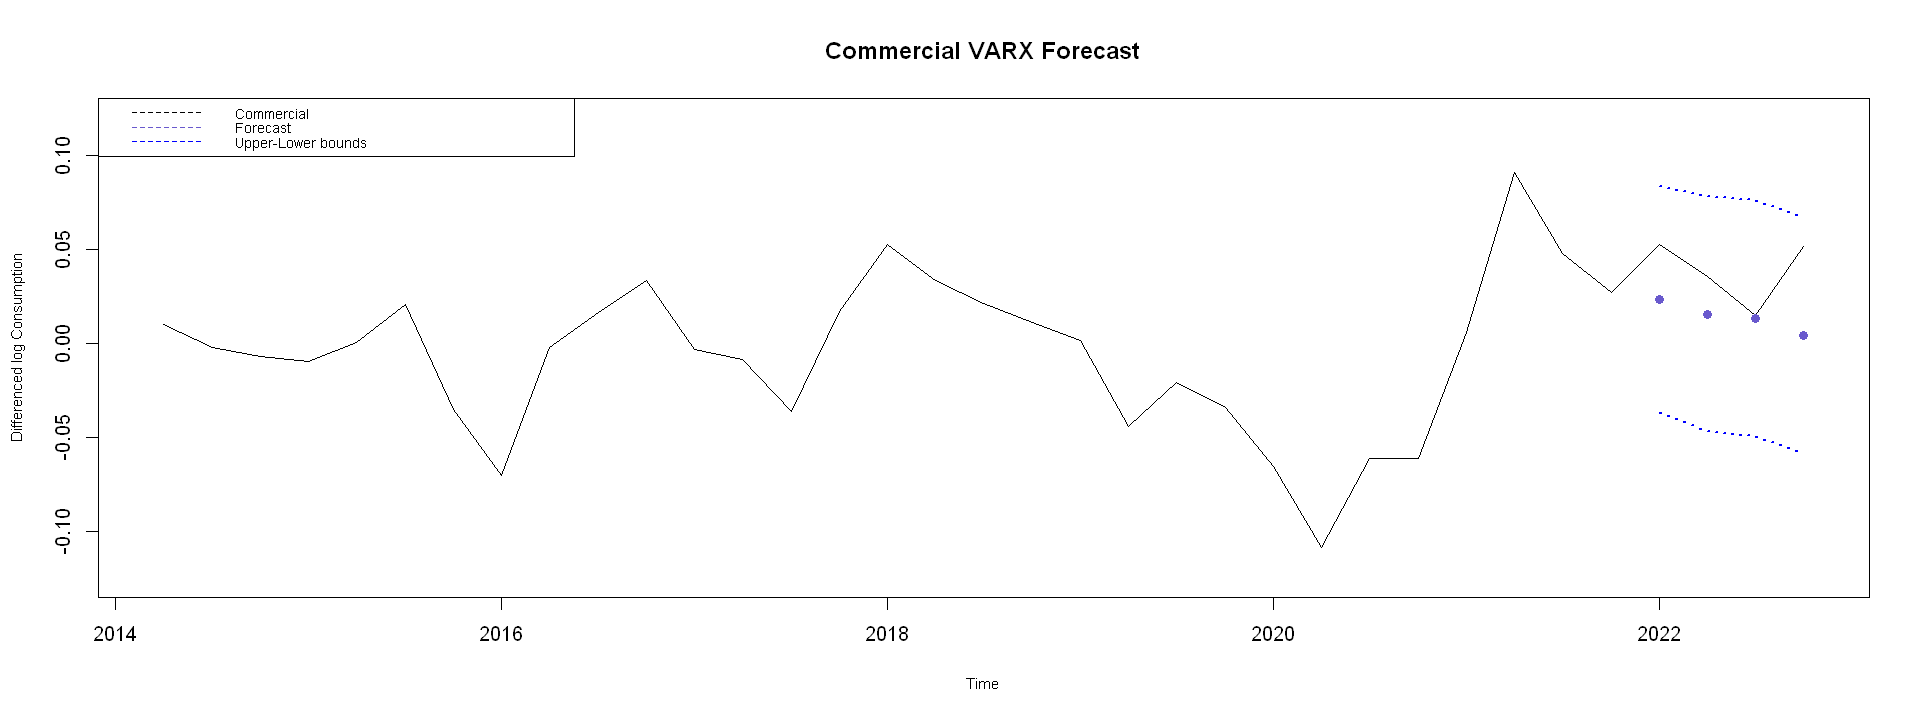

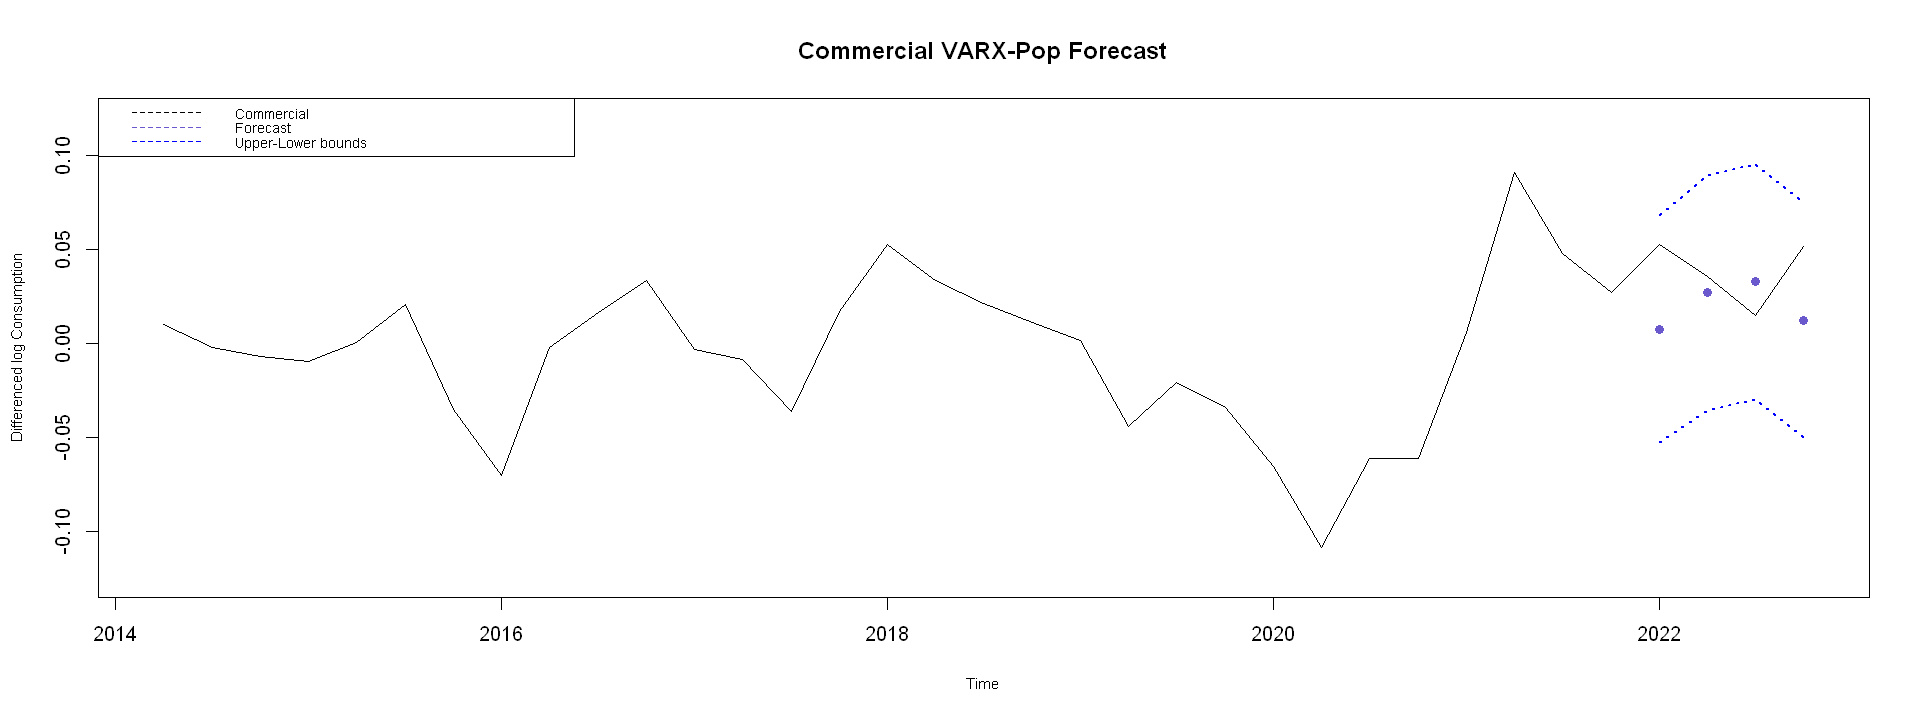

In [360]:
# Plot Commercial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dCS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Commercial VARX Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dCS.varx.pred,col=col2,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XCS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XCS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Commercial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col2,"blue"))


# Plot Commercial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dCS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Commercial VARX-Pop Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dCS.varx.pred2,col=col2,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XCS2,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XCS2,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Commercial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col2,"blue"))


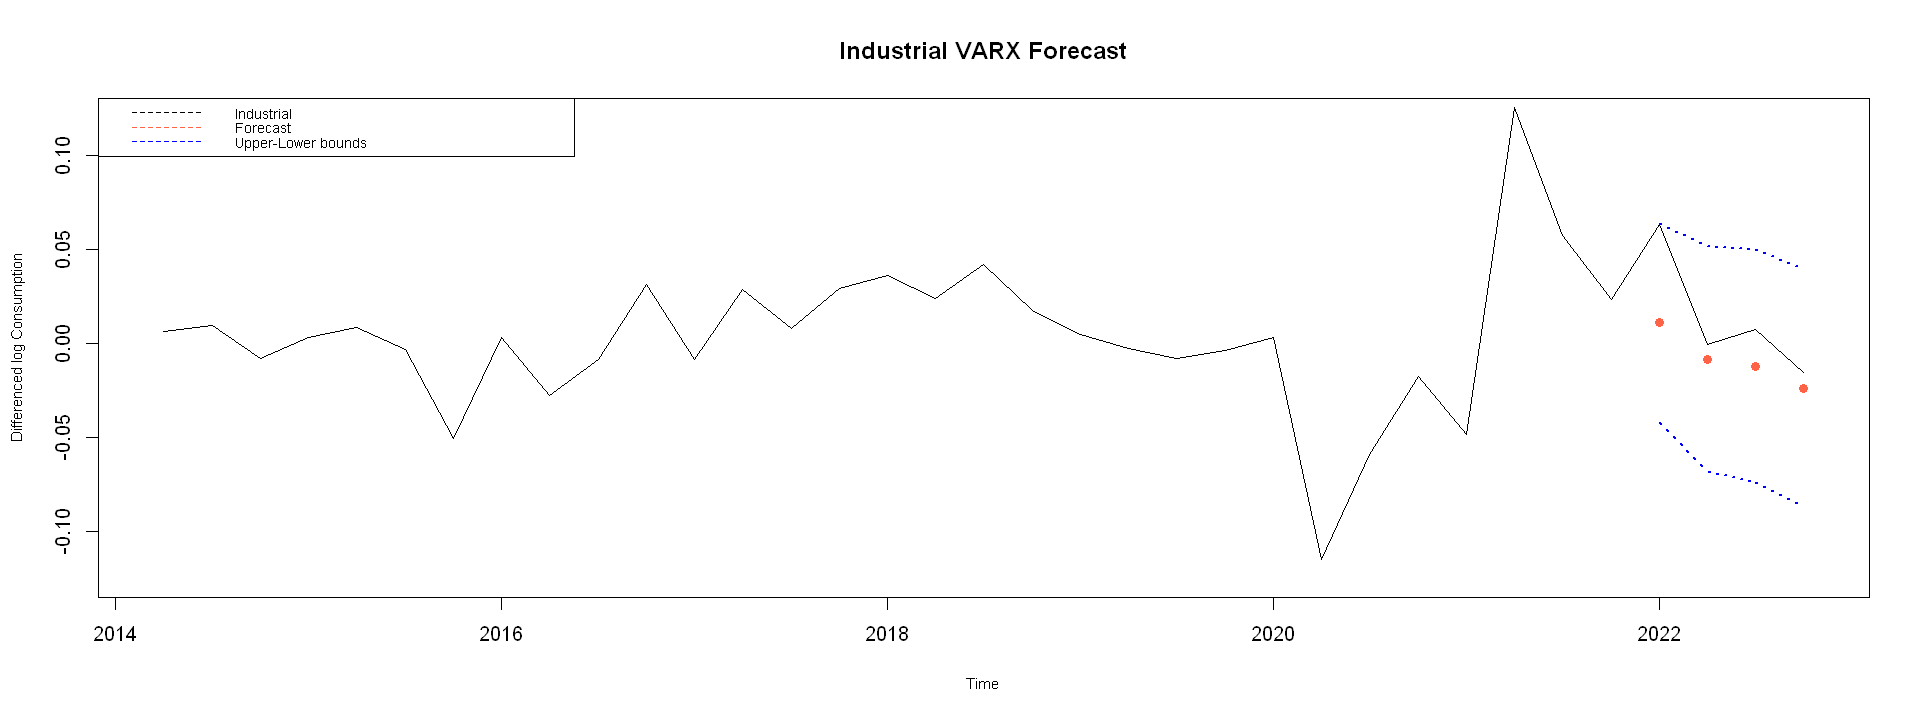

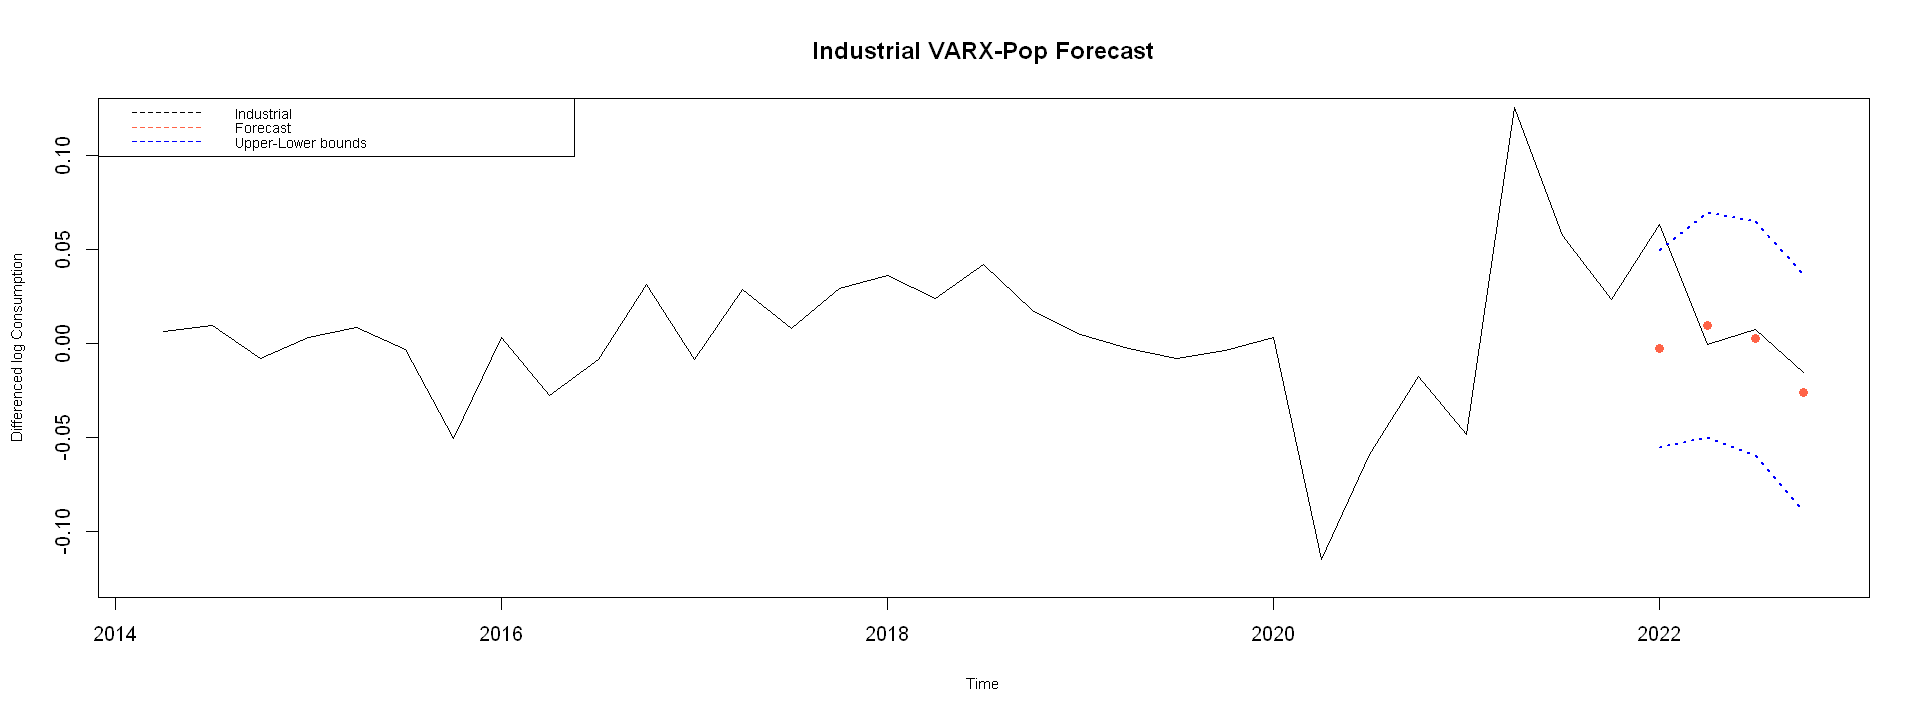

In [361]:
# Plot Industrial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dIS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Industrial VARX Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dIS.varx.pred,col=col3,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XIS,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XIS,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Industrial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col3,"blue"))

# Plot Industrial Forecast
plot((dates.diff)[(dn-dn_forward-30):dn],dIS.ag.1[(dn-dn_forward-30):dn], type="l", ylim=c(Xymin1,Xymax1), xlab="Time", ylab="Differenced log Consumption", cex.lab=0.75, main="Industrial VARX-Pop Forecast") 
#points((dates.diff)[(n2_train+1):n2],pred1_RS,col="red") 
points((dates.diff)[(dn_fit+1):dn],dIS.varx.pred2,col=col3,pch=16) 
lines((dates.diff)[(dn_fit+1):dn],ubound_XIS2,lty=3,lwd= 2, col="blue") 
lines((dates.diff)[(dn_fit+1):dn],lbound_XIS2,lty=3,lwd= 2, col="blue") 
legend('topleft', legend=c("Industrial","Forecast","Upper-Lower bounds"), lty = 2, cex=0.70, col=c("black",col3,"blue"))




#### Calculate Accuracy Measures for Differenced VARX



In [362]:
cat("RS Diff VARX-Pop MAPE:", mean((abs(dRS.varx.pred2 - dRS.ag.test1))/abs(dRS.ag.test1)),
", RS Diff VARX-Pop PM:", sum((dRS.varx.pred2 - dRS.ag.test1) ^ 2)/sum((dRS.ag.test1 - mean(dRS.ag.test1)) ^ 2),

"\nCS Diff VARX-Pop MAPE:", mean((abs(dCS.varx.pred2 - dCS.ag.test1))/abs(dCS.ag.test1)),
", CS Diff VARX-Pop PM:", sum((dCS.varx.pred2-dCS.ag.test1)^2)/sum((dCS.ag.test1-mean(dCS.ag.test1))^2),

"\nIS Diff VARX-Pop MAPE:", mean((abs(dIS.varx.pred2 - dIS.ag.test1))/abs(dIS.ag.test1)),
", IS Diff VARX-Pop PM:", sum((dIS.varx.pred2 - dIS.ag.test1) ^ 2)/sum((dIS.ag.test1 - mean(dIS.ag.test1)) ^ 2))

RS Diff VARX-Pop MAPE: 0.9757205 , RS Diff VARX-Pop PM: 3.82781 
CS Diff VARX-Pop MAPE: 0.7576227 , CS Diff VARX-Pop PM: 4.256121 
IS Diff VARX-Pop MAPE: 11.97549 , IS Diff VARX-Pop PM: 1.294545


##### Calculate Accuracy Measures for VARX



In [363]:
eRS.varx.pred2 <-  exp(RS.varx.pred2)
eCS.varx.pred2 <-  exp(CS.varx.pred2)
eIS.varx.pred2 <-  exp(IS.varx.pred2)

cat("RS VARX MAPE:", mean((abs(eRS.varx.pred2 - eRS.ag.test1))/abs(eRS.ag.test1)),
", RS VARX PM:", sum((eRS.varx.pred2 - eRS.ag.test1) ^ 2)/sum((eRS.ag.test1 - mean(eRS.ag.test1)) ^ 2),

"\nCS VARX MAPE:", mean((abs(eCS.varx.pred2 - eCS.ag.test1))/abs(eCS.ag.test1)),
", CS VARX PM:", sum((eCS.varx.pred2-eCS.ag.test1)^2)/sum((eCS.ag.test1-mean(eCS.ag.test1))^2),

"\nIS VARX MAPE:", mean((abs(eIS.varx.pred2 - eIS.ag.test1))/abs(eIS.ag.test1)),
", IS VARX PM:", sum((eIS.varx.pred2 - eIS.ag.test1) ^ 2)/sum((eIS.ag.test1 - mean(eIS.ag.test1)) ^ 2))

RS VARX MAPE: 0.1201002 , RS VARX PM: 1.288201 
CS VARX MAPE: 0.07374485 , CS VARX PM: 1.592993 
IS VARX MAPE: 0.008622617 , IS VARX PM: 1.815502

In [364]:
arch.test (mod.varx2)
serial.test(mod.varx2)
normality.test(mod.varx2)


	ARCH (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 241.7, df = 180, p-value = 0.001466

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 241.7, df = 180, p-value = 0.001466




	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod.varx2
Chi-squared = 198.5, df = 135, p-value = 0.0003087

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod.varx2
Chi-squared = 198.5, df = 135, p-value = 0.0003087



$JB

	JB-Test (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 41.418, df = 6, p-value = 2.396e-07


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 4.7346, df = 3, p-value = 0.1923


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 36.683, df = 3, p-value = 5.369e-08


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 41.418, df = 6, p-value = 2.396e-07


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 4.7346, df = 3, p-value = 0.1923


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object mod.varx2
Chi-squared = 36.683, df = 3, p-value = 5.369e-08




## Granger Causality: Wald Test

#### Population

In [379]:
# Population on Residential 
coef2.dRS = coefficients(mod.varx2)$dRS.ag.tr1[-4,1]
cov2.dRS = vcov(mod.varx2)[c(2:9),c(2:9)]
wald.test(b=coef2.dRS, cov2.dRS, Terms = c(8))

Wald test:
----------

Chi-squared test:
X2 = 2.2, df = 1, P(> X2) = 0.14

In [378]:
# Population on Commercial
coef2.dCS = coefficients(mod.varx2)$dCS.ag.tr1[-4,1]
cov2.dCS = vcov(mod.varx2)[c(11:18),c(11:18)]
wald.test(b=coef2.dCS, cov2.dCS, Terms = c(8))

Wald test:
----------

Chi-squared test:
X2 = 3.2, df = 1, P(> X2) = 0.075

In [380]:
# Population on Industrial
coef2.dIS = coefficients(mod.varx2)$dIS.ag.tr1[-4,1]
cov2.dIS = vcov(mod.varx2)[c(20:27),c(20:27)]
wald.test(b=coef2.dIS, cov2.dIS, Terms = c(8))

Wald test:
----------

Chi-squared test:
X2 = 3.3, df = 1, P(> X2) = 0.069

#### GDP

In [479]:
# Population on Residential 
coef2.dRS = coefficients(mod.varx2)$dRS.ag.tr1[-4,1]
cov2.dRS = vcov(mod.varx2)[c(2:9),c(2:9)]
wald.test(b=coef2.dRS, cov2.dRS, Terms = c(7))

Wald test:
----------

Chi-squared test:
X2 = 0.43, df = 1, P(> X2) = 0.51

In [480]:
# Population on Commercial
coef2.dCS = coefficients(mod.varx2)$dCS.ag.tr1[-4,1]
cov2.dCS = vcov(mod.varx2)[c(11:18),c(11:18)]
wald.test(b=coef2.dCS, cov2.dCS, Terms = c(7))

Wald test:
----------

Chi-squared test:
X2 = 8.8, df = 1, P(> X2) = 0.0031

In [481]:
# Population on Industrial
coef2.dIS = coefficients(mod.varx2)$dIS.ag.tr1[-4,1]
cov2.dIS = vcov(mod.varx2)[c(20:27),c(20:27)]
wald.test(b=coef2.dIS, cov2.dIS, Terms = c(7))

Wald test:
----------

Chi-squared test:
X2 = 80.6, df = 1, P(> X2) = 0.0

#### GDP + Population

In [482]:
# Population on Residential 
coef2.dRS = coefficients(mod.varx2)$dRS.ag.tr1[-4,1]
cov2.dRS = vcov(mod.varx2)[c(2:9),c(2:9)]
wald.test(b=coef2.dRS, cov2.dRS, Terms = c(7,8))

Wald test:
----------

Chi-squared test:
X2 = 3.6, df = 2, P(> X2) = 0.17

In [483]:
# Population on Commercial
coef2.dCS = coefficients(mod.varx2)$dCS.ag.tr1[-4,1]
cov2.dCS = vcov(mod.varx2)[c(11:18),c(11:18)]
wald.test(b=coef2.dCS, cov2.dCS, Terms = c(7,8))

Wald test:
----------

Chi-squared test:
X2 = 16.9, df = 2, P(> X2) = 0.00022

In [484]:
# Population on Industrial
coef2.dIS = coefficients(mod.varx2)$dIS.ag.tr1[-4,1]
cov2.dIS = vcov(mod.varx2)[c(20:27),c(20:27)]
wald.test(b=coef2.dIS, cov2.dIS, Terms = c(7,8))

Wald test:
----------

Chi-squared test:
X2 = 104.2, df = 2, P(> X2) = 0.0